In [1]:
try:
    import google.colab

    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !apt -qq update -y
    !apt -qq install swig -y
    !pip -q install box2d-py
    !pip -q install "gymnasium[classic-control, box2d, atari, accept-rom-license, mujoco]"
    !pip -q install piglet
    !pip -q install imageio_ffmpeg
    !pip -q install moviepy==1.0.3
    !pip -q install gymnasium[mujoco]

49 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 49 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Selecting previously unselected package swig4.0.
(Reading database ... 121753 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubuntu1_all.deb ...
Unpacking swig (4.0.2-1ubuntu1) ...
Setting up swig4.0 (4.0.2-1ubuntu1) ...
Setting up swig (4.0.2-1ubuntu1) ...
Processing triggers for man-db (2.10.2-1) ...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.5/374.5 kB 3.7 MB/s eta 0:00:00

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
import numpy as np
from tqdm import tqdm
from collections import deque

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
lr_actor = 0.0003
lr_critic = 0.0003
Iter = 15000
MAX_STEP = 10000
gamma = 0.98
lambd = 0.98
batch_size = 64
epsilon = 0.2
l2_rate = 0.001
beta = 3


class Actor(nn.Module):
    def __init__(self, N_S, N_A):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(N_S, 64)
        self.fc2 = nn.Linear(64, 64)
        self.sigma = nn.Linear(64, N_A)
        self.mu = nn.Linear(64, N_A)
        self.mu.weight.data.mul_(0.1)
        self.mu.bias.data.mul_(0.0)
        # self.set_init([self.fc1,self.fc2, self.mu, self.sigma])
        self.distribution = torch.distributions.Normal

    def set_init(self, layers):
        for layer in layers:
            nn.init.normal_(layer.weight, mean=0.0, std=0.1)
            nn.init.constant_(layer.bias, 0.0)

    def forward(self, s):
        x = torch.tanh(self.fc1(s))
        x = torch.tanh(self.fc2(x))

        mu = self.mu(x)
        log_sigma = self.sigma(x)
        # log_sigma = torch.zeros_like(mu)
        sigma = torch.exp(log_sigma)
        return mu, sigma

    def choose_action(self, s):
        mu, sigma = self.forward(s)
        Pi = self.distribution(mu, sigma)
        return Pi.sample().cpu().numpy()


class Critic(nn.Module):
    def __init__(self, N_S):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(N_S, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
        self.fc3.weight.data.mul_(0.1)
        self.fc3.bias.data.mul_(0.0)
        # self.set_init([self.fc1, self.fc2, self.fc2])

    def set_init(self, layers):
        for layer in layers:
            nn.init.normal_(layer.weight, mean=0.0, std=0.1)
            nn.init.constant_(layer.bias, 0.0)

    def forward(self, s):
        x = torch.tanh(self.fc1(s))
        x = torch.tanh(self.fc2(x))
        values = self.fc3(x)
        return values


class Ppo:
    def __init__(self, N_S, N_A):
        self.actor_net = Actor(N_S, N_A).to(device)
        self.critic_net = Critic(N_S).to(device)
        self.actor_optim = optim.Adam(self.actor_net.parameters(), lr=lr_actor)
        self.critic_optim = optim.Adam(
            self.critic_net.parameters(), lr=lr_critic, weight_decay=l2_rate
        )
        self.critic_loss_func = torch.nn.MSELoss()

    def train(self, memory):
        # memory = np.array(memory)
        states = torch.tensor(
            np.vstack(np.array([val[0] for val in memory])), dtype=torch.float32
        ).to(device)

        actions = torch.tensor(
            np.array([val[1] for val in memory]), dtype=torch.float32
        ).to(device)
        rewards = torch.tensor(
            np.array([val[2] for val in memory]), dtype=torch.float32
        ).to(device)
        masks = torch.tensor(
            np.array([val[3] for val in memory]), dtype=torch.float32
        ).to(device)

        values = self.critic_net(states)

        returns, advants = self.get_gae(rewards, masks, values)
        old_mu, old_std = self.actor_net(states)
        pi = self.actor_net.distribution(old_mu, old_std)

        old_log_prob = pi.log_prob(actions).sum(1, keepdim=True)

        n = len(states)
        arr = np.arange(n)
        for epoch in range(1):
            np.random.shuffle(arr)
            for i in range(n // batch_size):
                b_index = arr[batch_size * i : batch_size * (i + 1)]
                b_states = states[b_index]
                b_advants = advants[b_index].unsqueeze(1)
                b_actions = actions[b_index]
                b_returns = returns[b_index].unsqueeze(1)

                mu, std = self.actor_net(b_states)
                pi = self.actor_net.distribution(mu, std)
                new_prob = pi.log_prob(b_actions).sum(1, keepdim=True)
                old_prob = old_log_prob[b_index].detach()
                # KL_penalty = self.kl_divergence(old_mu[b_index],old_std[b_index],mu,std)
                ratio = torch.exp(new_prob - old_prob)

                surrogate_loss = ratio * b_advants
                values = self.critic_net(b_states)

                critic_loss = self.critic_loss_func(values, b_returns)

                self.critic_optim.zero_grad()
                critic_loss.backward()
                self.critic_optim.step()

                ratio = torch.clamp(ratio, 1.0 - epsilon, 1.0 + epsilon)

                clipped_loss = ratio * b_advants

                actor_loss = -torch.min(surrogate_loss, clipped_loss).mean()
                # actor_loss = -(surrogate_loss-beta*KL_penalty).mean()

                self.actor_optim.zero_grad()
                actor_loss.backward()

                self.actor_optim.step()

    def kl_divergence(self, old_mu, old_sigma, mu, sigma):
        old_mu = old_mu.detach()
        old_sigma = old_sigma.detach()

        kl = (
            torch.log(old_sigma)
            - torch.log(sigma)
            + (old_sigma.pow(2) + (old_mu - mu).pow(2)) / (2.0 * sigma.pow(2))
            - 0.5
        )
        return kl.sum(1, keepdim=True)

    def get_gae(self, rewards, masks, values):
        rewards = torch.Tensor(rewards)
        masks = torch.Tensor(masks)
        returns = torch.zeros_like(rewards)
        advants = torch.zeros_like(rewards)
        running_returns = 0
        previous_value = 0
        running_advants = 0

        for t in reversed(range(0, len(rewards))):
            running_returns = rewards[t] + gamma * running_returns * masks[t]
            running_tderror = (
                rewards[t] + gamma * previous_value * masks[t] - values.data[t]
            )
            running_advants = (
                running_tderror + gamma * lambd * running_advants * masks[t]
            )

            returns[t] = running_returns
            previous_value = values.data[t]
            advants[t] = running_advants
        advants = (advants - advants.mean()) / advants.std()
        return returns, advants


class Nomalize:
    def __init__(self, N_S):
        self.mean = np.zeros((N_S,))
        self.std = np.zeros((N_S,))
        self.stdd = np.zeros((N_S,))
        self.n = 0

    def __call__(self, x):
        x = np.asarray(x)
        self.n += 1
        if self.n == 1:
            self.mean = x
        else:
            old_mean = self.mean.copy()
            self.mean = old_mean + (x - old_mean) / self.n
            self.stdd = self.stdd + (x - old_mean) * (x - self.mean)
        if self.n > 1:
            self.std = np.sqrt(self.stdd / (self.n - 1))
        else:
            self.std = self.mean

        x = x - self.mean
        x = x / (self.std + 1e-8)
        x = np.clip(x, -5, +5)

        return x

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
env = gym.make("Humanoid-v4")
N_S = env.observation_space.shape[0]
N_A = env.action_space.shape[0]
# env.seed(500)
torch.manual_seed(500)
np.random.seed(500)

ppo = Ppo(N_S, N_A)
nomalize = Nomalize(N_S)
episodes = 0
eva_episodes = 0
scores_total = list()
for iter in tqdm(range(Iter)):
    memory = deque()
    scores = []
    steps = 0
    while steps < 2048:
        episodes += 1
        s = nomalize(env.reset()[0])
        score = 0
        for _ in range(MAX_STEP):
            steps += 1
            a = ppo.actor_net.choose_action(
                torch.from_numpy(np.array(s).astype(np.float32)).unsqueeze(0).to(device)
            )[0]
            s_, r, terminated, truncated, info = env.step(a)
            done = terminated or truncated
            s_ = nomalize(s_)

            mask = (1 - done) * 1
            memory.append([s, a, r, mask])

            score += r
            s = s_
            if done:
                break
        scores.append(score)
    score_avg = np.mean(scores)
    scores_total.append(score_avg)
    print("{} episode score is {:.2f}".format(episodes, score_avg))
    ppo.train(memory)

  0%|          | 0/15000 [00:00<?, ?it/s]

96 episode score is 70.21


  0%|          | 1/15000 [00:05<21:55:09,  5.26s/it]

189 episode score is 72.58


  0%|          | 2/15000 [00:11<25:07:07,  6.03s/it]

278 episode score is 75.74


  0%|          | 3/15000 [00:17<23:37:31,  5.67s/it]

373 episode score is 72.84


  0%|          | 4/15000 [00:23<24:10:48,  5.80s/it]

460 episode score is 78.05


  0%|          | 5/15000 [00:25<19:02:44,  4.57s/it]

548 episode score is 78.27


  0%|          | 6/15000 [00:27<15:56:35,  3.83s/it]

635 episode score is 79.10


  0%|          | 7/15000 [00:30<13:59:16,  3.36s/it]

725 episode score is 77.08


  0%|          | 8/15000 [00:33<13:46:28,  3.31s/it]

809 episode score is 81.89


  0%|          | 9/15000 [00:35<12:37:42,  3.03s/it]

894 episode score is 81.63


  0%|          | 10/15000 [00:38<11:46:57,  2.83s/it]

967 episode score is 95.84


  0%|          | 11/15000 [00:40<11:15:48,  2.71s/it]

1038 episode score is 99.12


  0%|          | 12/15000 [00:43<11:04:37,  2.66s/it]

1108 episode score is 100.25


  0%|          | 13/15000 [00:46<11:41:01,  2.81s/it]

1179 episode score is 100.93


  0%|          | 14/15000 [00:48<11:14:35,  2.70s/it]

1244 episode score is 111.01


  0%|          | 15/15000 [00:51<10:58:39,  2.64s/it]

1310 episode score is 107.96


  0%|          | 16/15000 [00:53<10:43:26,  2.58s/it]

1367 episode score is 126.30


  0%|          | 17/15000 [00:56<11:02:26,  2.65s/it]

1422 episode score is 133.63


  0%|          | 18/15000 [00:59<11:22:27,  2.73s/it]

1475 episode score is 140.19


  0%|          | 19/15000 [01:01<11:03:15,  2.66s/it]

1526 episode score is 149.99


  0%|          | 20/15000 [01:04<10:53:15,  2.62s/it]

1576 episode score is 149.55


  0%|          | 21/15000 [01:07<10:49:09,  2.60s/it]

1622 episode score is 170.86


  0%|          | 22/15000 [01:10<11:46:07,  2.83s/it]

1669 episode score is 163.17


  0%|          | 23/15000 [01:12<11:23:18,  2.74s/it]

1715 episode score is 167.16


  0%|          | 24/15000 [01:15<11:24:07,  2.74s/it]

1760 episode score is 168.65


  0%|          | 25/15000 [01:18<11:08:25,  2.68s/it]

1802 episode score is 188.28


  0%|          | 26/15000 [01:21<11:19:08,  2.72s/it]

1841 episode score is 201.32


  0%|          | 27/15000 [01:24<11:44:50,  2.82s/it]

1883 episode score is 185.81


  0%|          | 28/15000 [01:26<11:20:28,  2.73s/it]

1922 episode score is 202.16


  0%|          | 29/15000 [01:29<11:04:49,  2.66s/it]

1962 episode score is 199.79


  0%|          | 30/15000 [01:31<10:53:34,  2.62s/it]

2000 episode score is 210.03


  0%|          | 31/15000 [01:35<11:52:20,  2.86s/it]

2036 episode score is 224.75


  0%|          | 32/15000 [01:37<11:31:00,  2.77s/it]

2074 episode score is 205.47


  0%|          | 33/15000 [01:40<11:13:46,  2.70s/it]

2113 episode score is 207.78


  0%|          | 34/15000 [01:42<11:06:31,  2.67s/it]

2151 episode score is 205.25


  0%|          | 35/15000 [01:45<11:11:34,  2.69s/it]

2190 episode score is 203.78


  0%|          | 36/15000 [01:48<11:50:15,  2.85s/it]

2227 episode score is 211.02


  0%|          | 37/15000 [01:51<11:27:42,  2.76s/it]

2263 episode score is 226.62


  0%|          | 38/15000 [01:55<13:05:02,  3.15s/it]

2300 episode score is 216.37


  0%|          | 39/15000 [01:58<12:49:03,  3.08s/it]

2335 episode score is 231.15


  0%|          | 40/15000 [02:01<12:48:53,  3.08s/it]

2370 episode score is 227.49


  0%|          | 41/15000 [02:03<12:10:28,  2.93s/it]

2404 episode score is 237.19


  0%|          | 42/15000 [02:06<11:49:19,  2.85s/it]

2441 episode score is 223.37


  0%|          | 43/15000 [02:09<11:35:05,  2.79s/it]

2476 episode score is 232.50


  0%|          | 44/15000 [02:12<12:23:01,  2.98s/it]

2512 episode score is 230.87


  0%|          | 45/15000 [02:15<11:55:38,  2.87s/it]

2548 episode score is 226.85


  0%|          | 46/15000 [02:17<11:35:43,  2.79s/it]

2585 episode score is 226.99


  0%|          | 47/15000 [02:20<11:23:41,  2.74s/it]

2623 episode score is 214.27


  0%|          | 48/15000 [02:23<11:45:47,  2.83s/it]

2658 episode score is 238.14


  0%|          | 49/15000 [02:26<11:58:06,  2.88s/it]

2692 episode score is 254.01


  0%|          | 50/15000 [02:29<11:49:33,  2.85s/it]

2722 episode score is 282.10


  0%|          | 51/15000 [02:32<11:38:34,  2.80s/it]

2755 episode score is 254.03


  0%|          | 52/15000 [02:34<11:29:02,  2.77s/it]

2790 episode score is 239.44


  0%|          | 53/15000 [02:38<12:24:11,  2.99s/it]

2821 episode score is 268.37


  0%|          | 54/15000 [02:40<12:02:37,  2.90s/it]

2856 episode score is 235.25


  0%|          | 55/15000 [02:43<11:42:13,  2.82s/it]

2890 episode score is 254.20


  0%|          | 56/15000 [02:46<11:27:33,  2.76s/it]

2922 episode score is 256.62


  0%|          | 57/15000 [02:49<12:17:42,  2.96s/it]

2954 episode score is 259.68


  0%|          | 58/15000 [02:52<11:54:04,  2.87s/it]

2988 episode score is 241.11


  0%|          | 59/15000 [02:54<11:43:19,  2.82s/it]

3020 episode score is 260.52


  0%|          | 60/15000 [02:57<11:33:22,  2.78s/it]

3053 episode score is 249.06


  0%|          | 61/15000 [03:00<11:48:25,  2.85s/it]

3085 episode score is 258.60


  0%|          | 62/15000 [03:03<12:10:09,  2.93s/it]

3119 episode score is 243.34


  0%|          | 63/15000 [03:06<11:51:40,  2.86s/it]

3153 episode score is 240.06


  0%|          | 64/15000 [03:09<11:35:38,  2.79s/it]

3188 episode score is 233.62


  0%|          | 65/15000 [03:11<11:27:22,  2.76s/it]

3219 episode score is 267.56


  0%|          | 66/15000 [03:15<12:19:11,  2.97s/it]

3251 episode score is 255.44


  0%|          | 67/15000 [03:17<11:58:58,  2.89s/it]

3286 episode score is 241.87


  0%|          | 68/15000 [03:20<11:39:17,  2.81s/it]

3317 episode score is 270.50


  0%|          | 69/15000 [03:23<11:31:50,  2.78s/it]

3353 episode score is 233.80


  0%|          | 70/15000 [03:26<12:21:55,  2.98s/it]

3385 episode score is 264.36


  0%|          | 71/15000 [03:29<12:03:03,  2.91s/it]

3418 episode score is 258.14


  0%|          | 72/15000 [03:32<11:44:17,  2.83s/it]

3450 episode score is 264.00


  0%|          | 73/15000 [03:34<11:32:04,  2.78s/it]

3484 episode score is 250.54


  0%|          | 74/15000 [03:37<11:39:44,  2.81s/it]

3518 episode score is 254.78


  0%|          | 75/15000 [03:40<12:09:49,  2.93s/it]

3553 episode score is 246.31


  1%|          | 76/15000 [03:43<11:48:56,  2.85s/it]

3585 episode score is 271.14


  1%|          | 77/15000 [03:46<11:35:45,  2.80s/it]

3618 episode score is 256.66


  1%|          | 78/15000 [03:48<11:23:34,  2.75s/it]

3652 episode score is 237.30


  1%|          | 79/15000 [03:52<12:13:03,  2.95s/it]

3684 episode score is 263.95


  1%|          | 80/15000 [03:54<11:51:01,  2.86s/it]

3718 episode score is 247.70


  1%|          | 81/15000 [03:57<11:35:16,  2.80s/it]

3751 episode score is 247.99


  1%|          | 82/15000 [04:00<11:22:13,  2.74s/it]

3786 episode score is 236.34


  1%|          | 83/15000 [04:03<12:33:36,  3.03s/it]

3819 episode score is 261.71


  1%|          | 84/15000 [04:08<14:11:46,  3.43s/it]

3853 episode score is 243.80


  1%|          | 85/15000 [04:11<13:58:36,  3.37s/it]

3888 episode score is 233.82


  1%|          | 86/15000 [04:14<13:00:08,  3.14s/it]

3924 episode score is 227.97


  1%|          | 87/15000 [04:17<12:59:25,  3.14s/it]

3960 episode score is 234.67


  1%|          | 88/15000 [04:20<12:53:41,  3.11s/it]

3995 episode score is 238.97


  1%|          | 89/15000 [04:22<12:20:52,  2.98s/it]

4028 episode score is 248.94


  1%|          | 90/15000 [04:25<11:55:53,  2.88s/it]

4063 episode score is 233.17


  1%|          | 91/15000 [04:28<11:37:11,  2.81s/it]

4096 episode score is 241.50


  1%|          | 92/15000 [04:31<12:24:05,  2.99s/it]

4130 episode score is 243.09


  1%|          | 93/15000 [04:34<11:58:51,  2.89s/it]

4165 episode score is 233.04


  1%|          | 94/15000 [04:36<11:42:57,  2.83s/it]

4196 episode score is 269.98


  1%|          | 95/15000 [04:39<11:28:13,  2.77s/it]

4230 episode score is 246.25


  1%|          | 96/15000 [04:43<12:15:08,  2.96s/it]

4264 episode score is 242.14


  1%|          | 97/15000 [04:45<11:53:49,  2.87s/it]

4296 episode score is 256.83


  1%|          | 98/15000 [04:48<11:35:07,  2.80s/it]

4331 episode score is 238.90


  1%|          | 99/15000 [04:51<12:39:32,  3.06s/it]

4365 episode score is 231.49


  1%|          | 100/15000 [04:55<12:58:52,  3.14s/it]

4398 episode score is 243.03


  1%|          | 101/15000 [04:58<12:30:18,  3.02s/it]

4430 episode score is 264.85


  1%|          | 102/15000 [05:00<11:56:51,  2.89s/it]

4462 episode score is 263.13


  1%|          | 103/15000 [05:03<11:40:35,  2.82s/it]

4497 episode score is 234.69


  1%|          | 104/15000 [05:06<11:35:31,  2.80s/it]

4531 episode score is 250.16


  1%|          | 105/15000 [05:09<12:16:11,  2.97s/it]

4565 episode score is 244.26


  1%|          | 106/15000 [05:11<11:49:04,  2.86s/it]

4597 episode score is 260.05


  1%|          | 107/15000 [05:14<11:31:33,  2.79s/it]

4631 episode score is 247.20


  1%|          | 108/15000 [05:17<11:18:20,  2.73s/it]

4664 episode score is 266.20


  1%|          | 109/15000 [05:20<12:14:41,  2.96s/it]

4694 episode score is 282.17


  1%|          | 110/15000 [05:23<12:18:50,  2.98s/it]

4728 episode score is 253.31


  1%|          | 111/15000 [05:26<12:00:09,  2.90s/it]

4761 episode score is 263.44


  1%|          | 112/15000 [05:29<11:40:57,  2.82s/it]

4795 episode score is 254.01


  1%|          | 113/15000 [05:32<12:06:03,  2.93s/it]

4830 episode score is 247.52


  1%|          | 114/15000 [05:35<12:08:25,  2.94s/it]

4864 episode score is 249.05


  1%|          | 115/15000 [05:37<11:48:51,  2.86s/it]

4899 episode score is 245.37


  1%|          | 116/15000 [05:40<11:29:44,  2.78s/it]

4936 episode score is 226.95


  1%|          | 117/15000 [05:43<11:31:28,  2.79s/it]

4971 episode score is 244.33


  1%|          | 118/15000 [05:46<12:08:14,  2.94s/it]

5005 episode score is 252.31


  1%|          | 119/15000 [05:49<11:47:35,  2.85s/it]

5038 episode score is 250.22


  1%|          | 120/15000 [05:51<11:32:13,  2.79s/it]

5072 episode score is 247.33


  1%|          | 121/15000 [05:54<11:16:45,  2.73s/it]

5106 episode score is 249.89


  1%|          | 122/15000 [05:57<12:11:11,  2.95s/it]

5141 episode score is 239.12


  1%|          | 123/15000 [06:00<11:49:37,  2.86s/it]

5176 episode score is 249.02


  1%|          | 124/15000 [06:03<11:37:32,  2.81s/it]

5210 episode score is 250.32


  1%|          | 125/15000 [06:05<11:27:50,  2.77s/it]

5244 episode score is 254.58


  1%|          | 126/15000 [06:09<11:48:01,  2.86s/it]

5279 episode score is 253.81


  1%|          | 127/15000 [06:12<12:04:26,  2.92s/it]

5315 episode score is 239.54


  1%|          | 128/15000 [06:14<11:37:57,  2.82s/it]

5351 episode score is 235.62


  1%|          | 129/15000 [06:17<11:25:15,  2.76s/it]

5383 episode score is 259.19


  1%|          | 130/15000 [06:19<11:13:46,  2.72s/it]

5418 episode score is 242.59


  1%|          | 131/15000 [06:23<12:09:04,  2.94s/it]

5453 episode score is 231.93


  1%|          | 132/15000 [06:26<11:47:58,  2.86s/it]

5487 episode score is 257.45


  1%|          | 133/15000 [06:28<11:37:05,  2.81s/it]

5522 episode score is 243.56


  1%|          | 134/15000 [06:31<11:20:52,  2.75s/it]

5557 episode score is 237.48


  1%|          | 135/15000 [06:34<12:02:50,  2.92s/it]

5592 episode score is 239.29


  1%|          | 136/15000 [06:37<11:51:27,  2.87s/it]

5625 episode score is 251.46


  1%|          | 137/15000 [06:40<11:31:25,  2.79s/it]

5659 episode score is 252.30


  1%|          | 138/15000 [06:42<11:20:20,  2.75s/it]

5694 episode score is 240.45


  1%|          | 139/15000 [06:45<11:20:27,  2.75s/it]

5728 episode score is 249.70


  1%|          | 140/15000 [06:48<12:04:28,  2.93s/it]

5764 episode score is 239.52


  1%|          | 141/15000 [06:51<11:47:35,  2.86s/it]

5800 episode score is 237.13


  1%|          | 142/15000 [06:54<11:30:01,  2.79s/it]

5833 episode score is 258.41


  1%|          | 143/15000 [06:56<11:17:48,  2.74s/it]

5864 episode score is 284.21


  1%|          | 144/15000 [07:00<12:13:38,  2.96s/it]

5899 episode score is 248.21


  1%|          | 145/15000 [07:02<11:49:20,  2.87s/it]

5932 episode score is 270.00


  1%|          | 146/15000 [07:05<11:34:33,  2.81s/it]

5966 episode score is 264.62


  1%|          | 147/15000 [07:08<11:25:38,  2.77s/it]

6003 episode score is 232.81


  1%|          | 148/15000 [07:11<11:58:10,  2.90s/it]

6037 episode score is 261.26


  1%|          | 149/15000 [07:14<11:59:13,  2.91s/it]

6071 episode score is 268.95


  1%|          | 150/15000 [07:16<11:40:56,  2.83s/it]

6107 episode score is 255.12


  1%|          | 151/15000 [07:19<11:32:42,  2.80s/it]

6140 episode score is 279.51


  1%|          | 152/15000 [07:22<11:31:08,  2.79s/it]

6173 episode score is 284.34


  1%|          | 153/15000 [07:25<12:13:36,  2.96s/it]

6209 episode score is 258.46


  1%|          | 154/15000 [07:28<11:55:46,  2.89s/it]

6244 episode score is 257.65


  1%|          | 155/15000 [07:31<11:36:30,  2.82s/it]

6279 episode score is 266.35


  1%|          | 156/15000 [07:33<11:28:22,  2.78s/it]

6314 episode score is 263.88


  1%|          | 157/15000 [07:37<12:26:10,  3.02s/it]

6348 episode score is 274.65


  1%|          | 158/15000 [07:40<12:01:49,  2.92s/it]

6383 episode score is 273.63


  1%|          | 159/15000 [07:42<11:47:00,  2.86s/it]

6418 episode score is 265.21


  1%|          | 160/15000 [07:45<11:35:41,  2.81s/it]

6454 episode score is 261.64


  1%|          | 161/15000 [07:48<12:19:14,  2.99s/it]

6489 episode score is 263.27


  1%|          | 162/15000 [07:51<12:07:09,  2.94s/it]

6524 episode score is 261.98


  1%|          | 163/15000 [07:54<11:46:06,  2.86s/it]

6558 episode score is 274.59


  1%|          | 164/15000 [07:57<11:35:07,  2.81s/it]

6592 episode score is 273.69


  1%|          | 165/15000 [08:00<11:37:44,  2.82s/it]

6626 episode score is 280.06


  1%|          | 166/15000 [08:03<12:12:38,  2.96s/it]

6659 episode score is 282.20


  1%|          | 167/15000 [08:05<11:49:38,  2.87s/it]

6694 episode score is 268.28


  1%|          | 168/15000 [08:08<11:38:43,  2.83s/it]

6728 episode score is 264.15


  1%|          | 169/15000 [08:11<11:32:20,  2.80s/it]

6763 episode score is 267.74


  1%|          | 170/15000 [08:14<12:28:05,  3.03s/it]

6798 episode score is 272.10


  1%|          | 171/15000 [08:17<12:07:54,  2.95s/it]

6832 episode score is 273.85


  1%|          | 172/15000 [08:20<11:49:20,  2.87s/it]

6866 episode score is 272.39


  1%|          | 173/15000 [08:23<11:37:48,  2.82s/it]

6899 episode score is 289.72


  1%|          | 174/15000 [08:26<12:32:01,  3.04s/it]

6932 episode score is 282.96


  1%|          | 175/15000 [08:29<12:07:15,  2.94s/it]

6963 episode score is 313.79


  1%|          | 176/15000 [08:32<11:52:46,  2.88s/it]

6996 episode score is 296.63


  1%|          | 177/15000 [08:34<11:40:38,  2.84s/it]

7029 episode score is 290.62


  1%|          | 178/15000 [08:38<12:11:33,  2.96s/it]

7062 episode score is 295.09


  1%|          | 179/15000 [08:41<12:18:43,  2.99s/it]

7095 episode score is 287.87


  1%|          | 180/15000 [08:43<11:55:37,  2.90s/it]

7128 episode score is 284.41


  1%|          | 181/15000 [08:46<11:41:55,  2.84s/it]

7162 episode score is 285.64


  1%|          | 182/15000 [08:49<11:36:44,  2.82s/it]

7195 episode score is 284.11


  1%|          | 183/15000 [08:52<12:20:22,  3.00s/it]

7229 episode score is 281.01


  1%|          | 184/15000 [08:55<12:01:09,  2.92s/it]

7262 episode score is 286.80


  1%|          | 185/15000 [08:58<11:45:26,  2.86s/it]

7294 episode score is 295.01


  1%|          | 186/15000 [09:00<11:32:29,  2.80s/it]

7328 episode score is 286.96


  1%|          | 187/15000 [09:04<12:27:22,  3.03s/it]

7361 episode score is 277.69


  1%|▏         | 188/15000 [09:07<12:04:13,  2.93s/it]

7394 episode score is 285.41


  1%|▏         | 189/15000 [09:09<11:45:42,  2.86s/it]

7426 episode score is 299.57


  1%|▏         | 190/15000 [09:12<11:35:23,  2.82s/it]

7456 episode score is 315.79


  1%|▏         | 191/15000 [09:16<12:20:49,  3.00s/it]

7487 episode score is 311.50


  1%|▏         | 192/15000 [09:18<12:18:20,  2.99s/it]

7518 episode score is 310.10


  1%|▏         | 193/15000 [09:21<11:55:04,  2.90s/it]

7548 episode score is 333.21


  1%|▏         | 194/15000 [09:24<11:46:47,  2.86s/it]

7577 episode score is 342.71


  1%|▏         | 195/15000 [09:27<12:02:28,  2.93s/it]

7608 episode score is 317.18


  1%|▏         | 196/15000 [09:30<12:27:48,  3.03s/it]

7638 episode score is 322.18


  1%|▏         | 197/15000 [09:33<12:20:48,  3.00s/it]

7667 episode score is 336.50


  1%|▏         | 198/15000 [09:36<12:04:00,  2.93s/it]

7697 episode score is 328.99


  1%|▏         | 199/15000 [09:39<12:05:42,  2.94s/it]

7727 episode score is 319.58


  1%|▏         | 200/15000 [09:42<12:35:43,  3.06s/it]

7757 episode score is 332.71


  1%|▏         | 201/15000 [09:45<12:19:44,  3.00s/it]

7788 episode score is 310.29


  1%|▏         | 202/15000 [09:48<11:56:58,  2.91s/it]

7817 episode score is 332.26


  1%|▏         | 203/15000 [09:51<11:48:22,  2.87s/it]

7846 episode score is 333.25


  1%|▏         | 204/15000 [09:54<12:34:17,  3.06s/it]

7876 episode score is 326.69


  1%|▏         | 205/15000 [09:57<12:11:35,  2.97s/it]

7906 episode score is 326.20


  1%|▏         | 206/15000 [10:00<11:57:20,  2.91s/it]

7936 episode score is 326.30


  1%|▏         | 207/15000 [10:03<11:52:42,  2.89s/it]

7964 episode score is 348.74


  1%|▏         | 208/15000 [10:06<12:45:22,  3.10s/it]

7994 episode score is 327.43


  1%|▏         | 209/15000 [10:09<12:23:26,  3.02s/it]

8024 episode score is 325.20


  1%|▏         | 210/15000 [10:12<12:01:33,  2.93s/it]

8055 episode score is 314.73


  1%|▏         | 211/15000 [10:14<11:45:54,  2.86s/it]

8084 episode score is 330.24


  1%|▏         | 212/15000 [10:18<12:19:36,  3.00s/it]

8113 episode score is 335.99


  1%|▏         | 213/15000 [10:21<12:13:55,  2.98s/it]

8141 episode score is 355.29


  1%|▏         | 214/15000 [10:23<12:01:54,  2.93s/it]

8169 episode score is 340.99


  1%|▏         | 215/15000 [10:26<11:45:44,  2.86s/it]

8199 episode score is 329.24


  1%|▏         | 216/15000 [10:29<11:58:22,  2.92s/it]

8225 episode score is 375.90


  1%|▏         | 217/15000 [10:32<12:22:38,  3.01s/it]

8252 episode score is 366.56


  1%|▏         | 218/15000 [10:35<12:04:03,  2.94s/it]

8282 episode score is 332.21


  1%|▏         | 219/15000 [10:38<11:48:10,  2.87s/it]

8310 episode score is 354.05


  1%|▏         | 220/15000 [10:41<11:44:26,  2.86s/it]

8338 episode score is 345.50


  1%|▏         | 221/15000 [10:44<12:36:49,  3.07s/it]

8367 episode score is 343.07


  1%|▏         | 222/15000 [10:47<12:10:31,  2.97s/it]

8397 episode score is 321.47


  1%|▏         | 223/15000 [10:50<11:52:47,  2.89s/it]

8426 episode score is 345.18


  1%|▏         | 224/15000 [10:52<11:40:55,  2.85s/it]

8454 episode score is 346.84


  2%|▏         | 225/15000 [10:56<12:29:16,  3.04s/it]

8483 episode score is 333.92


  2%|▏         | 226/15000 [10:59<12:05:10,  2.95s/it]

8512 episode score is 337.54


  2%|▏         | 227/15000 [11:01<11:49:32,  2.88s/it]

8541 episode score is 343.31


  2%|▏         | 228/15000 [11:04<11:37:29,  2.83s/it]

8569 episode score is 350.33


  2%|▏         | 229/15000 [11:08<12:20:25,  3.01s/it]

8597 episode score is 357.90


  2%|▏         | 230/15000 [11:10<12:09:52,  2.96s/it]

8626 episode score is 341.14


  2%|▏         | 231/15000 [11:13<11:53:14,  2.90s/it]

8653 episode score is 350.97


  2%|▏         | 232/15000 [11:16<11:42:43,  2.86s/it]

8682 episode score is 336.23


  2%|▏         | 233/15000 [11:19<11:59:17,  2.92s/it]

8709 episode score is 368.70


  2%|▏         | 234/15000 [11:22<12:27:18,  3.04s/it]

8736 episode score is 358.56


  2%|▏         | 235/15000 [11:25<12:04:42,  2.94s/it]

8763 episode score is 364.39


  2%|▏         | 236/15000 [11:28<11:50:39,  2.89s/it]

8791 episode score is 346.84


  2%|▏         | 237/15000 [11:31<11:52:22,  2.90s/it]

8819 episode score is 355.73


  2%|▏         | 238/15000 [11:34<12:36:51,  3.08s/it]

8846 episode score is 361.26


  2%|▏         | 239/15000 [11:37<12:10:18,  2.97s/it]

8874 episode score is 355.90


  2%|▏         | 240/15000 [11:40<11:58:15,  2.92s/it]

8902 episode score is 359.27


  2%|▏         | 241/15000 [11:43<11:50:15,  2.89s/it]

8932 episode score is 331.82


  2%|▏         | 242/15000 [11:46<12:43:58,  3.11s/it]

8960 episode score is 359.94


  2%|▏         | 243/15000 [11:49<12:21:39,  3.02s/it]

8988 episode score is 354.40


  2%|▏         | 244/15000 [11:52<12:05:23,  2.95s/it]

9016 episode score is 354.35


  2%|▏         | 245/15000 [11:55<11:54:39,  2.91s/it]

9042 episode score is 366.25


  2%|▏         | 246/15000 [11:58<12:47:02,  3.12s/it]

9071 episode score is 339.65


  2%|▏         | 247/15000 [12:01<12:17:42,  3.00s/it]

9099 episode score is 348.16


  2%|▏         | 248/15000 [12:04<12:01:46,  2.94s/it]

9128 episode score is 336.28


  2%|▏         | 249/15000 [12:06<11:50:27,  2.89s/it]

9158 episode score is 322.38


  2%|▏         | 250/15000 [12:10<12:37:06,  3.08s/it]

9188 episode score is 325.97


  2%|▏         | 251/15000 [12:13<12:10:49,  2.97s/it]

9218 episode score is 335.15


  2%|▏         | 252/15000 [12:16<11:57:38,  2.92s/it]

9247 episode score is 346.43


  2%|▏         | 253/15000 [12:18<11:47:05,  2.88s/it]

9273 episode score is 371.25


  2%|▏         | 254/15000 [12:22<12:13:39,  2.99s/it]

9300 episode score is 352.82


  2%|▏         | 255/15000 [12:25<12:19:40,  3.01s/it]

9328 episode score is 343.81


  2%|▏         | 256/15000 [12:27<11:56:17,  2.91s/it]

9354 episode score is 373.79


  2%|▏         | 257/15000 [12:30<11:44:25,  2.87s/it]

9381 episode score is 362.00


  2%|▏         | 258/15000 [12:33<11:51:02,  2.89s/it]

9407 episode score is 389.40


  2%|▏         | 259/15000 [12:36<12:30:22,  3.05s/it]

9431 episode score is 395.64


  2%|▏         | 260/15000 [12:39<12:10:20,  2.97s/it]

9458 episode score is 360.86


  2%|▏         | 261/15000 [12:42<11:50:06,  2.89s/it]

9484 episode score is 381.81


  2%|▏         | 262/15000 [12:45<11:43:08,  2.86s/it]

9510 episode score is 369.48


  2%|▏         | 263/15000 [12:48<12:35:14,  3.07s/it]

9536 episode score is 370.55


  2%|▏         | 264/15000 [12:51<12:11:08,  2.98s/it]

9561 episode score is 397.17


  2%|▏         | 265/15000 [12:54<11:59:41,  2.93s/it]

9584 episode score is 413.00


  2%|▏         | 266/15000 [12:57<11:46:33,  2.88s/it]

9609 episode score is 393.24


  2%|▏         | 267/15000 [13:00<12:36:50,  3.08s/it]

9635 episode score is 364.08


  2%|▏         | 268/15000 [13:03<12:12:41,  2.98s/it]

9661 episode score is 378.20


  2%|▏         | 269/15000 [13:06<11:57:07,  2.92s/it]

9685 episode score is 413.29


  2%|▏         | 270/15000 [13:09<11:51:41,  2.90s/it]

9709 episode score is 412.65


  2%|▏         | 271/15000 [13:12<12:45:32,  3.12s/it]

9735 episode score is 387.55


  2%|▏         | 272/15000 [13:15<12:22:58,  3.03s/it]

9759 episode score is 400.66


  2%|▏         | 273/15000 [13:18<12:05:39,  2.96s/it]

9785 episode score is 375.99


  2%|▏         | 274/15000 [13:21<11:52:34,  2.90s/it]

9810 episode score is 401.86


  2%|▏         | 275/15000 [13:24<12:45:00,  3.12s/it]

9834 episode score is 412.41


  2%|▏         | 276/15000 [13:27<12:30:54,  3.06s/it]

9858 episode score is 410.22


  2%|▏         | 277/15000 [13:30<12:09:10,  2.97s/it]

9882 episode score is 409.84


  2%|▏         | 278/15000 [13:33<12:00:56,  2.94s/it]

9908 episode score is 381.14


  2%|▏         | 279/15000 [13:36<12:22:47,  3.03s/it]

9933 episode score is 402.29


  2%|▏         | 280/15000 [13:39<12:36:35,  3.08s/it]

9956 episode score is 425.90


  2%|▏         | 281/15000 [13:42<12:20:39,  3.02s/it]

9980 episode score is 410.73


  2%|▏         | 282/15000 [13:45<12:03:38,  2.95s/it]

10005 episode score is 381.93


  2%|▏         | 283/15000 [13:48<12:33:05,  3.07s/it]

10028 episode score is 424.63


  2%|▏         | 284/15000 [13:51<12:44:55,  3.12s/it]

10052 episode score is 398.75


  2%|▏         | 285/15000 [13:54<12:19:38,  3.02s/it]

10075 episode score is 434.94


  2%|▏         | 286/15000 [13:57<12:08:28,  2.97s/it]

10099 episode score is 421.46


  2%|▏         | 287/15000 [14:00<12:08:25,  2.97s/it]

10123 episode score is 411.64


  2%|▏         | 288/15000 [14:03<12:38:41,  3.09s/it]

10149 episode score is 392.93


  2%|▏         | 289/15000 [14:06<12:17:59,  3.01s/it]

10176 episode score is 368.77


  2%|▏         | 290/15000 [14:09<11:57:42,  2.93s/it]

10202 episode score is 393.37


  2%|▏         | 291/15000 [14:12<11:46:40,  2.88s/it]

10226 episode score is 422.38


  2%|▏         | 292/15000 [14:15<12:42:26,  3.11s/it]

10253 episode score is 376.61


  2%|▏         | 293/15000 [14:18<12:20:04,  3.02s/it]

10277 episode score is 424.35


  2%|▏         | 294/15000 [14:21<12:08:02,  2.97s/it]

10304 episode score is 381.78


  2%|▏         | 295/15000 [14:24<11:56:41,  2.92s/it]

10331 episode score is 362.45


  2%|▏         | 296/15000 [14:27<12:42:05,  3.11s/it]

10358 episode score is 361.98


  2%|▏         | 297/15000 [14:30<12:15:45,  3.00s/it]

10386 episode score is 351.12


  2%|▏         | 298/15000 [14:33<11:56:46,  2.93s/it]

10413 episode score is 370.11


  2%|▏         | 299/15000 [14:36<11:47:38,  2.89s/it]

10441 episode score is 370.63


  2%|▏         | 300/15000 [14:39<12:45:39,  3.13s/it]

10467 episode score is 393.53


  2%|▏         | 301/15000 [14:42<12:26:30,  3.05s/it]

10494 episode score is 376.00


  2%|▏         | 302/15000 [14:45<12:12:53,  2.99s/it]

10521 episode score is 367.82


  2%|▏         | 303/15000 [14:48<12:00:36,  2.94s/it]

10548 episode score is 383.25


  2%|▏         | 304/15000 [14:52<12:53:03,  3.16s/it]

10575 episode score is 378.66


  2%|▏         | 305/15000 [14:54<12:30:10,  3.06s/it]

10602 episode score is 377.34


  2%|▏         | 306/15000 [14:57<12:11:55,  2.99s/it]

10630 episode score is 366.81


  2%|▏         | 307/15000 [15:00<11:59:42,  2.94s/it]

10657 episode score is 377.38


  2%|▏         | 308/15000 [15:04<12:41:06,  3.11s/it]

10682 episode score is 417.97


  2%|▏         | 309/15000 [15:07<12:38:32,  3.10s/it]

10707 episode score is 404.52


  2%|▏         | 310/15000 [15:09<12:19:28,  3.02s/it]

10729 episode score is 453.86


  2%|▏         | 311/15000 [15:12<12:03:26,  2.96s/it]

10752 episode score is 427.98


  2%|▏         | 312/15000 [15:16<12:31:16,  3.07s/it]

10775 episode score is 457.75


  2%|▏         | 313/15000 [15:19<12:38:45,  3.10s/it]

10800 episode score is 401.01


  2%|▏         | 314/15000 [15:22<12:17:27,  3.01s/it]

10825 episode score is 413.33


  2%|▏         | 315/15000 [15:24<12:04:51,  2.96s/it]

10850 episode score is 413.52


  2%|▏         | 316/15000 [15:28<12:36:30,  3.09s/it]

10875 episode score is 418.66


  2%|▏         | 317/15000 [15:31<12:42:23,  3.12s/it]

10899 episode score is 424.61


  2%|▏         | 318/15000 [15:34<12:23:05,  3.04s/it]

10923 episode score is 421.58


  2%|▏         | 319/15000 [15:37<12:04:51,  2.96s/it]

10947 episode score is 439.94


  2%|▏         | 320/15000 [15:40<12:35:57,  3.09s/it]

10972 episode score is 423.49


  2%|▏         | 321/15000 [15:43<12:47:55,  3.14s/it]

10995 episode score is 442.60


  2%|▏         | 322/15000 [15:46<12:26:05,  3.05s/it]

11019 episode score is 416.21


  2%|▏         | 323/15000 [15:49<12:06:15,  2.97s/it]

11042 episode score is 444.98


  2%|▏         | 324/15000 [15:52<12:20:50,  3.03s/it]

11067 episode score is 413.83


  2%|▏         | 325/15000 [15:55<12:40:21,  3.11s/it]

11089 episode score is 471.86


  2%|▏         | 326/15000 [15:58<12:18:27,  3.02s/it]

11112 episode score is 444.68


  2%|▏         | 327/15000 [16:01<12:05:28,  2.97s/it]

11134 episode score is 462.74


  2%|▏         | 328/15000 [16:04<12:05:58,  2.97s/it]

11158 episode score is 424.68


  2%|▏         | 329/15000 [16:07<12:42:32,  3.12s/it]

11182 episode score is 425.45


  2%|▏         | 330/15000 [16:10<12:15:34,  3.01s/it]

11205 episode score is 455.82


  2%|▏         | 331/15000 [16:13<12:02:34,  2.96s/it]

11228 episode score is 444.40


  2%|▏         | 332/15000 [16:16<11:51:15,  2.91s/it]

11249 episode score is 492.78


  2%|▏         | 333/15000 [16:20<12:48:26,  3.14s/it]

11270 episode score is 480.68


  2%|▏         | 334/15000 [16:22<12:29:06,  3.06s/it]

11292 episode score is 463.05


  2%|▏         | 335/15000 [16:25<12:10:34,  2.99s/it]

11314 episode score is 458.66


  2%|▏         | 336/15000 [16:28<11:58:19,  2.94s/it]

11336 episode score is 462.69


  2%|▏         | 337/15000 [16:32<12:55:41,  3.17s/it]

11356 episode score is 502.41


  2%|▏         | 338/15000 [16:35<12:31:09,  3.07s/it]

11378 episode score is 471.54


  2%|▏         | 339/15000 [16:38<12:21:08,  3.03s/it]

11399 episode score is 477.39


  2%|▏         | 340/15000 [16:40<12:06:55,  2.98s/it]

11419 episode score is 503.97


  2%|▏         | 341/15000 [16:44<12:55:26,  3.17s/it]

11440 episode score is 490.59


  2%|▏         | 342/15000 [16:47<12:35:33,  3.09s/it]

11460 episode score is 511.88


  2%|▏         | 343/15000 [16:50<12:16:56,  3.02s/it]

11481 episode score is 494.30


  2%|▏         | 344/15000 [16:53<12:10:41,  2.99s/it]

11501 episode score is 511.78


  2%|▏         | 345/15000 [16:56<13:01:55,  3.20s/it]

11521 episode score is 504.26


  2%|▏         | 346/15000 [16:59<12:36:37,  3.10s/it]

11542 episode score is 492.99


  2%|▏         | 347/15000 [17:02<12:27:49,  3.06s/it]

11564 episode score is 470.36


  2%|▏         | 348/15000 [17:05<12:11:24,  3.00s/it]

11585 episode score is 484.03


  2%|▏         | 349/15000 [17:09<13:01:12,  3.20s/it]

11606 episode score is 483.44


  2%|▏         | 350/15000 [17:12<12:41:18,  3.12s/it]

11627 episode score is 486.33


  2%|▏         | 351/15000 [17:15<12:26:04,  3.06s/it]

11648 episode score is 480.39


  2%|▏         | 352/15000 [17:17<12:13:49,  3.01s/it]

11669 episode score is 499.43


  2%|▏         | 353/15000 [17:21<13:07:36,  3.23s/it]

11689 episode score is 519.56


  2%|▏         | 354/15000 [17:24<12:42:45,  3.12s/it]

11712 episode score is 443.29


  2%|▏         | 355/15000 [17:27<12:18:34,  3.03s/it]

11735 episode score is 449.10


  2%|▏         | 356/15000 [17:30<12:01:21,  2.96s/it]

11757 episode score is 451.07


  2%|▏         | 357/15000 [17:33<12:48:37,  3.15s/it]

11780 episode score is 445.59


  2%|▏         | 358/15000 [17:36<12:26:44,  3.06s/it]

11801 episode score is 471.11


  2%|▏         | 359/15000 [17:39<12:07:18,  2.98s/it]

11823 episode score is 450.56


  2%|▏         | 360/15000 [17:42<11:55:19,  2.93s/it]

11844 episode score is 490.61


  2%|▏         | 361/15000 [17:45<12:53:36,  3.17s/it]

11865 episode score is 486.93


  2%|▏         | 362/15000 [17:48<12:32:40,  3.09s/it]

11886 episode score is 472.93


  2%|▏         | 363/15000 [17:51<12:13:48,  3.01s/it]

11909 episode score is 450.02


  2%|▏         | 364/15000 [17:54<12:07:54,  2.98s/it]

11930 episode score is 475.89


  2%|▏         | 365/15000 [17:58<12:46:48,  3.14s/it]

11951 episode score is 492.27


  2%|▏         | 366/15000 [18:01<12:37:12,  3.10s/it]

11973 episode score is 464.36


  2%|▏         | 367/15000 [18:03<12:16:10,  3.02s/it]

11995 episode score is 461.72


  2%|▏         | 368/15000 [18:06<11:59:12,  2.95s/it]

12017 episode score is 468.19


  2%|▏         | 369/15000 [18:10<12:41:39,  3.12s/it]

12040 episode score is 446.61


  2%|▏         | 370/15000 [18:13<12:52:07,  3.17s/it]

12062 episode score is 455.94


  2%|▏         | 371/15000 [18:16<12:29:38,  3.07s/it]

12084 episode score is 466.37


  2%|▏         | 372/15000 [18:19<12:16:36,  3.02s/it]

12104 episode score is 512.98


  2%|▏         | 373/15000 [18:22<12:58:10,  3.19s/it]

12126 episode score is 472.74


  2%|▏         | 374/15000 [18:26<12:54:21,  3.18s/it]

12146 episode score is 504.65


  2%|▎         | 375/15000 [18:28<12:27:47,  3.07s/it]

12167 episode score is 487.80


  3%|▎         | 376/15000 [18:31<12:11:50,  3.00s/it]

12187 episode score is 517.53


  3%|▎         | 377/15000 [18:35<12:52:31,  3.17s/it]

12207 episode score is 486.46


  3%|▎         | 378/15000 [18:38<12:47:28,  3.15s/it]

12226 episode score is 521.98


  3%|▎         | 379/15000 [18:41<12:28:20,  3.07s/it]

12246 episode score is 521.45


  3%|▎         | 380/15000 [18:44<12:15:56,  3.02s/it]

12266 episode score is 512.43


  3%|▎         | 381/15000 [18:47<12:49:47,  3.16s/it]

12287 episode score is 488.86


  3%|▎         | 382/15000 [18:50<12:53:20,  3.17s/it]

12307 episode score is 485.82


  3%|▎         | 383/15000 [18:53<12:31:06,  3.08s/it]

12327 episode score is 522.68


  3%|▎         | 384/15000 [18:56<12:24:48,  3.06s/it]

12347 episode score is 499.48


  3%|▎         | 385/15000 [19:00<12:57:20,  3.19s/it]

12365 episode score is 575.86


  3%|▎         | 386/15000 [19:03<12:50:31,  3.16s/it]

12386 episode score is 482.24


  3%|▎         | 387/15000 [19:06<12:33:45,  3.09s/it]

12406 episode score is 488.73


  3%|▎         | 388/15000 [19:09<12:15:37,  3.02s/it]

12425 episode score is 539.24


  3%|▎         | 389/15000 [19:12<13:09:29,  3.24s/it]

12446 episode score is 498.76


  3%|▎         | 390/15000 [19:15<12:55:49,  3.19s/it]

12469 episode score is 427.86


  3%|▎         | 391/15000 [19:18<12:39:49,  3.12s/it]

12493 episode score is 428.87


  3%|▎         | 392/15000 [19:21<12:13:20,  3.01s/it]

12517 episode score is 429.24


  3%|▎         | 393/15000 [19:25<12:54:10,  3.18s/it]

12541 episode score is 436.46


  3%|▎         | 394/15000 [19:28<12:34:50,  3.10s/it]

12564 episode score is 433.01


  3%|▎         | 395/15000 [19:30<12:08:15,  2.99s/it]

12586 episode score is 474.43


  3%|▎         | 396/15000 [19:33<11:59:26,  2.96s/it]

12608 episode score is 476.80


  3%|▎         | 397/15000 [19:37<12:41:03,  3.13s/it]

12631 episode score is 441.20


  3%|▎         | 398/15000 [19:40<12:44:11,  3.14s/it]

12652 episode score is 484.04


  3%|▎         | 399/15000 [19:43<12:22:51,  3.05s/it]

12675 episode score is 461.07


  3%|▎         | 400/15000 [19:46<12:14:35,  3.02s/it]

12696 episode score is 482.45


  3%|▎         | 401/15000 [19:49<12:43:06,  3.14s/it]

12716 episode score is 502.48


  3%|▎         | 402/15000 [19:52<12:46:39,  3.15s/it]

12740 episode score is 432.49


  3%|▎         | 403/15000 [19:55<12:26:23,  3.07s/it]

12763 episode score is 450.37


  3%|▎         | 404/15000 [19:58<12:14:54,  3.02s/it]

12783 episode score is 514.40


  3%|▎         | 405/15000 [20:02<12:42:53,  3.14s/it]

12804 episode score is 491.04


  3%|▎         | 406/15000 [20:05<12:44:46,  3.14s/it]

12826 episode score is 464.59


  3%|▎         | 407/15000 [20:08<12:31:19,  3.09s/it]

12846 episode score is 509.14


  3%|▎         | 408/15000 [20:10<12:13:44,  3.02s/it]

12866 episode score is 500.13


  3%|▎         | 409/15000 [20:14<12:35:11,  3.11s/it]

12888 episode score is 476.31


  3%|▎         | 410/15000 [20:17<12:38:16,  3.12s/it]

12909 episode score is 489.27


  3%|▎         | 411/15000 [20:20<12:19:45,  3.04s/it]

12929 episode score is 512.35


  3%|▎         | 412/15000 [20:23<12:13:23,  3.02s/it]

12949 episode score is 517.20


  3%|▎         | 413/15000 [20:26<12:35:58,  3.11s/it]

12970 episode score is 513.71


  3%|▎         | 414/15000 [20:29<12:53:56,  3.18s/it]

12992 episode score is 491.30


  3%|▎         | 415/15000 [20:32<12:34:43,  3.10s/it]

13013 episode score is 494.63


  3%|▎         | 416/15000 [20:35<12:18:34,  3.04s/it]

13035 episode score is 467.73


  3%|▎         | 417/15000 [20:39<12:46:36,  3.15s/it]

13056 episode score is 490.85


  3%|▎         | 418/15000 [20:42<12:51:34,  3.17s/it]

13078 episode score is 458.09


  3%|▎         | 419/15000 [20:45<12:30:53,  3.09s/it]

13097 episode score is 552.72


  3%|▎         | 420/15000 [20:48<12:18:50,  3.04s/it]

13118 episode score is 504.90


  3%|▎         | 421/15000 [20:51<12:39:14,  3.12s/it]

13139 episode score is 492.77


  3%|▎         | 422/15000 [20:54<12:41:09,  3.13s/it]

13159 episode score is 522.60


  3%|▎         | 423/15000 [20:57<12:16:56,  3.03s/it]

13179 episode score is 538.38


  3%|▎         | 424/15000 [21:00<12:09:07,  3.00s/it]

13200 episode score is 495.41


  3%|▎         | 425/15000 [21:03<12:21:51,  3.05s/it]

13222 episode score is 474.47


  3%|▎         | 426/15000 [21:06<12:32:43,  3.10s/it]

13242 episode score is 520.86


  3%|▎         | 427/15000 [21:09<12:16:28,  3.03s/it]

13262 episode score is 508.05


  3%|▎         | 428/15000 [21:12<11:59:49,  2.96s/it]

13283 episode score is 507.22


  3%|▎         | 429/15000 [21:15<12:07:11,  2.99s/it]

13304 episode score is 498.63


  3%|▎         | 430/15000 [21:19<12:45:38,  3.15s/it]

13326 episode score is 483.36


  3%|▎         | 431/15000 [21:21<12:25:39,  3.07s/it]

13347 episode score is 508.50


  3%|▎         | 432/15000 [21:24<12:12:25,  3.02s/it]

13367 episode score is 518.41


  3%|▎         | 433/15000 [21:27<12:06:43,  2.99s/it]

13387 episode score is 512.79


  3%|▎         | 434/15000 [21:31<12:41:17,  3.14s/it]

13406 episode score is 536.05


  3%|▎         | 435/15000 [21:34<12:18:08,  3.04s/it]

13426 episode score is 499.42


  3%|▎         | 436/15000 [21:36<11:57:40,  2.96s/it]

13446 episode score is 528.02


  3%|▎         | 437/15000 [21:39<11:53:21,  2.94s/it]

13467 episode score is 483.11


  3%|▎         | 438/15000 [21:43<12:44:22,  3.15s/it]

13487 episode score is 508.49


  3%|▎         | 439/15000 [21:46<12:22:05,  3.06s/it]

13508 episode score is 505.51


  3%|▎         | 440/15000 [21:49<12:08:39,  3.00s/it]

13530 episode score is 486.04


  3%|▎         | 441/15000 [21:51<11:58:32,  2.96s/it]

13550 episode score is 516.80


  3%|▎         | 442/15000 [21:55<12:51:15,  3.18s/it]

13570 episode score is 529.80


  3%|▎         | 443/15000 [21:58<12:31:18,  3.10s/it]

13589 episode score is 532.67


  3%|▎         | 444/15000 [22:01<12:08:49,  3.00s/it]

13608 episode score is 545.59


  3%|▎         | 445/15000 [22:04<12:01:44,  2.98s/it]

13628 episode score is 514.86


  3%|▎         | 446/15000 [22:07<12:49:04,  3.17s/it]

13649 episode score is 509.98


  3%|▎         | 447/15000 [22:10<12:26:09,  3.08s/it]

13669 episode score is 511.17


  3%|▎         | 448/15000 [22:13<12:06:54,  3.00s/it]

13689 episode score is 505.80


  3%|▎         | 449/15000 [22:16<11:53:28,  2.94s/it]

13709 episode score is 511.47


  3%|▎         | 450/15000 [22:19<12:40:35,  3.14s/it]

13731 episode score is 495.93


  3%|▎         | 451/15000 [22:22<12:21:19,  3.06s/it]

13754 episode score is 452.88


  3%|▎         | 452/15000 [22:25<11:58:00,  2.96s/it]

13774 episode score is 532.80


  3%|▎         | 453/15000 [22:28<11:49:03,  2.92s/it]

13795 episode score is 487.02


  3%|▎         | 454/15000 [22:32<12:41:09,  3.14s/it]

13816 episode score is 496.00


  3%|▎         | 455/15000 [22:35<12:30:04,  3.09s/it]

13837 episode score is 481.47


  3%|▎         | 456/15000 [22:37<12:07:05,  3.00s/it]

13859 episode score is 494.04


  3%|▎         | 457/15000 [22:40<11:58:56,  2.97s/it]

13880 episode score is 489.28


  3%|▎         | 458/15000 [22:44<12:39:16,  3.13s/it]

13902 episode score is 476.89


  3%|▎         | 459/15000 [22:46<12:14:02,  3.03s/it]

13923 episode score is 517.45


  3%|▎         | 460/15000 [22:49<12:04:27,  2.99s/it]

13944 episode score is 499.67


  3%|▎         | 461/15000 [22:52<11:48:34,  2.92s/it]

13965 episode score is 496.83


  3%|▎         | 462/15000 [22:56<12:18:25,  3.05s/it]

13987 episode score is 492.67


  3%|▎         | 463/15000 [22:59<12:20:35,  3.06s/it]

14007 episode score is 525.28


  3%|▎         | 464/15000 [23:01<12:01:01,  2.98s/it]

14029 episode score is 492.68


  3%|▎         | 465/15000 [23:04<11:49:03,  2.93s/it]

14050 episode score is 504.56


  3%|▎         | 466/15000 [23:07<12:01:29,  2.98s/it]

14072 episode score is 477.52


  3%|▎         | 467/15000 [23:11<12:24:49,  3.08s/it]

14094 episode score is 471.53


  3%|▎         | 468/15000 [23:13<12:03:53,  2.99s/it]

14115 episode score is 501.85


  3%|▎         | 469/15000 [23:16<11:47:34,  2.92s/it]

14136 episode score is 523.78


  3%|▎         | 470/15000 [23:19<11:55:40,  2.96s/it]

14156 episode score is 525.57


  3%|▎         | 471/15000 [23:23<12:37:08,  3.13s/it]

14176 episode score is 527.82


  3%|▎         | 472/15000 [23:26<12:28:56,  3.09s/it]

14194 episode score is 568.61


  3%|▎         | 473/15000 [23:29<12:09:12,  3.01s/it]

14215 episode score is 488.32


  3%|▎         | 474/15000 [23:31<11:59:58,  2.97s/it]

14236 episode score is 510.34


  3%|▎         | 475/15000 [23:35<12:46:44,  3.17s/it]

14257 episode score is 484.00


  3%|▎         | 476/15000 [23:38<12:16:40,  3.04s/it]

14278 episode score is 492.61


  3%|▎         | 477/15000 [23:41<12:02:05,  2.98s/it]

14300 episode score is 468.24


  3%|▎         | 478/15000 [23:43<11:49:26,  2.93s/it]

14318 episode score is 576.85


  3%|▎         | 479/15000 [23:47<12:37:35,  3.13s/it]

14337 episode score is 543.59


  3%|▎         | 480/15000 [23:50<12:16:58,  3.05s/it]

14357 episode score is 525.92


  3%|▎         | 481/15000 [23:53<12:02:57,  2.99s/it]

14376 episode score is 547.70


  3%|▎         | 482/15000 [23:56<11:55:22,  2.96s/it]

14395 episode score is 545.69


  3%|▎         | 483/15000 [23:59<12:49:29,  3.18s/it]

14413 episode score is 571.28


  3%|▎         | 484/15000 [24:02<12:24:07,  3.08s/it]

14432 episode score is 538.47


  3%|▎         | 485/15000 [24:05<12:04:15,  2.99s/it]

14453 episode score is 506.57


  3%|▎         | 486/15000 [24:08<11:52:36,  2.95s/it]

14473 episode score is 526.82


  3%|▎         | 487/15000 [24:12<12:47:52,  3.17s/it]

14495 episode score is 483.46


  3%|▎         | 488/15000 [24:14<12:25:35,  3.08s/it]

14516 episode score is 484.75


  3%|▎         | 489/15000 [24:17<12:09:56,  3.02s/it]

14536 episode score is 516.65


  3%|▎         | 490/15000 [24:20<11:56:36,  2.96s/it]

14553 episode score is 594.67


  3%|▎         | 491/15000 [24:24<12:45:29,  3.17s/it]

14573 episode score is 521.13


  3%|▎         | 492/15000 [24:26<12:18:10,  3.05s/it]

14591 episode score is 568.50


  3%|▎         | 493/15000 [24:29<12:06:40,  3.01s/it]

14610 episode score is 546.23


  3%|▎         | 494/15000 [24:32<11:57:48,  2.97s/it]

14630 episode score is 516.85


  3%|▎         | 495/15000 [24:36<12:46:09,  3.17s/it]

14649 episode score is 546.91


  3%|▎         | 496/15000 [24:39<12:21:56,  3.07s/it]

14669 episode score is 525.33


  3%|▎         | 497/15000 [24:42<12:09:10,  3.02s/it]

14688 episode score is 564.77


  3%|▎         | 498/15000 [24:45<11:58:31,  2.97s/it]

14707 episode score is 541.28


  3%|▎         | 499/15000 [24:48<12:50:18,  3.19s/it]

14726 episode score is 564.51


  3%|▎         | 500/15000 [24:51<12:31:44,  3.11s/it]

14745 episode score is 519.14


  3%|▎         | 501/15000 [24:54<12:07:26,  3.01s/it]

14765 episode score is 528.21


  3%|▎         | 502/15000 [24:57<11:58:29,  2.97s/it]

14785 episode score is 521.64


  3%|▎         | 503/15000 [25:00<12:48:59,  3.18s/it]

14804 episode score is 542.64


  3%|▎         | 504/15000 [25:03<12:22:02,  3.07s/it]

14825 episode score is 496.64


  3%|▎         | 505/15000 [25:06<12:06:50,  3.01s/it]

14844 episode score is 541.97


  3%|▎         | 506/15000 [25:09<11:53:59,  2.96s/it]

14863 episode score is 546.00


  3%|▎         | 507/15000 [25:12<12:28:51,  3.10s/it]

14882 episode score is 542.75


  3%|▎         | 508/15000 [25:16<12:30:11,  3.11s/it]

14899 episode score is 619.45


  3%|▎         | 509/15000 [25:18<12:13:36,  3.04s/it]

14917 episode score is 582.68


  3%|▎         | 510/15000 [25:21<12:02:44,  2.99s/it]

14935 episode score is 595.13


  3%|▎         | 511/15000 [25:25<12:38:43,  3.14s/it]

14954 episode score is 554.71


  3%|▎         | 512/15000 [25:28<12:38:05,  3.14s/it]

14974 episode score is 513.92


  3%|▎         | 513/15000 [25:31<12:19:21,  3.06s/it]

14994 episode score is 513.45


  3%|▎         | 514/15000 [25:34<12:04:55,  3.00s/it]

15013 episode score is 562.47


  3%|▎         | 515/15000 [25:37<12:32:11,  3.12s/it]

15032 episode score is 529.69


  3%|▎         | 516/15000 [25:40<12:29:35,  3.11s/it]

15050 episode score is 604.04


  3%|▎         | 517/15000 [25:43<12:15:53,  3.05s/it]

15068 episode score is 567.50


  3%|▎         | 518/15000 [25:46<11:58:45,  2.98s/it]

15088 episode score is 538.17


  3%|▎         | 519/15000 [25:49<12:19:10,  3.06s/it]

15107 episode score is 546.43


  3%|▎         | 520/15000 [25:52<12:29:44,  3.11s/it]

15125 episode score is 564.17


  3%|▎         | 521/15000 [25:55<12:10:04,  3.03s/it]

15144 episode score is 547.69


  3%|▎         | 522/15000 [25:58<11:57:08,  2.97s/it]

15163 episode score is 560.94


  3%|▎         | 523/15000 [26:01<11:59:18,  2.98s/it]

15182 episode score is 571.86


  3%|▎         | 524/15000 [26:04<12:35:36,  3.13s/it]

15204 episode score is 491.10


  4%|▎         | 525/15000 [26:07<12:15:06,  3.05s/it]

15223 episode score is 560.82


  4%|▎         | 526/15000 [26:10<12:02:24,  2.99s/it]

15242 episode score is 555.79


  4%|▎         | 527/15000 [26:13<11:56:01,  2.97s/it]

15262 episode score is 527.17


  4%|▎         | 528/15000 [26:17<12:34:21,  3.13s/it]

15283 episode score is 495.94


  4%|▎         | 529/15000 [26:19<12:11:39,  3.03s/it]

15302 episode score is 551.38


  4%|▎         | 530/15000 [26:22<12:02:10,  2.99s/it]

15320 episode score is 557.14


  4%|▎         | 531/15000 [26:25<11:47:27,  2.93s/it]

15340 episode score is 529.71


  4%|▎         | 532/15000 [26:29<12:39:48,  3.15s/it]

15359 episode score is 559.07


  4%|▎         | 533/15000 [26:32<12:20:49,  3.07s/it]

15379 episode score is 521.55


  4%|▎         | 534/15000 [26:34<11:59:40,  2.98s/it]

15401 episode score is 500.79


  4%|▎         | 535/15000 [26:37<11:50:28,  2.95s/it]

15420 episode score is 585.12


  4%|▎         | 536/15000 [26:41<12:53:28,  3.21s/it]

15439 episode score is 548.86


  4%|▎         | 537/15000 [26:44<12:40:14,  3.15s/it]

15459 episode score is 541.64


  4%|▎         | 538/15000 [26:47<12:18:34,  3.06s/it]

15478 episode score is 545.23


  4%|▎         | 539/15000 [26:50<12:04:48,  3.01s/it]

15497 episode score is 541.03


  4%|▎         | 540/15000 [26:54<12:49:50,  3.19s/it]

15518 episode score is 508.98


  4%|▎         | 541/15000 [26:56<12:24:21,  3.09s/it]

15537 episode score is 546.75


  4%|▎         | 542/15000 [26:59<12:04:21,  3.01s/it]

15555 episode score is 568.97


  4%|▎         | 543/15000 [27:02<11:49:34,  2.94s/it]

15575 episode score is 517.57


  4%|▎         | 544/15000 [27:06<12:35:50,  3.14s/it]

15593 episode score is 571.13


  4%|▎         | 545/15000 [27:08<12:15:19,  3.05s/it]

15609 episode score is 657.83


  4%|▎         | 546/15000 [27:11<12:01:47,  3.00s/it]

15626 episode score is 590.36


  4%|▎         | 547/15000 [27:14<11:47:25,  2.94s/it]

15644 episode score is 550.05


  4%|▎         | 548/15000 [27:18<12:35:25,  3.14s/it]

15663 episode score is 562.86


  4%|▎         | 549/15000 [27:20<12:11:06,  3.04s/it]

15683 episode score is 511.52


  4%|▎         | 550/15000 [27:23<11:51:49,  2.96s/it]

15702 episode score is 555.56


  4%|▎         | 551/15000 [27:26<11:41:33,  2.91s/it]

15721 episode score is 544.99


  4%|▎         | 552/15000 [27:30<12:23:52,  3.09s/it]

15738 episode score is 579.73


  4%|▎         | 553/15000 [27:32<12:06:46,  3.02s/it]

15757 episode score is 552.66


  4%|▎         | 554/15000 [27:35<11:54:18,  2.97s/it]

15775 episode score is 559.25


  4%|▎         | 555/15000 [27:38<11:40:02,  2.91s/it]

15793 episode score is 567.36


  4%|▎         | 556/15000 [27:41<12:01:59,  3.00s/it]

15811 episode score is 570.68


  4%|▎         | 557/15000 [27:45<12:21:52,  3.08s/it]

15832 episode score is 485.22


  4%|▎         | 558/15000 [27:47<12:06:35,  3.02s/it]

15849 episode score is 602.19


  4%|▎         | 559/15000 [27:50<11:53:08,  2.96s/it]

15866 episode score is 604.13


  4%|▎         | 560/15000 [27:54<12:15:55,  3.06s/it]

15886 episode score is 536.50


  4%|▎         | 561/15000 [27:57<12:32:47,  3.13s/it]

15904 episode score is 601.24


  4%|▎         | 562/15000 [28:00<12:20:53,  3.08s/it]

15923 episode score is 557.41


  4%|▍         | 563/15000 [28:03<12:07:35,  3.02s/it]

15941 episode score is 557.65


  4%|▍         | 564/15000 [28:06<12:21:14,  3.08s/it]

15960 episode score is 559.50


  4%|▍         | 565/15000 [28:09<12:35:57,  3.14s/it]

15978 episode score is 585.27


  4%|▍         | 566/15000 [28:12<12:13:40,  3.05s/it]

15996 episode score is 584.60


  4%|▍         | 567/15000 [28:15<11:59:22,  2.99s/it]

16015 episode score is 561.59


  4%|▍         | 568/15000 [28:18<12:08:14,  3.03s/it]

16035 episode score is 543.20


  4%|▍         | 569/15000 [28:21<12:30:58,  3.12s/it]

16052 episode score is 624.43


  4%|▍         | 570/15000 [28:24<12:07:01,  3.02s/it]

16071 episode score is 561.89


  4%|▍         | 571/15000 [28:27<11:52:43,  2.96s/it]

16091 episode score is 531.78


  4%|▍         | 572/15000 [28:30<11:48:52,  2.95s/it]

16111 episode score is 532.62


  4%|▍         | 573/15000 [28:33<12:32:24,  3.13s/it]

16133 episode score is 487.20


  4%|▍         | 574/15000 [28:36<12:06:12,  3.02s/it]

16155 episode score is 485.41


  4%|▍         | 575/15000 [28:39<11:48:10,  2.95s/it]

16177 episode score is 510.88


  4%|▍         | 576/15000 [28:42<11:48:18,  2.95s/it]

16198 episode score is 507.12


  4%|▍         | 577/15000 [28:46<12:40:34,  3.16s/it]

16219 episode score is 494.42


  4%|▍         | 578/15000 [28:48<12:11:16,  3.04s/it]

16241 episode score is 477.62


  4%|▍         | 579/15000 [28:51<11:49:06,  2.95s/it]

16262 episode score is 510.54


  4%|▍         | 580/15000 [28:54<11:41:28,  2.92s/it]

16280 episode score is 586.92


  4%|▍         | 581/15000 [28:58<12:33:08,  3.13s/it]

16299 episode score is 562.66


  4%|▍         | 582/15000 [29:00<12:06:23,  3.02s/it]

16320 episode score is 518.57


  4%|▍         | 583/15000 [29:03<11:51:51,  2.96s/it]

16340 episode score is 525.04


  4%|▍         | 584/15000 [29:06<11:46:08,  2.94s/it]

16360 episode score is 530.40


  4%|▍         | 585/15000 [29:10<12:34:06,  3.14s/it]

16379 episode score is 559.63


  4%|▍         | 586/15000 [29:12<12:06:45,  3.03s/it]

16399 episode score is 548.47


  4%|▍         | 587/15000 [29:15<11:54:48,  2.98s/it]

16418 episode score is 563.29


  4%|▍         | 588/15000 [29:18<11:44:22,  2.93s/it]

16437 episode score is 561.36


  4%|▍         | 589/15000 [29:22<12:27:03,  3.11s/it]

16457 episode score is 524.38


  4%|▍         | 590/15000 [29:24<12:06:21,  3.02s/it]

16476 episode score is 577.22


  4%|▍         | 591/15000 [29:27<11:57:57,  2.99s/it]

16497 episode score is 529.15


  4%|▍         | 592/15000 [29:30<11:44:19,  2.93s/it]

16518 episode score is 504.38


  4%|▍         | 593/15000 [29:33<12:16:52,  3.07s/it]

16537 episode score is 548.92


  4%|▍         | 594/15000 [29:36<12:05:58,  3.02s/it]

16556 episode score is 554.32


  4%|▍         | 595/15000 [29:39<11:48:54,  2.95s/it]

16576 episode score is 524.71


  4%|▍         | 596/15000 [29:42<11:35:36,  2.90s/it]

16595 episode score is 569.44


  4%|▍         | 597/15000 [29:45<11:43:40,  2.93s/it]

16615 episode score is 550.82


  4%|▍         | 598/15000 [29:48<12:21:44,  3.09s/it]

16633 episode score is 585.91


  4%|▍         | 599/15000 [29:51<11:57:53,  2.99s/it]

16653 episode score is 548.83


  4%|▍         | 600/15000 [29:54<11:47:56,  2.95s/it]

16672 episode score is 573.33


  4%|▍         | 601/15000 [29:57<11:45:57,  2.94s/it]

16692 episode score is 534.66


  4%|▍         | 602/15000 [30:00<12:26:25,  3.11s/it]

16710 episode score is 582.77


  4%|▍         | 603/15000 [30:03<12:02:23,  3.01s/it]

16731 episode score is 511.43


  4%|▍         | 604/15000 [30:06<11:46:21,  2.94s/it]

16751 episode score is 534.16


  4%|▍         | 605/15000 [30:09<11:38:22,  2.91s/it]

16768 episode score is 598.09


  4%|▍         | 606/15000 [30:12<12:29:20,  3.12s/it]

16788 episode score is 520.08


  4%|▍         | 607/15000 [30:15<12:12:51,  3.06s/it]

16808 episode score is 512.92


  4%|▍         | 608/15000 [30:18<11:50:16,  2.96s/it]

16828 episode score is 528.40


  4%|▍         | 609/15000 [30:21<11:35:48,  2.90s/it]

16848 episode score is 544.18


  4%|▍         | 610/15000 [30:25<12:33:31,  3.14s/it]

16867 episode score is 547.35


  4%|▍         | 611/15000 [30:27<12:05:57,  3.03s/it]

16886 episode score is 540.60


  4%|▍         | 612/15000 [30:30<11:41:32,  2.93s/it]

16905 episode score is 571.36


  4%|▍         | 613/15000 [30:33<11:34:46,  2.90s/it]

16925 episode score is 546.30


  4%|▍         | 614/15000 [30:37<12:34:19,  3.15s/it]

16946 episode score is 520.94


  4%|▍         | 615/15000 [30:40<12:18:06,  3.08s/it]

16965 episode score is 579.84


  4%|▍         | 616/15000 [30:42<12:03:38,  3.02s/it]

16983 episode score is 610.10


  4%|▍         | 617/15000 [30:45<11:54:21,  2.98s/it]

16999 episode score is 643.67


  4%|▍         | 618/15000 [30:49<12:50:52,  3.22s/it]

17018 episode score is 568.69


  4%|▍         | 619/15000 [30:52<12:19:23,  3.08s/it]

17036 episode score is 573.57


  4%|▍         | 620/15000 [30:55<11:58:06,  3.00s/it]

17055 episode score is 547.17


  4%|▍         | 621/15000 [30:57<11:39:10,  2.92s/it]

17074 episode score is 549.89


  4%|▍         | 622/15000 [31:01<12:20:37,  3.09s/it]

17092 episode score is 589.33


  4%|▍         | 623/15000 [31:04<12:05:42,  3.03s/it]

17110 episode score is 571.33


  4%|▍         | 624/15000 [31:06<11:44:24,  2.94s/it]

17128 episode score is 599.59


  4%|▍         | 625/15000 [31:09<11:32:34,  2.89s/it]

17146 episode score is 596.79


  4%|▍         | 626/15000 [31:12<11:55:38,  2.99s/it]

17166 episode score is 531.82


  4%|▍         | 627/15000 [31:16<12:07:52,  3.04s/it]

17183 episode score is 606.29


  4%|▍         | 628/15000 [31:18<11:55:35,  2.99s/it]

17202 episode score is 556.85


  4%|▍         | 629/15000 [31:21<11:35:54,  2.91s/it]

17222 episode score is 526.25


  4%|▍         | 630/15000 [31:24<11:46:57,  2.95s/it]

17241 episode score is 563.96


  4%|▍         | 631/15000 [31:28<12:19:03,  3.09s/it]

17259 episode score is 581.50


  4%|▍         | 632/15000 [31:30<11:52:26,  2.98s/it]

17277 episode score is 577.93


  4%|▍         | 633/15000 [31:33<11:36:21,  2.91s/it]

17296 episode score is 568.80


  4%|▍         | 634/15000 [31:36<11:33:31,  2.90s/it]

17315 episode score is 582.49


  4%|▍         | 635/15000 [31:40<12:28:21,  3.13s/it]

17333 episode score is 601.24


  4%|▍         | 636/15000 [31:42<12:04:15,  3.03s/it]

17351 episode score is 589.44


  4%|▍         | 637/15000 [31:45<11:45:02,  2.95s/it]

17369 episode score is 598.99


  4%|▍         | 638/15000 [31:48<11:38:06,  2.92s/it]

17386 episode score is 609.05


  4%|▍         | 639/15000 [31:52<12:22:30,  3.10s/it]

17405 episode score is 548.08


  4%|▍         | 640/15000 [31:54<11:59:09,  3.00s/it]

17424 episode score is 544.90


  4%|▍         | 641/15000 [31:57<11:38:14,  2.92s/it]

17440 episode score is 637.02


  4%|▍         | 642/15000 [32:00<11:25:56,  2.87s/it]

17458 episode score is 593.03


  4%|▍         | 643/15000 [32:03<12:16:26,  3.08s/it]

17479 episode score is 533.26


  4%|▍         | 644/15000 [32:06<12:01:24,  3.02s/it]

17498 episode score is 548.27


  4%|▍         | 645/15000 [32:09<11:37:30,  2.92s/it]

17517 episode score is 585.63


  4%|▍         | 646/15000 [32:12<11:35:09,  2.91s/it]

17534 episode score is 616.70


  4%|▍         | 647/15000 [32:15<12:10:42,  3.05s/it]

17551 episode score is 628.37


  4%|▍         | 648/15000 [32:18<12:03:55,  3.03s/it]

17569 episode score is 591.41


  4%|▍         | 649/15000 [32:21<11:47:21,  2.96s/it]

17587 episode score is 573.60


  4%|▍         | 650/15000 [32:24<11:29:46,  2.88s/it]

17605 episode score is 591.83


  4%|▍         | 651/15000 [32:27<11:53:34,  2.98s/it]

17625 episode score is 554.32


  4%|▍         | 652/15000 [32:30<12:14:30,  3.07s/it]

17642 episode score is 628.51


  4%|▍         | 653/15000 [32:33<11:48:40,  2.96s/it]

17661 episode score is 556.72


  4%|▍         | 654/15000 [32:36<11:33:35,  2.90s/it]

17680 episode score is 580.97


  4%|▍         | 655/15000 [32:39<11:44:28,  2.95s/it]

17698 episode score is 599.47


  4%|▍         | 656/15000 [32:42<12:15:15,  3.08s/it]

17717 episode score is 561.22


  4%|▍         | 657/15000 [32:45<11:49:15,  2.97s/it]

17735 episode score is 565.02


  4%|▍         | 658/15000 [32:48<11:36:48,  2.92s/it]

17754 episode score is 566.41


  4%|▍         | 659/15000 [32:50<11:24:36,  2.86s/it]

17773 episode score is 578.92


  4%|▍         | 660/15000 [32:54<12:16:38,  3.08s/it]

17792 episode score is 550.55


  4%|▍         | 661/15000 [32:57<11:54:54,  2.99s/it]

17810 episode score is 599.21


  4%|▍         | 662/15000 [33:00<11:42:58,  2.94s/it]

17827 episode score is 630.87


  4%|▍         | 663/15000 [33:02<11:33:55,  2.90s/it]

17844 episode score is 635.25


  4%|▍         | 664/15000 [33:06<12:24:47,  3.12s/it]

17862 episode score is 583.43


  4%|▍         | 665/15000 [33:09<11:57:38,  3.00s/it]

17881 episode score is 560.56


  4%|▍         | 666/15000 [33:11<11:41:13,  2.94s/it]

17899 episode score is 595.19


  4%|▍         | 667/15000 [33:14<11:24:59,  2.87s/it]

17917 episode score is 592.20


  4%|▍         | 668/15000 [33:18<12:11:52,  3.06s/it]

17935 episode score is 634.63


  4%|▍         | 669/15000 [33:21<12:00:50,  3.02s/it]

17952 episode score is 620.58


  4%|▍         | 670/15000 [33:23<11:40:22,  2.93s/it]

17970 episode score is 603.03


  4%|▍         | 671/15000 [33:26<11:30:29,  2.89s/it]

17988 episode score is 595.95


  4%|▍         | 672/15000 [33:29<11:46:44,  2.96s/it]

18004 episode score is 659.21


  4%|▍         | 673/15000 [33:32<11:53:03,  2.99s/it]

18022 episode score is 586.67


  4%|▍         | 674/15000 [33:35<11:31:49,  2.90s/it]

18039 episode score is 617.82


  4%|▍         | 675/15000 [33:38<11:20:52,  2.85s/it]

18056 episode score is 614.71


  5%|▍         | 676/15000 [33:41<11:21:29,  2.85s/it]

18076 episode score is 544.58


  5%|▍         | 677/15000 [33:44<12:13:06,  3.07s/it]

18093 episode score is 642.38


  5%|▍         | 678/15000 [33:47<11:57:47,  3.01s/it]

18112 episode score is 588.34


  5%|▍         | 679/15000 [33:50<11:46:55,  2.96s/it]

18129 episode score is 625.06


  5%|▍         | 680/15000 [33:53<11:36:07,  2.92s/it]

18148 episode score is 544.07


  5%|▍         | 681/15000 [33:56<12:25:11,  3.12s/it]

18165 episode score is 623.67


  5%|▍         | 682/15000 [33:59<11:57:16,  3.01s/it]

18184 episode score is 540.70


  5%|▍         | 683/15000 [34:02<11:38:33,  2.93s/it]

18203 episode score is 544.94


  5%|▍         | 684/15000 [34:05<11:21:30,  2.86s/it]

18221 episode score is 603.90


  5%|▍         | 685/15000 [34:08<12:12:05,  3.07s/it]

18239 episode score is 589.08


  5%|▍         | 686/15000 [34:11<11:55:28,  3.00s/it]

18258 episode score is 580.22


  5%|▍         | 687/15000 [34:14<11:43:08,  2.95s/it]

18278 episode score is 559.55


  5%|▍         | 688/15000 [34:17<11:32:47,  2.90s/it]

18296 episode score is 599.24


  5%|▍         | 689/15000 [34:20<12:17:32,  3.09s/it]

18314 episode score is 574.37


  5%|▍         | 690/15000 [34:23<11:53:33,  2.99s/it]

18331 episode score is 612.75


  5%|▍         | 691/15000 [34:26<11:52:59,  2.99s/it]

18350 episode score is 557.84


  5%|▍         | 692/15000 [34:29<11:37:39,  2.93s/it]

18369 episode score is 569.47


  5%|▍         | 693/15000 [34:32<12:12:30,  3.07s/it]

18387 episode score is 589.34


  5%|▍         | 694/15000 [34:35<11:58:46,  3.01s/it]

18405 episode score is 581.83


  5%|▍         | 695/15000 [34:38<11:39:50,  2.94s/it]

18423 episode score is 619.36


  5%|▍         | 696/15000 [34:40<11:31:31,  2.90s/it]

18442 episode score is 560.35


  5%|▍         | 697/15000 [34:43<11:33:50,  2.91s/it]

18461 episode score is 570.34


  5%|▍         | 698/15000 [34:47<12:05:44,  3.04s/it]

18477 episode score is 670.75


  5%|▍         | 699/15000 [34:49<11:43:05,  2.95s/it]

18494 episode score is 623.94


  5%|▍         | 700/15000 [34:52<11:32:05,  2.90s/it]

18512 episode score is 616.85


  5%|▍         | 701/15000 [34:55<11:35:28,  2.92s/it]

18530 episode score is 625.53


  5%|▍         | 702/15000 [34:59<12:15:19,  3.09s/it]

18549 episode score is 556.74


  5%|▍         | 703/15000 [35:01<11:46:47,  2.97s/it]

18566 episode score is 616.26


  5%|▍         | 704/15000 [35:04<11:30:19,  2.90s/it]

18582 episode score is 672.71


  5%|▍         | 705/15000 [35:07<11:18:20,  2.85s/it]

18599 episode score is 623.90


  5%|▍         | 706/15000 [35:11<12:16:44,  3.09s/it]

18617 episode score is 586.79


  5%|▍         | 707/15000 [35:13<11:49:17,  2.98s/it]

18635 episode score is 589.47


  5%|▍         | 708/15000 [35:16<11:30:33,  2.90s/it]

18652 episode score is 638.44


  5%|▍         | 709/15000 [35:19<11:19:41,  2.85s/it]

18669 episode score is 642.68


  5%|▍         | 710/15000 [35:22<12:15:54,  3.09s/it]

18688 episode score is 559.62


  5%|▍         | 711/15000 [35:25<11:47:41,  2.97s/it]

18706 episode score is 607.84


  5%|▍         | 712/15000 [35:28<11:29:24,  2.90s/it]

18723 episode score is 629.64


  5%|▍         | 713/15000 [35:31<11:25:04,  2.88s/it]

18743 episode score is 536.07


  5%|▍         | 714/15000 [35:34<11:50:19,  2.98s/it]

18758 episode score is 693.58


  5%|▍         | 715/15000 [35:37<11:51:45,  2.99s/it]

18775 episode score is 628.24


  5%|▍         | 716/15000 [35:39<11:30:17,  2.90s/it]

18792 episode score is 632.17


  5%|▍         | 717/15000 [35:42<11:17:36,  2.85s/it]

18808 episode score is 685.06


  5%|▍         | 718/15000 [35:45<11:32:29,  2.91s/it]

18824 episode score is 675.07


  5%|▍         | 719/15000 [35:49<12:00:33,  3.03s/it]

18843 episode score is 562.10


  5%|▍         | 720/15000 [35:51<11:41:54,  2.95s/it]

18861 episode score is 598.60


  5%|▍         | 721/15000 [35:54<11:26:11,  2.88s/it]

18880 episode score is 592.93


  5%|▍         | 722/15000 [35:57<11:23:05,  2.87s/it]

18897 episode score is 622.75


  5%|▍         | 723/15000 [36:01<12:14:13,  3.09s/it]

18914 episode score is 623.68


  5%|▍         | 724/15000 [36:03<11:45:08,  2.96s/it]

18929 episode score is 709.54


  5%|▍         | 725/15000 [36:06<11:29:57,  2.90s/it]

18946 episode score is 621.39


  5%|▍         | 726/15000 [36:09<11:13:58,  2.83s/it]

18963 episode score is 643.06


  5%|▍         | 727/15000 [36:12<12:04:50,  3.05s/it]

18981 episode score is 614.26


  5%|▍         | 728/15000 [36:15<11:49:13,  2.98s/it]

18998 episode score is 614.53


  5%|▍         | 729/15000 [36:18<11:30:03,  2.90s/it]

19015 episode score is 641.63


  5%|▍         | 730/15000 [36:20<11:20:18,  2.86s/it]

19031 episode score is 665.55


  5%|▍         | 731/15000 [36:24<12:05:40,  3.05s/it]

19047 episode score is 703.88


  5%|▍         | 732/15000 [36:27<12:06:02,  3.05s/it]

19064 episode score is 645.24


  5%|▍         | 733/15000 [36:30<11:49:01,  2.98s/it]

19081 episode score is 666.23


  5%|▍         | 734/15000 [36:33<11:44:53,  2.96s/it]

19095 episode score is 770.52


  5%|▍         | 735/15000 [36:36<12:15:53,  3.10s/it]

19111 episode score is 664.18


  5%|▍         | 736/15000 [36:39<12:05:40,  3.05s/it]

19126 episode score is 712.89


  5%|▍         | 737/15000 [36:42<11:49:11,  2.98s/it]

19141 episode score is 726.99


  5%|▍         | 738/15000 [36:45<11:43:23,  2.96s/it]

19156 episode score is 698.90


  5%|▍         | 739/15000 [36:48<12:00:03,  3.03s/it]

19172 episode score is 648.52


  5%|▍         | 740/15000 [36:51<12:10:01,  3.07s/it]

19185 episode score is 825.05


  5%|▍         | 741/15000 [36:54<11:54:11,  3.01s/it]

19200 episode score is 703.87


  5%|▍         | 742/15000 [36:57<11:39:39,  2.94s/it]

19215 episode score is 741.69


  5%|▍         | 743/15000 [37:00<11:42:36,  2.96s/it]

19230 episode score is 705.43


  5%|▍         | 744/15000 [37:03<12:13:07,  3.09s/it]

19246 episode score is 684.67


  5%|▍         | 745/15000 [37:06<11:51:09,  2.99s/it]

19262 episode score is 681.22


  5%|▍         | 746/15000 [37:09<11:43:37,  2.96s/it]

19278 episode score is 709.67


  5%|▍         | 747/15000 [37:12<11:54:13,  3.01s/it]

19294 episode score is 698.24


  5%|▍         | 748/15000 [37:16<12:31:41,  3.16s/it]

19311 episode score is 651.09


  5%|▍         | 749/15000 [37:18<12:01:31,  3.04s/it]

19328 episode score is 665.97


  5%|▌         | 750/15000 [37:21<11:53:31,  3.00s/it]

19345 episode score is 636.89


  5%|▌         | 751/15000 [37:24<11:32:15,  2.91s/it]

19359 episode score is 779.77


  5%|▌         | 752/15000 [37:28<12:23:48,  3.13s/it]

19376 episode score is 643.48


  5%|▌         | 753/15000 [37:30<11:56:31,  3.02s/it]

19394 episode score is 613.48


  5%|▌         | 754/15000 [37:33<11:32:25,  2.92s/it]

19411 episode score is 672.88


  5%|▌         | 755/15000 [37:36<11:24:18,  2.88s/it]

19429 episode score is 619.22


  5%|▌         | 756/15000 [37:39<12:14:29,  3.09s/it]

19446 episode score is 690.22


  5%|▌         | 757/15000 [37:42<12:05:15,  3.06s/it]

19464 episode score is 608.79


  5%|▌         | 758/15000 [37:45<11:46:45,  2.98s/it]

19481 episode score is 678.83


  5%|▌         | 759/15000 [37:48<11:41:10,  2.95s/it]

19499 episode score is 624.33


  5%|▌         | 760/15000 [37:52<12:29:48,  3.16s/it]

19514 episode score is 704.82


  5%|▌         | 761/15000 [37:54<11:59:57,  3.03s/it]

19528 episode score is 778.79


  5%|▌         | 762/15000 [37:57<11:43:47,  2.97s/it]

19545 episode score is 630.35


  5%|▌         | 763/15000 [38:00<11:26:58,  2.90s/it]

19561 episode score is 670.47


  5%|▌         | 764/15000 [38:03<12:11:25,  3.08s/it]

19578 episode score is 642.52


  5%|▌         | 765/15000 [38:06<11:54:45,  3.01s/it]

19595 episode score is 632.16


  5%|▌         | 766/15000 [38:09<11:35:44,  2.93s/it]

19613 episode score is 602.13


  5%|▌         | 767/15000 [38:12<11:26:49,  2.90s/it]

19628 episode score is 721.05


  5%|▌         | 768/15000 [38:15<11:47:30,  2.98s/it]

19644 episode score is 705.34


  5%|▌         | 769/15000 [38:18<12:10:16,  3.08s/it]

19662 episode score is 618.29


  5%|▌         | 770/15000 [38:21<11:51:59,  3.00s/it]

19678 episode score is 715.10


  5%|▌         | 771/15000 [38:24<11:43:43,  2.97s/it]

19694 episode score is 659.99


  5%|▌         | 772/15000 [38:27<11:47:10,  2.98s/it]

19708 episode score is 775.85


  5%|▌         | 773/15000 [38:30<12:14:32,  3.10s/it]

19724 episode score is 726.00


  5%|▌         | 774/15000 [38:34<12:21:31,  3.13s/it]

19740 episode score is 676.34


  5%|▌         | 775/15000 [38:36<11:56:03,  3.02s/it]

19758 episode score is 609.41


  5%|▌         | 776/15000 [38:40<12:05:09,  3.06s/it]

19775 episode score is 668.89


  5%|▌         | 777/15000 [38:43<12:23:28,  3.14s/it]

19791 episode score is 672.35


  5%|▌         | 778/15000 [38:46<11:58:33,  3.03s/it]

19807 episode score is 722.22


  5%|▌         | 779/15000 [38:49<11:47:21,  2.98s/it]

19823 episode score is 686.56


  5%|▌         | 780/15000 [38:52<11:51:48,  3.00s/it]

19838 episode score is 721.32


  5%|▌         | 781/15000 [38:55<12:24:15,  3.14s/it]

19853 episode score is 701.30


  5%|▌         | 782/15000 [38:58<11:56:02,  3.02s/it]

19870 episode score is 607.40


  5%|▌         | 783/15000 [39:01<11:34:23,  2.93s/it]

19886 episode score is 669.53


  5%|▌         | 784/15000 [39:03<11:18:56,  2.87s/it]

19903 episode score is 628.18


  5%|▌         | 785/15000 [39:07<12:12:53,  3.09s/it]

19919 episode score is 713.67


  5%|▌         | 786/15000 [39:10<12:05:25,  3.06s/it]

19935 episode score is 657.95


  5%|▌         | 787/15000 [39:13<11:46:46,  2.98s/it]

19949 episode score is 771.69


  5%|▌         | 788/15000 [39:15<11:33:22,  2.93s/it]

19966 episode score is 609.09


  5%|▌         | 789/15000 [39:19<12:23:42,  3.14s/it]

19982 episode score is 674.10


  5%|▌         | 790/15000 [39:22<12:03:34,  3.06s/it]

19997 episode score is 694.18


  5%|▌         | 791/15000 [39:25<11:44:17,  2.97s/it]

20012 episode score is 706.50


  5%|▌         | 792/15000 [39:27<11:29:25,  2.91s/it]

20028 episode score is 669.48


  5%|▌         | 793/15000 [39:31<12:15:40,  3.11s/it]

20045 episode score is 618.51


  5%|▌         | 794/15000 [39:34<11:54:45,  3.02s/it]

20061 episode score is 653.76


  5%|▌         | 795/15000 [39:37<11:37:05,  2.94s/it]

20075 episode score is 761.67


  5%|▌         | 796/15000 [39:39<11:28:43,  2.91s/it]

20090 episode score is 724.67


  5%|▌         | 797/15000 [39:43<12:20:04,  3.13s/it]

20105 episode score is 741.16


  5%|▌         | 798/15000 [39:46<12:02:30,  3.05s/it]

20120 episode score is 697.39


  5%|▌         | 799/15000 [39:49<11:38:43,  2.95s/it]

20136 episode score is 681.03


  5%|▌         | 800/15000 [39:51<11:22:30,  2.88s/it]

20152 episode score is 652.71


  5%|▌         | 801/15000 [39:55<11:47:29,  2.99s/it]

20168 episode score is 708.47


  5%|▌         | 802/15000 [39:58<12:06:26,  3.07s/it]

20183 episode score is 724.74


  5%|▌         | 803/15000 [40:01<11:46:20,  2.99s/it]

20200 episode score is 621.60


  5%|▌         | 804/15000 [40:03<11:31:42,  2.92s/it]

20215 episode score is 710.36


  5%|▌         | 805/15000 [40:06<11:33:57,  2.93s/it]

20232 episode score is 638.51


  5%|▌         | 806/15000 [40:10<12:07:47,  3.08s/it]

20247 episode score is 729.26


  5%|▌         | 807/15000 [40:13<11:53:13,  3.02s/it]

20262 episode score is 688.71


  5%|▌         | 808/15000 [40:15<11:33:09,  2.93s/it]

20278 episode score is 654.38


  5%|▌         | 809/15000 [40:18<11:17:43,  2.87s/it]

20291 episode score is 834.74


  5%|▌         | 810/15000 [40:22<12:09:50,  3.09s/it]

20307 episode score is 691.30


  5%|▌         | 811/15000 [40:24<11:44:19,  2.98s/it]

20324 episode score is 661.50


  5%|▌         | 812/15000 [40:27<11:29:26,  2.92s/it]

20340 episode score is 675.53


  5%|▌         | 813/15000 [40:30<11:13:39,  2.85s/it]

20355 episode score is 734.46


  5%|▌         | 814/15000 [40:34<12:07:19,  3.08s/it]

20372 episode score is 653.97


  5%|▌         | 815/15000 [40:36<11:44:22,  2.98s/it]

20390 episode score is 609.65


  5%|▌         | 816/15000 [40:39<11:32:21,  2.93s/it]

20408 episode score is 628.64


  5%|▌         | 817/15000 [40:42<11:24:47,  2.90s/it]

20426 episode score is 640.97


  5%|▌         | 818/15000 [40:46<12:21:22,  3.14s/it]

20442 episode score is 660.50


  5%|▌         | 819/15000 [40:48<11:52:18,  3.01s/it]

20460 episode score is 652.26


  5%|▌         | 820/15000 [40:51<11:42:39,  2.97s/it]

20478 episode score is 645.27


  5%|▌         | 821/15000 [40:54<11:37:13,  2.95s/it]

20494 episode score is 668.92


  5%|▌         | 822/15000 [40:58<12:29:05,  3.17s/it]

20509 episode score is 726.32


  5%|▌         | 823/15000 [41:01<12:04:53,  3.07s/it]

20522 episode score is 825.36


  5%|▌         | 824/15000 [41:03<11:45:02,  2.98s/it]

20537 episode score is 751.97


  6%|▌         | 825/15000 [41:06<11:29:11,  2.92s/it]

20551 episode score is 803.32


  6%|▌         | 826/15000 [41:10<12:07:12,  3.08s/it]

20566 episode score is 779.38


  6%|▌         | 827/15000 [41:13<12:10:00,  3.09s/it]

20579 episode score is 837.09


  6%|▌         | 828/15000 [41:16<11:53:01,  3.02s/it]

20595 episode score is 669.17


  6%|▌         | 829/15000 [41:18<11:30:10,  2.92s/it]

20608 episode score is 845.97


  6%|▌         | 830/15000 [41:21<11:39:54,  2.96s/it]

20623 episode score is 743.22


  6%|▌         | 831/15000 [41:25<11:55:50,  3.03s/it]

20636 episode score is 850.63


  6%|▌         | 832/15000 [41:27<11:34:55,  2.94s/it]

20651 episode score is 735.63


  6%|▌         | 833/15000 [41:30<11:21:30,  2.89s/it]

20665 episode score is 815.48


  6%|▌         | 834/15000 [41:33<11:27:02,  2.91s/it]

20678 episode score is 866.36


  6%|▌         | 835/15000 [41:36<12:05:51,  3.07s/it]

20691 episode score is 838.38


  6%|▌         | 836/15000 [41:39<11:45:04,  2.99s/it]

20707 episode score is 719.55


  6%|▌         | 837/15000 [41:42<11:34:07,  2.94s/it]

20722 episode score is 701.59


  6%|▌         | 838/15000 [41:45<11:13:46,  2.85s/it]

20737 episode score is 749.45


  6%|▌         | 839/15000 [41:48<12:11:04,  3.10s/it]

20752 episode score is 732.32


  6%|▌         | 840/15000 [41:51<11:48:25,  3.00s/it]

20768 episode score is 701.05


  6%|▌         | 841/15000 [41:54<11:37:53,  2.96s/it]

20784 episode score is 679.82


  6%|▌         | 842/15000 [41:57<11:23:54,  2.90s/it]

20801 episode score is 674.35


  6%|▌         | 843/15000 [42:01<12:34:00,  3.20s/it]

20817 episode score is 714.89


  6%|▌         | 844/15000 [42:03<12:03:24,  3.07s/it]

20832 episode score is 769.45


  6%|▌         | 845/15000 [42:06<11:47:39,  3.00s/it]

20846 episode score is 818.96


  6%|▌         | 846/15000 [42:09<11:30:27,  2.93s/it]

20860 episode score is 811.04


  6%|▌         | 847/15000 [42:13<12:15:22,  3.12s/it]

20875 episode score is 725.46


  6%|▌         | 848/15000 [42:15<11:49:32,  3.01s/it]

20890 episode score is 747.36


  6%|▌         | 849/15000 [42:18<11:28:03,  2.92s/it]

20903 episode score is 849.46


  6%|▌         | 850/15000 [42:21<11:12:30,  2.85s/it]

20919 episode score is 702.72


  6%|▌         | 851/15000 [42:24<11:52:28,  3.02s/it]

20931 episode score is 929.46


  6%|▌         | 852/15000 [42:27<11:48:41,  3.01s/it]

20945 episode score is 807.96


  6%|▌         | 853/15000 [42:30<11:31:59,  2.93s/it]

20959 episode score is 826.10


  6%|▌         | 854/15000 [42:33<11:23:14,  2.90s/it]

20974 episode score is 735.69


  6%|▌         | 855/15000 [42:36<11:24:55,  2.91s/it]

20988 episode score is 788.10


  6%|▌         | 856/15000 [42:39<11:54:30,  3.03s/it]

21002 episode score is 784.40


  6%|▌         | 857/15000 [42:42<11:33:31,  2.94s/it]

21017 episode score is 744.80


  6%|▌         | 858/15000 [42:45<11:24:38,  2.90s/it]

21030 episode score is 877.68


  6%|▌         | 859/15000 [42:47<11:19:54,  2.88s/it]

21044 episode score is 795.20


  6%|▌         | 860/15000 [42:51<12:06:47,  3.08s/it]

21059 episode score is 720.29


  6%|▌         | 861/15000 [42:54<11:53:38,  3.03s/it]

21073 episode score is 790.88


  6%|▌         | 862/15000 [42:57<11:29:33,  2.93s/it]

21087 episode score is 785.76


  6%|▌         | 863/15000 [42:59<11:14:25,  2.86s/it]

21102 episode score is 765.11


  6%|▌         | 864/15000 [43:03<12:11:36,  3.11s/it]

21116 episode score is 820.67


  6%|▌         | 865/15000 [43:06<11:52:29,  3.02s/it]

21131 episode score is 786.90


  6%|▌         | 866/15000 [43:09<11:48:46,  3.01s/it]

21144 episode score is 824.74


  6%|▌         | 867/15000 [43:11<11:28:39,  2.92s/it]

21158 episode score is 814.91


  6%|▌         | 868/15000 [43:15<12:21:04,  3.15s/it]

21171 episode score is 865.92


  6%|▌         | 869/15000 [43:18<11:51:16,  3.02s/it]

21183 episode score is 923.99


  6%|▌         | 870/15000 [43:21<11:30:30,  2.93s/it]

21196 episode score is 869.55


  6%|▌         | 871/15000 [43:23<11:16:56,  2.87s/it]

21210 episode score is 772.87


  6%|▌         | 872/15000 [43:27<11:50:52,  3.02s/it]

21223 episode score is 900.77


  6%|▌         | 873/15000 [43:30<11:53:05,  3.03s/it]

21236 episode score is 887.10


  6%|▌         | 874/15000 [43:32<11:34:37,  2.95s/it]

21248 episode score is 957.30


  6%|▌         | 875/15000 [43:35<11:20:15,  2.89s/it]

21262 episode score is 858.20


  6%|▌         | 876/15000 [43:39<11:50:35,  3.02s/it]

21274 episode score is 963.15


  6%|▌         | 877/15000 [43:42<12:06:21,  3.09s/it]

21287 episode score is 863.75


  6%|▌         | 878/15000 [43:45<11:52:11,  3.03s/it]

21300 episode score is 860.65


  6%|▌         | 879/15000 [43:47<11:34:40,  2.95s/it]

21313 episode score is 912.72


  6%|▌         | 880/15000 [43:51<11:55:53,  3.04s/it]

21326 episode score is 925.21


  6%|▌         | 881/15000 [43:54<12:13:06,  3.12s/it]

21339 episode score is 981.83


  6%|▌         | 882/15000 [43:57<12:09:39,  3.10s/it]

21355 episode score is 711.08


  6%|▌         | 883/15000 [44:00<11:43:59,  2.99s/it]

21366 episode score is 1117.67


  6%|▌         | 884/15000 [44:03<12:01:45,  3.07s/it]

21377 episode score is 1036.46


  6%|▌         | 885/15000 [44:06<12:11:43,  3.11s/it]

21388 episode score is 1023.97


  6%|▌         | 886/15000 [44:09<11:56:11,  3.04s/it]

21400 episode score is 922.98


  6%|▌         | 887/15000 [44:12<11:32:45,  2.95s/it]

21413 episode score is 911.08


  6%|▌         | 888/15000 [44:15<11:31:48,  2.94s/it]

21427 episode score is 793.35


  6%|▌         | 889/15000 [44:18<12:10:21,  3.11s/it]

21439 episode score is 966.98


  6%|▌         | 890/15000 [44:21<11:57:48,  3.05s/it]

21455 episode score is 713.87


  6%|▌         | 891/15000 [44:24<11:39:56,  2.98s/it]

21469 episode score is 835.43


  6%|▌         | 892/15000 [44:27<11:29:58,  2.93s/it]

21484 episode score is 759.85


  6%|▌         | 893/15000 [44:30<12:09:54,  3.10s/it]

21499 episode score is 761.15


  6%|▌         | 894/15000 [44:33<11:47:02,  3.01s/it]

21513 episode score is 822.91


  6%|▌         | 895/15000 [44:36<11:37:58,  2.97s/it]

21526 episode score is 877.54


  6%|▌         | 896/15000 [44:39<11:24:41,  2.91s/it]

21539 episode score is 879.80


  6%|▌         | 897/15000 [44:42<12:11:58,  3.11s/it]

21551 episode score is 942.71


  6%|▌         | 898/15000 [44:45<11:40:38,  2.98s/it]

21563 episode score is 936.32


  6%|▌         | 899/15000 [44:48<11:22:36,  2.90s/it]

21577 episode score is 855.17


  6%|▌         | 900/15000 [44:51<11:23:22,  2.91s/it]

21590 episode score is 850.99


  6%|▌         | 901/15000 [44:54<12:08:37,  3.10s/it]

21600 episode score is 1168.50


  6%|▌         | 902/15000 [44:57<11:49:32,  3.02s/it]

21611 episode score is 1049.22


  6%|▌         | 903/15000 [45:00<11:38:23,  2.97s/it]

21623 episode score is 911.88


  6%|▌         | 904/15000 [45:03<11:21:12,  2.90s/it]

21635 episode score is 993.06


  6%|▌         | 905/15000 [45:06<12:07:27,  3.10s/it]

21649 episode score is 811.66


  6%|▌         | 906/15000 [45:09<11:50:39,  3.03s/it]

21663 episode score is 826.69


  6%|▌         | 907/15000 [45:12<11:36:28,  2.97s/it]

21677 episode score is 820.76


  6%|▌         | 908/15000 [45:15<11:17:43,  2.89s/it]

21689 episode score is 971.17


  6%|▌         | 909/15000 [45:18<11:32:51,  2.95s/it]

21704 episode score is 761.84


  6%|▌         | 910/15000 [45:21<11:54:32,  3.04s/it]

21719 episode score is 749.03


  6%|▌         | 911/15000 [45:24<11:31:09,  2.94s/it]

21733 episode score is 796.62


  6%|▌         | 912/15000 [45:26<11:09:43,  2.85s/it]

21745 episode score is 914.52


  6%|▌         | 913/15000 [45:29<10:57:47,  2.80s/it]

21758 episode score is 905.86


  6%|▌         | 914/15000 [45:33<11:57:23,  3.06s/it]

21771 episode score is 882.00


  6%|▌         | 915/15000 [45:35<11:29:38,  2.94s/it]

21786 episode score is 765.69


  6%|▌         | 916/15000 [45:38<11:16:28,  2.88s/it]

21799 episode score is 874.69


  6%|▌         | 917/15000 [45:41<11:00:25,  2.81s/it]

21812 episode score is 909.25


  6%|▌         | 918/15000 [45:44<11:56:31,  3.05s/it]

21826 episode score is 850.54


  6%|▌         | 919/15000 [45:47<11:41:36,  2.99s/it]

21837 episode score is 1092.28


  6%|▌         | 920/15000 [45:50<11:27:40,  2.93s/it]

21850 episode score is 897.12


  6%|▌         | 921/15000 [45:53<11:16:58,  2.89s/it]

21863 episode score is 941.14


  6%|▌         | 922/15000 [45:57<12:31:40,  3.20s/it]

21875 episode score is 955.19


  6%|▌         | 923/15000 [45:59<11:59:14,  3.07s/it]

21889 episode score is 899.07


  6%|▌         | 924/15000 [46:02<11:54:19,  3.04s/it]

21906 episode score is 701.70


  6%|▌         | 925/15000 [46:05<11:39:47,  2.98s/it]

21921 episode score is 791.25


  6%|▌         | 926/15000 [46:09<12:23:55,  3.17s/it]

21933 episode score is 985.98


  6%|▌         | 927/15000 [46:12<11:54:52,  3.05s/it]

21947 episode score is 833.90


  6%|▌         | 928/15000 [46:14<11:37:10,  2.97s/it]

21962 episode score is 790.29


  6%|▌         | 929/15000 [46:17<11:24:18,  2.92s/it]

21977 episode score is 748.86


  6%|▌         | 930/15000 [46:20<11:47:48,  3.02s/it]

21993 episode score is 750.68


  6%|▌         | 931/15000 [46:24<11:53:02,  3.04s/it]

22008 episode score is 790.58


  6%|▌         | 932/15000 [46:26<11:37:10,  2.97s/it]

22021 episode score is 869.60


  6%|▌         | 933/15000 [46:29<11:15:26,  2.88s/it]

22035 episode score is 835.05


  6%|▌         | 934/15000 [46:32<11:14:19,  2.88s/it]

22049 episode score is 873.66


  6%|▌         | 935/15000 [46:35<11:51:11,  3.03s/it]

22063 episode score is 835.24


  6%|▌         | 936/15000 [46:38<11:28:39,  2.94s/it]

22075 episode score is 986.60


  6%|▌         | 937/15000 [46:41<11:14:55,  2.88s/it]

22086 episode score is 1029.57


  6%|▋         | 938/15000 [46:44<11:09:12,  2.86s/it]

22096 episode score is 1190.88


  6%|▋         | 939/15000 [46:47<12:00:49,  3.08s/it]

22107 episode score is 1182.41


  6%|▋         | 940/15000 [46:50<11:54:14,  3.05s/it]

22118 episode score is 1141.23


  6%|▋         | 941/15000 [46:53<11:49:42,  3.03s/it]

22128 episode score is 1276.86


  6%|▋         | 942/15000 [46:56<11:41:23,  2.99s/it]

22140 episode score is 1000.94


  6%|▋         | 943/15000 [47:00<12:28:23,  3.19s/it]

22151 episode score is 1158.76


  6%|▋         | 944/15000 [47:03<12:13:10,  3.13s/it]

22162 episode score is 1045.50


  6%|▋         | 945/15000 [47:05<11:41:07,  2.99s/it]

22175 episode score is 923.18


  6%|▋         | 946/15000 [47:08<11:25:36,  2.93s/it]

22186 episode score is 1053.16


  6%|▋         | 947/15000 [47:12<12:03:00,  3.09s/it]

22198 episode score is 969.33


  6%|▋         | 948/15000 [47:14<11:34:22,  2.96s/it]

22212 episode score is 840.68


  6%|▋         | 949/15000 [47:17<11:18:59,  2.90s/it]

22225 episode score is 914.32


  6%|▋         | 950/15000 [47:20<11:09:13,  2.86s/it]

22239 episode score is 875.69


  6%|▋         | 951/15000 [47:23<12:04:38,  3.09s/it]

22252 episode score is 943.58


  6%|▋         | 952/15000 [47:26<11:44:53,  3.01s/it]

22262 episode score is 1141.35


  6%|▋         | 953/15000 [47:29<11:22:49,  2.92s/it]

22273 episode score is 1110.64


  6%|▋         | 954/15000 [47:32<11:23:42,  2.92s/it]

22286 episode score is 970.91


  6%|▋         | 955/15000 [47:36<12:14:35,  3.14s/it]

22298 episode score is 1007.79


  6%|▋         | 956/15000 [47:39<12:04:03,  3.09s/it]

22311 episode score is 902.01


  6%|▋         | 957/15000 [47:41<11:38:14,  2.98s/it]

22323 episode score is 986.09


  6%|▋         | 958/15000 [47:44<11:23:05,  2.92s/it]

22337 episode score is 841.59


  6%|▋         | 959/15000 [47:47<11:43:23,  3.01s/it]

22351 episode score is 873.92


  6%|▋         | 960/15000 [47:50<11:54:21,  3.05s/it]

22363 episode score is 930.96


  6%|▋         | 961/15000 [47:53<11:29:25,  2.95s/it]

22379 episode score is 721.04


  6%|▋         | 962/15000 [47:56<11:12:41,  2.88s/it]

22394 episode score is 774.16


  6%|▋         | 963/15000 [47:59<11:04:32,  2.84s/it]

22407 episode score is 892.49


  6%|▋         | 964/15000 [48:02<11:47:36,  3.02s/it]

22419 episode score is 965.20


  6%|▋         | 965/15000 [48:05<11:23:37,  2.92s/it]

22431 episode score is 970.35


  6%|▋         | 966/15000 [48:07<11:14:01,  2.88s/it]

22442 episode score is 1053.11


  6%|▋         | 967/15000 [48:10<10:57:33,  2.81s/it]

22454 episode score is 962.80


  6%|▋         | 968/15000 [48:14<11:52:39,  3.05s/it]

22465 episode score is 1102.32


  6%|▋         | 969/15000 [48:17<11:41:56,  3.00s/it]

22475 episode score is 1133.16


  6%|▋         | 970/15000 [48:19<11:27:09,  2.94s/it]

22485 episode score is 1234.19


  6%|▋         | 971/15000 [48:22<11:22:05,  2.92s/it]

22495 episode score is 1234.38


  6%|▋         | 972/15000 [48:26<12:20:49,  3.17s/it]

22506 episode score is 1020.53


  6%|▋         | 973/15000 [48:29<11:48:55,  3.03s/it]

22519 episode score is 885.20


  6%|▋         | 974/15000 [48:32<11:31:21,  2.96s/it]

22531 episode score is 1012.26


  6%|▋         | 975/15000 [48:34<11:19:07,  2.91s/it]

22543 episode score is 1027.27


  7%|▋         | 976/15000 [48:38<12:10:34,  3.13s/it]

22556 episode score is 949.83


  7%|▋         | 977/15000 [48:41<11:53:49,  3.05s/it]

22569 episode score is 985.11


  7%|▋         | 978/15000 [48:44<11:53:25,  3.05s/it]

22581 episode score is 956.73


  7%|▋         | 979/15000 [48:47<11:38:24,  2.99s/it]

22595 episode score is 868.26


  7%|▋         | 980/15000 [48:50<12:20:34,  3.17s/it]

22609 episode score is 798.74


  7%|▋         | 981/15000 [48:53<11:52:21,  3.05s/it]

22621 episode score is 932.72


  7%|▋         | 982/15000 [48:56<11:32:44,  2.97s/it]

22634 episode score is 870.80


  7%|▋         | 983/15000 [48:59<11:14:30,  2.89s/it]

22644 episode score is 1181.53


  7%|▋         | 984/15000 [49:02<11:30:32,  2.96s/it]

22656 episode score is 998.34


  7%|▋         | 985/15000 [49:05<11:46:18,  3.02s/it]

22668 episode score is 980.22


  7%|▋         | 986/15000 [49:08<11:30:39,  2.96s/it]

22678 episode score is 1153.87


  7%|▋         | 987/15000 [49:10<11:16:42,  2.90s/it]

22690 episode score is 939.94


  7%|▋         | 988/15000 [49:13<11:12:21,  2.88s/it]

22700 episode score is 1174.43


  7%|▋         | 989/15000 [49:17<11:49:41,  3.04s/it]

22711 episode score is 1012.08


  7%|▋         | 990/15000 [49:19<11:28:35,  2.95s/it]

22722 episode score is 1086.69


  7%|▋         | 991/15000 [49:22<11:17:57,  2.90s/it]

22732 episode score is 1272.62


  7%|▋         | 992/15000 [49:25<11:21:09,  2.92s/it]

22745 episode score is 919.35


  7%|▋         | 993/15000 [49:29<12:15:22,  3.15s/it]

22758 episode score is 916.59


  7%|▋         | 994/15000 [49:32<11:52:31,  3.05s/it]

22770 episode score is 1042.48


  7%|▋         | 995/15000 [49:35<11:54:42,  3.06s/it]

22782 episode score is 988.15


  7%|▋         | 996/15000 [49:38<11:59:22,  3.08s/it]

22794 episode score is 965.55


  7%|▋         | 997/15000 [49:41<12:31:46,  3.22s/it]

22806 episode score is 953.84


  7%|▋         | 998/15000 [49:44<12:01:48,  3.09s/it]

22817 episode score is 1037.15


  7%|▋         | 999/15000 [49:47<11:36:11,  2.98s/it]

22827 episode score is 1122.99


  7%|▋         | 1000/15000 [49:50<11:26:15,  2.94s/it]

22837 episode score is 1183.49


  7%|▋         | 1001/15000 [49:54<12:27:35,  3.20s/it]

22849 episode score is 964.26


  7%|▋         | 1002/15000 [49:56<12:02:41,  3.10s/it]

22860 episode score is 1045.29


  7%|▋         | 1003/15000 [49:59<11:36:24,  2.99s/it]

22871 episode score is 1008.99


  7%|▋         | 1004/15000 [50:02<11:16:03,  2.90s/it]

22882 episode score is 1065.79


  7%|▋         | 1005/15000 [50:06<12:09:26,  3.13s/it]

22895 episode score is 958.00


  7%|▋         | 1006/15000 [50:08<11:54:49,  3.06s/it]

22906 episode score is 1046.11


  7%|▋         | 1007/15000 [50:11<11:31:02,  2.96s/it]

22918 episode score is 966.17


  7%|▋         | 1008/15000 [50:14<11:16:09,  2.90s/it]

22929 episode score is 1068.05


  7%|▋         | 1009/15000 [50:17<12:01:12,  3.09s/it]

22940 episode score is 1030.20


  7%|▋         | 1010/15000 [50:20<11:36:03,  2.99s/it]

22951 episode score is 1022.14


  7%|▋         | 1011/15000 [50:23<11:23:51,  2.93s/it]

22962 episode score is 1043.48


  7%|▋         | 1012/15000 [50:26<11:11:48,  2.88s/it]

22974 episode score is 998.44


  7%|▋         | 1013/15000 [50:29<11:52:46,  3.06s/it]

22987 episode score is 879.44


  7%|▋         | 1014/15000 [50:32<11:43:37,  3.02s/it]

23000 episode score is 914.55


  7%|▋         | 1015/15000 [50:35<11:27:09,  2.95s/it]

23013 episode score is 903.26


  7%|▋         | 1016/15000 [50:38<11:16:52,  2.90s/it]

23025 episode score is 970.20


  7%|▋         | 1017/15000 [50:41<11:29:20,  2.96s/it]

23037 episode score is 983.51


  7%|▋         | 1018/15000 [50:44<11:48:17,  3.04s/it]

23050 episode score is 952.56


  7%|▋         | 1019/15000 [50:47<11:32:18,  2.97s/it]

23062 episode score is 998.75


  7%|▋         | 1020/15000 [50:50<11:23:34,  2.93s/it]

23075 episode score is 928.52


  7%|▋         | 1021/15000 [50:53<11:35:35,  2.99s/it]

23088 episode score is 894.92


  7%|▋         | 1022/15000 [50:56<11:56:22,  3.08s/it]

23100 episode score is 1013.13


  7%|▋         | 1023/15000 [50:59<11:38:01,  3.00s/it]

23113 episode score is 895.09


  7%|▋         | 1024/15000 [51:02<11:17:16,  2.91s/it]

23127 episode score is 897.62


  7%|▋         | 1025/15000 [51:05<11:18:15,  2.91s/it]

23139 episode score is 985.70


  7%|▋         | 1026/15000 [51:08<12:01:26,  3.10s/it]

23151 episode score is 991.61


  7%|▋         | 1027/15000 [51:11<11:33:26,  2.98s/it]

23162 episode score is 1124.05


  7%|▋         | 1028/15000 [51:14<11:28:57,  2.96s/it]

23174 episode score is 961.76


  7%|▋         | 1029/15000 [51:16<11:12:23,  2.89s/it]

23185 episode score is 1042.91


  7%|▋         | 1030/15000 [51:20<11:55:56,  3.07s/it]

23197 episode score is 1089.31


  7%|▋         | 1031/15000 [51:23<11:57:16,  3.08s/it]

23208 episode score is 1158.07


  7%|▋         | 1032/15000 [51:26<11:44:15,  3.03s/it]

23220 episode score is 984.40


  7%|▋         | 1033/15000 [51:29<11:34:30,  2.98s/it]

23232 episode score is 955.46


  7%|▋         | 1034/15000 [51:32<12:15:42,  3.16s/it]

23245 episode score is 834.30


  7%|▋         | 1035/15000 [51:35<11:52:18,  3.06s/it]

23257 episode score is 894.26


  7%|▋         | 1036/15000 [51:38<11:32:38,  2.98s/it]

23269 episode score is 949.36


  7%|▋         | 1037/15000 [51:41<11:37:46,  3.00s/it]

23280 episode score is 1042.40


  7%|▋         | 1038/15000 [51:45<12:22:01,  3.19s/it]

23288 episode score is 1383.13


  7%|▋         | 1039/15000 [51:47<11:46:50,  3.04s/it]

23299 episode score is 967.10


  7%|▋         | 1040/15000 [51:50<11:28:21,  2.96s/it]

23312 episode score is 823.61


  7%|▋         | 1041/15000 [51:53<11:14:04,  2.90s/it]

23321 episode score is 1365.69


  7%|▋         | 1042/15000 [51:57<12:04:32,  3.11s/it]

23331 episode score is 1201.84


  7%|▋         | 1043/15000 [52:00<11:57:22,  3.08s/it]

23343 episode score is 973.54


  7%|▋         | 1044/15000 [52:02<11:34:49,  2.99s/it]

23354 episode score is 1085.10


  7%|▋         | 1045/15000 [52:05<11:22:49,  2.94s/it]

23363 episode score is 1392.37


  7%|▋         | 1046/15000 [52:09<12:08:05,  3.13s/it]

23373 episode score is 1176.64


  7%|▋         | 1047/15000 [52:12<11:59:16,  3.09s/it]

23385 episode score is 937.83


  7%|▋         | 1048/15000 [52:15<11:41:44,  3.02s/it]

23396 episode score is 1012.41


  7%|▋         | 1049/15000 [52:17<11:18:57,  2.92s/it]

23408 episode score is 994.56


  7%|▋         | 1050/15000 [52:20<11:35:08,  2.99s/it]

23419 episode score is 1053.21


  7%|▋         | 1051/15000 [52:24<11:48:05,  3.05s/it]

23430 episode score is 1057.66


  7%|▋         | 1052/15000 [52:26<11:27:28,  2.96s/it]

23440 episode score is 1189.05


  7%|▋         | 1053/15000 [52:29<11:12:14,  2.89s/it]

23450 episode score is 1181.37


  7%|▋         | 1054/15000 [52:32<11:04:40,  2.86s/it]

23461 episode score is 1099.33


  7%|▋         | 1055/15000 [52:35<11:50:50,  3.06s/it]

23472 episode score is 1083.74


  7%|▋         | 1056/15000 [52:38<11:27:43,  2.96s/it]

23483 episode score is 1118.58


  7%|▋         | 1057/15000 [52:41<11:16:48,  2.91s/it]

23495 episode score is 975.88


  7%|▋         | 1058/15000 [52:44<11:09:54,  2.88s/it]

23505 episode score is 1247.67


  7%|▋         | 1059/15000 [52:47<12:04:09,  3.12s/it]

23516 episode score is 1082.00


  7%|▋         | 1060/15000 [52:50<11:40:20,  3.01s/it]

23526 episode score is 1158.89


  7%|▋         | 1061/15000 [52:53<11:16:03,  2.91s/it]

23538 episode score is 1034.47


  7%|▋         | 1062/15000 [52:56<11:08:47,  2.88s/it]

23549 episode score is 1070.61


  7%|▋         | 1063/15000 [52:59<11:56:08,  3.08s/it]

23560 episode score is 1122.80


  7%|▋         | 1064/15000 [53:02<11:40:12,  3.01s/it]

23570 episode score is 1234.18


  7%|▋         | 1065/15000 [53:05<11:21:07,  2.93s/it]

23580 episode score is 1271.85


  7%|▋         | 1066/15000 [53:08<11:19:04,  2.92s/it]

23590 episode score is 1202.53


  7%|▋         | 1067/15000 [53:11<11:53:24,  3.07s/it]

23602 episode score is 1019.71


  7%|▋         | 1068/15000 [53:14<12:06:19,  3.13s/it]

23614 episode score is 992.06


  7%|▋         | 1069/15000 [53:17<11:42:03,  3.02s/it]

23625 episode score is 1139.42


  7%|▋         | 1070/15000 [53:20<11:31:57,  2.98s/it]

23635 episode score is 1294.19


  7%|▋         | 1071/15000 [53:24<12:17:35,  3.18s/it]

23647 episode score is 963.53


  7%|▋         | 1072/15000 [53:26<11:47:28,  3.05s/it]

23658 episode score is 1059.85


  7%|▋         | 1073/15000 [53:29<11:23:25,  2.94s/it]

23669 episode score is 1117.13


  7%|▋         | 1074/15000 [53:32<11:09:48,  2.89s/it]

23681 episode score is 998.65


  7%|▋         | 1075/15000 [53:35<11:21:56,  2.94s/it]

23694 episode score is 860.16


  7%|▋         | 1076/15000 [53:38<11:41:10,  3.02s/it]

23706 episode score is 967.90


  7%|▋         | 1077/15000 [53:41<11:26:29,  2.96s/it]

23716 episode score is 1173.85


  7%|▋         | 1078/15000 [53:44<11:12:40,  2.90s/it]

23727 episode score is 1087.61


  7%|▋         | 1079/15000 [53:47<11:13:41,  2.90s/it]

23737 episode score is 1337.47


  7%|▋         | 1080/15000 [53:50<12:11:15,  3.15s/it]

23747 episode score is 1161.47


  7%|▋         | 1081/15000 [53:53<11:42:10,  3.03s/it]

23758 episode score is 1046.64


  7%|▋         | 1082/15000 [53:56<11:24:19,  2.95s/it]

23770 episode score is 936.10


  7%|▋         | 1083/15000 [53:59<11:11:00,  2.89s/it]

23781 episode score is 1028.23


  7%|▋         | 1084/15000 [54:02<12:00:46,  3.11s/it]

23792 episode score is 1055.48


  7%|▋         | 1085/15000 [54:05<11:43:26,  3.03s/it]

23803 episode score is 1024.82


  7%|▋         | 1086/15000 [54:08<11:18:03,  2.92s/it]

23814 episode score is 1138.47


  7%|▋         | 1087/15000 [54:11<11:20:26,  2.93s/it]

23826 episode score is 1046.10


  7%|▋         | 1088/15000 [54:14<12:16:14,  3.18s/it]

23838 episode score is 959.70


  7%|▋         | 1089/15000 [54:17<11:38:37,  3.01s/it]

23849 episode score is 1109.09


  7%|▋         | 1090/15000 [54:20<11:26:16,  2.96s/it]

23859 episode score is 1205.41


  7%|▋         | 1091/15000 [54:23<11:17:13,  2.92s/it]

23869 episode score is 1154.88


  7%|▋         | 1092/15000 [54:26<11:57:15,  3.09s/it]

23879 episode score is 1213.14


  7%|▋         | 1093/15000 [54:29<11:30:52,  2.98s/it]

23890 episode score is 1115.22


  7%|▋         | 1094/15000 [54:32<11:14:41,  2.91s/it]

23901 episode score is 1053.31


  7%|▋         | 1095/15000 [54:34<10:59:02,  2.84s/it]

23913 episode score is 1010.49


  7%|▋         | 1096/15000 [54:38<11:22:54,  2.95s/it]

23925 episode score is 1005.22


  7%|▋         | 1097/15000 [54:41<11:35:08,  3.00s/it]

23936 episode score is 1164.27


  7%|▋         | 1098/15000 [54:43<11:22:05,  2.94s/it]

23946 episode score is 1177.33


  7%|▋         | 1099/15000 [54:46<11:00:01,  2.85s/it]

23960 episode score is 828.37


  7%|▋         | 1100/15000 [54:49<10:50:33,  2.81s/it]

23971 episode score is 1066.10


  7%|▋         | 1101/15000 [54:52<11:28:31,  2.97s/it]

23982 episode score is 1089.90


  7%|▋         | 1102/15000 [54:55<11:10:47,  2.90s/it]

23992 episode score is 1195.48


  7%|▋         | 1103/15000 [54:58<10:53:51,  2.82s/it]

24003 episode score is 1023.72


  7%|▋         | 1104/15000 [55:00<10:44:19,  2.78s/it]

24014 episode score is 1104.57


  7%|▋         | 1105/15000 [55:04<11:40:24,  3.02s/it]

24026 episode score is 976.81


  7%|▋         | 1106/15000 [55:07<11:17:24,  2.93s/it]

24037 episode score is 1089.47


  7%|▋         | 1107/15000 [55:09<11:06:06,  2.88s/it]

24050 episode score is 897.22


  7%|▋         | 1108/15000 [55:12<10:49:34,  2.81s/it]

24062 episode score is 969.30


  7%|▋         | 1109/15000 [55:15<11:29:20,  2.98s/it]

24074 episode score is 963.86


  7%|▋         | 1110/15000 [55:18<11:17:56,  2.93s/it]

24083 episode score is 1362.28


  7%|▋         | 1111/15000 [55:21<11:05:30,  2.88s/it]

24096 episode score is 954.36


  7%|▋         | 1112/15000 [55:24<11:00:36,  2.85s/it]

24109 episode score is 886.95


  7%|▋         | 1113/15000 [55:27<10:59:33,  2.85s/it]

24120 episode score is 1035.55


  7%|▋         | 1114/15000 [55:30<11:24:55,  2.96s/it]

24132 episode score is 1019.30


  7%|▋         | 1115/15000 [55:33<11:13:02,  2.91s/it]

24143 episode score is 1076.80


  7%|▋         | 1116/15000 [55:35<10:56:47,  2.84s/it]

24152 episode score is 1409.59


  7%|▋         | 1117/15000 [55:38<11:02:19,  2.86s/it]

24165 episode score is 960.25


  7%|▋         | 1118/15000 [55:42<11:54:03,  3.09s/it]

24178 episode score is 897.83


  7%|▋         | 1119/15000 [55:44<11:26:38,  2.97s/it]

24190 episode score is 963.25


  7%|▋         | 1120/15000 [55:47<11:04:52,  2.87s/it]

24200 episode score is 1187.07


  7%|▋         | 1121/15000 [55:50<10:53:43,  2.83s/it]

24210 episode score is 1126.60


  7%|▋         | 1122/15000 [55:53<11:38:31,  3.02s/it]

24223 episode score is 895.10


  7%|▋         | 1123/15000 [55:56<11:25:26,  2.96s/it]

24234 episode score is 1053.72


  7%|▋         | 1124/15000 [55:59<11:09:58,  2.90s/it]

24247 episode score is 890.92


  8%|▊         | 1125/15000 [56:02<11:06:26,  2.88s/it]

24257 episode score is 1263.64


  8%|▊         | 1126/15000 [56:05<11:59:05,  3.11s/it]

24268 episode score is 1079.52


  8%|▊         | 1127/15000 [56:08<11:43:43,  3.04s/it]

24278 episode score is 1194.31


  8%|▊         | 1128/15000 [56:11<11:28:09,  2.98s/it]

24289 episode score is 1069.04


  8%|▊         | 1129/15000 [56:14<11:14:44,  2.92s/it]

24299 episode score is 1134.72


  8%|▊         | 1130/15000 [56:17<11:29:43,  2.98s/it]

24311 episode score is 997.18


  8%|▊         | 1131/15000 [56:20<11:41:59,  3.04s/it]

24325 episode score is 826.01


  8%|▊         | 1132/15000 [56:23<11:20:05,  2.94s/it]

24339 episode score is 773.50


  8%|▊         | 1133/15000 [56:26<11:04:28,  2.88s/it]

24350 episode score is 1034.52


  8%|▊         | 1134/15000 [56:28<10:57:42,  2.85s/it]

24359 episode score is 1365.84


  8%|▊         | 1135/15000 [56:32<11:42:15,  3.04s/it]

24370 episode score is 1020.09


  8%|▊         | 1136/15000 [56:34<11:16:16,  2.93s/it]

24379 episode score is 1380.05


  8%|▊         | 1137/15000 [56:37<11:20:45,  2.95s/it]

24388 episode score is 1268.54


  8%|▊         | 1138/15000 [56:40<11:00:31,  2.86s/it]

24401 episode score is 864.57


  8%|▊         | 1139/15000 [56:44<11:43:23,  3.04s/it]

24411 episode score is 1208.28


  8%|▊         | 1140/15000 [56:46<11:23:29,  2.96s/it]

24422 episode score is 1063.99


  8%|▊         | 1141/15000 [56:49<11:05:54,  2.88s/it]

24431 episode score is 1251.69


  8%|▊         | 1142/15000 [56:52<10:49:31,  2.81s/it]

24442 episode score is 1075.59


  8%|▊         | 1143/15000 [56:55<11:28:28,  2.98s/it]

24451 episode score is 1277.88


  8%|▊         | 1144/15000 [56:58<11:06:33,  2.89s/it]

24464 episode score is 915.87


  8%|▊         | 1145/15000 [57:01<11:00:07,  2.86s/it]

24481 episode score is 689.08


  8%|▊         | 1146/15000 [57:03<10:52:32,  2.83s/it]

24492 episode score is 1094.70


  8%|▊         | 1147/15000 [57:06<11:09:31,  2.90s/it]

24506 episode score is 831.49


  8%|▊         | 1148/15000 [57:10<11:27:15,  2.98s/it]

24517 episode score is 1063.56


  8%|▊         | 1149/15000 [57:12<11:04:19,  2.88s/it]

24530 episode score is 886.17


  8%|▊         | 1150/15000 [57:15<10:46:41,  2.80s/it]

24541 episode score is 1116.73


  8%|▊         | 1151/15000 [57:18<10:43:32,  2.79s/it]

24552 episode score is 1063.28


  8%|▊         | 1152/15000 [57:21<11:32:35,  3.00s/it]

24565 episode score is 937.36


  8%|▊         | 1153/15000 [57:24<11:12:14,  2.91s/it]

24577 episode score is 969.21


  8%|▊         | 1154/15000 [57:27<11:11:54,  2.91s/it]

24589 episode score is 1039.13


  8%|▊         | 1155/15000 [57:30<11:10:44,  2.91s/it]

24600 episode score is 1039.65


  8%|▊         | 1156/15000 [57:33<11:51:13,  3.08s/it]

24609 episode score is 1304.48


  8%|▊         | 1157/15000 [57:36<11:28:43,  2.99s/it]

24619 episode score is 1254.14


  8%|▊         | 1158/15000 [57:39<11:17:59,  2.94s/it]

24629 episode score is 1168.23


  8%|▊         | 1159/15000 [57:41<11:05:27,  2.88s/it]

24639 episode score is 1154.72


  8%|▊         | 1160/15000 [57:45<11:43:18,  3.05s/it]

24650 episode score is 1047.72


  8%|▊         | 1161/15000 [57:48<11:30:27,  2.99s/it]

24658 episode score is 1553.44


  8%|▊         | 1162/15000 [57:51<11:24:10,  2.97s/it]

24671 episode score is 878.69


  8%|▊         | 1163/15000 [57:53<11:09:14,  2.90s/it]

24682 episode score is 1138.95


  8%|▊         | 1164/15000 [57:57<11:46:13,  3.06s/it]

24691 episode score is 1279.96


  8%|▊         | 1165/15000 [58:00<11:37:00,  3.02s/it]

24703 episode score is 995.62


  8%|▊         | 1166/15000 [58:02<11:17:45,  2.94s/it]

24714 episode score is 1251.22


  8%|▊         | 1167/15000 [58:06<11:35:26,  3.02s/it]

24724 episode score is 1184.39


  8%|▊         | 1168/15000 [58:09<11:50:17,  3.08s/it]

24732 episode score is 1513.50


  8%|▊         | 1169/15000 [58:12<11:58:09,  3.12s/it]

24743 episode score is 1147.22


  8%|▊         | 1170/15000 [58:15<11:40:54,  3.04s/it]

24754 episode score is 1098.49


  8%|▊         | 1171/15000 [58:18<11:25:29,  2.97s/it]

24763 episode score is 1295.88


  8%|▊         | 1172/15000 [58:21<11:21:09,  2.96s/it]

24774 episode score is 1068.02


  8%|▊         | 1173/15000 [58:24<11:43:16,  3.05s/it]

24785 episode score is 1107.40


  8%|▊         | 1174/15000 [58:27<11:25:58,  2.98s/it]

24796 episode score is 1157.98


  8%|▊         | 1175/15000 [58:30<11:16:30,  2.94s/it]

24808 episode score is 992.54


  8%|▊         | 1176/15000 [58:32<10:58:57,  2.86s/it]

24820 episode score is 961.07


  8%|▊         | 1177/15000 [58:36<11:42:24,  3.05s/it]

24829 episode score is 1295.77


  8%|▊         | 1178/15000 [58:38<11:17:56,  2.94s/it]

24841 episode score is 950.92


  8%|▊         | 1179/15000 [58:41<11:00:17,  2.87s/it]

24852 episode score is 1090.41


  8%|▊         | 1180/15000 [58:44<10:57:52,  2.86s/it]

24861 episode score is 1300.35


  8%|▊         | 1181/15000 [58:47<11:39:37,  3.04s/it]

24871 episode score is 1200.89


  8%|▊         | 1182/15000 [58:50<11:18:23,  2.95s/it]

24880 episode score is 1250.93


  8%|▊         | 1183/15000 [58:53<11:01:00,  2.87s/it]

24886 episode score is 1885.24


  8%|▊         | 1184/15000 [58:56<10:49:31,  2.82s/it]

24893 episode score is 2033.95


  8%|▊         | 1185/15000 [59:00<12:16:29,  3.20s/it]

24904 episode score is 1120.97


  8%|▊         | 1186/15000 [59:03<11:50:44,  3.09s/it]

24911 episode score is 1875.41


  8%|▊         | 1187/15000 [59:05<11:41:56,  3.05s/it]

24918 episode score is 1697.79


  8%|▊         | 1188/15000 [59:08<11:24:38,  2.97s/it]

24929 episode score is 1092.67


  8%|▊         | 1189/15000 [59:12<12:02:50,  3.14s/it]

24938 episode score is 1363.60


  8%|▊         | 1190/15000 [59:15<11:48:52,  3.08s/it]

24945 episode score is 1755.64


  8%|▊         | 1191/15000 [59:17<11:26:31,  2.98s/it]

24957 episode score is 990.75


  8%|▊         | 1192/15000 [59:20<11:14:36,  2.93s/it]

24964 episode score is 1827.83


  8%|▊         | 1193/15000 [59:24<11:42:44,  3.05s/it]

24971 episode score is 1906.74


  8%|▊         | 1194/15000 [59:27<11:59:35,  3.13s/it]

24979 episode score is 1517.53


  8%|▊         | 1195/15000 [59:30<11:29:55,  3.00s/it]

24986 episode score is 1725.04


  8%|▊         | 1196/15000 [59:32<11:15:17,  2.94s/it]

24998 episode score is 941.74


  8%|▊         | 1197/15000 [59:35<11:09:35,  2.91s/it]

25006 episode score is 1487.76


  8%|▊         | 1198/15000 [59:39<11:35:23,  3.02s/it]

25015 episode score is 1310.10


  8%|▊         | 1199/15000 [59:41<11:16:51,  2.94s/it]

25027 episode score is 999.42


  8%|▊         | 1200/15000 [59:44<11:02:52,  2.88s/it]

25040 episode score is 974.18


  8%|▊         | 1201/15000 [59:47<11:04:28,  2.89s/it]

25051 episode score is 1078.95


  8%|▊         | 1202/15000 [59:50<11:42:11,  3.05s/it]

25062 episode score is 1080.66


  8%|▊         | 1203/15000 [59:53<11:16:50,  2.94s/it]

25073 episode score is 1128.97


  8%|▊         | 1204/15000 [59:56<11:10:52,  2.92s/it]

25084 episode score is 1110.08


  8%|▊         | 1205/15000 [59:59<11:02:38,  2.88s/it]

25094 episode score is 1239.79


  8%|▊         | 1206/15000 [1:00:02<11:54:29,  3.11s/it]

25106 episode score is 969.02


  8%|▊         | 1207/15000 [1:00:05<11:28:09,  2.99s/it]

25118 episode score is 1034.04


  8%|▊         | 1208/15000 [1:00:08<11:21:45,  2.97s/it]

25131 episode score is 921.61


  8%|▊         | 1209/15000 [1:00:11<11:03:58,  2.89s/it]

25143 episode score is 956.66


  8%|▊         | 1210/15000 [1:00:14<11:36:32,  3.03s/it]

25156 episode score is 911.71


  8%|▊         | 1211/15000 [1:00:17<11:16:50,  2.95s/it]

25169 episode score is 901.15


  8%|▊         | 1212/15000 [1:00:19<10:54:50,  2.85s/it]

25182 episode score is 882.85


  8%|▊         | 1213/15000 [1:00:22<10:40:06,  2.79s/it]

25194 episode score is 966.67


  8%|▊         | 1214/15000 [1:00:25<10:41:32,  2.79s/it]

25208 episode score is 831.09


  8%|▊         | 1215/15000 [1:00:28<11:20:15,  2.96s/it]

25223 episode score is 773.44


  8%|▊         | 1216/15000 [1:00:31<11:01:24,  2.88s/it]

25234 episode score is 1142.61


  8%|▊         | 1217/15000 [1:00:34<11:07:21,  2.91s/it]

25247 episode score is 882.65


  8%|▊         | 1218/15000 [1:00:37<10:49:08,  2.83s/it]

25259 episode score is 1030.39


  8%|▊         | 1219/15000 [1:00:40<11:56:15,  3.12s/it]

25270 episode score is 1061.63


  8%|▊         | 1220/15000 [1:00:43<11:23:56,  2.98s/it]

25283 episode score is 884.06


  8%|▊         | 1221/15000 [1:00:46<11:06:24,  2.90s/it]

25296 episode score is 924.10


  8%|▊         | 1222/15000 [1:00:48<10:55:42,  2.86s/it]

25308 episode score is 1072.41


  8%|▊         | 1223/15000 [1:00:52<11:50:03,  3.09s/it]

25320 episode score is 969.92


  8%|▊         | 1224/15000 [1:00:55<11:18:14,  2.95s/it]

25331 episode score is 1125.20


  8%|▊         | 1225/15000 [1:00:57<11:02:05,  2.88s/it]

25343 episode score is 962.34


  8%|▊         | 1226/15000 [1:01:00<10:45:57,  2.81s/it]

25353 episode score is 1243.25


  8%|▊         | 1227/15000 [1:01:03<11:22:08,  2.97s/it]

25365 episode score is 1054.15


  8%|▊         | 1228/15000 [1:01:07<11:29:16,  3.00s/it]

25375 episode score is 1186.21


  8%|▊         | 1229/15000 [1:01:09<11:04:30,  2.90s/it]

25385 episode score is 1172.11


  8%|▊         | 1230/15000 [1:01:12<10:48:16,  2.82s/it]

25396 episode score is 1088.85


  8%|▊         | 1231/15000 [1:01:15<10:48:26,  2.83s/it]

25407 episode score is 1122.99


  8%|▊         | 1232/15000 [1:01:18<11:36:47,  3.04s/it]

25415 episode score is 1456.12


  8%|▊         | 1233/15000 [1:01:21<11:11:01,  2.92s/it]

25426 episode score is 1188.34


  8%|▊         | 1234/15000 [1:01:24<11:20:54,  2.97s/it]

25437 episode score is 1049.85


  8%|▊         | 1235/15000 [1:01:27<11:03:15,  2.89s/it]

25447 episode score is 1168.71


  8%|▊         | 1236/15000 [1:01:30<11:47:00,  3.08s/it]

25456 episode score is 1311.24


  8%|▊         | 1237/15000 [1:01:33<11:16:31,  2.95s/it]

25467 episode score is 1013.36


  8%|▊         | 1238/15000 [1:01:36<11:02:54,  2.89s/it]

25479 episode score is 922.25


  8%|▊         | 1239/15000 [1:01:38<10:44:42,  2.81s/it]

25490 episode score is 1174.34


  8%|▊         | 1240/15000 [1:01:42<11:59:01,  3.14s/it]

25502 episode score is 968.59


  8%|▊         | 1241/15000 [1:01:45<11:37:07,  3.04s/it]

25512 episode score is 1180.50


  8%|▊         | 1242/15000 [1:01:48<11:10:20,  2.92s/it]

25522 episode score is 1106.23


  8%|▊         | 1243/15000 [1:01:50<10:51:11,  2.84s/it]

25533 episode score is 1109.26


  8%|▊         | 1244/15000 [1:01:54<11:32:47,  3.02s/it]

25546 episode score is 930.63


  8%|▊         | 1245/15000 [1:01:57<11:25:35,  2.99s/it]

25558 episode score is 1007.58


  8%|▊         | 1246/15000 [1:01:59<11:15:08,  2.95s/it]

25570 episode score is 997.32


  8%|▊         | 1247/15000 [1:02:02<10:58:21,  2.87s/it]

25582 episode score is 968.39


  8%|▊         | 1248/15000 [1:02:05<11:09:01,  2.92s/it]

25594 episode score is 982.75


  8%|▊         | 1249/15000 [1:02:08<11:30:34,  3.01s/it]

25606 episode score is 1042.31


  8%|▊         | 1250/15000 [1:02:11<11:18:54,  2.96s/it]

25617 episode score is 1031.96


  8%|▊         | 1251/15000 [1:02:14<10:57:50,  2.87s/it]

25628 episode score is 1054.53


  8%|▊         | 1252/15000 [1:02:17<10:52:03,  2.85s/it]

25640 episode score is 982.65


  8%|▊         | 1253/15000 [1:02:20<11:37:11,  3.04s/it]

25652 episode score is 968.19


  8%|▊         | 1254/15000 [1:02:23<11:16:49,  2.95s/it]

25662 episode score is 1240.30


  8%|▊         | 1255/15000 [1:02:26<11:10:26,  2.93s/it]

25675 episode score is 943.11


  8%|▊         | 1256/15000 [1:02:29<11:10:46,  2.93s/it]

25688 episode score is 889.27


  8%|▊         | 1257/15000 [1:02:32<11:48:27,  3.09s/it]

25699 episode score is 1059.11


  8%|▊         | 1258/15000 [1:02:35<11:21:03,  2.97s/it]

25711 episode score is 1038.21


  8%|▊         | 1259/15000 [1:02:38<11:09:40,  2.92s/it]

25725 episode score is 832.68


  8%|▊         | 1260/15000 [1:02:40<10:54:22,  2.86s/it]

25735 episode score is 1198.71


  8%|▊         | 1261/15000 [1:02:44<11:38:02,  3.05s/it]

25747 episode score is 963.37


  8%|▊         | 1262/15000 [1:02:47<11:13:34,  2.94s/it]

25760 episode score is 897.22


  8%|▊         | 1263/15000 [1:02:49<10:59:35,  2.88s/it]

25772 episode score is 1005.80


  8%|▊         | 1264/15000 [1:02:52<10:50:26,  2.84s/it]

25785 episode score is 954.29


  8%|▊         | 1265/15000 [1:02:55<11:17:55,  2.96s/it]

25796 episode score is 1045.65


  8%|▊         | 1266/15000 [1:02:58<11:20:19,  2.97s/it]

25809 episode score is 909.61


  8%|▊         | 1267/15000 [1:03:01<11:00:00,  2.88s/it]

25823 episode score is 899.34


  8%|▊         | 1268/15000 [1:03:04<10:59:57,  2.88s/it]

25836 episode score is 888.70


  8%|▊         | 1269/15000 [1:03:07<10:54:28,  2.86s/it]

25850 episode score is 853.95


  8%|▊         | 1270/15000 [1:03:10<11:35:08,  3.04s/it]

25863 episode score is 925.81


  8%|▊         | 1271/15000 [1:03:13<11:09:35,  2.93s/it]

25875 episode score is 1082.92


  8%|▊         | 1272/15000 [1:03:16<11:18:09,  2.96s/it]

25887 episode score is 987.68


  8%|▊         | 1273/15000 [1:03:19<11:01:42,  2.89s/it]

25898 episode score is 1095.83


  8%|▊         | 1274/15000 [1:03:22<11:47:47,  3.09s/it]

25911 episode score is 894.52


  8%|▊         | 1275/15000 [1:03:25<11:16:43,  2.96s/it]

25923 episode score is 1004.12


  9%|▊         | 1276/15000 [1:03:27<10:59:15,  2.88s/it]

25935 episode score is 1063.31


  9%|▊         | 1277/15000 [1:03:30<10:52:22,  2.85s/it]

25948 episode score is 957.07


  9%|▊         | 1278/15000 [1:03:34<11:48:31,  3.10s/it]

25959 episode score is 1075.13


  9%|▊         | 1279/15000 [1:03:37<11:16:37,  2.96s/it]

25969 episode score is 1178.94


  9%|▊         | 1280/15000 [1:03:39<10:57:41,  2.88s/it]

25981 episode score is 986.71


  9%|▊         | 1281/15000 [1:03:42<10:49:19,  2.84s/it]

25993 episode score is 1002.07


  9%|▊         | 1282/15000 [1:03:45<11:21:05,  2.98s/it]

26004 episode score is 1062.25


  9%|▊         | 1283/15000 [1:03:48<11:18:57,  2.97s/it]

26016 episode score is 953.33


  9%|▊         | 1284/15000 [1:03:51<11:02:23,  2.90s/it]

26026 episode score is 1134.17


  9%|▊         | 1285/15000 [1:03:54<10:44:18,  2.82s/it]

26036 episode score is 1132.01


  9%|▊         | 1286/15000 [1:03:56<10:35:42,  2.78s/it]

26047 episode score is 1106.56


  9%|▊         | 1287/15000 [1:04:00<11:28:22,  3.01s/it]

26058 episode score is 1115.32


  9%|▊         | 1288/15000 [1:04:03<11:13:43,  2.95s/it]

26068 episode score is 1147.09


  9%|▊         | 1289/15000 [1:04:05<10:49:33,  2.84s/it]

26078 episode score is 1152.55


  9%|▊         | 1290/15000 [1:04:08<10:38:44,  2.80s/it]

26090 episode score is 1000.10


  9%|▊         | 1291/15000 [1:04:12<11:39:16,  3.06s/it]

26099 episode score is 1314.18


  9%|▊         | 1292/15000 [1:04:14<11:16:41,  2.96s/it]

26110 episode score is 1108.13


  9%|▊         | 1293/15000 [1:04:17<11:04:54,  2.91s/it]

26121 episode score is 1064.36


  9%|▊         | 1294/15000 [1:04:20<10:46:24,  2.83s/it]

26132 episode score is 1057.00


  9%|▊         | 1295/15000 [1:04:23<11:31:57,  3.03s/it]

26144 episode score is 995.35


  9%|▊         | 1296/15000 [1:04:26<11:16:47,  2.96s/it]

26154 episode score is 1257.41


  9%|▊         | 1297/15000 [1:04:29<11:17:07,  2.96s/it]

26165 episode score is 1075.44


  9%|▊         | 1298/15000 [1:04:32<10:59:25,  2.89s/it]

26179 episode score is 874.62


  9%|▊         | 1299/15000 [1:04:35<11:18:58,  2.97s/it]

26190 episode score is 1069.84


  9%|▊         | 1300/15000 [1:04:38<11:22:42,  2.99s/it]

26201 episode score is 1082.21


  9%|▊         | 1301/15000 [1:04:41<11:00:36,  2.89s/it]

26212 episode score is 1164.17


  9%|▊         | 1302/15000 [1:04:43<10:53:22,  2.86s/it]

26224 episode score is 1096.55


  9%|▊         | 1303/15000 [1:04:46<11:07:51,  2.93s/it]

26237 episode score is 1027.22


  9%|▊         | 1304/15000 [1:04:50<11:50:18,  3.11s/it]

26248 episode score is 1179.90


  9%|▊         | 1305/15000 [1:04:53<11:31:20,  3.03s/it]

26258 episode score is 1255.29


  9%|▊         | 1306/15000 [1:04:56<11:11:15,  2.94s/it]

26270 episode score is 1056.99


  9%|▊         | 1307/15000 [1:04:58<11:08:24,  2.93s/it]

26285 episode score is 768.44


  9%|▊         | 1308/15000 [1:05:02<11:59:48,  3.15s/it]

26299 episode score is 828.03


  9%|▊         | 1309/15000 [1:05:05<11:29:36,  3.02s/it]

26310 episode score is 1064.37


  9%|▊         | 1310/15000 [1:05:08<11:12:19,  2.95s/it]

26321 episode score is 1036.44


  9%|▊         | 1311/15000 [1:05:10<10:49:50,  2.85s/it]

26330 episode score is 1325.57


  9%|▊         | 1312/15000 [1:05:14<11:33:10,  3.04s/it]

26341 episode score is 1105.03


  9%|▉         | 1313/15000 [1:05:17<11:15:54,  2.96s/it]

26351 episode score is 1264.88


  9%|▉         | 1314/15000 [1:05:19<11:14:24,  2.96s/it]

26363 episode score is 1040.07


  9%|▉         | 1315/15000 [1:05:22<11:06:54,  2.92s/it]

26374 episode score is 1155.09


  9%|▉         | 1316/15000 [1:05:26<11:54:02,  3.13s/it]

26383 episode score is 1420.37


  9%|▉         | 1317/15000 [1:05:29<11:31:47,  3.03s/it]

26394 episode score is 1083.40


  9%|▉         | 1318/15000 [1:05:31<11:04:51,  2.92s/it]

26405 episode score is 1116.44


  9%|▉         | 1319/15000 [1:05:34<10:52:48,  2.86s/it]

26416 episode score is 1110.42


  9%|▉         | 1320/15000 [1:05:37<11:20:15,  2.98s/it]

26428 episode score is 959.66


  9%|▉         | 1321/15000 [1:05:40<11:17:36,  2.97s/it]

26438 episode score is 1314.97


  9%|▉         | 1322/15000 [1:05:43<11:11:29,  2.95s/it]

26449 episode score is 1165.65


  9%|▉         | 1323/15000 [1:05:46<11:01:36,  2.90s/it]

26460 episode score is 1148.40


  9%|▉         | 1324/15000 [1:05:49<11:09:21,  2.94s/it]

26470 episode score is 1211.37


  9%|▉         | 1325/15000 [1:05:52<11:30:27,  3.03s/it]

26482 episode score is 1117.91


  9%|▉         | 1326/15000 [1:05:55<11:26:35,  3.01s/it]

26495 episode score is 930.72


  9%|▉         | 1327/15000 [1:05:58<10:59:09,  2.89s/it]

26509 episode score is 884.99


  9%|▉         | 1328/15000 [1:06:01<10:49:35,  2.85s/it]

26520 episode score is 1089.44


  9%|▉         | 1329/15000 [1:06:04<11:27:17,  3.02s/it]

26533 episode score is 975.23


  9%|▉         | 1330/15000 [1:06:07<11:10:25,  2.94s/it]

26546 episode score is 984.57


  9%|▉         | 1331/15000 [1:06:10<10:54:49,  2.87s/it]

26559 episode score is 999.02


  9%|▉         | 1332/15000 [1:06:12<10:45:49,  2.84s/it]

26572 episode score is 999.07


  9%|▉         | 1333/15000 [1:06:16<11:42:40,  3.08s/it]

26582 episode score is 1178.44


  9%|▉         | 1334/15000 [1:06:19<11:15:51,  2.97s/it]

26591 episode score is 1410.13


  9%|▉         | 1335/15000 [1:06:21<10:59:28,  2.90s/it]

26600 episode score is 1355.71


  9%|▉         | 1336/15000 [1:06:24<10:46:18,  2.84s/it]

26611 episode score is 1121.88


  9%|▉         | 1337/15000 [1:06:27<11:11:32,  2.95s/it]

26621 episode score is 1205.04


  9%|▉         | 1338/15000 [1:06:30<11:15:43,  2.97s/it]

26631 episode score is 1308.88


  9%|▉         | 1339/15000 [1:06:33<11:07:51,  2.93s/it]

26643 episode score is 1027.51


  9%|▉         | 1340/15000 [1:06:36<10:58:18,  2.89s/it]

26653 episode score is 1272.06


  9%|▉         | 1341/15000 [1:06:39<11:06:30,  2.93s/it]

26663 episode score is 1215.01


  9%|▉         | 1342/15000 [1:06:42<11:25:16,  3.01s/it]

26674 episode score is 1100.84


  9%|▉         | 1343/15000 [1:06:45<10:58:13,  2.89s/it]

26684 episode score is 1240.09


  9%|▉         | 1344/15000 [1:06:47<10:47:03,  2.84s/it]

26697 episode score is 935.18


  9%|▉         | 1345/15000 [1:06:50<10:36:01,  2.79s/it]

26707 episode score is 1213.76


  9%|▉         | 1346/15000 [1:06:54<11:23:33,  3.00s/it]

26717 episode score is 1343.56


  9%|▉         | 1347/15000 [1:06:57<11:16:13,  2.97s/it]

26728 episode score is 1074.75


  9%|▉         | 1348/15000 [1:06:59<10:48:14,  2.85s/it]

26739 episode score is 1053.71


  9%|▉         | 1349/15000 [1:07:02<10:37:38,  2.80s/it]

26748 episode score is 1444.08


  9%|▉         | 1350/15000 [1:07:05<11:34:10,  3.05s/it]

26759 episode score is 1075.38


  9%|▉         | 1351/15000 [1:07:08<11:09:36,  2.94s/it]

26767 episode score is 1533.84


  9%|▉         | 1352/15000 [1:07:11<10:58:05,  2.89s/it]

26777 episode score is 1192.71


  9%|▉         | 1353/15000 [1:07:14<10:38:46,  2.81s/it]

26787 episode score is 1253.26


  9%|▉         | 1354/15000 [1:07:17<10:59:34,  2.90s/it]

26797 episode score is 1223.10


  9%|▉         | 1355/15000 [1:07:20<11:21:53,  3.00s/it]

26805 episode score is 1554.07


  9%|▉         | 1356/15000 [1:07:23<11:07:30,  2.94s/it]

26815 episode score is 1279.99


  9%|▉         | 1357/15000 [1:07:26<11:02:09,  2.91s/it]

26824 episode score is 1297.54


  9%|▉         | 1358/15000 [1:07:28<10:43:15,  2.83s/it]

26833 episode score is 1425.37


  9%|▉         | 1359/15000 [1:07:32<11:43:44,  3.10s/it]

26843 episode score is 1138.65


  9%|▉         | 1360/15000 [1:07:35<11:12:34,  2.96s/it]

26851 episode score is 1512.35


  9%|▉         | 1361/15000 [1:07:37<10:52:46,  2.87s/it]

26861 episode score is 1197.88


  9%|▉         | 1362/15000 [1:07:40<10:35:46,  2.80s/it]

26872 episode score is 1092.97


  9%|▉         | 1363/15000 [1:07:43<11:19:07,  2.99s/it]

26882 episode score is 1226.91


  9%|▉         | 1364/15000 [1:07:46<10:59:00,  2.90s/it]

26894 episode score is 1011.72


  9%|▉         | 1365/15000 [1:07:49<10:48:00,  2.85s/it]

26907 episode score is 930.39


  9%|▉         | 1366/15000 [1:07:51<10:38:00,  2.81s/it]

26918 episode score is 1101.26


  9%|▉         | 1367/15000 [1:07:54<10:57:30,  2.89s/it]

26931 episode score is 949.84


  9%|▉         | 1368/15000 [1:07:58<11:10:00,  2.95s/it]

26945 episode score is 883.50


  9%|▉         | 1369/15000 [1:08:00<10:52:37,  2.87s/it]

26957 episode score is 1024.62


  9%|▉         | 1370/15000 [1:08:03<10:43:49,  2.83s/it]

26968 episode score is 1083.01


  9%|▉         | 1371/15000 [1:08:06<10:39:53,  2.82s/it]

26982 episode score is 839.06


  9%|▉         | 1372/15000 [1:08:09<11:26:53,  3.02s/it]

26993 episode score is 1119.84


  9%|▉         | 1373/15000 [1:08:12<11:12:12,  2.96s/it]

27003 episode score is 1264.25


  9%|▉         | 1374/15000 [1:08:15<11:05:11,  2.93s/it]

27014 episode score is 1157.96


  9%|▉         | 1375/15000 [1:08:18<11:03:08,  2.92s/it]

27026 episode score is 1057.13


  9%|▉         | 1376/15000 [1:08:21<11:53:49,  3.14s/it]

27038 episode score is 1045.75


  9%|▉         | 1377/15000 [1:08:24<11:38:59,  3.08s/it]

27048 episode score is 1159.10


  9%|▉         | 1378/15000 [1:08:27<11:08:22,  2.94s/it]

27058 episode score is 1174.45


  9%|▉         | 1379/15000 [1:08:30<10:50:43,  2.87s/it]

27069 episode score is 1062.88


  9%|▉         | 1380/15000 [1:08:33<11:38:39,  3.08s/it]

27078 episode score is 1298.95


  9%|▉         | 1381/15000 [1:08:36<11:10:54,  2.96s/it]

27087 episode score is 1345.82


  9%|▉         | 1382/15000 [1:08:39<10:59:50,  2.91s/it]

27097 episode score is 1284.34


  9%|▉         | 1383/15000 [1:08:42<11:00:06,  2.91s/it]

27109 episode score is 1018.14


  9%|▉         | 1384/15000 [1:08:45<11:50:50,  3.13s/it]

27121 episode score is 1008.14


  9%|▉         | 1385/15000 [1:08:48<11:30:29,  3.04s/it]

27133 episode score is 1050.67


  9%|▉         | 1386/15000 [1:08:51<11:20:22,  3.00s/it]

27145 episode score is 959.57


  9%|▉         | 1387/15000 [1:08:54<10:56:46,  2.89s/it]

27157 episode score is 976.21


  9%|▉         | 1388/15000 [1:08:57<11:53:31,  3.15s/it]

27166 episode score is 1281.39


  9%|▉         | 1389/15000 [1:09:00<11:28:51,  3.04s/it]

27175 episode score is 1339.26


  9%|▉         | 1390/15000 [1:09:03<11:06:07,  2.94s/it]

27184 episode score is 1284.61


  9%|▉         | 1391/15000 [1:09:06<10:47:51,  2.86s/it]

27193 episode score is 1331.33


  9%|▉         | 1392/15000 [1:09:09<10:55:14,  2.89s/it]

27202 episode score is 1362.05


  9%|▉         | 1393/15000 [1:09:12<11:30:04,  3.04s/it]

27211 episode score is 1439.65


  9%|▉         | 1394/15000 [1:09:15<11:27:14,  3.03s/it]

27221 episode score is 1153.36


  9%|▉         | 1395/15000 [1:09:18<11:04:11,  2.93s/it]

27229 episode score is 1520.30


  9%|▉         | 1396/15000 [1:09:21<10:58:37,  2.90s/it]

27240 episode score is 1104.76


  9%|▉         | 1397/15000 [1:09:24<11:40:45,  3.09s/it]

27250 episode score is 1195.84


  9%|▉         | 1398/15000 [1:09:27<11:15:11,  2.98s/it]

27259 episode score is 1579.91


  9%|▉         | 1399/15000 [1:09:30<11:33:48,  3.06s/it]

27270 episode score is 1122.55


  9%|▉         | 1400/15000 [1:09:33<11:32:29,  3.06s/it]

27281 episode score is 1132.08


  9%|▉         | 1401/15000 [1:09:37<12:14:48,  3.24s/it]

27291 episode score is 1241.20


  9%|▉         | 1402/15000 [1:09:40<11:45:04,  3.11s/it]

27300 episode score is 1243.23


  9%|▉         | 1403/15000 [1:09:42<11:11:47,  2.96s/it]

27310 episode score is 1279.89


  9%|▉         | 1404/15000 [1:09:45<11:07:17,  2.94s/it]

27319 episode score is 1414.73


  9%|▉         | 1405/15000 [1:09:49<11:57:35,  3.17s/it]

27328 episode score is 1307.32


  9%|▉         | 1406/15000 [1:09:51<11:28:02,  3.04s/it]

27336 episode score is 1503.34


  9%|▉         | 1407/15000 [1:09:54<11:13:16,  2.97s/it]

27344 episode score is 1438.82


  9%|▉         | 1408/15000 [1:09:57<10:50:03,  2.87s/it]

27353 episode score is 1284.59


  9%|▉         | 1409/15000 [1:10:00<11:29:17,  3.04s/it]

27361 episode score is 1514.47


  9%|▉         | 1410/15000 [1:10:03<11:10:06,  2.96s/it]

27370 episode score is 1321.80


  9%|▉         | 1411/15000 [1:10:06<10:53:46,  2.89s/it]

27379 episode score is 1397.81


  9%|▉         | 1412/15000 [1:10:09<10:50:48,  2.87s/it]

27389 episode score is 1363.95


  9%|▉         | 1413/15000 [1:10:13<12:09:29,  3.22s/it]

27399 episode score is 1100.70


  9%|▉         | 1414/15000 [1:10:15<11:34:38,  3.07s/it]

27407 episode score is 1460.82


  9%|▉         | 1415/15000 [1:10:18<11:12:45,  2.97s/it]

27415 episode score is 1528.72


  9%|▉         | 1416/15000 [1:10:21<11:02:24,  2.93s/it]

27427 episode score is 974.37


  9%|▉         | 1417/15000 [1:10:24<11:22:23,  3.01s/it]

27438 episode score is 1114.17


  9%|▉         | 1418/15000 [1:10:27<11:30:03,  3.05s/it]

27448 episode score is 1117.08


  9%|▉         | 1419/15000 [1:10:30<11:02:36,  2.93s/it]

27457 episode score is 1402.29


  9%|▉         | 1420/15000 [1:10:33<10:55:46,  2.90s/it]

27465 episode score is 1481.50


  9%|▉         | 1421/15000 [1:10:36<10:55:35,  2.90s/it]

27473 episode score is 1582.22


  9%|▉         | 1422/15000 [1:10:39<11:33:22,  3.06s/it]

27482 episode score is 1269.57


  9%|▉         | 1423/15000 [1:10:42<11:11:04,  2.97s/it]

27491 episode score is 1347.31


  9%|▉         | 1424/15000 [1:10:45<10:56:37,  2.90s/it]

27501 episode score is 1167.66


 10%|▉         | 1425/15000 [1:10:47<10:44:48,  2.85s/it]

27511 episode score is 1144.64


 10%|▉         | 1426/15000 [1:10:51<11:23:44,  3.02s/it]

27522 episode score is 1128.32


 10%|▉         | 1427/15000 [1:10:54<11:12:43,  2.97s/it]

27532 episode score is 1287.68


 10%|▉         | 1428/15000 [1:10:57<11:07:28,  2.95s/it]

27542 episode score is 1223.76


 10%|▉         | 1429/15000 [1:10:59<10:57:48,  2.91s/it]

27551 episode score is 1365.30


 10%|▉         | 1430/15000 [1:11:03<11:42:19,  3.11s/it]

27561 episode score is 1172.13


 10%|▉         | 1431/15000 [1:11:06<11:17:26,  3.00s/it]

27571 episode score is 1211.33


 10%|▉         | 1432/15000 [1:11:09<11:06:00,  2.95s/it]

27581 episode score is 1209.26


 10%|▉         | 1433/15000 [1:11:11<10:54:28,  2.89s/it]

27590 episode score is 1275.89


 10%|▉         | 1434/15000 [1:11:15<11:29:06,  3.05s/it]

27600 episode score is 1216.30


 10%|▉         | 1435/15000 [1:11:18<11:23:31,  3.02s/it]

27611 episode score is 1052.19


 10%|▉         | 1436/15000 [1:11:20<10:57:10,  2.91s/it]

27622 episode score is 1121.13


 10%|▉         | 1437/15000 [1:11:23<10:51:53,  2.88s/it]

27633 episode score is 1161.86


 10%|▉         | 1438/15000 [1:11:27<11:26:45,  3.04s/it]

27643 episode score is 1210.05


 10%|▉         | 1439/15000 [1:11:30<11:25:43,  3.03s/it]

27652 episode score is 1330.94


 10%|▉         | 1440/15000 [1:11:32<10:59:26,  2.92s/it]

27661 episode score is 1318.78


 10%|▉         | 1441/15000 [1:11:35<10:48:07,  2.87s/it]

27669 episode score is 1626.95


 10%|▉         | 1442/15000 [1:11:38<11:06:02,  2.95s/it]

27679 episode score is 1170.35


 10%|▉         | 1443/15000 [1:11:41<11:26:26,  3.04s/it]

27690 episode score is 1093.28


 10%|▉         | 1444/15000 [1:11:44<11:12:38,  2.98s/it]

27700 episode score is 1199.49


 10%|▉         | 1445/15000 [1:11:47<10:57:07,  2.91s/it]

27711 episode score is 1066.08


 10%|▉         | 1446/15000 [1:11:50<10:46:36,  2.86s/it]

27722 episode score is 1191.49


 10%|▉         | 1447/15000 [1:11:53<11:48:48,  3.14s/it]

27733 episode score is 1093.19


 10%|▉         | 1448/15000 [1:11:56<11:18:34,  3.00s/it]

27744 episode score is 1065.19


 10%|▉         | 1449/15000 [1:11:59<10:55:24,  2.90s/it]

27755 episode score is 1071.26


 10%|▉         | 1450/15000 [1:12:01<10:40:44,  2.84s/it]

27766 episode score is 1097.73


 10%|▉         | 1451/15000 [1:12:05<11:30:45,  3.06s/it]

27776 episode score is 1186.75


 10%|▉         | 1452/15000 [1:12:08<11:06:45,  2.95s/it]

27789 episode score is 867.56


 10%|▉         | 1453/15000 [1:12:10<10:45:52,  2.86s/it]

27799 episode score is 1225.73


 10%|▉         | 1454/15000 [1:12:13<10:40:10,  2.84s/it]

27810 episode score is 1101.77


 10%|▉         | 1455/15000 [1:12:16<11:03:50,  2.94s/it]

27820 episode score is 1189.11


 10%|▉         | 1456/15000 [1:12:19<11:06:02,  2.95s/it]

27832 episode score is 982.94


 10%|▉         | 1457/15000 [1:12:22<10:46:07,  2.86s/it]

27844 episode score is 1014.20


 10%|▉         | 1458/15000 [1:12:25<10:49:01,  2.88s/it]

27855 episode score is 1153.72


 10%|▉         | 1459/15000 [1:12:28<11:02:05,  2.93s/it]

27867 episode score is 1036.36


 10%|▉         | 1460/15000 [1:12:31<11:36:48,  3.09s/it]

27879 episode score is 1035.13


 10%|▉         | 1461/15000 [1:12:34<11:16:07,  3.00s/it]

27889 episode score is 1268.52


 10%|▉         | 1462/15000 [1:12:37<11:07:23,  2.96s/it]

27900 episode score is 1090.53


 10%|▉         | 1463/15000 [1:12:40<11:05:43,  2.95s/it]

27913 episode score is 964.87


 10%|▉         | 1464/15000 [1:12:44<11:52:37,  3.16s/it]

27922 episode score is 1255.22


 10%|▉         | 1465/15000 [1:12:46<11:19:37,  3.01s/it]

27931 episode score is 1319.78


 10%|▉         | 1466/15000 [1:12:49<10:59:49,  2.93s/it]

27942 episode score is 1151.04


 10%|▉         | 1467/15000 [1:12:52<10:56:40,  2.91s/it]

27952 episode score is 1293.40


 10%|▉         | 1468/15000 [1:12:56<11:51:25,  3.15s/it]

27964 episode score is 974.42


 10%|▉         | 1469/15000 [1:12:58<11:20:20,  3.02s/it]

27975 episode score is 1097.88


 10%|▉         | 1470/15000 [1:13:01<11:03:06,  2.94s/it]

27984 episode score is 1280.24


 10%|▉         | 1471/15000 [1:13:04<10:38:03,  2.83s/it]

27994 episode score is 1257.37


 10%|▉         | 1472/15000 [1:13:07<11:31:50,  3.07s/it]

28003 episode score is 1300.82


 10%|▉         | 1473/15000 [1:13:10<11:08:45,  2.97s/it]

28014 episode score is 1063.61


 10%|▉         | 1474/15000 [1:13:13<10:49:00,  2.88s/it]

28022 episode score is 1584.19


 10%|▉         | 1475/15000 [1:13:16<10:50:06,  2.88s/it]

28033 episode score is 1142.80


 10%|▉         | 1476/15000 [1:13:19<11:30:54,  3.07s/it]

28044 episode score is 1025.49


 10%|▉         | 1477/15000 [1:13:22<11:13:06,  2.99s/it]

28053 episode score is 1385.03


 10%|▉         | 1478/15000 [1:13:25<11:00:16,  2.93s/it]

28064 episode score is 1168.74


 10%|▉         | 1479/15000 [1:13:28<10:52:40,  2.90s/it]

28074 episode score is 1254.47


 10%|▉         | 1480/15000 [1:13:31<10:59:13,  2.93s/it]

28084 episode score is 1166.53


 10%|▉         | 1481/15000 [1:13:34<11:16:22,  3.00s/it]

28092 episode score is 1466.81


 10%|▉         | 1482/15000 [1:13:36<10:57:37,  2.92s/it]

28102 episode score is 1172.38


 10%|▉         | 1483/15000 [1:13:39<10:49:12,  2.88s/it]

28112 episode score is 1189.61


 10%|▉         | 1484/15000 [1:13:42<10:41:19,  2.85s/it]

28123 episode score is 1043.20


 10%|▉         | 1485/15000 [1:13:45<11:23:02,  3.03s/it]

28133 episode score is 1140.41


 10%|▉         | 1486/15000 [1:13:48<10:59:39,  2.93s/it]

28143 episode score is 1207.42


 10%|▉         | 1487/15000 [1:13:51<10:53:35,  2.90s/it]

28153 episode score is 1147.88


 10%|▉         | 1488/15000 [1:13:54<10:34:53,  2.82s/it]

28163 episode score is 1206.01


 10%|▉         | 1489/15000 [1:13:57<11:22:58,  3.03s/it]

28172 episode score is 1404.70


 10%|▉         | 1490/15000 [1:14:00<11:11:22,  2.98s/it]

28182 episode score is 1158.82


 10%|▉         | 1491/15000 [1:14:03<10:52:39,  2.90s/it]

28191 episode score is 1376.96


 10%|▉         | 1492/15000 [1:14:05<10:38:33,  2.84s/it]

28200 episode score is 1339.76


 10%|▉         | 1493/15000 [1:14:09<11:02:04,  2.94s/it]

28209 episode score is 1317.89


 10%|▉         | 1494/15000 [1:14:12<11:13:43,  2.99s/it]

28218 episode score is 1441.30


 10%|▉         | 1495/15000 [1:14:15<11:10:10,  2.98s/it]

28227 episode score is 1333.64


 10%|▉         | 1496/15000 [1:14:17<10:55:21,  2.91s/it]

28237 episode score is 1232.70


 10%|▉         | 1497/15000 [1:14:20<11:06:29,  2.96s/it]

28247 episode score is 1213.22


 10%|▉         | 1498/15000 [1:14:24<11:20:20,  3.02s/it]

28257 episode score is 1131.82


 10%|▉         | 1499/15000 [1:14:26<10:58:03,  2.92s/it]

28266 episode score is 1292.81


 10%|█         | 1500/15000 [1:14:29<10:38:02,  2.84s/it]

28275 episode score is 1390.17


 10%|█         | 1501/15000 [1:14:32<10:39:51,  2.84s/it]

28282 episode score is 1741.22


 10%|█         | 1502/15000 [1:14:35<11:28:21,  3.06s/it]

28293 episode score is 1058.07


 10%|█         | 1503/15000 [1:14:38<11:03:27,  2.95s/it]

28302 episode score is 1247.05


 10%|█         | 1504/15000 [1:14:41<10:45:50,  2.87s/it]

28310 episode score is 1448.80


 10%|█         | 1505/15000 [1:14:43<10:34:47,  2.82s/it]

28320 episode score is 1259.28


 10%|█         | 1506/15000 [1:14:47<11:36:16,  3.10s/it]

28330 episode score is 1206.66


 10%|█         | 1507/15000 [1:14:50<11:13:50,  3.00s/it]

28339 episode score is 1236.62


 10%|█         | 1508/15000 [1:14:53<10:55:41,  2.92s/it]

28349 episode score is 1133.69


 10%|█         | 1509/15000 [1:14:55<10:37:17,  2.83s/it]

28358 episode score is 1353.56


 10%|█         | 1510/15000 [1:14:59<11:14:54,  3.00s/it]

28366 episode score is 1563.10


 10%|█         | 1511/15000 [1:15:02<11:16:19,  3.01s/it]

28375 episode score is 1418.66


 10%|█         | 1512/15000 [1:15:05<11:01:33,  2.94s/it]

28385 episode score is 1175.87


 10%|█         | 1513/15000 [1:15:07<10:38:17,  2.84s/it]

28396 episode score is 1139.51


 10%|█         | 1514/15000 [1:15:10<10:58:37,  2.93s/it]

28405 episode score is 1384.74


 10%|█         | 1515/15000 [1:15:14<11:30:43,  3.07s/it]

28414 episode score is 1423.18


 10%|█         | 1516/15000 [1:15:17<11:17:35,  3.02s/it]

28422 episode score is 1458.26


 10%|█         | 1517/15000 [1:15:19<10:54:17,  2.91s/it]

28433 episode score is 1205.79


 10%|█         | 1518/15000 [1:15:22<11:10:56,  2.99s/it]

28441 episode score is 1530.64


 10%|█         | 1519/15000 [1:15:26<11:36:40,  3.10s/it]

28450 episode score is 1296.58


 10%|█         | 1520/15000 [1:15:28<11:04:48,  2.96s/it]

28463 episode score is 964.70


 10%|█         | 1521/15000 [1:15:31<10:59:21,  2.94s/it]

28472 episode score is 1422.68


 10%|█         | 1522/15000 [1:15:34<10:52:52,  2.91s/it]

28481 episode score is 1377.97


 10%|█         | 1523/15000 [1:15:38<11:44:15,  3.14s/it]

28493 episode score is 989.90


 10%|█         | 1524/15000 [1:15:41<11:26:19,  3.06s/it]

28503 episode score is 1198.99


 10%|█         | 1525/15000 [1:15:43<11:05:23,  2.96s/it]

28512 episode score is 1300.17


 10%|█         | 1526/15000 [1:15:46<10:46:54,  2.88s/it]

28520 episode score is 1539.96


 10%|█         | 1527/15000 [1:15:50<11:39:36,  3.12s/it]

28529 episode score is 1340.92


 10%|█         | 1528/15000 [1:15:53<11:21:25,  3.03s/it]

28537 episode score is 1531.30


 10%|█         | 1529/15000 [1:15:55<10:59:55,  2.94s/it]

28546 episode score is 1453.99


 10%|█         | 1530/15000 [1:15:58<10:58:40,  2.93s/it]

28555 episode score is 1328.85


 10%|█         | 1531/15000 [1:16:02<11:45:50,  3.14s/it]

28563 episode score is 1744.34


 10%|█         | 1532/15000 [1:16:05<11:39:46,  3.12s/it]

28572 episode score is 1349.05


 10%|█         | 1533/15000 [1:16:08<11:15:09,  3.01s/it]

28583 episode score is 1043.71


 10%|█         | 1534/15000 [1:16:10<10:52:51,  2.91s/it]

28592 episode score is 1409.87


 10%|█         | 1535/15000 [1:16:14<11:47:38,  3.15s/it]

28600 episode score is 1609.13


 10%|█         | 1536/15000 [1:16:17<11:28:35,  3.07s/it]

28609 episode score is 1285.51


 10%|█         | 1537/15000 [1:16:20<11:03:13,  2.96s/it]

28619 episode score is 1208.89


 10%|█         | 1538/15000 [1:16:22<10:49:52,  2.90s/it]

28629 episode score is 1334.83


 10%|█         | 1539/15000 [1:16:26<11:34:17,  3.09s/it]

28639 episode score is 1214.23


 10%|█         | 1540/15000 [1:16:29<11:35:32,  3.10s/it]

28650 episode score is 1090.55


 10%|█         | 1541/15000 [1:16:32<11:12:49,  3.00s/it]

28659 episode score is 1315.56


 10%|█         | 1542/15000 [1:16:35<11:16:39,  3.02s/it]

28668 episode score is 1259.48


 10%|█         | 1543/15000 [1:16:38<11:33:36,  3.09s/it]

28678 episode score is 1226.75


 10%|█         | 1544/15000 [1:16:41<11:35:32,  3.10s/it]

28689 episode score is 1041.04


 10%|█         | 1545/15000 [1:16:44<11:12:57,  3.00s/it]

28700 episode score is 1084.61


 10%|█         | 1546/15000 [1:16:47<11:02:52,  2.96s/it]

28711 episode score is 1130.77


 10%|█         | 1547/15000 [1:16:50<11:28:50,  3.07s/it]

28719 episode score is 1525.29


 10%|█         | 1548/15000 [1:16:54<11:52:21,  3.18s/it]

28730 episode score is 1121.59


 10%|█         | 1549/15000 [1:16:56<11:26:07,  3.06s/it]

28739 episode score is 1400.55


 10%|█         | 1550/15000 [1:16:59<11:12:27,  3.00s/it]

28748 episode score is 1322.48


 10%|█         | 1551/15000 [1:17:02<11:11:35,  3.00s/it]

28758 episode score is 1221.58


 10%|█         | 1552/15000 [1:17:06<11:35:01,  3.10s/it]

28770 episode score is 995.26


 10%|█         | 1553/15000 [1:17:08<11:17:39,  3.02s/it]

28779 episode score is 1371.81


 10%|█         | 1554/15000 [1:17:11<11:05:10,  2.97s/it]

28791 episode score is 1026.13


 10%|█         | 1555/15000 [1:17:14<11:02:20,  2.96s/it]

28801 episode score is 1349.97


 10%|█         | 1556/15000 [1:17:18<11:53:09,  3.18s/it]

28810 episode score is 1404.32


 10%|█         | 1557/15000 [1:17:21<11:27:35,  3.07s/it]

28820 episode score is 1281.67


 10%|█         | 1558/15000 [1:17:24<11:17:11,  3.02s/it]

28832 episode score is 927.13


 10%|█         | 1559/15000 [1:17:27<11:04:46,  2.97s/it]

28843 episode score is 1126.84


 10%|█         | 1560/15000 [1:17:30<11:53:09,  3.18s/it]

28854 episode score is 1107.27


 10%|█         | 1561/15000 [1:17:33<11:17:21,  3.02s/it]

28864 episode score is 1230.83


 10%|█         | 1562/15000 [1:17:36<11:01:18,  2.95s/it]

28873 episode score is 1423.62


 10%|█         | 1563/15000 [1:17:39<10:57:44,  2.94s/it]

28884 episode score is 1034.64


 10%|█         | 1564/15000 [1:17:42<11:36:14,  3.11s/it]

28892 episode score is 1551.07


 10%|█         | 1565/15000 [1:17:45<11:11:45,  3.00s/it]

28902 episode score is 1330.21


 10%|█         | 1566/15000 [1:17:48<11:04:35,  2.97s/it]

28912 episode score is 1247.16


 10%|█         | 1567/15000 [1:17:50<10:50:50,  2.91s/it]

28923 episode score is 1144.09


 10%|█         | 1568/15000 [1:17:54<11:34:33,  3.10s/it]

28933 episode score is 1241.31


 10%|█         | 1569/15000 [1:17:57<11:12:07,  3.00s/it]

28946 episode score is 1014.52


 10%|█         | 1570/15000 [1:18:00<11:10:23,  3.00s/it]

28955 episode score is 1372.14


 10%|█         | 1571/15000 [1:18:03<10:53:55,  2.92s/it]

28965 episode score is 1266.93


 10%|█         | 1572/15000 [1:18:06<11:23:33,  3.05s/it]

28974 episode score is 1377.71


 10%|█         | 1573/15000 [1:18:09<11:07:56,  2.98s/it]

28984 episode score is 1189.65


 10%|█         | 1574/15000 [1:18:11<10:45:31,  2.88s/it]

28994 episode score is 1233.45


 10%|█         | 1575/15000 [1:18:14<10:31:35,  2.82s/it]

29006 episode score is 1003.09


 11%|█         | 1576/15000 [1:18:17<10:38:06,  2.85s/it]

29014 episode score is 1535.36


 11%|█         | 1577/15000 [1:18:20<11:06:47,  2.98s/it]

29026 episode score is 1018.98


 11%|█         | 1578/15000 [1:18:23<10:50:58,  2.91s/it]

29035 episode score is 1376.80


 11%|█         | 1579/15000 [1:18:26<10:39:49,  2.86s/it]

29045 episode score is 1287.97


 11%|█         | 1580/15000 [1:18:29<10:38:08,  2.85s/it]

29056 episode score is 1242.37


 11%|█         | 1581/15000 [1:18:32<11:43:10,  3.14s/it]

29064 episode score is 1603.53


 11%|█         | 1582/15000 [1:18:35<11:17:18,  3.03s/it]

29072 episode score is 1705.80


 11%|█         | 1583/15000 [1:18:38<11:20:18,  3.04s/it]

29080 episode score is 1447.78


 11%|█         | 1584/15000 [1:18:41<10:54:19,  2.93s/it]

29089 episode score is 1481.84


 11%|█         | 1585/15000 [1:18:45<11:51:44,  3.18s/it]

29102 episode score is 919.46


 11%|█         | 1586/15000 [1:18:48<11:28:27,  3.08s/it]

29110 episode score is 1503.20


 11%|█         | 1587/15000 [1:18:50<11:04:56,  2.97s/it]

29120 episode score is 1320.13


 11%|█         | 1588/15000 [1:18:53<11:06:16,  2.98s/it]

29128 episode score is 1581.39


 11%|█         | 1589/15000 [1:18:57<11:48:34,  3.17s/it]

29134 episode score is 1967.33


 11%|█         | 1590/15000 [1:19:00<11:16:34,  3.03s/it]

29144 episode score is 1176.17


 11%|█         | 1591/15000 [1:19:02<11:02:38,  2.97s/it]

29153 episode score is 1286.74


 11%|█         | 1592/15000 [1:19:05<10:47:50,  2.90s/it]

29164 episode score is 1169.15


 11%|█         | 1593/15000 [1:19:09<11:53:06,  3.19s/it]

29174 episode score is 1214.03


 11%|█         | 1594/15000 [1:19:12<11:24:15,  3.06s/it]

29183 episode score is 1489.00


 11%|█         | 1595/15000 [1:19:15<11:18:42,  3.04s/it]

29193 episode score is 1273.80


 11%|█         | 1596/15000 [1:19:18<11:02:12,  2.96s/it]

29203 episode score is 1351.63


 11%|█         | 1597/15000 [1:19:21<11:56:23,  3.21s/it]

29213 episode score is 1278.13


 11%|█         | 1598/15000 [1:19:24<11:27:58,  3.08s/it]

29224 episode score is 1092.44


 11%|█         | 1599/15000 [1:19:27<11:11:27,  3.01s/it]

29233 episode score is 1385.55


 11%|█         | 1600/15000 [1:19:30<10:57:24,  2.94s/it]

29242 episode score is 1369.26


 11%|█         | 1601/15000 [1:19:33<11:22:37,  3.06s/it]

29253 episode score is 1104.53


 11%|█         | 1602/15000 [1:19:36<11:11:00,  3.00s/it]

29263 episode score is 1206.68


 11%|█         | 1603/15000 [1:19:39<10:50:12,  2.91s/it]

29271 episode score is 1597.76


 11%|█         | 1604/15000 [1:19:41<10:34:53,  2.84s/it]

29279 episode score is 1583.34


 11%|█         | 1605/15000 [1:19:44<10:43:56,  2.88s/it]

29287 episode score is 1549.34


 11%|█         | 1606/15000 [1:19:48<11:16:29,  3.03s/it]

29296 episode score is 1378.19


 11%|█         | 1607/15000 [1:19:50<10:55:08,  2.93s/it]

29305 episode score is 1436.16


 11%|█         | 1608/15000 [1:19:53<10:46:54,  2.90s/it]

29312 episode score is 1764.16


 11%|█         | 1609/15000 [1:19:56<10:28:13,  2.81s/it]

29321 episode score is 1332.01


 11%|█         | 1610/15000 [1:19:59<11:10:28,  3.00s/it]

29329 episode score is 1686.18


 11%|█         | 1611/15000 [1:20:02<11:00:02,  2.96s/it]

29340 episode score is 1183.44


 11%|█         | 1612/15000 [1:20:05<10:54:54,  2.94s/it]

29349 episode score is 1459.93


 11%|█         | 1613/15000 [1:20:08<10:45:56,  2.90s/it]

29359 episode score is 1189.92


 11%|█         | 1614/15000 [1:20:11<11:24:21,  3.07s/it]

29368 episode score is 1465.09


 11%|█         | 1615/15000 [1:20:14<11:13:05,  3.02s/it]

29377 episode score is 1360.60


 11%|█         | 1616/15000 [1:20:17<10:50:20,  2.92s/it]

29386 episode score is 1416.45


 11%|█         | 1617/15000 [1:20:20<10:43:10,  2.88s/it]

29393 episode score is 2076.16


 11%|█         | 1618/15000 [1:20:24<11:56:45,  3.21s/it]

29402 episode score is 1474.48


 11%|█         | 1619/15000 [1:20:27<11:36:11,  3.12s/it]

29411 episode score is 1485.19


 11%|█         | 1620/15000 [1:20:29<11:18:42,  3.04s/it]

29418 episode score is 1797.58


 11%|█         | 1621/15000 [1:20:32<10:59:55,  2.96s/it]

29426 episode score is 1711.92


 11%|█         | 1622/15000 [1:20:36<11:50:18,  3.19s/it]

29436 episode score is 1249.99


 11%|█         | 1623/15000 [1:20:39<11:24:36,  3.07s/it]

29444 episode score is 1520.36


 11%|█         | 1624/15000 [1:20:41<11:01:44,  2.97s/it]

29452 episode score is 1735.74


 11%|█         | 1625/15000 [1:20:44<11:01:06,  2.97s/it]

29461 episode score is 1369.74


 11%|█         | 1626/15000 [1:20:48<11:18:42,  3.04s/it]

29472 episode score is 1110.34


 11%|█         | 1627/15000 [1:20:51<11:13:29,  3.02s/it]

29481 episode score is 1434.77


 11%|█         | 1628/15000 [1:20:53<11:01:52,  2.97s/it]

29490 episode score is 1305.22


 11%|█         | 1629/15000 [1:20:56<10:41:10,  2.88s/it]

29498 episode score is 1566.15


 11%|█         | 1630/15000 [1:20:59<10:43:34,  2.89s/it]

29507 episode score is 1393.14


 11%|█         | 1631/15000 [1:21:02<11:12:38,  3.02s/it]

29515 episode score is 1588.42


 11%|█         | 1632/15000 [1:21:05<10:57:13,  2.95s/it]

29524 episode score is 1389.93


 11%|█         | 1633/15000 [1:21:08<10:45:22,  2.90s/it]

29530 episode score is 2049.85


 11%|█         | 1634/15000 [1:21:10<10:28:26,  2.82s/it]

29537 episode score is 1987.83


 11%|█         | 1635/15000 [1:21:14<11:34:32,  3.12s/it]

29545 episode score is 1638.09


 11%|█         | 1636/15000 [1:21:17<11:10:46,  3.01s/it]

29552 episode score is 1847.09


 11%|█         | 1637/15000 [1:21:20<10:54:32,  2.94s/it]

29564 episode score is 1000.56


 11%|█         | 1638/15000 [1:21:23<10:54:07,  2.94s/it]

29576 episode score is 985.57


 11%|█         | 1639/15000 [1:21:26<11:37:59,  3.13s/it]

29587 episode score is 1101.18


 11%|█         | 1640/15000 [1:21:29<11:08:15,  3.00s/it]

29597 episode score is 1267.27


 11%|█         | 1641/15000 [1:21:32<10:56:52,  2.95s/it]

29608 episode score is 1107.83


 11%|█         | 1642/15000 [1:21:35<10:48:33,  2.91s/it]

29619 episode score is 1136.06


 11%|█         | 1643/15000 [1:21:38<11:36:38,  3.13s/it]

29630 episode score is 1176.04


 11%|█         | 1644/15000 [1:21:41<11:24:37,  3.08s/it]

29640 episode score is 1271.18


 11%|█         | 1645/15000 [1:21:44<11:12:16,  3.02s/it]

29650 episode score is 1279.23


 11%|█         | 1646/15000 [1:21:47<11:01:20,  2.97s/it]

29659 episode score is 1323.17


 11%|█         | 1647/15000 [1:21:50<11:30:02,  3.10s/it]

29668 episode score is 1407.22


 11%|█         | 1648/15000 [1:21:53<11:15:41,  3.04s/it]

29677 episode score is 1407.60


 11%|█         | 1649/15000 [1:21:56<11:03:44,  2.98s/it]

29685 episode score is 1520.93


 11%|█         | 1650/15000 [1:21:59<10:48:22,  2.91s/it]

29691 episode score is 2065.26


 11%|█         | 1651/15000 [1:22:02<11:06:07,  2.99s/it]

29697 episode score is 2241.67


 11%|█         | 1652/15000 [1:22:05<11:21:50,  3.06s/it]

29705 episode score is 1509.04


 11%|█         | 1653/15000 [1:22:08<10:56:03,  2.95s/it]

29712 episode score is 1873.05


 11%|█         | 1654/15000 [1:22:11<10:49:11,  2.92s/it]

29721 episode score is 1456.96


 11%|█         | 1655/15000 [1:22:14<11:07:26,  3.00s/it]

29729 episode score is 1636.93


 11%|█         | 1656/15000 [1:22:17<11:35:32,  3.13s/it]

29738 episode score is 1291.67


 11%|█         | 1657/15000 [1:22:20<11:04:22,  2.99s/it]

29748 episode score is 1366.47


 11%|█         | 1658/15000 [1:22:23<11:04:15,  2.99s/it]

29755 episode score is 1766.79


 11%|█         | 1659/15000 [1:22:26<10:55:06,  2.95s/it]

29764 episode score is 1419.27


 11%|█         | 1660/15000 [1:22:30<11:35:08,  3.13s/it]

29773 episode score is 1512.86


 11%|█         | 1661/15000 [1:22:32<11:21:32,  3.07s/it]

29781 episode score is 1498.10


 11%|█         | 1662/15000 [1:22:35<10:56:56,  2.96s/it]

29789 episode score is 1650.84


 11%|█         | 1663/15000 [1:22:38<10:51:55,  2.93s/it]

29798 episode score is 1417.33


 11%|█         | 1664/15000 [1:22:42<11:33:40,  3.12s/it]

29809 episode score is 1188.01


 11%|█         | 1665/15000 [1:22:45<11:20:33,  3.06s/it]

29818 episode score is 1378.44


 11%|█         | 1666/15000 [1:22:47<10:52:37,  2.94s/it]

29825 episode score is 1823.36


 11%|█         | 1667/15000 [1:22:50<10:38:21,  2.87s/it]

29832 episode score is 1975.22


 11%|█         | 1668/15000 [1:22:54<11:39:30,  3.15s/it]

29841 episode score is 1480.62


 11%|█         | 1669/15000 [1:22:57<11:18:11,  3.05s/it]

29849 episode score is 1553.42


 11%|█         | 1670/15000 [1:22:59<10:54:51,  2.95s/it]

29856 episode score is 1938.34


 11%|█         | 1671/15000 [1:23:02<10:49:32,  2.92s/it]

29864 episode score is 1528.49


 11%|█         | 1672/15000 [1:23:06<11:28:26,  3.10s/it]

29870 episode score is 2152.66


 11%|█         | 1673/15000 [1:23:08<11:02:08,  2.98s/it]

29877 episode score is 2004.23


 11%|█         | 1674/15000 [1:23:11<11:04:33,  2.99s/it]

29885 episode score is 1623.54


 11%|█         | 1675/15000 [1:23:14<10:51:00,  2.93s/it]

29892 episode score is 1842.09


 11%|█         | 1676/15000 [1:23:18<11:23:07,  3.08s/it]

29899 episode score is 1802.39


 11%|█         | 1677/15000 [1:23:20<11:05:40,  3.00s/it]

29908 episode score is 1455.49


 11%|█         | 1678/15000 [1:23:23<10:57:41,  2.96s/it]

29917 episode score is 1319.89


 11%|█         | 1679/15000 [1:23:26<10:42:03,  2.89s/it]

29924 episode score is 1826.08


 11%|█         | 1680/15000 [1:23:29<11:06:23,  3.00s/it]

29934 episode score is 1383.18


 11%|█         | 1681/15000 [1:23:33<11:35:19,  3.13s/it]

29941 episode score is 1846.42


 11%|█         | 1682/15000 [1:23:35<11:09:04,  3.01s/it]

29948 episode score is 1907.68


 11%|█         | 1683/15000 [1:23:38<10:58:49,  2.97s/it]

29956 episode score is 1466.92


 11%|█         | 1684/15000 [1:23:41<10:55:23,  2.95s/it]

29963 episode score is 1805.68


 11%|█         | 1685/15000 [1:23:44<11:18:46,  3.06s/it]

29972 episode score is 1614.59


 11%|█         | 1686/15000 [1:23:48<11:25:48,  3.09s/it]

29977 episode score is 2511.08


 11%|█         | 1687/15000 [1:23:50<10:58:15,  2.97s/it]

29984 episode score is 1666.61


 11%|█▏        | 1688/15000 [1:23:53<10:39:31,  2.88s/it]

29993 episode score is 1473.91


 11%|█▏        | 1689/15000 [1:23:57<11:36:03,  3.14s/it]

30002 episode score is 1470.50


 11%|█▏        | 1690/15000 [1:24:00<11:20:10,  3.07s/it]

30010 episode score is 1554.19


 11%|█▏        | 1691/15000 [1:24:02<10:57:15,  2.96s/it]

30018 episode score is 1617.66


 11%|█▏        | 1692/15000 [1:24:05<10:46:45,  2.92s/it]

30026 episode score is 1776.40


 11%|█▏        | 1693/15000 [1:24:09<11:48:09,  3.19s/it]

30036 episode score is 1183.61


 11%|█▏        | 1694/15000 [1:24:12<11:18:58,  3.06s/it]

30044 episode score is 1504.18


 11%|█▏        | 1695/15000 [1:24:14<10:55:56,  2.96s/it]

30051 episode score is 1795.72


 11%|█▏        | 1696/15000 [1:24:17<10:39:30,  2.88s/it]

30058 episode score is 1767.10


 11%|█▏        | 1697/15000 [1:24:21<11:26:13,  3.10s/it]

30065 episode score is 1749.79


 11%|█▏        | 1698/15000 [1:24:23<11:01:18,  2.98s/it]

30073 episode score is 1498.69


 11%|█▏        | 1699/15000 [1:24:26<10:39:31,  2.88s/it]

30080 episode score is 1924.27


 11%|█▏        | 1700/15000 [1:24:29<10:38:06,  2.88s/it]

30088 episode score is 1526.34


 11%|█▏        | 1701/15000 [1:24:32<11:15:34,  3.05s/it]

30097 episode score is 1522.16


 11%|█▏        | 1702/15000 [1:24:36<11:19:55,  3.07s/it]

30105 episode score is 1794.52


 11%|█▏        | 1703/15000 [1:24:39<11:28:46,  3.11s/it]

30114 episode score is 1650.55


 11%|█▏        | 1704/15000 [1:24:42<11:39:33,  3.16s/it]

30124 episode score is 1275.17


 11%|█▏        | 1705/15000 [1:24:46<12:09:52,  3.29s/it]

30131 episode score is 1967.42


 11%|█▏        | 1706/15000 [1:24:49<11:45:48,  3.19s/it]

30141 episode score is 1228.22


 11%|█▏        | 1707/15000 [1:24:51<11:14:05,  3.04s/it]

30151 episode score is 1311.25


 11%|█▏        | 1708/15000 [1:24:54<11:01:22,  2.99s/it]

30161 episode score is 1358.86


 11%|█▏        | 1709/15000 [1:24:58<11:55:08,  3.23s/it]

30169 episode score is 1691.98


 11%|█▏        | 1710/15000 [1:25:01<11:49:37,  3.20s/it]

30178 episode score is 1489.29


 11%|█▏        | 1711/15000 [1:25:04<11:28:51,  3.11s/it]

30186 episode score is 1600.21


 11%|█▏        | 1712/15000 [1:25:07<11:02:51,  2.99s/it]

30194 episode score is 1595.04


 11%|█▏        | 1713/15000 [1:25:10<11:38:54,  3.16s/it]

30202 episode score is 1721.92


 11%|█▏        | 1714/15000 [1:25:13<11:24:50,  3.09s/it]

30209 episode score is 1779.11


 11%|█▏        | 1715/15000 [1:25:16<10:59:14,  2.98s/it]

30216 episode score is 1901.60


 11%|█▏        | 1716/15000 [1:25:19<10:54:06,  2.95s/it]

30224 episode score is 1804.98


 11%|█▏        | 1717/15000 [1:25:23<12:04:35,  3.27s/it]

30233 episode score is 1345.77


 11%|█▏        | 1718/15000 [1:25:26<11:29:13,  3.11s/it]

30242 episode score is 1353.71


 11%|█▏        | 1719/15000 [1:25:28<11:07:25,  3.02s/it]

30250 episode score is 1730.66


 11%|█▏        | 1720/15000 [1:25:31<11:05:57,  3.01s/it]

30257 episode score is 1775.75


 11%|█▏        | 1721/15000 [1:25:35<11:24:08,  3.09s/it]

30265 episode score is 1726.48


 11%|█▏        | 1722/15000 [1:25:38<11:29:04,  3.11s/it]

30273 episode score is 1515.76


 11%|█▏        | 1723/15000 [1:25:40<10:58:11,  2.97s/it]

30282 episode score is 1595.66


 11%|█▏        | 1724/15000 [1:25:44<11:10:26,  3.03s/it]

30289 episode score is 1880.31


 12%|█▏        | 1725/15000 [1:25:47<11:36:40,  3.15s/it]

30298 episode score is 1490.78


 12%|█▏        | 1726/15000 [1:25:50<11:36:16,  3.15s/it]

30307 episode score is 1439.01


 12%|█▏        | 1727/15000 [1:25:53<11:14:51,  3.05s/it]

30316 episode score is 1558.60


 12%|█▏        | 1728/15000 [1:25:56<11:16:16,  3.06s/it]

30323 episode score is 2028.48


 12%|█▏        | 1729/15000 [1:26:00<12:04:59,  3.28s/it]

30332 episode score is 1644.98


 12%|█▏        | 1730/15000 [1:26:03<12:02:04,  3.26s/it]

30340 episode score is 1673.24


 12%|█▏        | 1731/15000 [1:26:06<11:35:12,  3.14s/it]

30349 episode score is 1358.85


 12%|█▏        | 1732/15000 [1:26:09<11:05:55,  3.01s/it]

30358 episode score is 1389.97


 12%|█▏        | 1733/15000 [1:26:12<11:35:30,  3.15s/it]

30369 episode score is 1128.10


 12%|█▏        | 1734/15000 [1:26:15<11:16:43,  3.06s/it]

30378 episode score is 1299.83


 12%|█▏        | 1735/15000 [1:26:18<10:52:56,  2.95s/it]

30388 episode score is 1310.31


 12%|█▏        | 1736/15000 [1:26:21<10:50:37,  2.94s/it]

30396 episode score is 1483.22


 12%|█▏        | 1737/15000 [1:26:24<11:09:06,  3.03s/it]

30406 episode score is 1222.00


 12%|█▏        | 1738/15000 [1:26:27<11:21:20,  3.08s/it]

30415 episode score is 1428.78


 12%|█▏        | 1739/15000 [1:26:30<11:04:09,  3.00s/it]

30425 episode score is 1221.16


 12%|█▏        | 1740/15000 [1:26:33<10:47:33,  2.93s/it]

30434 episode score is 1403.91


 12%|█▏        | 1741/15000 [1:26:36<10:52:29,  2.95s/it]

30442 episode score is 1562.18


 12%|█▏        | 1742/15000 [1:26:39<11:21:24,  3.08s/it]

30449 episode score is 1910.51


 12%|█▏        | 1743/15000 [1:26:42<11:10:17,  3.03s/it]

30456 episode score is 1781.07


 12%|█▏        | 1744/15000 [1:26:45<10:45:48,  2.92s/it]

30463 episode score is 1936.43


 12%|█▏        | 1745/15000 [1:26:47<10:42:09,  2.91s/it]

30471 episode score is 1592.72


 12%|█▏        | 1746/15000 [1:26:51<11:30:32,  3.13s/it]

30478 episode score is 1736.51


 12%|█▏        | 1747/15000 [1:26:54<11:06:36,  3.02s/it]

30488 episode score is 1331.25


 12%|█▏        | 1748/15000 [1:26:57<11:05:27,  3.01s/it]

30496 episode score is 1506.13


 12%|█▏        | 1749/15000 [1:27:00<10:47:36,  2.93s/it]

30505 episode score is 1541.87


 12%|█▏        | 1750/15000 [1:27:04<11:53:53,  3.23s/it]

30514 episode score is 1387.69


 12%|█▏        | 1751/15000 [1:27:06<11:27:01,  3.11s/it]

30522 episode score is 1652.89


 12%|█▏        | 1752/15000 [1:27:09<11:13:11,  3.05s/it]

30531 episode score is 1296.80


 12%|█▏        | 1753/15000 [1:27:12<10:47:24,  2.93s/it]

30540 episode score is 1336.26


 12%|█▏        | 1754/15000 [1:27:15<11:24:57,  3.10s/it]

30546 episode score is 2014.55


 12%|█▏        | 1755/15000 [1:27:18<10:57:15,  2.98s/it]

30555 episode score is 1298.32


 12%|█▏        | 1756/15000 [1:27:21<10:35:38,  2.88s/it]

30564 episode score is 1431.42


 12%|█▏        | 1757/15000 [1:27:24<10:34:53,  2.88s/it]

30575 episode score is 1103.96


 12%|█▏        | 1758/15000 [1:27:27<11:21:11,  3.09s/it]

30582 episode score is 1764.58


 12%|█▏        | 1759/15000 [1:27:30<10:50:11,  2.95s/it]

30589 episode score is 1868.35


 12%|█▏        | 1760/15000 [1:27:33<10:41:24,  2.91s/it]

30599 episode score is 1173.10


 12%|█▏        | 1761/15000 [1:27:35<10:24:35,  2.83s/it]

30608 episode score is 1450.80


 12%|█▏        | 1762/15000 [1:27:38<10:43:21,  2.92s/it]

30618 episode score is 1390.48


 12%|█▏        | 1763/15000 [1:27:42<11:18:49,  3.08s/it]

30626 episode score is 1563.14


 12%|█▏        | 1764/15000 [1:27:45<10:51:43,  2.95s/it]

30635 episode score is 1436.24


 12%|█▏        | 1765/15000 [1:27:47<10:41:33,  2.91s/it]

30644 episode score is 1412.00


 12%|█▏        | 1766/15000 [1:27:50<10:33:45,  2.87s/it]

30654 episode score is 1223.01


 12%|█▏        | 1767/15000 [1:27:54<11:08:16,  3.03s/it]

30663 episode score is 1397.16


 12%|█▏        | 1768/15000 [1:27:56<10:44:37,  2.92s/it]

30670 episode score is 1792.88


 12%|█▏        | 1769/15000 [1:27:59<10:26:56,  2.84s/it]

30679 episode score is 1357.75


 12%|█▏        | 1770/15000 [1:28:01<10:15:15,  2.79s/it]

30687 episode score is 1654.58


 12%|█▏        | 1771/15000 [1:28:05<11:10:48,  3.04s/it]

30695 episode score is 1585.53


 12%|█▏        | 1772/15000 [1:28:08<10:47:47,  2.94s/it]

30704 episode score is 1395.92


 12%|█▏        | 1773/15000 [1:28:11<10:33:34,  2.87s/it]

30715 episode score is 1208.98


 12%|█▏        | 1774/15000 [1:28:13<10:35:31,  2.88s/it]

30725 episode score is 1428.89


 12%|█▏        | 1775/15000 [1:28:17<11:36:06,  3.16s/it]

30733 episode score is 1581.83


 12%|█▏        | 1776/15000 [1:28:20<11:04:23,  3.01s/it]

30742 episode score is 1473.08


 12%|█▏        | 1777/15000 [1:28:23<10:54:36,  2.97s/it]

30753 episode score is 1070.31


 12%|█▏        | 1778/15000 [1:28:25<10:32:33,  2.87s/it]

30762 episode score is 1525.18


 12%|█▏        | 1779/15000 [1:28:29<11:10:58,  3.05s/it]

30771 episode score is 1397.31


 12%|█▏        | 1780/15000 [1:28:32<11:04:13,  3.01s/it]

30782 episode score is 1234.89


 12%|█▏        | 1781/15000 [1:28:35<10:57:51,  2.99s/it]

30790 episode score is 1618.83


 12%|█▏        | 1782/15000 [1:28:37<10:40:17,  2.91s/it]

30799 episode score is 1518.78


 12%|█▏        | 1783/15000 [1:28:41<11:20:42,  3.09s/it]

30808 episode score is 1467.20


 12%|█▏        | 1784/15000 [1:28:44<11:31:17,  3.14s/it]

30816 episode score is 1546.71


 12%|█▏        | 1785/15000 [1:28:47<10:58:21,  2.99s/it]

30824 episode score is 1478.55


 12%|█▏        | 1786/15000 [1:28:50<10:36:01,  2.89s/it]

30834 episode score is 1213.93


 12%|█▏        | 1787/15000 [1:28:52<10:20:55,  2.82s/it]

30842 episode score is 1681.49


 12%|█▏        | 1788/15000 [1:28:56<11:16:32,  3.07s/it]

30851 episode score is 1500.07


 12%|█▏        | 1789/15000 [1:28:59<11:08:06,  3.03s/it]

30860 episode score is 1381.75


 12%|█▏        | 1790/15000 [1:29:02<10:50:26,  2.95s/it]

30870 episode score is 1274.00


 12%|█▏        | 1791/15000 [1:29:04<10:39:33,  2.91s/it]

30880 episode score is 1355.06


 12%|█▏        | 1792/15000 [1:29:08<11:28:32,  3.13s/it]

30889 episode score is 1380.10


 12%|█▏        | 1793/15000 [1:29:11<11:00:27,  3.00s/it]

30900 episode score is 1122.64


 12%|█▏        | 1794/15000 [1:29:13<10:41:22,  2.91s/it]

30909 episode score is 1384.60


 12%|█▏        | 1795/15000 [1:29:16<10:31:09,  2.87s/it]

30915 episode score is 2072.86


 12%|█▏        | 1796/15000 [1:29:20<11:11:07,  3.05s/it]

30925 episode score is 1245.05


 12%|█▏        | 1797/15000 [1:29:22<10:54:41,  2.98s/it]

30936 episode score is 1088.14


 12%|█▏        | 1798/15000 [1:29:25<10:36:48,  2.89s/it]

30943 episode score is 1934.49


 12%|█▏        | 1799/15000 [1:29:28<10:26:31,  2.85s/it]

30948 episode score is 2525.96


 12%|█▏        | 1800/15000 [1:29:31<10:43:56,  2.93s/it]

30958 episode score is 1255.55


 12%|█▏        | 1801/15000 [1:29:34<10:57:37,  2.99s/it]

30967 episode score is 1353.10


 12%|█▏        | 1802/15000 [1:29:37<10:43:54,  2.93s/it]

30974 episode score is 1713.11


 12%|█▏        | 1803/15000 [1:29:40<10:26:53,  2.85s/it]

30980 episode score is 2145.13


 12%|█▏        | 1804/15000 [1:29:43<10:33:49,  2.88s/it]

30988 episode score is 1537.76


 12%|█▏        | 1805/15000 [1:29:46<11:02:10,  3.01s/it]

31000 episode score is 1027.53


 12%|█▏        | 1806/15000 [1:29:49<10:44:11,  2.93s/it]

31010 episode score is 1213.02


 12%|█▏        | 1807/15000 [1:29:51<10:33:49,  2.88s/it]

31019 episode score is 1399.29


 12%|█▏        | 1808/15000 [1:29:54<10:25:20,  2.84s/it]

31030 episode score is 1030.03


 12%|█▏        | 1809/15000 [1:29:58<11:07:05,  3.03s/it]

31043 episode score is 857.58


 12%|█▏        | 1810/15000 [1:30:00<10:35:43,  2.89s/it]

31056 episode score is 868.73


 12%|█▏        | 1811/15000 [1:30:03<10:19:32,  2.82s/it]

31066 episode score is 1135.30


 12%|█▏        | 1812/15000 [1:30:05<10:06:25,  2.76s/it]

31078 episode score is 959.55


 12%|█▏        | 1813/15000 [1:30:09<10:34:34,  2.89s/it]

31088 episode score is 1222.72


 12%|█▏        | 1814/15000 [1:30:12<10:49:18,  2.95s/it]

31098 episode score is 1269.74


 12%|█▏        | 1815/15000 [1:30:15<10:37:11,  2.90s/it]

31108 episode score is 1177.42


 12%|█▏        | 1816/15000 [1:30:17<10:16:50,  2.81s/it]

31115 episode score is 1742.80


 12%|█▏        | 1817/15000 [1:30:20<10:12:32,  2.79s/it]

31125 episode score is 1231.06


 12%|█▏        | 1818/15000 [1:30:23<10:47:41,  2.95s/it]

31136 episode score is 1136.59


 12%|█▏        | 1819/15000 [1:30:26<10:37:42,  2.90s/it]

31146 episode score is 1395.21


 12%|█▏        | 1820/15000 [1:30:29<10:45:20,  2.94s/it]

31156 episode score is 1278.27


 12%|█▏        | 1821/15000 [1:30:32<10:31:40,  2.88s/it]

31168 episode score is 1060.78


 12%|█▏        | 1822/15000 [1:30:35<11:22:25,  3.11s/it]

31178 episode score is 1208.39


 12%|█▏        | 1823/15000 [1:30:38<10:51:36,  2.97s/it]

31188 episode score is 1231.90


 12%|█▏        | 1824/15000 [1:30:41<10:29:38,  2.87s/it]

31198 episode score is 1360.80


 12%|█▏        | 1825/15000 [1:30:44<10:33:43,  2.89s/it]

31208 episode score is 1317.70


 12%|█▏        | 1826/15000 [1:30:47<11:21:12,  3.10s/it]

31219 episode score is 1098.01


 12%|█▏        | 1827/15000 [1:30:50<10:51:23,  2.97s/it]

31230 episode score is 1065.99


 12%|█▏        | 1828/15000 [1:30:52<10:29:14,  2.87s/it]

31239 episode score is 1373.93


 12%|█▏        | 1829/15000 [1:30:55<10:22:48,  2.84s/it]

31249 episode score is 1278.35


 12%|█▏        | 1830/15000 [1:30:59<10:57:12,  2.99s/it]

31259 episode score is 1288.21


 12%|█▏        | 1831/15000 [1:31:02<10:54:57,  2.98s/it]

31271 episode score is 1051.62


 12%|█▏        | 1832/15000 [1:31:04<10:40:44,  2.92s/it]

31283 episode score is 971.44


 12%|█▏        | 1833/15000 [1:31:07<10:19:03,  2.82s/it]

31296 episode score is 955.37


 12%|█▏        | 1834/15000 [1:31:10<10:35:03,  2.89s/it]

31306 episode score is 1284.36


 12%|█▏        | 1835/15000 [1:31:13<11:01:30,  3.01s/it]

31316 episode score is 1344.36


 12%|█▏        | 1836/15000 [1:31:16<10:49:16,  2.96s/it]

31327 episode score is 1151.39


 12%|█▏        | 1837/15000 [1:31:19<10:37:07,  2.90s/it]

31337 episode score is 1255.62


 12%|█▏        | 1838/15000 [1:31:22<10:26:34,  2.86s/it]

31349 episode score is 1040.92


 12%|█▏        | 1839/15000 [1:31:25<11:20:26,  3.10s/it]

31361 episode score is 999.97


 12%|█▏        | 1840/15000 [1:31:28<10:53:47,  2.98s/it]

31375 episode score is 871.84


 12%|█▏        | 1841/15000 [1:31:31<10:46:45,  2.95s/it]

31387 episode score is 1034.23


 12%|█▏        | 1842/15000 [1:31:34<10:38:42,  2.91s/it]

31398 episode score is 1055.94


 12%|█▏        | 1843/15000 [1:31:37<11:16:37,  3.09s/it]

31410 episode score is 957.13


 12%|█▏        | 1844/15000 [1:31:40<10:48:15,  2.96s/it]

31421 episode score is 1151.78


 12%|█▏        | 1845/15000 [1:31:43<10:38:41,  2.91s/it]

31430 episode score is 1352.19


 12%|█▏        | 1846/15000 [1:31:45<10:28:29,  2.87s/it]

31438 episode score is 1535.49


 12%|█▏        | 1847/15000 [1:31:49<10:57:43,  3.00s/it]

31448 episode score is 1310.17


 12%|█▏        | 1848/15000 [1:31:52<10:54:13,  2.98s/it]

31458 episode score is 1334.05


 12%|█▏        | 1849/15000 [1:31:55<10:48:47,  2.96s/it]

31470 episode score is 1075.00


 12%|█▏        | 1850/15000 [1:31:57<10:35:36,  2.90s/it]

31483 episode score is 926.64


 12%|█▏        | 1851/15000 [1:32:00<10:48:50,  2.96s/it]

31495 episode score is 988.01


 12%|█▏        | 1852/15000 [1:32:03<10:51:01,  2.97s/it]

31506 episode score is 1143.29


 12%|█▏        | 1853/15000 [1:32:06<10:36:28,  2.90s/it]

31519 episode score is 935.01


 12%|█▏        | 1854/15000 [1:32:09<10:22:37,  2.84s/it]

31530 episode score is 1107.87


 12%|█▏        | 1855/15000 [1:32:12<10:11:52,  2.79s/it]

31541 episode score is 1160.32


 12%|█▏        | 1856/15000 [1:32:15<11:04:37,  3.03s/it]

31552 episode score is 1192.02


 12%|█▏        | 1857/15000 [1:32:18<10:48:00,  2.96s/it]

31563 episode score is 1166.94


 12%|█▏        | 1858/15000 [1:32:21<10:38:38,  2.92s/it]

31573 episode score is 1269.36


 12%|█▏        | 1859/15000 [1:32:23<10:25:32,  2.86s/it]

31586 episode score is 966.01


 12%|█▏        | 1860/15000 [1:32:27<11:15:55,  3.09s/it]

31596 episode score is 1237.04


 12%|█▏        | 1861/15000 [1:32:30<10:45:48,  2.95s/it]

31606 episode score is 1296.17


 12%|█▏        | 1862/15000 [1:32:33<10:48:51,  2.96s/it]

31616 episode score is 1294.75


 12%|█▏        | 1863/15000 [1:32:36<10:40:29,  2.93s/it]

31626 episode score is 1246.94


 12%|█▏        | 1864/15000 [1:32:39<11:20:30,  3.11s/it]

31635 episode score is 1382.91


 12%|█▏        | 1865/15000 [1:32:42<10:54:50,  2.99s/it]

31645 episode score is 1231.72


 12%|█▏        | 1866/15000 [1:32:45<10:45:17,  2.95s/it]

31653 episode score is 1930.91


 12%|█▏        | 1867/15000 [1:32:48<11:08:35,  3.05s/it]

31664 episode score is 1122.09


 12%|█▏        | 1868/15000 [1:32:51<11:38:06,  3.19s/it]

31673 episode score is 1419.40


 12%|█▏        | 1869/15000 [1:32:54<11:06:35,  3.05s/it]

31685 episode score is 1022.36


 12%|█▏        | 1870/15000 [1:32:57<10:37:13,  2.91s/it]

31696 episode score is 1187.46


 12%|█▏        | 1871/15000 [1:33:00<10:29:25,  2.88s/it]

31708 episode score is 1014.86


 12%|█▏        | 1872/15000 [1:33:03<10:34:56,  2.90s/it]

31719 episode score is 1107.61


 12%|█▏        | 1873/15000 [1:33:06<10:50:29,  2.97s/it]

31729 episode score is 1233.66


 12%|█▏        | 1874/15000 [1:33:08<10:28:12,  2.87s/it]

31738 episode score is 1540.04


 12%|█▎        | 1875/15000 [1:33:11<10:27:55,  2.87s/it]

31747 episode score is 1408.91


 13%|█▎        | 1876/15000 [1:33:14<10:20:24,  2.84s/it]

31756 episode score is 1409.76


 13%|█▎        | 1877/15000 [1:33:17<11:07:10,  3.05s/it]

31766 episode score is 1316.34


 13%|█▎        | 1878/15000 [1:33:20<10:51:40,  2.98s/it]

31775 episode score is 1395.31


 13%|█▎        | 1879/15000 [1:33:23<10:32:17,  2.89s/it]

31783 episode score is 1642.90


 13%|█▎        | 1880/15000 [1:33:26<10:18:45,  2.83s/it]

31793 episode score is 1278.02


 13%|█▎        | 1881/15000 [1:33:29<11:05:39,  3.04s/it]

31803 episode score is 1262.08


 13%|█▎        | 1882/15000 [1:33:32<10:44:58,  2.95s/it]

31813 episode score is 1303.73


 13%|█▎        | 1883/15000 [1:33:35<10:31:50,  2.89s/it]

31823 episode score is 1287.00


 13%|█▎        | 1884/15000 [1:33:37<10:26:14,  2.86s/it]

31832 episode score is 1453.53


 13%|█▎        | 1885/15000 [1:33:41<11:13:03,  3.08s/it]

31840 episode score is 1532.80


 13%|█▎        | 1886/15000 [1:33:44<10:47:51,  2.96s/it]

31848 episode score is 1719.01


 13%|█▎        | 1887/15000 [1:33:47<10:43:11,  2.94s/it]

31857 episode score is 1459.42


 13%|█▎        | 1888/15000 [1:33:49<10:27:41,  2.87s/it]

31864 episode score is 1784.79


 13%|█▎        | 1889/15000 [1:33:52<10:35:34,  2.91s/it]

31874 episode score is 1340.29


 13%|█▎        | 1890/15000 [1:33:56<11:03:07,  3.03s/it]

31883 episode score is 1410.96


 13%|█▎        | 1891/15000 [1:33:58<10:45:08,  2.95s/it]

31893 episode score is 1307.35


 13%|█▎        | 1892/15000 [1:34:01<10:42:06,  2.94s/it]

31901 episode score is 1541.42


 13%|█▎        | 1893/15000 [1:34:04<10:23:20,  2.85s/it]

31912 episode score is 1079.59


 13%|█▎        | 1894/15000 [1:34:07<10:56:04,  3.00s/it]

31922 episode score is 1211.92


 13%|█▎        | 1895/15000 [1:34:10<10:32:15,  2.89s/it]

31931 episode score is 1496.78


 13%|█▎        | 1896/15000 [1:34:13<10:28:29,  2.88s/it]

31940 episode score is 1479.15


 13%|█▎        | 1897/15000 [1:34:16<10:26:48,  2.87s/it]

31948 episode score is 1629.20


 13%|█▎        | 1898/15000 [1:34:19<11:18:53,  3.11s/it]

31957 episode score is 1474.36


 13%|█▎        | 1899/15000 [1:34:22<11:11:49,  3.08s/it]

31966 episode score is 1398.37


 13%|█▎        | 1900/15000 [1:34:25<10:53:05,  2.99s/it]

31975 episode score is 1377.08


 13%|█▎        | 1901/15000 [1:34:28<10:37:05,  2.92s/it]

31983 episode score is 1566.55


 13%|█▎        | 1902/15000 [1:34:32<11:27:59,  3.15s/it]

31993 episode score is 1267.36


 13%|█▎        | 1903/15000 [1:34:34<11:11:19,  3.08s/it]

32000 episode score is 1758.20


 13%|█▎        | 1904/15000 [1:34:37<10:43:57,  2.95s/it]

32009 episode score is 1481.58


 13%|█▎        | 1905/15000 [1:34:40<10:43:04,  2.95s/it]

32017 episode score is 1480.80


 13%|█▎        | 1906/15000 [1:34:44<11:13:26,  3.09s/it]

32024 episode score is 1744.82


 13%|█▎        | 1907/15000 [1:34:46<10:54:43,  3.00s/it]

32032 episode score is 1623.94


 13%|█▎        | 1908/15000 [1:34:49<10:45:28,  2.96s/it]

32041 episode score is 1285.70


 13%|█▎        | 1909/15000 [1:34:52<10:26:52,  2.87s/it]

32049 episode score is 1505.10


 13%|█▎        | 1910/15000 [1:34:55<10:44:38,  2.95s/it]

32056 episode score is 1698.29


 13%|█▎        | 1911/15000 [1:34:58<10:53:41,  3.00s/it]

32066 episode score is 1340.91


 13%|█▎        | 1912/15000 [1:35:01<10:48:44,  2.97s/it]

32075 episode score is 1373.43


 13%|█▎        | 1913/15000 [1:35:04<10:32:31,  2.90s/it]

32085 episode score is 1382.18


 13%|█▎        | 1914/15000 [1:35:07<10:47:05,  2.97s/it]

32094 episode score is 1399.54


 13%|█▎        | 1915/15000 [1:35:10<11:09:56,  3.07s/it]

32101 episode score is 1786.64


 13%|█▎        | 1916/15000 [1:35:13<10:47:08,  2.97s/it]

32111 episode score is 1399.64


 13%|█▎        | 1917/15000 [1:35:16<10:45:51,  2.96s/it]

32121 episode score is 1431.73


 13%|█▎        | 1918/15000 [1:35:19<10:57:42,  3.02s/it]

32130 episode score is 1513.48


 13%|█▎        | 1919/15000 [1:35:23<11:37:48,  3.20s/it]

32139 episode score is 1406.51


 13%|█▎        | 1920/15000 [1:35:25<11:04:56,  3.05s/it]

32148 episode score is 1386.70


 13%|█▎        | 1921/15000 [1:35:28<10:36:41,  2.92s/it]

32157 episode score is 1419.03


 13%|█▎        | 1922/15000 [1:35:31<10:20:33,  2.85s/it]

32166 episode score is 1502.71


 13%|█▎        | 1923/15000 [1:35:34<11:09:57,  3.07s/it]

32175 episode score is 1504.68


 13%|█▎        | 1924/15000 [1:35:37<10:51:58,  2.99s/it]

32184 episode score is 1560.84


 13%|█▎        | 1925/15000 [1:35:40<10:44:14,  2.96s/it]

32193 episode score is 1508.68


 13%|█▎        | 1926/15000 [1:35:43<10:37:42,  2.93s/it]

32201 episode score is 1586.00


 13%|█▎        | 1927/15000 [1:35:46<11:17:26,  3.11s/it]

32207 episode score is 2225.81


 13%|█▎        | 1928/15000 [1:35:49<10:59:01,  3.02s/it]

32214 episode score is 1824.24


 13%|█▎        | 1929/15000 [1:35:52<10:41:20,  2.94s/it]

32222 episode score is 1567.01


 13%|█▎        | 1930/15000 [1:35:55<10:35:06,  2.92s/it]

32229 episode score is 1782.33


 13%|█▎        | 1931/15000 [1:35:58<11:03:36,  3.05s/it]

32236 episode score is 1867.20


 13%|█▎        | 1932/15000 [1:36:01<10:54:46,  3.01s/it]

32245 episode score is 1513.88


 13%|█▎        | 1933/15000 [1:36:04<10:46:58,  2.97s/it]

32253 episode score is 1754.73


 13%|█▎        | 1934/15000 [1:36:07<10:44:54,  2.96s/it]

32261 episode score is 1832.28


 13%|█▎        | 1935/15000 [1:36:10<11:27:16,  3.16s/it]

32270 episode score is 1412.03


 13%|█▎        | 1936/15000 [1:36:13<11:15:12,  3.10s/it]

32277 episode score is 1835.02


 13%|█▎        | 1937/15000 [1:36:16<10:58:45,  3.03s/it]

32286 episode score is 1267.10


 13%|█▎        | 1938/15000 [1:36:19<10:34:07,  2.91s/it]

32293 episode score is 1741.74


 13%|█▎        | 1939/15000 [1:36:22<10:33:17,  2.91s/it]

32301 episode score is 1868.29


 13%|█▎        | 1940/15000 [1:36:26<11:32:08,  3.18s/it]

32311 episode score is 1189.82


 13%|█▎        | 1941/15000 [1:36:28<11:02:27,  3.04s/it]

32318 episode score is 1882.41


 13%|█▎        | 1942/15000 [1:36:31<10:55:45,  3.01s/it]

32327 episode score is 1436.79


 13%|█▎        | 1943/15000 [1:36:35<11:25:49,  3.15s/it]

32333 episode score is 2160.21


 13%|█▎        | 1944/15000 [1:36:38<11:32:53,  3.18s/it]

32340 episode score is 1682.64


 13%|█▎        | 1945/15000 [1:36:41<10:56:07,  3.02s/it]

32348 episode score is 1573.01


 13%|█▎        | 1946/15000 [1:36:43<10:36:28,  2.93s/it]

32355 episode score is 1808.60


 13%|█▎        | 1947/15000 [1:36:46<10:19:42,  2.85s/it]

32361 episode score is 2152.96


 13%|█▎        | 1948/15000 [1:36:50<11:05:45,  3.06s/it]

32368 episode score is 1813.88


 13%|█▎        | 1949/15000 [1:36:52<10:45:30,  2.97s/it]

32375 episode score is 1724.73


 13%|█▎        | 1950/15000 [1:36:55<10:24:14,  2.87s/it]

32384 episode score is 1407.33


 13%|█▎        | 1951/15000 [1:36:58<10:16:23,  2.83s/it]

32392 episode score is 1590.60


 13%|█▎        | 1952/15000 [1:37:01<11:04:38,  3.06s/it]

32403 episode score is 1124.89


 13%|█▎        | 1953/15000 [1:37:04<10:48:35,  2.98s/it]

32413 episode score is 1198.68


 13%|█▎        | 1954/15000 [1:37:07<10:25:36,  2.88s/it]

32421 episode score is 1621.11


 13%|█▎        | 1955/15000 [1:37:10<10:26:23,  2.88s/it]

32430 episode score is 1484.06


 13%|█▎        | 1956/15000 [1:37:13<11:23:50,  3.15s/it]

32438 episode score is 1577.89


 13%|█▎        | 1957/15000 [1:37:16<10:56:26,  3.02s/it]

32446 episode score is 1538.98


 13%|█▎        | 1958/15000 [1:37:19<10:36:22,  2.93s/it]

32455 episode score is 1406.92


 13%|█▎        | 1959/15000 [1:37:22<10:37:35,  2.93s/it]

32464 episode score is 1409.73


 13%|█▎        | 1960/15000 [1:37:25<11:07:52,  3.07s/it]

32474 episode score is 1148.71


 13%|█▎        | 1961/15000 [1:37:28<11:02:58,  3.05s/it]

32483 episode score is 1349.00


 13%|█▎        | 1962/15000 [1:37:31<11:01:42,  3.05s/it]

32491 episode score is 1613.51


 13%|█▎        | 1963/15000 [1:37:34<11:00:42,  3.04s/it]

32499 episode score is 1666.07


 13%|█▎        | 1964/15000 [1:37:38<11:34:24,  3.20s/it]

32507 episode score is 1458.92


 13%|█▎        | 1965/15000 [1:37:41<11:14:40,  3.11s/it]

32514 episode score is 1683.91


 13%|█▎        | 1966/15000 [1:37:43<10:47:42,  2.98s/it]

32523 episode score is 1372.30


 13%|█▎        | 1967/15000 [1:37:46<10:40:59,  2.95s/it]

32529 episode score is 2172.95


 13%|█▎        | 1968/15000 [1:37:49<10:59:29,  3.04s/it]

32535 episode score is 2094.80


 13%|█▎        | 1969/15000 [1:37:53<11:18:40,  3.12s/it]

32542 episode score is 1720.33


 13%|█▎        | 1970/15000 [1:37:55<10:48:32,  2.99s/it]

32549 episode score is 1879.03


 13%|█▎        | 1971/15000 [1:37:59<10:56:53,  3.03s/it]

32556 episode score is 1707.51


 13%|█▎        | 1972/15000 [1:38:01<10:47:20,  2.98s/it]

32561 episode score is 2406.23


 13%|█▎        | 1973/15000 [1:38:05<11:13:39,  3.10s/it]

32569 episode score is 1658.68


 13%|█▎        | 1974/15000 [1:38:08<11:01:46,  3.05s/it]

32577 episode score is 1535.22


 13%|█▎        | 1975/15000 [1:38:11<10:41:43,  2.96s/it]

32584 episode score is 1765.12


 13%|█▎        | 1976/15000 [1:38:13<10:32:06,  2.91s/it]

32591 episode score is 2238.11


 13%|█▎        | 1977/15000 [1:38:18<11:58:18,  3.31s/it]

32599 episode score is 1536.12


 13%|█▎        | 1978/15000 [1:38:20<11:22:28,  3.14s/it]

32606 episode score is 1807.47


 13%|█▎        | 1979/15000 [1:38:23<11:10:18,  3.09s/it]

32612 episode score is 2328.78


 13%|█▎        | 1980/15000 [1:38:27<11:27:42,  3.17s/it]

32618 episode score is 2142.16


 13%|█▎        | 1981/15000 [1:38:30<11:49:58,  3.27s/it]

32626 episode score is 1545.95


 13%|█▎        | 1982/15000 [1:38:33<11:29:52,  3.18s/it]

32634 episode score is 1762.64


 13%|█▎        | 1983/15000 [1:38:36<11:30:48,  3.18s/it]

32641 episode score is 1777.93


 13%|█▎        | 1984/15000 [1:38:39<11:23:52,  3.15s/it]

32650 episode score is 1379.23


 13%|█▎        | 1985/15000 [1:38:43<11:40:23,  3.23s/it]

32657 episode score is 1776.49


 13%|█▎        | 1986/15000 [1:38:46<11:11:51,  3.10s/it]

32667 episode score is 1315.35


 13%|█▎        | 1987/15000 [1:38:49<11:03:55,  3.06s/it]

32673 episode score is 2128.99


 13%|█▎        | 1988/15000 [1:38:52<10:58:39,  3.04s/it]

32683 episode score is 1246.32


 13%|█▎        | 1989/15000 [1:38:55<11:25:00,  3.16s/it]

32692 episode score is 1466.18


 13%|█▎        | 1990/15000 [1:38:58<11:11:06,  3.10s/it]

32699 episode score is 1866.84


 13%|█▎        | 1991/15000 [1:39:01<11:01:23,  3.05s/it]

32707 episode score is 1596.52


 13%|█▎        | 1992/15000 [1:39:04<10:49:29,  3.00s/it]

32713 episode score is 2205.47


 13%|█▎        | 1993/15000 [1:39:07<11:28:58,  3.18s/it]

32723 episode score is 1549.69


 13%|█▎        | 1994/15000 [1:39:11<11:44:45,  3.25s/it]

32731 episode score is 1651.06


 13%|█▎        | 1995/15000 [1:39:14<11:25:56,  3.16s/it]

32739 episode score is 1693.37


 13%|█▎        | 1996/15000 [1:39:17<11:43:42,  3.25s/it]

32748 episode score is 1571.84


 13%|█▎        | 1997/15000 [1:39:21<12:03:53,  3.34s/it]

32754 episode score is 2064.38


 13%|█▎        | 1998/15000 [1:39:23<11:20:38,  3.14s/it]

32762 episode score is 1588.37


 13%|█▎        | 1999/15000 [1:39:26<10:57:55,  3.04s/it]

32771 episode score is 1453.12


 13%|█▎        | 2000/15000 [1:39:29<11:04:52,  3.07s/it]

32780 episode score is 1404.56


 13%|█▎        | 2001/15000 [1:39:33<11:18:12,  3.13s/it]

32789 episode score is 1475.01


 13%|█▎        | 2002/15000 [1:39:36<11:05:26,  3.07s/it]

32797 episode score is 1530.97


 13%|█▎        | 2003/15000 [1:39:38<10:42:08,  2.96s/it]

32805 episode score is 1671.44


 13%|█▎        | 2004/15000 [1:39:41<10:30:58,  2.91s/it]

32814 episode score is 1458.01


 13%|█▎        | 2005/15000 [1:39:45<11:27:23,  3.17s/it]

32822 episode score is 1503.87


 13%|█▎        | 2006/15000 [1:39:48<10:54:40,  3.02s/it]

32829 episode score is 1747.26


 13%|█▎        | 2007/15000 [1:39:50<10:30:11,  2.91s/it]

32838 episode score is 1551.58


 13%|█▎        | 2008/15000 [1:39:53<10:37:00,  2.94s/it]

32848 episode score is 1186.28


 13%|█▎        | 2009/15000 [1:39:57<11:11:59,  3.10s/it]

32856 episode score is 1478.75


 13%|█▎        | 2010/15000 [1:39:59<10:44:31,  2.98s/it]

32864 episode score is 1552.91


 13%|█▎        | 2011/15000 [1:40:02<10:25:58,  2.89s/it]

32873 episode score is 1579.22


 13%|█▎        | 2012/15000 [1:40:05<10:33:03,  2.92s/it]

32883 episode score is 1364.19


 13%|█▎        | 2013/15000 [1:40:09<11:28:20,  3.18s/it]

32891 episode score is 1531.34


 13%|█▎        | 2014/15000 [1:40:11<10:52:21,  3.01s/it]

32898 episode score is 1678.20


 13%|█▎        | 2015/15000 [1:40:14<10:29:32,  2.91s/it]

32909 episode score is 1139.68


 13%|█▎        | 2016/15000 [1:40:17<10:21:47,  2.87s/it]

32918 episode score is 1523.57


 13%|█▎        | 2017/15000 [1:40:20<11:03:52,  3.07s/it]

32927 episode score is 1498.54


 13%|█▎        | 2018/15000 [1:40:23<11:02:52,  3.06s/it]

32936 episode score is 1562.59


 13%|█▎        | 2019/15000 [1:40:26<10:50:41,  3.01s/it]

32943 episode score is 1772.04


 13%|█▎        | 2020/15000 [1:40:29<10:40:29,  2.96s/it]

32952 episode score is 1461.80


 13%|█▎        | 2021/15000 [1:40:33<11:03:17,  3.07s/it]

32961 episode score is 1426.94


 13%|█▎        | 2022/15000 [1:40:36<11:04:25,  3.07s/it]

32969 episode score is 1531.34


 13%|█▎        | 2023/15000 [1:40:38<10:32:29,  2.92s/it]

32980 episode score is 1223.86


 13%|█▎        | 2024/15000 [1:40:41<10:29:40,  2.91s/it]

32989 episode score is 1468.99


 14%|█▎        | 2025/15000 [1:40:44<10:40:29,  2.96s/it]

32998 episode score is 1461.52


 14%|█▎        | 2026/15000 [1:40:47<10:58:36,  3.05s/it]

33005 episode score is 1837.58


 14%|█▎        | 2027/15000 [1:40:50<10:32:56,  2.93s/it]

33012 episode score is 1819.13


 14%|█▎        | 2028/15000 [1:40:53<10:19:43,  2.87s/it]

33021 episode score is 1418.21


 14%|█▎        | 2029/15000 [1:40:55<10:05:22,  2.80s/it]

33026 episode score is 3085.17


 14%|█▎        | 2030/15000 [1:40:59<11:16:35,  3.13s/it]

33034 episode score is 1743.30


 14%|█▎        | 2031/15000 [1:41:02<10:57:58,  3.04s/it]

33041 episode score is 1875.16


 14%|█▎        | 2032/15000 [1:41:05<10:33:25,  2.93s/it]

33048 episode score is 1875.92


 14%|█▎        | 2033/15000 [1:41:07<10:16:46,  2.85s/it]

33059 episode score is 1158.08


 14%|█▎        | 2034/15000 [1:41:11<11:02:58,  3.07s/it]

33065 episode score is 2149.16


 14%|█▎        | 2035/15000 [1:41:14<10:34:40,  2.94s/it]

33074 episode score is 1452.92


 14%|█▎        | 2036/15000 [1:41:16<10:25:44,  2.90s/it]

33083 episode score is 1391.79


 14%|█▎        | 2037/15000 [1:41:19<10:16:13,  2.85s/it]

33088 episode score is 2525.60


 14%|█▎        | 2038/15000 [1:41:23<10:50:27,  3.01s/it]

33098 episode score is 1196.37


 14%|█▎        | 2039/15000 [1:41:26<10:44:07,  2.98s/it]

33106 episode score is 1951.16


 14%|█▎        | 2040/15000 [1:41:29<10:57:37,  3.04s/it]

33114 episode score is 1664.42


 14%|█▎        | 2041/15000 [1:41:32<10:42:58,  2.98s/it]

33130 episode score is 722.87


 14%|█▎        | 2042/15000 [1:41:35<10:46:21,  2.99s/it]

33150 episode score is 551.90


 14%|█▎        | 2043/15000 [1:41:38<10:46:45,  2.99s/it]

33171 episode score is 549.03


 14%|█▎        | 2044/15000 [1:41:40<10:25:25,  2.90s/it]

33189 episode score is 635.56


 14%|█▎        | 2045/15000 [1:41:43<10:06:45,  2.81s/it]

33205 episode score is 768.58


 14%|█▎        | 2046/15000 [1:41:46<10:04:57,  2.80s/it]

33221 episode score is 777.70


 14%|█▎        | 2047/15000 [1:41:49<10:53:18,  3.03s/it]

33236 episode score is 789.01


 14%|█▎        | 2048/15000 [1:41:52<10:32:21,  2.93s/it]

33250 episode score is 889.95


 14%|█▎        | 2049/15000 [1:41:55<10:19:09,  2.87s/it]

33266 episode score is 766.25


 14%|█▎        | 2050/15000 [1:41:57<10:14:03,  2.85s/it]

33279 episode score is 969.59


 14%|█▎        | 2051/15000 [1:42:01<11:02:13,  3.07s/it]

33292 episode score is 939.44


 14%|█▎        | 2052/15000 [1:42:04<10:40:50,  2.97s/it]

33305 episode score is 946.68


 14%|█▎        | 2053/15000 [1:42:07<10:28:30,  2.91s/it]

33316 episode score is 1066.47


 14%|█▎        | 2054/15000 [1:42:09<10:13:51,  2.85s/it]

33328 episode score is 1005.29


 14%|█▎        | 2055/15000 [1:42:12<10:43:42,  2.98s/it]

33339 episode score is 1100.02


 14%|█▎        | 2056/15000 [1:42:15<10:33:59,  2.94s/it]

33350 episode score is 1094.63


 14%|█▎        | 2057/15000 [1:42:18<10:15:43,  2.85s/it]

33363 episode score is 908.34


 14%|█▎        | 2058/15000 [1:42:21<10:04:52,  2.80s/it]

33374 episode score is 1067.64


 14%|█▎        | 2059/15000 [1:42:23<10:04:06,  2.80s/it]

33386 episode score is 1057.82


 14%|█▎        | 2060/15000 [1:42:27<10:55:30,  3.04s/it]

33398 episode score is 1045.07


 14%|█▎        | 2061/15000 [1:42:30<10:41:23,  2.97s/it]

33410 episode score is 967.17


 14%|█▎        | 2062/15000 [1:42:33<10:19:45,  2.87s/it]

33423 episode score is 925.42


 14%|█▍        | 2063/15000 [1:42:35<10:10:13,  2.83s/it]

33435 episode score is 993.43


 14%|█▍        | 2064/15000 [1:42:39<10:53:06,  3.03s/it]

33448 episode score is 932.46


 14%|█▍        | 2065/15000 [1:42:41<10:31:27,  2.93s/it]

33462 episode score is 885.35


 14%|█▍        | 2066/15000 [1:42:44<10:20:39,  2.88s/it]

33473 episode score is 1149.91


 14%|█▍        | 2067/15000 [1:42:47<10:14:17,  2.85s/it]

33484 episode score is 1190.87


 14%|█▍        | 2068/15000 [1:42:51<11:07:45,  3.10s/it]

33496 episode score is 1097.91


 14%|█▍        | 2069/15000 [1:42:54<10:55:41,  3.04s/it]

33508 episode score is 927.33


 14%|█▍        | 2070/15000 [1:42:56<10:32:00,  2.93s/it]

33519 episode score is 1100.07


 14%|█▍        | 2071/15000 [1:42:59<10:22:51,  2.89s/it]

33532 episode score is 859.72


 14%|█▍        | 2072/15000 [1:43:02<10:49:08,  3.01s/it]

33544 episode score is 1093.03


 14%|█▍        | 2073/15000 [1:43:06<11:03:06,  3.08s/it]

33553 episode score is 1331.25


 14%|█▍        | 2074/15000 [1:43:08<10:43:09,  2.99s/it]

33563 episode score is 1240.78


 14%|█▍        | 2075/15000 [1:43:11<10:30:28,  2.93s/it]

33573 episode score is 1290.77


 14%|█▍        | 2076/15000 [1:43:14<10:52:16,  3.03s/it]

33581 episode score is 1514.04


 14%|█▍        | 2077/15000 [1:43:18<11:02:16,  3.07s/it]

33589 episode score is 1603.75


 14%|█▍        | 2078/15000 [1:43:20<10:40:03,  2.97s/it]

33598 episode score is 1355.97


 14%|█▍        | 2079/15000 [1:43:23<10:17:54,  2.87s/it]

33608 episode score is 1212.45


 14%|█▍        | 2080/15000 [1:43:26<10:08:58,  2.83s/it]

33619 episode score is 1191.14


 14%|█▍        | 2081/15000 [1:43:29<11:02:14,  3.08s/it]

33628 episode score is 1388.52


 14%|█▍        | 2082/15000 [1:43:32<10:34:39,  2.95s/it]

33639 episode score is 1204.67


 14%|█▍        | 2083/15000 [1:43:35<10:32:24,  2.94s/it]

33648 episode score is 1470.44


 14%|█▍        | 2084/15000 [1:43:38<10:26:05,  2.91s/it]

33657 episode score is 1449.75


 14%|█▍        | 2085/15000 [1:43:41<11:10:25,  3.11s/it]

33667 episode score is 1288.91


 14%|█▍        | 2086/15000 [1:43:44<10:42:37,  2.99s/it]

33676 episode score is 1487.00


 14%|█▍        | 2087/15000 [1:43:47<10:28:32,  2.92s/it]

33685 episode score is 1422.87


 14%|█▍        | 2088/15000 [1:43:50<10:18:31,  2.87s/it]

33693 episode score is 1576.49


 14%|█▍        | 2089/15000 [1:43:53<11:00:45,  3.07s/it]

33701 episode score is 1644.05


 14%|█▍        | 2090/15000 [1:43:56<10:41:09,  2.98s/it]

33710 episode score is 1481.24


 14%|█▍        | 2091/15000 [1:43:59<10:34:08,  2.95s/it]

33719 episode score is 1402.89


 14%|█▍        | 2092/15000 [1:44:01<10:16:58,  2.87s/it]

33728 episode score is 1433.83


 14%|█▍        | 2093/15000 [1:44:05<10:54:32,  3.04s/it]

33738 episode score is 1229.06


 14%|█▍        | 2094/15000 [1:44:08<10:49:24,  3.02s/it]

33746 episode score is 1604.44


 14%|█▍        | 2095/15000 [1:44:11<10:33:58,  2.95s/it]

33755 episode score is 1401.58


 14%|█▍        | 2096/15000 [1:44:13<10:14:41,  2.86s/it]

33763 episode score is 1635.83


 14%|█▍        | 2097/15000 [1:44:16<10:21:52,  2.89s/it]

33772 episode score is 1383.64


 14%|█▍        | 2098/15000 [1:44:19<10:44:20,  3.00s/it]

33782 episode score is 1385.62


 14%|█▍        | 2099/15000 [1:44:23<10:47:53,  3.01s/it]

33791 episode score is 1503.57


 14%|█▍        | 2100/15000 [1:44:25<10:42:12,  2.99s/it]

33799 episode score is 1704.85


 14%|█▍        | 2101/15000 [1:44:29<10:53:22,  3.04s/it]

33808 episode score is 1492.66


 14%|█▍        | 2102/15000 [1:44:32<11:24:16,  3.18s/it]

33818 episode score is 1264.01


 14%|█▍        | 2103/15000 [1:44:35<11:02:37,  3.08s/it]

33828 episode score is 1174.84


 14%|█▍        | 2104/15000 [1:44:38<10:51:29,  3.03s/it]

33836 episode score is 1575.90


 14%|█▍        | 2105/15000 [1:44:41<10:51:42,  3.03s/it]

33844 episode score is 1635.27


 14%|█▍        | 2106/15000 [1:44:44<11:23:30,  3.18s/it]

33854 episode score is 1234.06


 14%|█▍        | 2107/15000 [1:44:47<10:57:30,  3.06s/it]

33861 episode score is 1818.62


 14%|█▍        | 2108/15000 [1:44:50<10:38:23,  2.97s/it]

33869 episode score is 1880.62


 14%|█▍        | 2109/15000 [1:44:53<11:08:26,  3.11s/it]

33877 episode score is 1571.89


 14%|█▍        | 2110/15000 [1:44:57<11:26:11,  3.19s/it]

33883 episode score is 2125.52


 14%|█▍        | 2111/15000 [1:45:00<11:03:29,  3.09s/it]

33890 episode score is 1836.21


 14%|█▍        | 2112/15000 [1:45:03<10:48:57,  3.02s/it]

33898 episode score is 1573.11


 14%|█▍        | 2113/15000 [1:45:05<10:45:51,  3.01s/it]

33904 episode score is 2171.15


 14%|█▍        | 2114/15000 [1:45:09<11:25:02,  3.19s/it]

33910 episode score is 2063.09


 14%|█▍        | 2115/15000 [1:45:12<10:58:43,  3.07s/it]

33918 episode score is 1614.95


 14%|█▍        | 2116/15000 [1:45:15<10:51:54,  3.04s/it]

33924 episode score is 1987.24


 14%|█▍        | 2117/15000 [1:45:17<10:26:59,  2.92s/it]

33931 episode score is 2041.80


 14%|█▍        | 2118/15000 [1:45:21<11:25:25,  3.19s/it]

33939 episode score is 1801.49


 14%|█▍        | 2119/15000 [1:45:24<11:21:15,  3.17s/it]

33946 episode score is 2013.62


 14%|█▍        | 2120/15000 [1:45:27<11:09:58,  3.12s/it]

33955 episode score is 1469.89


 14%|█▍        | 2121/15000 [1:45:30<10:59:42,  3.07s/it]

33962 episode score is 1806.12


 14%|█▍        | 2122/15000 [1:45:34<11:23:02,  3.18s/it]

33970 episode score is 1612.17


 14%|█▍        | 2123/15000 [1:45:37<10:57:18,  3.06s/it]

33978 episode score is 1526.73


 14%|█▍        | 2124/15000 [1:45:39<10:29:54,  2.94s/it]

33986 episode score is 1549.95


 14%|█▍        | 2125/15000 [1:45:42<10:12:03,  2.85s/it]

33996 episode score is 1207.25


 14%|█▍        | 2126/15000 [1:45:45<10:51:53,  3.04s/it]

34003 episode score is 1865.32


 14%|█▍        | 2127/15000 [1:45:48<10:36:48,  2.97s/it]

34011 episode score is 1580.94


 14%|█▍        | 2128/15000 [1:45:51<10:14:52,  2.87s/it]

34019 episode score is 1776.99


 14%|█▍        | 2129/15000 [1:45:54<10:19:23,  2.89s/it]

34027 episode score is 1652.12


 14%|█▍        | 2130/15000 [1:45:57<10:53:23,  3.05s/it]

34036 episode score is 1521.39


 14%|█▍        | 2131/15000 [1:46:00<10:59:10,  3.07s/it]

34041 episode score is 2700.13


 14%|█▍        | 2132/15000 [1:46:03<10:42:47,  3.00s/it]

34048 episode score is 1802.57


 14%|█▍        | 2133/15000 [1:46:06<10:21:31,  2.90s/it]

34054 episode score is 2300.32


 14%|█▍        | 2134/15000 [1:46:09<10:52:52,  3.04s/it]

34062 episode score is 1645.21


 14%|█▍        | 2135/15000 [1:46:12<11:02:01,  3.09s/it]

34070 episode score is 1803.72


 14%|█▍        | 2136/15000 [1:46:16<11:08:17,  3.12s/it]

34079 episode score is 1317.28


 14%|█▍        | 2137/15000 [1:46:18<10:36:53,  2.97s/it]

34087 episode score is 1653.35


 14%|█▍        | 2138/15000 [1:46:21<10:47:02,  3.02s/it]

34097 episode score is 1282.15


 14%|█▍        | 2139/15000 [1:46:25<11:02:41,  3.09s/it]

34106 episode score is 1526.00


 14%|█▍        | 2140/15000 [1:46:28<10:51:10,  3.04s/it]

34114 episode score is 1727.72


 14%|█▍        | 2141/15000 [1:46:30<10:39:13,  2.98s/it]

34123 episode score is 1306.43


 14%|█▍        | 2142/15000 [1:46:33<10:22:33,  2.91s/it]

34132 episode score is 1371.85


 14%|█▍        | 2143/15000 [1:46:37<10:57:53,  3.07s/it]

34139 episode score is 1729.44


 14%|█▍        | 2144/15000 [1:46:39<10:31:09,  2.95s/it]

34147 episode score is 1467.40


 14%|█▍        | 2145/15000 [1:46:42<10:07:57,  2.84s/it]

34153 episode score is 2037.24


 14%|█▍        | 2146/15000 [1:46:44<9:55:24,  2.78s/it] 

34160 episode score is 2004.68


 14%|█▍        | 2147/15000 [1:46:48<11:03:05,  3.10s/it]

34165 episode score is 2951.96


 14%|█▍        | 2148/15000 [1:46:51<11:05:22,  3.11s/it]

34169 episode score is 3111.65


 14%|█▍        | 2149/15000 [1:46:54<10:38:05,  2.98s/it]

34176 episode score is 1875.74


 14%|█▍        | 2150/15000 [1:46:57<10:31:03,  2.95s/it]

34186 episode score is 1293.34


 14%|█▍        | 2151/15000 [1:47:01<11:26:27,  3.21s/it]

34193 episode score is 2041.90


 14%|█▍        | 2152/15000 [1:47:04<11:20:36,  3.18s/it]

34201 episode score is 1651.07


 14%|█▍        | 2153/15000 [1:47:07<11:11:30,  3.14s/it]

34206 episode score is 2466.83


 14%|█▍        | 2154/15000 [1:47:10<10:39:32,  2.99s/it]

34211 episode score is 3322.82


 14%|█▍        | 2155/15000 [1:47:14<11:56:02,  3.34s/it]

34217 episode score is 2595.12


 14%|█▍        | 2156/15000 [1:47:17<11:48:53,  3.31s/it]

34223 episode score is 1901.80


 14%|█▍        | 2157/15000 [1:47:20<11:06:49,  3.12s/it]

34228 episode score is 2798.70


 14%|█▍        | 2158/15000 [1:47:23<10:59:52,  3.08s/it]

34234 episode score is 2955.91


 14%|█▍        | 2159/15000 [1:47:27<12:32:33,  3.52s/it]

34239 episode score is 2844.97


 14%|█▍        | 2160/15000 [1:47:30<11:57:39,  3.35s/it]

34246 episode score is 2005.02


 14%|█▍        | 2161/15000 [1:47:33<11:26:19,  3.21s/it]

34252 episode score is 2456.17


 14%|█▍        | 2162/15000 [1:47:36<11:37:50,  3.26s/it]

34259 episode score is 1959.89


 14%|█▍        | 2163/15000 [1:47:40<11:40:43,  3.28s/it]

34265 episode score is 2183.29


 14%|█▍        | 2164/15000 [1:47:42<11:05:26,  3.11s/it]

34272 episode score is 2018.26


 14%|█▍        | 2165/15000 [1:47:45<10:59:25,  3.08s/it]

34277 episode score is 2702.75


 14%|█▍        | 2166/15000 [1:47:49<11:09:28,  3.13s/it]

34281 episode score is 3252.93


 14%|█▍        | 2167/15000 [1:47:52<11:08:07,  3.12s/it]

34285 episode score is 3291.92


 14%|█▍        | 2168/15000 [1:47:54<10:39:23,  2.99s/it]

34291 episode score is 2192.60


 14%|█▍        | 2169/15000 [1:47:58<10:43:53,  3.01s/it]

34298 episode score is 2275.90


 14%|█▍        | 2170/15000 [1:48:01<11:30:04,  3.23s/it]

34304 episode score is 2255.89


 14%|█▍        | 2171/15000 [1:48:04<11:27:54,  3.22s/it]

34310 episode score is 2265.12


 14%|█▍        | 2172/15000 [1:48:07<11:05:04,  3.11s/it]

34316 episode score is 2353.80


 14%|█▍        | 2173/15000 [1:48:10<10:53:31,  3.06s/it]

34321 episode score is 2560.83


 14%|█▍        | 2174/15000 [1:48:13<10:43:44,  3.01s/it]

34326 episode score is 3029.11


 14%|█▍        | 2175/15000 [1:48:17<11:32:10,  3.24s/it]

34332 episode score is 2211.50


 15%|█▍        | 2176/15000 [1:48:20<11:05:12,  3.11s/it]

34340 episode score is 1957.87


 15%|█▍        | 2177/15000 [1:48:23<11:15:19,  3.16s/it]

34344 episode score is 4200.66


 15%|█▍        | 2178/15000 [1:48:27<12:28:46,  3.50s/it]

34350 episode score is 2391.03


 15%|█▍        | 2179/15000 [1:48:30<11:58:59,  3.36s/it]

34356 episode score is 2381.65


 15%|█▍        | 2180/15000 [1:48:33<11:32:44,  3.24s/it]

34361 episode score is 2652.39


 15%|█▍        | 2181/15000 [1:48:36<11:01:11,  3.09s/it]

34365 episode score is 3182.42


 15%|█▍        | 2182/15000 [1:48:39<11:19:45,  3.18s/it]

34371 episode score is 2386.93


 15%|█▍        | 2183/15000 [1:48:43<11:21:37,  3.19s/it]

34376 episode score is 2947.51


 15%|█▍        | 2184/15000 [1:48:46<11:06:22,  3.12s/it]

34382 episode score is 2283.59


 15%|█▍        | 2185/15000 [1:48:48<10:50:57,  3.05s/it]

34388 episode score is 2118.54


 15%|█▍        | 2186/15000 [1:48:52<11:03:56,  3.11s/it]

34394 episode score is 2440.32


 15%|█▍        | 2187/15000 [1:48:55<11:11:51,  3.15s/it]

34399 episode score is 2492.35


 15%|█▍        | 2188/15000 [1:48:58<10:40:26,  3.00s/it]

34405 episode score is 2471.52


 15%|█▍        | 2189/15000 [1:49:01<10:47:10,  3.03s/it]

34410 episode score is 2634.75


 15%|█▍        | 2190/15000 [1:49:04<10:47:32,  3.03s/it]

34416 episode score is 2250.21


 15%|█▍        | 2191/15000 [1:49:07<10:57:02,  3.08s/it]

34422 episode score is 2275.35


 15%|█▍        | 2192/15000 [1:49:10<10:41:03,  3.00s/it]

34427 episode score is 2541.50


 15%|█▍        | 2193/15000 [1:49:12<10:15:55,  2.89s/it]

34435 episode score is 1616.16


 15%|█▍        | 2194/15000 [1:49:15<10:14:00,  2.88s/it]

34440 episode score is 2365.75


 15%|█▍        | 2195/15000 [1:49:19<10:48:16,  3.04s/it]

34444 episode score is 3519.97


 15%|█▍        | 2196/15000 [1:49:22<10:39:13,  3.00s/it]

34450 episode score is 2394.51


 15%|█▍        | 2197/15000 [1:49:25<10:45:06,  3.02s/it]

34455 episode score is 2734.83


 15%|█▍        | 2198/15000 [1:49:27<10:32:13,  2.96s/it]

34459 episode score is 3249.83


 15%|█▍        | 2199/15000 [1:49:31<11:10:05,  3.14s/it]

34468 episode score is 1962.03


 15%|█▍        | 2200/15000 [1:49:35<11:59:26,  3.37s/it]

34476 episode score is 1901.11


 15%|█▍        | 2201/15000 [1:49:38<11:54:07,  3.35s/it]

34484 episode score is 1709.32


 15%|█▍        | 2202/15000 [1:49:42<12:14:21,  3.44s/it]

34489 episode score is 2722.71


 15%|█▍        | 2203/15000 [1:49:45<11:54:03,  3.35s/it]

34493 episode score is 3222.99


 15%|█▍        | 2204/15000 [1:49:48<11:10:57,  3.15s/it]

34500 episode score is 1794.53


 15%|█▍        | 2205/15000 [1:49:50<10:45:10,  3.03s/it]

34505 episode score is 2555.59


 15%|█▍        | 2206/15000 [1:49:53<10:38:31,  2.99s/it]

34510 episode score is 2714.11


 15%|█▍        | 2207/15000 [1:49:57<11:00:06,  3.10s/it]

34513 episode score is 4302.51


 15%|█▍        | 2208/15000 [1:49:59<10:34:30,  2.98s/it]

34518 episode score is 2618.79


 15%|█▍        | 2209/15000 [1:50:02<10:21:14,  2.91s/it]

34522 episode score is 3937.72


 15%|█▍        | 2210/15000 [1:50:06<10:53:58,  3.07s/it]

34530 episode score is 1604.52


 15%|█▍        | 2211/15000 [1:50:09<11:17:54,  3.18s/it]

34536 episode score is 2295.46


 15%|█▍        | 2212/15000 [1:50:12<11:05:47,  3.12s/it]

34543 episode score is 1859.01


 15%|█▍        | 2213/15000 [1:50:15<10:47:04,  3.04s/it]

34549 episode score is 2374.22


 15%|█▍        | 2214/15000 [1:50:18<11:02:22,  3.11s/it]

34553 episode score is 3399.33


 15%|█▍        | 2215/15000 [1:50:22<11:39:50,  3.28s/it]

34559 episode score is 2076.08


 15%|█▍        | 2216/15000 [1:50:25<11:13:57,  3.16s/it]

34566 episode score is 1945.19


 15%|█▍        | 2217/15000 [1:50:28<11:03:20,  3.11s/it]

34576 episode score is 1340.79


 15%|█▍        | 2218/15000 [1:50:31<11:12:42,  3.16s/it]

34586 episode score is 1240.46


 15%|█▍        | 2219/15000 [1:50:34<11:18:28,  3.19s/it]

34595 episode score is 1355.74


 15%|█▍        | 2220/15000 [1:50:37<10:50:34,  3.05s/it]

34603 episode score is 1469.45


 15%|█▍        | 2221/15000 [1:50:40<10:26:12,  2.94s/it]

34609 episode score is 2138.02


 15%|█▍        | 2222/15000 [1:50:42<10:16:36,  2.90s/it]

34616 episode score is 1794.32


 15%|█▍        | 2223/15000 [1:50:46<10:53:31,  3.07s/it]

34620 episode score is 3153.59


 15%|█▍        | 2224/15000 [1:50:49<10:35:40,  2.99s/it]

34625 episode score is 2366.56


 15%|█▍        | 2225/15000 [1:50:51<10:15:27,  2.89s/it]

34630 episode score is 2987.64


 15%|█▍        | 2226/15000 [1:50:55<10:48:07,  3.04s/it]

34635 episode score is 2404.63


 15%|█▍        | 2227/15000 [1:50:58<11:16:41,  3.18s/it]

34639 episode score is 3627.72


 15%|█▍        | 2228/15000 [1:51:02<11:21:59,  3.20s/it]

34644 episode score is 2453.72


 15%|█▍        | 2229/15000 [1:51:04<10:48:19,  3.05s/it]

34649 episode score is 2999.47


 15%|█▍        | 2230/15000 [1:51:08<11:12:50,  3.16s/it]

34654 episode score is 2964.84


 15%|█▍        | 2231/15000 [1:51:12<12:05:37,  3.41s/it]

34660 episode score is 2482.98


 15%|█▍        | 2232/15000 [1:51:15<11:57:52,  3.37s/it]

34665 episode score is 2506.64


 15%|█▍        | 2233/15000 [1:51:18<11:21:00,  3.20s/it]

34669 episode score is 3692.01


 15%|█▍        | 2234/15000 [1:51:21<11:45:42,  3.32s/it]

34677 episode score is 1977.66


 15%|█▍        | 2235/15000 [1:51:25<12:34:34,  3.55s/it]

34684 episode score is 1781.55


 15%|█▍        | 2236/15000 [1:51:28<11:45:55,  3.32s/it]

34688 episode score is 3900.50


 15%|█▍        | 2237/15000 [1:51:32<11:57:08,  3.37s/it]

34695 episode score is 1786.29


 15%|█▍        | 2238/15000 [1:51:35<12:15:59,  3.46s/it]

34699 episode score is 3111.26


 15%|█▍        | 2239/15000 [1:51:38<11:46:18,  3.32s/it]

34706 episode score is 2126.04


 15%|█▍        | 2240/15000 [1:51:42<11:53:32,  3.36s/it]

34710 episode score is 3394.90


 15%|█▍        | 2241/15000 [1:51:45<11:18:25,  3.19s/it]

34718 episode score is 1659.57


 15%|█▍        | 2242/15000 [1:51:48<11:49:58,  3.34s/it]

34725 episode score is 1896.95


 15%|█▍        | 2243/15000 [1:51:51<11:17:21,  3.19s/it]

34732 episode score is 1907.98


 15%|█▍        | 2244/15000 [1:51:54<10:58:15,  3.10s/it]

34738 episode score is 2151.70


 15%|█▍        | 2245/15000 [1:51:57<10:36:06,  2.99s/it]

34745 episode score is 1790.97


 15%|█▍        | 2246/15000 [1:52:00<11:08:34,  3.15s/it]

34750 episode score is 2596.95


 15%|█▍        | 2247/15000 [1:52:03<10:44:15,  3.03s/it]

34757 episode score is 2035.55


 15%|█▍        | 2248/15000 [1:52:06<10:48:29,  3.05s/it]

34763 episode score is 2389.98


 15%|█▍        | 2249/15000 [1:52:09<10:45:54,  3.04s/it]

34769 episode score is 2421.82


 15%|█▌        | 2250/15000 [1:52:13<11:38:18,  3.29s/it]

34776 episode score is 2095.98


 15%|█▌        | 2251/15000 [1:52:16<11:25:54,  3.23s/it]

34782 episode score is 2127.91


 15%|█▌        | 2252/15000 [1:52:19<10:55:11,  3.08s/it]

34787 episode score is 2452.13


 15%|█▌        | 2253/15000 [1:52:21<10:32:03,  2.98s/it]

34795 episode score is 1539.11


 15%|█▌        | 2254/15000 [1:52:25<11:07:41,  3.14s/it]

34802 episode score is 1810.30


 15%|█▌        | 2255/15000 [1:52:28<10:46:34,  3.04s/it]

34808 episode score is 2274.25


 15%|█▌        | 2256/15000 [1:52:31<10:32:32,  2.98s/it]

34817 episode score is 1486.15


 15%|█▌        | 2257/15000 [1:52:34<10:27:11,  2.95s/it]

34824 episode score is 1816.71


 15%|█▌        | 2258/15000 [1:52:37<11:00:13,  3.11s/it]

34832 episode score is 1556.39


 15%|█▌        | 2259/15000 [1:52:40<10:40:29,  3.02s/it]

34839 episode score is 1852.61


 15%|█▌        | 2260/15000 [1:52:43<10:28:20,  2.96s/it]

34847 episode score is 1575.37


 15%|█▌        | 2261/15000 [1:52:45<10:11:57,  2.88s/it]

34854 episode score is 1732.58


 15%|█▌        | 2262/15000 [1:52:48<10:16:31,  2.90s/it]

34863 episode score is 1608.77


 15%|█▌        | 2263/15000 [1:52:52<11:06:05,  3.14s/it]

34871 episode score is 1583.79


 15%|█▌        | 2264/15000 [1:52:55<10:43:48,  3.03s/it]

34879 episode score is 1661.22


 15%|█▌        | 2265/15000 [1:52:58<10:27:00,  2.95s/it]

34885 episode score is 2211.92


 15%|█▌        | 2266/15000 [1:53:01<10:29:01,  2.96s/it]

34892 episode score is 1926.10


 15%|█▌        | 2267/15000 [1:53:04<10:51:11,  3.07s/it]

34901 episode score is 1411.17


 15%|█▌        | 2268/15000 [1:53:07<10:31:21,  2.98s/it]

34910 episode score is 1416.87


 15%|█▌        | 2269/15000 [1:53:09<10:15:00,  2.90s/it]

34919 episode score is 1458.18


 15%|█▌        | 2270/15000 [1:53:12<10:04:36,  2.85s/it]

34927 episode score is 1547.43


 15%|█▌        | 2271/15000 [1:53:16<10:49:53,  3.06s/it]

34936 episode score is 1645.59


 15%|█▌        | 2272/15000 [1:53:19<10:53:46,  3.08s/it]

34944 episode score is 1827.70


 15%|█▌        | 2273/15000 [1:53:22<10:46:01,  3.05s/it]

34954 episode score is 1612.00


 15%|█▌        | 2274/15000 [1:53:25<11:21:22,  3.21s/it]

34964 episode score is 1292.01


 15%|█▌        | 2275/15000 [1:53:29<11:25:09,  3.23s/it]

34974 episode score is 1279.95


 15%|█▌        | 2276/15000 [1:53:31<10:54:29,  3.09s/it]

34983 episode score is 1506.82


 15%|█▌        | 2277/15000 [1:53:34<10:43:47,  3.04s/it]

34991 episode score is 1782.97


 15%|█▌        | 2278/15000 [1:53:37<10:44:35,  3.04s/it]

34998 episode score is 2001.60


 15%|█▌        | 2279/15000 [1:53:41<11:23:27,  3.22s/it]

35008 episode score is 1224.07


 15%|█▌        | 2280/15000 [1:53:44<10:42:37,  3.03s/it]

35018 episode score is 1316.85


 15%|█▌        | 2281/15000 [1:53:46<10:23:23,  2.94s/it]

35029 episode score is 1141.08


 15%|█▌        | 2282/15000 [1:53:49<10:04:36,  2.85s/it]

35040 episode score is 1143.07


 15%|█▌        | 2283/15000 [1:53:52<10:42:18,  3.03s/it]

35052 episode score is 1079.18


 15%|█▌        | 2284/15000 [1:53:55<10:27:14,  2.96s/it]

35060 episode score is 1634.90


 15%|█▌        | 2285/15000 [1:53:58<10:10:30,  2.88s/it]

35070 episode score is 1330.83


 15%|█▌        | 2286/15000 [1:54:01<10:02:16,  2.84s/it]

35080 episode score is 1351.03


 15%|█▌        | 2287/15000 [1:54:04<10:38:00,  3.01s/it]

35089 episode score is 1509.63


 15%|█▌        | 2288/15000 [1:54:07<10:31:04,  2.98s/it]

35098 episode score is 1550.98


 15%|█▌        | 2289/15000 [1:54:10<10:23:50,  2.94s/it]

35108 episode score is 1239.05


 15%|█▌        | 2290/15000 [1:54:12<9:59:09,  2.83s/it] 

35119 episode score is 1215.13


 15%|█▌        | 2291/15000 [1:54:15<10:14:18,  2.90s/it]

35128 episode score is 1461.90


 15%|█▌        | 2292/15000 [1:54:19<10:36:14,  3.00s/it]

35137 episode score is 1430.85


 15%|█▌        | 2293/15000 [1:54:21<10:12:17,  2.89s/it]

35149 episode score is 1079.80


 15%|█▌        | 2294/15000 [1:54:24<10:03:03,  2.85s/it]

35160 episode score is 1254.29


 15%|█▌        | 2295/15000 [1:54:27<10:04:00,  2.85s/it]

35169 episode score is 1572.47


 15%|█▌        | 2296/15000 [1:54:31<10:59:42,  3.12s/it]

35177 episode score is 1632.76


 15%|█▌        | 2297/15000 [1:54:33<10:36:21,  3.01s/it]

35186 episode score is 1529.17


 15%|█▌        | 2298/15000 [1:54:36<10:33:14,  2.99s/it]

35195 episode score is 1539.15


 15%|█▌        | 2299/15000 [1:54:39<10:29:25,  2.97s/it]

35202 episode score is 1823.19


 15%|█▌        | 2300/15000 [1:54:43<10:56:32,  3.10s/it]

35209 episode score is 1937.43


 15%|█▌        | 2301/15000 [1:54:45<10:33:43,  2.99s/it]

35217 episode score is 1704.47


 15%|█▌        | 2302/15000 [1:54:48<10:18:30,  2.92s/it]

35224 episode score is 2067.89


 15%|█▌        | 2303/15000 [1:54:51<10:19:35,  2.93s/it]

35234 episode score is 1271.24


 15%|█▌        | 2304/15000 [1:54:55<10:59:55,  3.12s/it]

35245 episode score is 1181.33


 15%|█▌        | 2305/15000 [1:54:57<10:37:17,  3.01s/it]

35255 episode score is 1300.58


 15%|█▌        | 2306/15000 [1:55:00<10:23:29,  2.95s/it]

35265 episode score is 1323.02


 15%|█▌        | 2307/15000 [1:55:03<10:18:15,  2.92s/it]

35275 episode score is 1260.07


 15%|█▌        | 2308/15000 [1:55:06<10:45:25,  3.05s/it]

35284 episode score is 1439.21


 15%|█▌        | 2309/15000 [1:55:09<10:41:59,  3.04s/it]

35293 episode score is 1399.21


 15%|█▌        | 2310/15000 [1:55:12<10:22:46,  2.94s/it]

35302 episode score is 1409.88


 15%|█▌        | 2311/15000 [1:55:15<10:21:13,  2.94s/it]

35312 episode score is 1311.20


 15%|█▌        | 2312/15000 [1:55:18<10:39:36,  3.02s/it]

35323 episode score is 1227.85


 15%|█▌        | 2313/15000 [1:55:22<10:58:30,  3.11s/it]

35336 episode score is 900.00


 15%|█▌        | 2314/15000 [1:55:24<10:30:09,  2.98s/it]

35347 episode score is 1181.29


 15%|█▌        | 2315/15000 [1:55:27<10:13:58,  2.90s/it]

35358 episode score is 1228.55


 15%|█▌        | 2316/15000 [1:55:30<10:15:15,  2.91s/it]

35368 episode score is 1248.30


 15%|█▌        | 2317/15000 [1:55:33<10:40:25,  3.03s/it]

35377 episode score is 1434.18


 15%|█▌        | 2318/15000 [1:55:36<10:18:15,  2.93s/it]

35384 episode score is 1767.54


 15%|█▌        | 2319/15000 [1:55:39<9:59:49,  2.84s/it] 

35392 episode score is 1691.10


 15%|█▌        | 2320/15000 [1:55:41<9:53:37,  2.81s/it]

35401 episode score is 1607.00


 15%|█▌        | 2321/15000 [1:55:45<10:55:51,  3.10s/it]

35408 episode score is 1878.40


 15%|█▌        | 2322/15000 [1:55:48<10:32:10,  2.99s/it]

35413 episode score is 2601.56


 15%|█▌        | 2323/15000 [1:55:51<10:21:22,  2.94s/it]

35418 episode score is 2701.09


 15%|█▌        | 2324/15000 [1:55:54<10:15:08,  2.91s/it]

35423 episode score is 2710.20


 16%|█▌        | 2325/15000 [1:55:57<11:02:11,  3.13s/it]

35430 episode score is 1806.28


 16%|█▌        | 2326/15000 [1:56:00<10:38:16,  3.02s/it]

35439 episode score is 1392.94


 16%|█▌        | 2327/15000 [1:56:03<10:22:26,  2.95s/it]

35446 episode score is 1964.65


 16%|█▌        | 2328/15000 [1:56:06<10:19:29,  2.93s/it]

35453 episode score is 2235.46


 16%|█▌        | 2329/15000 [1:56:10<11:41:04,  3.32s/it]

35459 episode score is 2022.39


 16%|█▌        | 2330/15000 [1:56:13<11:03:09,  3.14s/it]

35466 episode score is 2171.96


 16%|█▌        | 2331/15000 [1:56:16<11:08:21,  3.17s/it]

35474 episode score is 1778.35


 16%|█▌        | 2332/15000 [1:56:19<10:56:41,  3.11s/it]

35480 episode score is 2112.60


 16%|█▌        | 2333/15000 [1:56:22<11:27:42,  3.26s/it]

35484 episode score is 3242.88


 16%|█▌        | 2334/15000 [1:56:25<10:53:11,  3.09s/it]

35488 episode score is 3880.74


 16%|█▌        | 2335/15000 [1:56:28<10:58:02,  3.12s/it]

35496 episode score is 1720.06


 16%|█▌        | 2336/15000 [1:56:31<10:47:57,  3.07s/it]

35504 episode score is 1634.38


 16%|█▌        | 2337/15000 [1:56:35<11:27:00,  3.26s/it]

35511 episode score is 1850.89


 16%|█▌        | 2338/15000 [1:56:38<10:56:44,  3.11s/it]

35517 episode score is 2460.86


 16%|█▌        | 2339/15000 [1:56:41<10:49:56,  3.08s/it]

35523 episode score is 2396.48


 16%|█▌        | 2340/15000 [1:56:44<10:45:02,  3.06s/it]

35529 episode score is 2296.53


 16%|█▌        | 2341/15000 [1:56:47<11:26:35,  3.25s/it]

35536 episode score is 1912.87


 16%|█▌        | 2342/15000 [1:56:50<10:57:54,  3.12s/it]

35543 episode score is 1873.94


 16%|█▌        | 2343/15000 [1:56:53<10:37:09,  3.02s/it]

35551 episode score is 1722.78


 16%|█▌        | 2344/15000 [1:56:56<10:29:49,  2.99s/it]

35556 episode score is 2687.14


 16%|█▌        | 2345/15000 [1:57:00<11:10:48,  3.18s/it]

35564 episode score is 1593.23


 16%|█▌        | 2346/15000 [1:57:02<10:43:47,  3.05s/it]

35571 episode score is 1914.95


 16%|█▌        | 2347/15000 [1:57:05<10:34:00,  3.01s/it]

35577 episode score is 2492.22


 16%|█▌        | 2348/15000 [1:57:08<10:38:53,  3.03s/it]

35584 episode score is 2010.41


 16%|█▌        | 2349/15000 [1:57:12<11:23:19,  3.24s/it]

35592 episode score is 1871.14


 16%|█▌        | 2350/15000 [1:57:15<11:23:09,  3.24s/it]

35598 episode score is 2237.53


 16%|█▌        | 2351/15000 [1:57:18<11:00:48,  3.13s/it]

35604 episode score is 2355.70


 16%|█▌        | 2352/15000 [1:57:21<10:53:57,  3.10s/it]

35610 episode score is 2134.51


 16%|█▌        | 2353/15000 [1:57:25<11:19:03,  3.22s/it]

35617 episode score is 2013.54


 16%|█▌        | 2354/15000 [1:57:28<11:02:43,  3.14s/it]

35625 episode score is 1701.67


 16%|█▌        | 2355/15000 [1:57:30<10:46:32,  3.07s/it]

35631 episode score is 2088.93


 16%|█▌        | 2356/15000 [1:57:33<10:16:45,  2.93s/it]

35637 episode score is 2393.88


 16%|█▌        | 2357/15000 [1:57:37<11:08:41,  3.17s/it]

35641 episode score is 3320.35


 16%|█▌        | 2358/15000 [1:57:40<10:37:29,  3.03s/it]

35647 episode score is 2219.90


 16%|█▌        | 2359/15000 [1:57:42<10:18:15,  2.93s/it]

35651 episode score is 3433.31


 16%|█▌        | 2360/15000 [1:57:45<10:06:43,  2.88s/it]

35658 episode score is 1983.45


 16%|█▌        | 2361/15000 [1:57:49<10:49:42,  3.08s/it]

35664 episode score is 2248.76


 16%|█▌        | 2362/15000 [1:57:52<10:42:15,  3.05s/it]

35672 episode score is 1501.32


 16%|█▌        | 2363/15000 [1:57:54<10:19:40,  2.94s/it]

35679 episode score is 2346.51


 16%|█▌        | 2364/15000 [1:57:58<10:50:48,  3.09s/it]

35687 episode score is 1907.06


 16%|█▌        | 2365/15000 [1:58:02<11:48:58,  3.37s/it]

35692 episode score is 3336.21


 16%|█▌        | 2366/15000 [1:58:05<11:51:19,  3.38s/it]

35698 episode score is 2370.16


 16%|█▌        | 2367/15000 [1:58:08<11:35:47,  3.30s/it]

35701 episode score is 4374.92


 16%|█▌        | 2368/15000 [1:58:11<11:02:59,  3.15s/it]

35706 episode score is 2517.73


 16%|█▌        | 2369/15000 [1:58:15<11:25:41,  3.26s/it]

35712 episode score is 2337.58


 16%|█▌        | 2370/15000 [1:58:18<11:25:39,  3.26s/it]

35718 episode score is 2009.32


 16%|█▌        | 2371/15000 [1:58:20<10:47:39,  3.08s/it]

35722 episode score is 3901.09


 16%|█▌        | 2372/15000 [1:58:24<11:23:46,  3.25s/it]

35728 episode score is 2242.92


 16%|█▌        | 2373/15000 [1:58:28<11:50:26,  3.38s/it]

35733 episode score is 2593.23


 16%|█▌        | 2374/15000 [1:58:31<11:14:38,  3.21s/it]

35737 episode score is 3010.97


 16%|█▌        | 2375/15000 [1:58:33<10:48:35,  3.08s/it]

35743 episode score is 2077.92


 16%|█▌        | 2376/15000 [1:58:36<10:25:02,  2.97s/it]

35749 episode score is 2576.25


 16%|█▌        | 2377/15000 [1:58:40<11:33:21,  3.30s/it]

35753 episode score is 3247.04


 16%|█▌        | 2378/15000 [1:58:43<10:57:17,  3.12s/it]

35760 episode score is 1732.06


 16%|█▌        | 2379/15000 [1:58:46<10:28:35,  2.99s/it]

35765 episode score is 2858.72


 16%|█▌        | 2380/15000 [1:58:49<10:37:14,  3.03s/it]

35769 episode score is 3209.73


 16%|█▌        | 2381/15000 [1:58:52<11:05:09,  3.16s/it]

35774 episode score is 3419.00


 16%|█▌        | 2382/15000 [1:58:56<11:41:30,  3.34s/it]

35782 episode score is 1720.67


 16%|█▌        | 2383/15000 [1:58:59<11:17:53,  3.22s/it]

35791 episode score is 1380.35


 16%|█▌        | 2384/15000 [1:59:02<11:07:18,  3.17s/it]

35800 episode score is 1435.67


 16%|█▌        | 2385/15000 [1:59:05<11:19:11,  3.23s/it]

35807 episode score is 1787.00


 16%|█▌        | 2386/15000 [1:59:08<10:41:57,  3.05s/it]

35814 episode score is 1985.07


 16%|█▌        | 2387/15000 [1:59:11<10:31:36,  3.00s/it]

35821 episode score is 2079.20


 16%|█▌        | 2388/15000 [1:59:14<10:26:56,  2.98s/it]

35831 episode score is 1274.03


 16%|█▌        | 2389/15000 [1:59:17<11:05:14,  3.17s/it]

35838 episode score is 1929.50


 16%|█▌        | 2390/15000 [1:59:20<10:58:17,  3.13s/it]

35846 episode score is 1514.26


 16%|█▌        | 2391/15000 [1:59:23<10:26:47,  2.98s/it]

35852 episode score is 2298.83


 16%|█▌        | 2392/15000 [1:59:26<10:18:28,  2.94s/it]

35858 episode score is 2175.21


 16%|█▌        | 2393/15000 [1:59:29<11:00:43,  3.14s/it]

35865 episode score is 1886.60


 16%|█▌        | 2394/15000 [1:59:32<10:39:01,  3.04s/it]

35874 episode score is 1426.83


 16%|█▌        | 2395/15000 [1:59:35<10:21:00,  2.96s/it]

35881 episode score is 1808.46


 16%|█▌        | 2396/15000 [1:59:38<10:02:47,  2.87s/it]

35888 episode score is 1725.54


 16%|█▌        | 2397/15000 [1:59:41<10:44:52,  3.07s/it]

35898 episode score is 1294.76


 16%|█▌        | 2398/15000 [1:59:44<10:26:30,  2.98s/it]

35903 episode score is 2578.79


 16%|█▌        | 2399/15000 [1:59:47<10:07:02,  2.89s/it]

35912 episode score is 1437.60


 16%|█▌        | 2400/15000 [1:59:49<10:02:53,  2.87s/it]

35919 episode score is 1865.70


 16%|█▌        | 2401/15000 [1:59:53<10:25:54,  2.98s/it]

35924 episode score is 2874.11


 16%|█▌        | 2402/15000 [1:59:56<10:43:25,  3.06s/it]

35932 episode score is 1999.83


 16%|█▌        | 2403/15000 [2:00:00<11:15:21,  3.22s/it]

35940 episode score is 1494.20


 16%|█▌        | 2404/15000 [2:00:02<10:39:36,  3.05s/it]

35946 episode score is 2251.55


 16%|█▌        | 2405/15000 [2:00:06<11:10:49,  3.20s/it]

35955 episode score is 1586.36


 16%|█▌        | 2406/15000 [2:00:09<11:05:08,  3.17s/it]

35962 episode score is 1839.14


 16%|█▌        | 2407/15000 [2:00:11<10:31:28,  3.01s/it]

35969 episode score is 2059.26


 16%|█▌        | 2408/15000 [2:00:14<10:30:34,  3.00s/it]

35975 episode score is 2158.61


 16%|█▌        | 2409/15000 [2:00:18<11:05:32,  3.17s/it]

35984 episode score is 1478.37


 16%|█▌        | 2410/15000 [2:00:21<10:49:47,  3.10s/it]

35994 episode score is 1273.66


 16%|█▌        | 2411/15000 [2:00:24<10:21:45,  2.96s/it]

36000 episode score is 2055.56


 16%|█▌        | 2412/15000 [2:00:26<10:03:24,  2.88s/it]

36006 episode score is 2176.11


 16%|█▌        | 2413/15000 [2:00:29<10:15:44,  2.94s/it]

36012 episode score is 2265.39


 16%|█▌        | 2414/15000 [2:00:33<10:47:57,  3.09s/it]

36018 episode score is 2389.12


 16%|█▌        | 2415/15000 [2:00:36<10:43:00,  3.07s/it]

36025 episode score is 2005.93


 16%|█▌        | 2416/15000 [2:00:39<10:56:12,  3.13s/it]

36033 episode score is 1559.84


 16%|█▌        | 2417/15000 [2:00:42<10:58:27,  3.14s/it]

36041 episode score is 1544.75


 16%|█▌        | 2418/15000 [2:00:46<11:06:37,  3.18s/it]

36048 episode score is 1733.56


 16%|█▌        | 2419/15000 [2:00:48<10:36:11,  3.03s/it]

36055 episode score is 1962.77


 16%|█▌        | 2420/15000 [2:00:51<10:30:04,  3.01s/it]

36064 episode score is 1381.52


 16%|█▌        | 2421/15000 [2:00:54<10:19:53,  2.96s/it]

36070 episode score is 2112.91


 16%|█▌        | 2422/15000 [2:00:57<10:44:07,  3.07s/it]

36079 episode score is 1550.17


 16%|█▌        | 2423/15000 [2:01:00<10:35:28,  3.03s/it]

36089 episode score is 1467.73


 16%|█▌        | 2424/15000 [2:01:03<10:39:05,  3.05s/it]

36096 episode score is 1854.38


 16%|█▌        | 2425/15000 [2:01:06<10:13:45,  2.93s/it]

36104 episode score is 1626.68


 16%|█▌        | 2426/15000 [2:01:10<10:49:15,  3.10s/it]

36114 episode score is 1343.78


 16%|█▌        | 2427/15000 [2:01:12<10:31:01,  3.01s/it]

36122 episode score is 1615.46


 16%|█▌        | 2428/15000 [2:01:15<10:10:42,  2.91s/it]

36131 episode score is 1445.94


 16%|█▌        | 2429/15000 [2:01:18<10:03:46,  2.88s/it]

36136 episode score is 2541.20


 16%|█▌        | 2430/15000 [2:01:21<10:43:12,  3.07s/it]

36142 episode score is 2437.92


 16%|█▌        | 2431/15000 [2:01:24<10:39:01,  3.05s/it]

36148 episode score is 2116.59


 16%|█▌        | 2432/15000 [2:01:27<10:16:32,  2.94s/it]

36159 episode score is 1291.39


 16%|█▌        | 2433/15000 [2:01:30<10:17:38,  2.95s/it]

36163 episode score is 3063.75


 16%|█▌        | 2434/15000 [2:01:33<10:50:39,  3.11s/it]

36169 episode score is 2626.89


 16%|█▌        | 2435/15000 [2:01:37<11:00:51,  3.16s/it]

36174 episode score is 2951.33


 16%|█▌        | 2436/15000 [2:01:40<11:08:32,  3.19s/it]

36181 episode score is 2444.40


 16%|█▌        | 2437/15000 [2:01:44<11:53:22,  3.41s/it]

36184 episode score is 4361.19


 16%|█▋        | 2438/15000 [2:01:47<11:55:36,  3.42s/it]

36195 episode score is 1219.93


 16%|█▋        | 2439/15000 [2:01:50<11:15:43,  3.23s/it]

36205 episode score is 1333.25


 16%|█▋        | 2440/15000 [2:01:53<10:44:34,  3.08s/it]

36215 episode score is 1303.00


 16%|█▋        | 2441/15000 [2:01:56<10:26:24,  2.99s/it]

36224 episode score is 1384.78


 16%|█▋        | 2442/15000 [2:01:59<10:58:55,  3.15s/it]

36233 episode score is 1421.08


 16%|█▋        | 2443/15000 [2:02:02<10:25:26,  2.99s/it]

36240 episode score is 1782.50


 16%|█▋        | 2444/15000 [2:02:05<10:08:30,  2.91s/it]

36247 episode score is 1889.16


 16%|█▋        | 2445/15000 [2:02:07<9:54:18,  2.84s/it] 

36257 episode score is 1298.18


 16%|█▋        | 2446/15000 [2:02:11<10:41:21,  3.07s/it]

36266 episode score is 1346.76


 16%|█▋        | 2447/15000 [2:02:13<10:16:15,  2.95s/it]

36277 episode score is 1163.16


 16%|█▋        | 2448/15000 [2:02:16<10:04:25,  2.89s/it]

36286 episode score is 1430.97


 16%|█▋        | 2449/15000 [2:02:19<9:55:50,  2.85s/it] 

36297 episode score is 1138.71


 16%|█▋        | 2450/15000 [2:02:22<10:10:41,  2.92s/it]

36305 episode score is 1678.53


 16%|█▋        | 2451/15000 [2:02:25<10:30:07,  3.01s/it]

36314 episode score is 1412.33


 16%|█▋        | 2452/15000 [2:02:28<10:08:17,  2.91s/it]

36322 episode score is 1746.40


 16%|█▋        | 2453/15000 [2:02:31<10:04:21,  2.89s/it]

36331 episode score is 1510.95


 16%|█▋        | 2454/15000 [2:02:34<10:08:24,  2.91s/it]

36340 episode score is 1399.99


 16%|█▋        | 2455/15000 [2:02:37<10:33:31,  3.03s/it]

36347 episode score is 1862.40


 16%|█▋        | 2456/15000 [2:02:40<10:09:20,  2.91s/it]

36353 episode score is 2378.34


 16%|█▋        | 2457/15000 [2:02:43<10:18:00,  2.96s/it]

36358 episode score is 2939.23


 16%|█▋        | 2458/15000 [2:02:46<10:26:57,  3.00s/it]

36368 episode score is 1273.64


 16%|█▋        | 2459/15000 [2:02:49<11:04:05,  3.18s/it]

36377 episode score is 1629.65


 16%|█▋        | 2460/15000 [2:02:53<10:59:34,  3.16s/it]

36385 episode score is 1832.40


 16%|█▋        | 2461/15000 [2:02:56<10:53:25,  3.13s/it]

36394 episode score is 1495.02


 16%|█▋        | 2462/15000 [2:02:58<10:31:43,  3.02s/it]

36406 episode score is 1079.74


 16%|█▋        | 2463/15000 [2:03:02<10:58:58,  3.15s/it]

36416 episode score is 1248.20


 16%|█▋        | 2464/15000 [2:03:05<10:27:25,  3.00s/it]

36427 episode score is 1190.64


 16%|█▋        | 2465/15000 [2:03:07<10:14:05,  2.94s/it]

36436 episode score is 1449.59


 16%|█▋        | 2466/15000 [2:03:10<10:01:29,  2.88s/it]

36443 episode score is 2025.09


 16%|█▋        | 2467/15000 [2:03:14<10:54:09,  3.13s/it]

36454 episode score is 1183.84


 16%|█▋        | 2468/15000 [2:03:17<10:33:05,  3.03s/it]

36463 episode score is 1479.79


 16%|█▋        | 2469/15000 [2:03:19<10:22:51,  2.98s/it]

36471 episode score is 1660.77


 16%|█▋        | 2470/15000 [2:03:22<10:08:46,  2.92s/it]

36478 episode score is 1915.97


 16%|█▋        | 2471/15000 [2:03:26<10:57:45,  3.15s/it]

36486 episode score is 1569.04


 16%|█▋        | 2472/15000 [2:03:29<10:26:51,  3.00s/it]

36495 episode score is 1674.58


 16%|█▋        | 2473/15000 [2:03:32<10:32:03,  3.03s/it]

36503 episode score is 1922.35


 16%|█▋        | 2474/15000 [2:03:35<10:45:24,  3.09s/it]

36513 episode score is 1333.90


 16%|█▋        | 2475/15000 [2:03:39<11:20:23,  3.26s/it]

36519 episode score is 2084.33


 17%|█▋        | 2476/15000 [2:03:41<10:41:15,  3.07s/it]

36528 episode score is 1665.27


 17%|█▋        | 2477/15000 [2:03:44<10:53:58,  3.13s/it]

36535 episode score is 1855.66


 17%|█▋        | 2478/15000 [2:03:47<10:36:49,  3.05s/it]

36543 episode score is 1595.57


 17%|█▋        | 2479/15000 [2:03:51<11:09:35,  3.21s/it]

36551 episode score is 1532.03


 17%|█▋        | 2480/15000 [2:03:54<10:40:28,  3.07s/it]

36559 episode score is 1868.03


 17%|█▋        | 2481/15000 [2:03:57<10:42:20,  3.08s/it]

36566 episode score is 1962.42


 17%|█▋        | 2482/15000 [2:04:00<10:27:49,  3.01s/it]

36574 episode score is 1690.98


 17%|█▋        | 2483/15000 [2:04:03<11:07:38,  3.20s/it]

36582 episode score is 1773.52


 17%|█▋        | 2484/15000 [2:04:06<10:50:16,  3.12s/it]

36590 episode score is 1734.53


 17%|█▋        | 2485/15000 [2:04:09<10:37:34,  3.06s/it]

36598 episode score is 1859.20


 17%|█▋        | 2486/15000 [2:04:12<10:41:20,  3.08s/it]

36604 episode score is 2347.77


 17%|█▋        | 2487/15000 [2:04:16<11:26:30,  3.29s/it]

36611 episode score is 1998.21


 17%|█▋        | 2488/15000 [2:04:19<11:04:25,  3.19s/it]

36615 episode score is 3332.27


 17%|█▋        | 2489/15000 [2:04:22<10:38:37,  3.06s/it]

36621 episode score is 2039.34


 17%|█▋        | 2490/15000 [2:04:24<10:14:31,  2.95s/it]

36627 episode score is 2155.75


 17%|█▋        | 2491/15000 [2:04:28<10:55:52,  3.15s/it]

36632 episode score is 2790.80


 17%|█▋        | 2492/15000 [2:04:31<10:50:40,  3.12s/it]

36638 episode score is 2307.25


 17%|█▋        | 2493/15000 [2:04:34<10:48:06,  3.11s/it]

36643 episode score is 3130.37


 17%|█▋        | 2494/15000 [2:04:37<11:05:48,  3.19s/it]

36648 episode score is 2688.92


 17%|█▋        | 2495/15000 [2:04:41<11:36:32,  3.34s/it]

36654 episode score is 2281.99


 17%|█▋        | 2496/15000 [2:04:44<11:14:31,  3.24s/it]

36660 episode score is 2634.83


 17%|█▋        | 2497/15000 [2:04:48<11:23:00,  3.28s/it]

36667 episode score is 2067.34


 17%|█▋        | 2498/15000 [2:04:51<11:20:29,  3.27s/it]

36675 episode score is 1576.37


 17%|█▋        | 2499/15000 [2:04:54<11:23:04,  3.28s/it]

36681 episode score is 2484.37


 17%|█▋        | 2500/15000 [2:04:57<11:10:34,  3.22s/it]

36685 episode score is 3699.27


 17%|█▋        | 2501/15000 [2:05:00<11:01:56,  3.18s/it]

36692 episode score is 2321.19


 17%|█▋        | 2502/15000 [2:05:04<11:46:25,  3.39s/it]

36698 episode score is 2391.61


 17%|█▋        | 2503/15000 [2:05:08<11:52:38,  3.42s/it]

36703 episode score is 3232.48


 17%|█▋        | 2504/15000 [2:05:11<11:52:05,  3.42s/it]

36707 episode score is 3226.57


 17%|█▋        | 2505/15000 [2:05:14<11:09:42,  3.22s/it]

36716 episode score is 1453.32


 17%|█▋        | 2506/15000 [2:05:17<11:25:58,  3.29s/it]

36725 episode score is 1534.81


 17%|█▋        | 2507/15000 [2:05:20<11:12:49,  3.23s/it]

36732 episode score is 1853.32


 17%|█▋        | 2508/15000 [2:05:23<10:45:38,  3.10s/it]

36741 episode score is 1536.90


 17%|█▋        | 2509/15000 [2:05:26<10:37:43,  3.06s/it]

36749 episode score is 1740.15


 17%|█▋        | 2510/15000 [2:05:30<11:14:10,  3.24s/it]

36757 episode score is 1572.49


 17%|█▋        | 2511/15000 [2:05:33<10:46:23,  3.11s/it]

36763 episode score is 2067.24


 17%|█▋        | 2512/15000 [2:05:35<10:14:03,  2.95s/it]

36771 episode score is 1646.16


 17%|█▋        | 2513/15000 [2:05:38<10:00:47,  2.89s/it]

36780 episode score is 1605.95


 17%|█▋        | 2514/15000 [2:05:41<10:23:48,  3.00s/it]

36791 episode score is 1165.56


 17%|█▋        | 2515/15000 [2:05:44<10:37:12,  3.06s/it]

36802 episode score is 1235.35


 17%|█▋        | 2516/15000 [2:05:47<10:26:22,  3.01s/it]

36811 episode score is 1484.46


 17%|█▋        | 2517/15000 [2:05:50<10:10:53,  2.94s/it]

36820 episode score is 1496.85


 17%|█▋        | 2518/15000 [2:05:53<10:04:27,  2.91s/it]

36827 episode score is 1956.12


 17%|█▋        | 2519/15000 [2:05:56<10:50:07,  3.13s/it]

36835 episode score is 1690.66


 17%|█▋        | 2520/15000 [2:05:59<10:24:30,  3.00s/it]

36843 episode score is 1655.32


 17%|█▋        | 2521/15000 [2:06:02<10:04:40,  2.91s/it]

36849 episode score is 2298.64


 17%|█▋        | 2522/15000 [2:06:05<9:57:12,  2.87s/it] 

36858 episode score is 1512.46


 17%|█▋        | 2523/15000 [2:06:08<10:43:54,  3.10s/it]

36865 episode score is 1856.93


 17%|█▋        | 2524/15000 [2:06:11<10:15:03,  2.96s/it]

36873 episode score is 1536.35


 17%|█▋        | 2525/15000 [2:06:14<9:54:13,  2.86s/it] 

36881 episode score is 1606.18


 17%|█▋        | 2526/15000 [2:06:16<9:43:05,  2.80s/it]

36888 episode score is 2436.75


 17%|█▋        | 2527/15000 [2:06:21<11:19:12,  3.27s/it]

36895 episode score is 2042.16


 17%|█▋        | 2528/15000 [2:06:24<10:58:53,  3.17s/it]

36900 episode score is 3068.67


 17%|█▋        | 2529/15000 [2:06:27<11:03:02,  3.19s/it]

36904 episode score is 3460.27


 17%|█▋        | 2530/15000 [2:06:30<10:43:08,  3.09s/it]

36909 episode score is 3152.50


 17%|█▋        | 2531/15000 [2:06:34<11:41:27,  3.38s/it]

36916 episode score is 2065.08


 17%|█▋        | 2532/15000 [2:06:37<11:18:40,  3.27s/it]

36955 episode score is 272.31


 17%|█▋        | 2533/15000 [2:06:39<10:40:41,  3.08s/it]

36997 episode score is 250.05


 17%|█▋        | 2534/15000 [2:06:42<10:12:35,  2.95s/it]

37038 episode score is 261.18


 17%|█▋        | 2535/15000 [2:06:46<10:55:28,  3.16s/it]

37075 episode score is 287.89


 17%|█▋        | 2536/15000 [2:06:48<10:21:31,  2.99s/it]

37113 episode score is 281.80


 17%|█▋        | 2537/15000 [2:06:51<9:59:32,  2.89s/it] 

37151 episode score is 287.13


 17%|█▋        | 2538/15000 [2:06:54<9:48:05,  2.83s/it]

37185 episode score is 316.83


 17%|█▋        | 2539/15000 [2:06:57<10:21:06,  2.99s/it]

37219 episode score is 322.27


 17%|█▋        | 2540/15000 [2:07:00<10:12:30,  2.95s/it]

37254 episode score is 320.49


 17%|█▋        | 2541/15000 [2:07:03<10:03:13,  2.90s/it]

37284 episode score is 363.13


 17%|█▋        | 2542/15000 [2:07:05<9:53:20,  2.86s/it] 

37313 episode score is 368.83


 17%|█▋        | 2543/15000 [2:07:08<10:07:13,  2.92s/it]

37339 episode score is 419.64


 17%|█▋        | 2544/15000 [2:07:12<10:27:48,  3.02s/it]

37364 episode score is 419.38


 17%|█▋        | 2545/15000 [2:07:14<10:06:38,  2.92s/it]

37388 episode score is 440.93


 17%|█▋        | 2546/15000 [2:07:17<9:55:51,  2.87s/it] 

37412 episode score is 449.71


 17%|█▋        | 2547/15000 [2:07:20<9:46:02,  2.82s/it]

37435 episode score is 447.42


 17%|█▋        | 2548/15000 [2:07:23<10:28:39,  3.03s/it]

37456 episode score is 499.18


 17%|█▋        | 2549/15000 [2:07:26<10:11:50,  2.95s/it]

37474 episode score is 576.27


 17%|█▋        | 2550/15000 [2:07:29<9:59:42,  2.89s/it] 

37495 episode score is 508.19


 17%|█▋        | 2551/15000 [2:07:32<9:52:29,  2.86s/it]

37513 episode score is 579.91


 17%|█▋        | 2552/15000 [2:07:35<10:37:39,  3.07s/it]

37533 episode score is 526.02


 17%|█▋        | 2553/15000 [2:07:38<10:19:22,  2.99s/it]

37553 episode score is 510.16


 17%|█▋        | 2554/15000 [2:07:41<10:01:39,  2.90s/it]

37571 episode score is 563.95


 17%|█▋        | 2555/15000 [2:07:43<9:53:18,  2.86s/it] 

37587 episode score is 638.96


 17%|█▋        | 2556/15000 [2:07:47<10:24:11,  3.01s/it]

37607 episode score is 525.16


 17%|█▋        | 2557/15000 [2:07:50<10:16:41,  2.97s/it]

37623 episode score is 615.44


 17%|█▋        | 2558/15000 [2:07:52<10:00:16,  2.89s/it]

37640 episode score is 603.25


 17%|█▋        | 2559/15000 [2:07:55<9:49:23,  2.84s/it] 

37656 episode score is 636.39


 17%|█▋        | 2560/15000 [2:07:58<9:57:01,  2.88s/it]

37671 episode score is 680.46


 17%|█▋        | 2561/15000 [2:08:01<10:24:56,  3.01s/it]

37687 episode score is 666.39


 17%|█▋        | 2562/15000 [2:08:04<10:18:31,  2.98s/it]

37703 episode score is 647.60


 17%|█▋        | 2563/15000 [2:08:07<10:04:18,  2.92s/it]

37721 episode score is 592.19


 17%|█▋        | 2564/15000 [2:08:10<9:56:06,  2.88s/it] 

37737 episode score is 672.95


 17%|█▋        | 2565/15000 [2:08:13<10:38:24,  3.08s/it]

37752 episode score is 733.52


 17%|█▋        | 2566/15000 [2:08:16<10:20:10,  2.99s/it]

37765 episode score is 861.70


 17%|█▋        | 2567/15000 [2:08:19<10:12:01,  2.95s/it]

37780 episode score is 753.28


 17%|█▋        | 2568/15000 [2:08:22<10:11:58,  2.95s/it]

37794 episode score is 720.95


 17%|█▋        | 2569/15000 [2:08:26<10:48:09,  3.13s/it]

37809 episode score is 678.10


 17%|█▋        | 2570/15000 [2:08:28<10:23:23,  3.01s/it]

37825 episode score is 648.24


 17%|█▋        | 2571/15000 [2:08:31<10:05:37,  2.92s/it]

37840 episode score is 732.57


 17%|█▋        | 2572/15000 [2:08:34<10:00:39,  2.90s/it]

37855 episode score is 706.84


 17%|█▋        | 2573/15000 [2:08:38<10:47:30,  3.13s/it]

37870 episode score is 755.76


 17%|█▋        | 2574/15000 [2:08:40<10:29:59,  3.04s/it]

37884 episode score is 720.41


 17%|█▋        | 2575/15000 [2:08:43<10:09:00,  2.94s/it]

37898 episode score is 756.23


 17%|█▋        | 2576/15000 [2:08:46<10:00:45,  2.90s/it]

37912 episode score is 726.99


 17%|█▋        | 2577/15000 [2:08:49<10:31:40,  3.05s/it]

37926 episode score is 757.00


 17%|█▋        | 2578/15000 [2:08:52<10:17:09,  2.98s/it]

37940 episode score is 736.94


 17%|█▋        | 2579/15000 [2:08:55<10:00:52,  2.90s/it]

37955 episode score is 735.86


 17%|█▋        | 2580/15000 [2:08:58<9:56:17,  2.88s/it] 

37969 episode score is 750.58


 17%|█▋        | 2581/15000 [2:09:01<10:10:44,  2.95s/it]

37984 episode score is 709.72


 17%|█▋        | 2582/15000 [2:09:04<10:25:04,  3.02s/it]

37999 episode score is 703.18


 17%|█▋        | 2583/15000 [2:09:07<10:08:37,  2.94s/it]

38013 episode score is 804.22


 17%|█▋        | 2584/15000 [2:09:10<10:04:31,  2.92s/it]

38025 episode score is 870.37


 17%|█▋        | 2585/15000 [2:09:12<9:58:45,  2.89s/it] 

38039 episode score is 762.83


 17%|█▋        | 2586/15000 [2:09:16<10:38:35,  3.09s/it]

38054 episode score is 699.03


 17%|█▋        | 2587/15000 [2:09:19<10:19:09,  2.99s/it]

38071 episode score is 642.27


 17%|█▋        | 2588/15000 [2:09:21<10:03:40,  2.92s/it]

38084 episode score is 853.88


 17%|█▋        | 2589/15000 [2:09:24<10:00:12,  2.90s/it]

38095 episode score is 1008.10


 17%|█▋        | 2590/15000 [2:09:28<10:46:26,  3.13s/it]

38110 episode score is 750.04


 17%|█▋        | 2591/15000 [2:09:31<10:29:14,  3.04s/it]

38123 episode score is 841.73


 17%|█▋        | 2592/15000 [2:09:34<10:18:13,  2.99s/it]

38138 episode score is 693.30


 17%|█▋        | 2593/15000 [2:09:37<10:11:32,  2.96s/it]

38153 episode score is 728.13


 17%|█▋        | 2594/15000 [2:09:40<11:03:35,  3.21s/it]

38166 episode score is 820.75


 17%|█▋        | 2595/15000 [2:09:43<10:40:30,  3.10s/it]

38179 episode score is 803.68


 17%|█▋        | 2596/15000 [2:09:46<10:24:03,  3.02s/it]

38191 episode score is 933.37


 17%|█▋        | 2597/15000 [2:09:49<10:20:44,  3.00s/it]

38202 episode score is 941.57


 17%|█▋        | 2598/15000 [2:09:53<10:56:48,  3.18s/it]

38210 episode score is 1346.96


 17%|█▋        | 2599/15000 [2:09:55<10:30:14,  3.05s/it]

38221 episode score is 965.13


 17%|█▋        | 2600/15000 [2:09:58<10:13:26,  2.97s/it]

38233 episode score is 877.21


 17%|█▋        | 2601/15000 [2:10:01<10:04:36,  2.93s/it]

38243 episode score is 1119.98


 17%|█▋        | 2602/15000 [2:10:05<10:59:32,  3.19s/it]

38252 episode score is 1370.94


 17%|█▋        | 2603/15000 [2:10:08<10:54:28,  3.17s/it]

38263 episode score is 985.30


 17%|█▋        | 2604/15000 [2:10:11<10:30:52,  3.05s/it]

38274 episode score is 1014.00


 17%|█▋        | 2605/15000 [2:10:13<10:11:05,  2.96s/it]

38283 episode score is 1263.70


 17%|█▋        | 2606/15000 [2:10:17<10:59:46,  3.19s/it]

38292 episode score is 1164.09


 17%|█▋        | 2607/15000 [2:10:20<10:29:50,  3.05s/it]

38302 episode score is 1154.78


 17%|█▋        | 2608/15000 [2:10:23<10:24:20,  3.02s/it]

38310 episode score is 1399.40


 17%|█▋        | 2609/15000 [2:10:26<10:14:59,  2.98s/it]

38320 episode score is 1226.20


 17%|█▋        | 2610/15000 [2:10:30<11:15:45,  3.27s/it]

38327 episode score is 1688.82


 17%|█▋        | 2611/15000 [2:10:33<10:59:55,  3.20s/it]

38333 episode score is 1849.60


 17%|█▋        | 2612/15000 [2:10:35<10:34:58,  3.08s/it]

38340 episode score is 1645.40


 17%|█▋        | 2613/15000 [2:10:38<10:25:39,  3.03s/it]

38348 episode score is 1999.92


 17%|█▋        | 2614/15000 [2:10:43<12:08:56,  3.53s/it]

38356 episode score is 1429.15


 17%|█▋        | 2615/15000 [2:10:46<11:42:36,  3.40s/it]

38365 episode score is 1201.11


 17%|█▋        | 2616/15000 [2:10:49<11:04:51,  3.22s/it]

38375 episode score is 1094.71


 17%|█▋        | 2617/15000 [2:10:52<10:36:32,  3.08s/it]

38382 episode score is 1646.74


 17%|█▋        | 2618/15000 [2:10:55<11:09:42,  3.25s/it]

38391 episode score is 1258.10


 17%|█▋        | 2619/15000 [2:10:58<10:43:58,  3.12s/it]

38400 episode score is 1227.47


 17%|█▋        | 2620/15000 [2:11:01<10:24:00,  3.02s/it]

38410 episode score is 1235.00


 17%|█▋        | 2621/15000 [2:11:04<10:28:53,  3.05s/it]

38420 episode score is 1116.98


 17%|█▋        | 2622/15000 [2:11:08<10:59:23,  3.20s/it]

38431 episode score is 1049.32


 17%|█▋        | 2623/15000 [2:11:11<10:41:04,  3.11s/it]

38441 episode score is 1180.77


 17%|█▋        | 2624/15000 [2:11:13<10:25:54,  3.03s/it]

38452 episode score is 1122.62


 18%|█▊        | 2625/15000 [2:11:16<10:17:05,  2.99s/it]

38464 episode score is 1057.63


 18%|█▊        | 2626/15000 [2:11:20<11:10:17,  3.25s/it]

38475 episode score is 1060.37


 18%|█▊        | 2627/15000 [2:11:23<10:44:51,  3.13s/it]

38488 episode score is 852.18


 18%|█▊        | 2628/15000 [2:11:26<10:24:41,  3.03s/it]

38500 episode score is 938.42


 18%|█▊        | 2629/15000 [2:11:29<10:13:19,  2.97s/it]

38513 episode score is 968.71


 18%|█▊        | 2630/15000 [2:11:32<11:05:27,  3.23s/it]

38525 episode score is 972.73


 18%|█▊        | 2631/15000 [2:11:35<10:36:10,  3.09s/it]

38537 episode score is 977.83


 18%|█▊        | 2632/15000 [2:11:38<10:19:20,  3.00s/it]

38549 episode score is 966.02


 18%|█▊        | 2633/15000 [2:11:41<10:07:07,  2.95s/it]

38564 episode score is 746.41


 18%|█▊        | 2634/15000 [2:11:44<10:46:33,  3.14s/it]

38577 episode score is 947.55


 18%|█▊        | 2635/15000 [2:11:47<10:32:52,  3.07s/it]

38587 episode score is 1162.32


 18%|█▊        | 2636/15000 [2:11:50<10:13:50,  2.98s/it]

38598 episode score is 1030.89


 18%|█▊        | 2637/15000 [2:11:53<10:01:16,  2.92s/it]

38611 episode score is 890.54


 18%|█▊        | 2638/15000 [2:11:57<10:52:23,  3.17s/it]

38621 episode score is 1157.62


 18%|█▊        | 2639/15000 [2:11:59<10:32:38,  3.07s/it]

38632 episode score is 1092.76


 18%|█▊        | 2640/15000 [2:12:03<10:32:43,  3.07s/it]

38645 episode score is 820.17


 18%|█▊        | 2641/15000 [2:12:05<10:13:25,  2.98s/it]

38656 episode score is 982.37


 18%|█▊        | 2642/15000 [2:12:09<10:41:02,  3.11s/it]

38666 episode score is 1098.37


 18%|█▊        | 2643/15000 [2:12:12<10:28:30,  3.05s/it]

38676 episode score is 1125.05


 18%|█▊        | 2644/15000 [2:12:14<10:10:49,  2.97s/it]

38687 episode score is 1047.73


 18%|█▊        | 2645/15000 [2:12:17<10:04:42,  2.94s/it]

38693 episode score is 2012.05


 18%|█▊        | 2646/15000 [2:12:21<10:43:34,  3.13s/it]

38705 episode score is 1007.94


 18%|█▊        | 2647/15000 [2:12:24<10:55:14,  3.18s/it]

38714 episode score is 1213.06


 18%|█▊        | 2648/15000 [2:12:27<10:33:03,  3.08s/it]

38725 episode score is 1008.55


 18%|█▊        | 2649/15000 [2:12:30<10:19:44,  3.01s/it]

38737 episode score is 919.33


 18%|█▊        | 2650/15000 [2:12:33<10:40:32,  3.11s/it]

38747 episode score is 1103.22


 18%|█▊        | 2651/15000 [2:12:36<10:42:19,  3.12s/it]

38757 episode score is 1094.69


 18%|█▊        | 2652/15000 [2:12:39<10:21:30,  3.02s/it]

38763 episode score is 1932.50


 18%|█▊        | 2653/15000 [2:12:42<10:17:29,  3.00s/it]

38771 episode score is 1350.82


 18%|█▊        | 2654/15000 [2:12:45<10:19:27,  3.01s/it]

38777 episode score is 2111.42


 18%|█▊        | 2655/15000 [2:12:49<10:58:16,  3.20s/it]

38783 episode score is 2301.71


 18%|█▊        | 2656/15000 [2:12:52<11:14:15,  3.28s/it]

38791 episode score is 1605.97


 18%|█▊        | 2657/15000 [2:12:55<11:10:04,  3.26s/it]

38800 episode score is 1230.32


 18%|█▊        | 2658/15000 [2:12:59<11:37:17,  3.39s/it]

38807 episode score is 1876.70


 18%|█▊        | 2659/15000 [2:13:02<11:18:29,  3.30s/it]

38818 episode score is 972.69


 18%|█▊        | 2660/15000 [2:13:05<10:47:41,  3.15s/it]

38826 episode score is 1523.21


 18%|█▊        | 2661/15000 [2:13:08<10:36:20,  3.09s/it]

38835 episode score is 1337.28


 18%|█▊        | 2662/15000 [2:13:12<11:19:11,  3.30s/it]

38842 episode score is 1565.05


 18%|█▊        | 2663/15000 [2:13:14<10:44:49,  3.14s/it]

38851 episode score is 1285.79


 18%|█▊        | 2664/15000 [2:13:17<10:27:26,  3.05s/it]

38859 episode score is 1478.84


 18%|█▊        | 2665/15000 [2:13:20<10:18:38,  3.01s/it]

38867 episode score is 1442.55


 18%|█▊        | 2666/15000 [2:13:24<10:56:25,  3.19s/it]

38875 episode score is 1360.24


 18%|█▊        | 2667/15000 [2:13:27<10:32:46,  3.08s/it]

38887 episode score is 900.24


 18%|█▊        | 2668/15000 [2:13:29<10:12:13,  2.98s/it]

38898 episode score is 1001.01


 18%|█▊        | 2669/15000 [2:13:32<9:57:34,  2.91s/it] 

38908 episode score is 1127.04


 18%|█▊        | 2670/15000 [2:13:36<10:23:19,  3.03s/it]

38916 episode score is 1449.18


 18%|█▊        | 2671/15000 [2:13:39<10:35:50,  3.09s/it]

38925 episode score is 1389.40


 18%|█▊        | 2672/15000 [2:13:42<10:36:24,  3.10s/it]

38935 episode score is 1154.15


 18%|█▊        | 2673/15000 [2:13:45<10:24:26,  3.04s/it]

38942 episode score is 1674.94


 18%|█▊        | 2674/15000 [2:13:48<10:39:06,  3.11s/it]

38953 episode score is 1028.38


 18%|█▊        | 2675/15000 [2:13:51<10:38:03,  3.11s/it]

38961 episode score is 1436.76


 18%|█▊        | 2676/15000 [2:13:54<10:19:30,  3.02s/it]

38969 episode score is 1453.67


 18%|█▊        | 2677/15000 [2:13:57<10:14:43,  2.99s/it]

38978 episode score is 1298.61


 18%|█▊        | 2678/15000 [2:14:00<10:26:20,  3.05s/it]

38985 episode score is 1631.23


 18%|█▊        | 2679/15000 [2:14:03<10:38:37,  3.11s/it]

38996 episode score is 1052.43


 18%|█▊        | 2680/15000 [2:14:06<10:26:55,  3.05s/it]

39004 episode score is 1385.58


 18%|█▊        | 2681/15000 [2:14:09<10:07:21,  2.96s/it]

39014 episode score is 1155.43


 18%|█▊        | 2682/15000 [2:14:12<10:12:41,  2.98s/it]

39022 episode score is 1451.75


 18%|█▊        | 2683/15000 [2:14:16<10:46:30,  3.15s/it]

39032 episode score is 1328.73


 18%|█▊        | 2684/15000 [2:14:19<10:56:07,  3.20s/it]

39042 episode score is 1131.56


 18%|█▊        | 2685/15000 [2:14:22<10:35:17,  3.10s/it]

39050 episode score is 1433.23


 18%|█▊        | 2686/15000 [2:14:25<10:37:16,  3.11s/it]

39058 episode score is 1533.66


 18%|█▊        | 2687/15000 [2:14:28<11:04:54,  3.24s/it]

39064 episode score is 1871.37


 18%|█▊        | 2688/15000 [2:14:31<10:41:02,  3.12s/it]

39072 episode score is 1396.99


 18%|█▊        | 2689/15000 [2:14:34<10:23:20,  3.04s/it]

39080 episode score is 1883.06


 18%|█▊        | 2690/15000 [2:14:39<11:59:22,  3.51s/it]

39087 episode score is 1624.02


 18%|█▊        | 2691/15000 [2:14:42<11:25:23,  3.34s/it]

39095 episode score is 1385.89


 18%|█▊        | 2692/15000 [2:14:44<10:52:00,  3.18s/it]

39101 episode score is 2108.33


 18%|█▊        | 2693/15000 [2:14:48<10:46:05,  3.15s/it]

39109 episode score is 1452.67


 18%|█▊        | 2694/15000 [2:14:51<11:12:30,  3.28s/it]

39116 episode score is 1700.01


 18%|█▊        | 2695/15000 [2:14:54<10:57:00,  3.20s/it]

39123 episode score is 1707.50


 18%|█▊        | 2696/15000 [2:14:57<10:37:30,  3.11s/it]

39131 episode score is 1371.11


 18%|█▊        | 2697/15000 [2:15:00<10:14:08,  3.00s/it]

39141 episode score is 1146.26


 18%|█▊        | 2698/15000 [2:15:03<10:27:07,  3.06s/it]

39153 episode score is 978.14


 18%|█▊        | 2699/15000 [2:15:06<10:44:19,  3.14s/it]

39166 episode score is 855.61


 18%|█▊        | 2700/15000 [2:15:09<10:21:21,  3.03s/it]

39178 episode score is 913.64


 18%|█▊        | 2701/15000 [2:15:12<10:02:32,  2.94s/it]

39191 episode score is 863.76


 18%|█▊        | 2702/15000 [2:15:15<10:12:10,  2.99s/it]

39202 episode score is 1045.58


 18%|█▊        | 2703/15000 [2:15:18<10:37:29,  3.11s/it]

39213 episode score is 1188.93


 18%|█▊        | 2704/15000 [2:15:21<10:37:20,  3.11s/it]

39223 episode score is 1135.79


 18%|█▊        | 2705/15000 [2:15:24<10:14:47,  3.00s/it]

39235 episode score is 990.29


 18%|█▊        | 2706/15000 [2:15:27<10:22:10,  3.04s/it]

39248 episode score is 838.18


 18%|█▊        | 2707/15000 [2:15:31<10:43:11,  3.14s/it]

39259 episode score is 1069.23


 18%|█▊        | 2708/15000 [2:15:34<10:29:01,  3.07s/it]

39272 episode score is 890.95


 18%|█▊        | 2709/15000 [2:15:36<10:14:46,  3.00s/it]

39282 episode score is 1115.39


 18%|█▊        | 2710/15000 [2:15:39<9:56:04,  2.91s/it] 

39293 episode score is 1112.87


 18%|█▊        | 2711/15000 [2:15:43<10:47:51,  3.16s/it]

39305 episode score is 1000.97


 18%|█▊        | 2712/15000 [2:15:46<10:31:24,  3.08s/it]

39319 episode score is 840.44


 18%|█▊        | 2713/15000 [2:15:49<10:13:27,  3.00s/it]

39331 episode score is 934.22


 18%|█▊        | 2714/15000 [2:15:51<9:55:10,  2.91s/it] 

39343 episode score is 929.68


 18%|█▊        | 2715/15000 [2:15:55<10:34:51,  3.10s/it]

39355 episode score is 975.97


 18%|█▊        | 2716/15000 [2:15:58<10:16:35,  3.01s/it]

39372 episode score is 680.84


 18%|█▊        | 2717/15000 [2:16:00<9:56:08,  2.91s/it] 

39390 episode score is 641.01


 18%|█▊        | 2718/15000 [2:16:03<9:46:23,  2.86s/it]

39405 episode score is 766.53


 18%|█▊        | 2719/15000 [2:16:07<10:31:48,  3.09s/it]

39418 episode score is 940.10


 18%|█▊        | 2720/15000 [2:16:09<10:12:22,  2.99s/it]

39431 episode score is 905.93


 18%|█▊        | 2721/15000 [2:16:12<10:05:47,  2.96s/it]

39443 episode score is 1010.05


 18%|█▊        | 2722/15000 [2:16:15<9:58:47,  2.93s/it] 

39455 episode score is 1024.72


 18%|█▊        | 2723/15000 [2:16:19<10:35:25,  3.11s/it]

39468 episode score is 960.93


 18%|█▊        | 2724/15000 [2:16:22<10:34:07,  3.10s/it]

39479 episode score is 1017.24


 18%|█▊        | 2725/15000 [2:16:24<10:10:07,  2.98s/it]

39492 episode score is 989.56


 18%|█▊        | 2726/15000 [2:16:27<10:07:05,  2.97s/it]

39502 episode score is 1145.94


 18%|█▊        | 2727/15000 [2:16:31<10:27:32,  3.07s/it]

39512 episode score is 1173.90


 18%|█▊        | 2728/15000 [2:16:34<10:28:20,  3.07s/it]

39523 episode score is 1042.70


 18%|█▊        | 2729/15000 [2:16:36<10:06:10,  2.96s/it]

39537 episode score is 875.69


 18%|█▊        | 2730/15000 [2:16:39<10:04:58,  2.96s/it]

39549 episode score is 983.02


 18%|█▊        | 2731/15000 [2:16:43<10:19:48,  3.03s/it]

39557 episode score is 1882.47


 18%|█▊        | 2732/15000 [2:16:47<11:20:55,  3.33s/it]

39568 episode score is 1090.87


 18%|█▊        | 2733/15000 [2:16:49<10:49:10,  3.18s/it]

39576 episode score is 1564.09


 18%|█▊        | 2734/15000 [2:16:52<10:32:18,  3.09s/it]

39586 episode score is 1261.65


 18%|█▊        | 2735/15000 [2:16:56<11:09:50,  3.28s/it]

39595 episode score is 1351.70


 18%|█▊        | 2736/15000 [2:16:59<10:49:03,  3.18s/it]

39602 episode score is 1792.75


 18%|█▊        | 2737/15000 [2:17:02<10:28:11,  3.07s/it]

39609 episode score is 1790.79


 18%|█▊        | 2738/15000 [2:17:05<10:22:06,  3.04s/it]

39614 episode score is 2339.42


 18%|█▊        | 2739/15000 [2:17:08<10:25:09,  3.06s/it]

39623 episode score is 1346.72


 18%|█▊        | 2740/15000 [2:17:11<10:36:38,  3.12s/it]

39629 episode score is 2025.78


 18%|█▊        | 2741/15000 [2:17:14<10:15:09,  3.01s/it]

39638 episode score is 1364.47


 18%|█▊        | 2742/15000 [2:17:17<10:05:47,  2.97s/it]

39646 episode score is 1731.75


 18%|█▊        | 2743/15000 [2:17:20<10:44:51,  3.16s/it]

39657 episode score is 1159.44


 18%|█▊        | 2744/15000 [2:17:24<10:50:23,  3.18s/it]

39663 episode score is 1971.88


 18%|█▊        | 2745/15000 [2:17:26<10:17:54,  3.03s/it]

39671 episode score is 1654.62


 18%|█▊        | 2746/15000 [2:17:29<10:21:57,  3.05s/it]

39679 episode score is 1427.12


 18%|█▊        | 2747/15000 [2:17:32<10:22:31,  3.05s/it]

39687 episode score is 1417.30


 18%|█▊        | 2748/15000 [2:17:36<10:38:19,  3.13s/it]

39693 episode score is 2486.69


 18%|█▊        | 2749/15000 [2:17:39<11:02:30,  3.24s/it]

39702 episode score is 1235.69


 18%|█▊        | 2750/15000 [2:17:42<10:30:43,  3.09s/it]

39708 episode score is 2136.29


 18%|█▊        | 2751/15000 [2:17:45<10:51:19,  3.19s/it]

39717 episode score is 1374.45


 18%|█▊        | 2752/15000 [2:17:49<10:57:45,  3.22s/it]

39726 episode score is 1385.55


 18%|█▊        | 2753/15000 [2:17:52<10:42:09,  3.15s/it]

39734 episode score is 1411.45


 18%|█▊        | 2754/15000 [2:17:54<10:19:29,  3.04s/it]

39743 episode score is 1193.02


 18%|█▊        | 2755/15000 [2:17:57<10:20:12,  3.04s/it]

39751 episode score is 1433.14


 18%|█▊        | 2756/15000 [2:18:01<10:32:47,  3.10s/it]

39759 episode score is 1603.02


 18%|█▊        | 2757/15000 [2:18:04<10:25:23,  3.06s/it]

39765 episode score is 1886.97


 18%|█▊        | 2758/15000 [2:18:06<10:01:44,  2.95s/it]

39773 episode score is 1568.44


 18%|█▊        | 2759/15000 [2:18:10<10:16:27,  3.02s/it]

39781 episode score is 1394.27


 18%|█▊        | 2760/15000 [2:18:13<10:35:28,  3.12s/it]

39788 episode score is 1708.94


 18%|█▊        | 2761/15000 [2:18:16<10:19:08,  3.04s/it]

39796 episode score is 1790.66


 18%|█▊        | 2762/15000 [2:18:19<10:31:50,  3.10s/it]

39803 episode score is 1838.92


 18%|█▊        | 2763/15000 [2:18:22<10:40:01,  3.14s/it]

39809 episode score is 1960.46


 18%|█▊        | 2764/15000 [2:18:26<10:51:54,  3.20s/it]

39816 episode score is 1696.06


 18%|█▊        | 2765/15000 [2:18:28<10:21:48,  3.05s/it]

39824 episode score is 1538.90


 18%|█▊        | 2766/15000 [2:18:31<10:10:04,  2.99s/it]

39830 episode score is 1959.75


 18%|█▊        | 2767/15000 [2:18:34<9:56:19,  2.92s/it] 

39837 episode score is 1749.69


 18%|█▊        | 2768/15000 [2:18:38<10:45:50,  3.17s/it]

39846 episode score is 1442.28


 18%|█▊        | 2769/15000 [2:18:41<10:43:18,  3.16s/it]

39854 episode score is 1638.54


 18%|█▊        | 2770/15000 [2:18:44<10:31:01,  3.10s/it]

39863 episode score is 1614.36


 18%|█▊        | 2771/15000 [2:18:47<11:08:44,  3.28s/it]

39870 episode score is 1751.88


 18%|█▊        | 2772/15000 [2:18:51<11:26:13,  3.37s/it]

39880 episode score is 1282.06


 18%|█▊        | 2773/15000 [2:18:54<10:59:18,  3.24s/it]

39888 episode score is 1529.61


 18%|█▊        | 2774/15000 [2:18:57<10:30:38,  3.09s/it]

39895 episode score is 1675.54


 18%|█▊        | 2775/15000 [2:19:00<10:18:31,  3.04s/it]

39902 episode score is 1710.28


 19%|█▊        | 2776/15000 [2:19:03<10:34:08,  3.11s/it]

39910 episode score is 1682.93


 19%|█▊        | 2777/15000 [2:19:06<10:24:59,  3.07s/it]

39918 episode score is 1500.52


 19%|█▊        | 2778/15000 [2:19:09<10:08:31,  2.99s/it]

39927 episode score is 1424.20


 19%|█▊        | 2779/15000 [2:19:12<10:12:26,  3.01s/it]

39934 episode score is 1724.48


 19%|█▊        | 2780/15000 [2:19:15<10:38:34,  3.14s/it]

39940 episode score is 2094.75


 19%|█▊        | 2781/15000 [2:19:18<10:17:10,  3.03s/it]

39945 episode score is 2454.59


 19%|█▊        | 2782/15000 [2:19:21<10:00:45,  2.95s/it]

39955 episode score is 1146.38


 19%|█▊        | 2783/15000 [2:19:23<9:46:42,  2.88s/it] 

39969 episode score is 859.00


 19%|█▊        | 2784/15000 [2:19:27<10:29:22,  3.09s/it]

39984 episode score is 807.31


 19%|█▊        | 2785/15000 [2:19:30<10:09:36,  2.99s/it]

39997 episode score is 913.46


 19%|█▊        | 2786/15000 [2:19:33<9:54:48,  2.92s/it] 

40009 episode score is 991.61


 19%|█▊        | 2787/15000 [2:19:35<9:45:06,  2.87s/it]

40021 episode score is 1017.09


 19%|█▊        | 2788/15000 [2:19:39<10:25:02,  3.07s/it]

40032 episode score is 1199.32


 19%|█▊        | 2789/15000 [2:19:42<10:22:36,  3.06s/it]

40043 episode score is 1102.21


 19%|█▊        | 2790/15000 [2:19:45<10:07:52,  2.99s/it]

40053 episode score is 1275.68


 19%|█▊        | 2791/15000 [2:19:47<9:57:53,  2.94s/it] 

40062 episode score is 1311.56


 19%|█▊        | 2792/15000 [2:19:51<10:16:34,  3.03s/it]

40070 episode score is 1609.58


 19%|█▊        | 2793/15000 [2:19:54<10:26:28,  3.08s/it]

40078 episode score is 1596.35


 19%|█▊        | 2794/15000 [2:19:57<10:16:12,  3.03s/it]

40085 episode score is 1641.71


 19%|█▊        | 2795/15000 [2:20:00<9:55:58,  2.93s/it] 

40093 episode score is 1432.79


 19%|█▊        | 2796/15000 [2:20:03<10:06:37,  2.98s/it]

40100 episode score is 1753.26


 19%|█▊        | 2797/15000 [2:20:06<10:28:13,  3.09s/it]

40109 episode score is 1267.66


 19%|█▊        | 2798/15000 [2:20:09<10:05:46,  2.98s/it]

40114 episode score is 2528.53


 19%|█▊        | 2799/15000 [2:20:12<9:56:37,  2.93s/it] 

40122 episode score is 1511.80


 19%|█▊        | 2800/15000 [2:20:15<10:01:09,  2.96s/it]

40130 episode score is 1516.29


 19%|█▊        | 2801/15000 [2:20:18<10:33:51,  3.12s/it]

40138 episode score is 1470.34


 19%|█▊        | 2802/15000 [2:20:21<10:17:26,  3.04s/it]

40146 episode score is 1551.41


 19%|█▊        | 2803/15000 [2:20:24<10:12:26,  3.01s/it]

40152 episode score is 2131.35


 19%|█▊        | 2804/15000 [2:20:27<10:16:47,  3.03s/it]

40159 episode score is 1837.95


 19%|█▊        | 2805/15000 [2:20:30<10:45:01,  3.17s/it]

40166 episode score is 1689.68


 19%|█▊        | 2806/15000 [2:20:33<10:13:04,  3.02s/it]

40174 episode score is 1500.88


 19%|█▊        | 2807/15000 [2:20:36<9:54:26,  2.93s/it] 

40182 episode score is 1535.09


 19%|█▊        | 2808/15000 [2:20:39<9:48:54,  2.90s/it]

40191 episode score is 1468.85


 19%|█▊        | 2809/15000 [2:20:43<10:49:24,  3.20s/it]

40199 episode score is 1478.87


 19%|█▊        | 2810/15000 [2:20:45<10:20:21,  3.05s/it]

40209 episode score is 1309.91


 19%|█▊        | 2811/15000 [2:20:48<10:17:25,  3.04s/it]

40217 episode score is 1502.62


 19%|█▊        | 2812/15000 [2:20:51<9:55:10,  2.93s/it] 

40225 episode score is 1643.80


 19%|█▉        | 2813/15000 [2:20:55<10:47:28,  3.19s/it]

40233 episode score is 1598.89


 19%|█▉        | 2814/15000 [2:20:58<10:30:43,  3.11s/it]

40242 episode score is 1372.98


 19%|█▉        | 2815/15000 [2:21:00<10:09:03,  3.00s/it]

40250 episode score is 1590.59


 19%|█▉        | 2816/15000 [2:21:03<10:00:28,  2.96s/it]

40259 episode score is 1393.42


 19%|█▉        | 2817/15000 [2:21:07<10:42:56,  3.17s/it]

40265 episode score is 2079.14


 19%|█▉        | 2818/15000 [2:21:10<10:20:05,  3.05s/it]

40272 episode score is 1722.34


 19%|█▉        | 2819/15000 [2:21:12<9:57:18,  2.94s/it] 

40281 episode score is 1567.65


 19%|█▉        | 2820/15000 [2:21:15<10:08:14,  3.00s/it]

40288 episode score is 1725.82


 19%|█▉        | 2821/15000 [2:21:19<10:42:50,  3.17s/it]

40293 episode score is 2556.68


 19%|█▉        | 2822/15000 [2:21:22<10:20:26,  3.06s/it]

40302 episode score is 1528.23


 19%|█▉        | 2823/15000 [2:21:25<10:22:07,  3.07s/it]

40311 episode score is 1537.54


 19%|█▉        | 2824/15000 [2:21:28<10:25:19,  3.08s/it]

40318 episode score is 1828.65


 19%|█▉        | 2825/15000 [2:21:32<11:03:34,  3.27s/it]

40326 episode score is 1568.06


 19%|█▉        | 2826/15000 [2:21:35<10:36:10,  3.14s/it]

40334 episode score is 1471.74


 19%|█▉        | 2827/15000 [2:21:37<10:09:04,  3.00s/it]

40342 episode score is 1531.31


 19%|█▉        | 2828/15000 [2:21:40<9:53:39,  2.93s/it] 

40351 episode score is 1446.52


 19%|█▉        | 2829/15000 [2:21:44<10:41:46,  3.16s/it]

40360 episode score is 1431.81


 19%|█▉        | 2830/15000 [2:21:47<10:28:25,  3.10s/it]

40366 episode score is 2224.91


 19%|█▉        | 2831/15000 [2:21:50<10:17:33,  3.04s/it]

40372 episode score is 2207.08


 19%|█▉        | 2832/15000 [2:21:53<10:12:40,  3.02s/it]

40378 episode score is 2448.18


 19%|█▉        | 2833/15000 [2:21:57<11:19:14,  3.35s/it]

40383 episode score is 2324.11


 19%|█▉        | 2834/15000 [2:21:59<10:38:47,  3.15s/it]

40388 episode score is 2469.20


 19%|█▉        | 2835/15000 [2:22:02<10:10:40,  3.01s/it]

40394 episode score is 2075.72


 19%|█▉        | 2836/15000 [2:22:05<9:54:06,  2.93s/it] 

40401 episode score is 1821.74


 19%|█▉        | 2837/15000 [2:22:08<10:37:02,  3.14s/it]

40408 episode score is 1924.87


 19%|█▉        | 2838/15000 [2:22:11<10:29:09,  3.10s/it]

40412 episode score is 3200.84


 19%|█▉        | 2839/15000 [2:22:14<10:10:46,  3.01s/it]

40417 episode score is 2740.66


 19%|█▉        | 2840/15000 [2:22:17<10:09:30,  3.01s/it]

40424 episode score is 1806.56


 19%|█▉        | 2841/15000 [2:22:21<10:43:58,  3.18s/it]

40430 episode score is 2101.35


 19%|█▉        | 2842/15000 [2:22:24<10:42:50,  3.17s/it]

40436 episode score is 2098.62


 19%|█▉        | 2843/15000 [2:22:27<10:18:54,  3.05s/it]

40441 episode score is 2486.49


 19%|█▉        | 2844/15000 [2:22:30<10:00:44,  2.97s/it]

40445 episode score is 3457.00


 19%|█▉        | 2845/15000 [2:22:33<10:35:08,  3.14s/it]

40451 episode score is 2559.38


 19%|█▉        | 2846/15000 [2:22:37<10:58:26,  3.25s/it]

40458 episode score is 2012.91


 19%|█▉        | 2847/15000 [2:22:40<10:49:22,  3.21s/it]

40463 episode score is 2670.02


 19%|█▉        | 2848/15000 [2:22:43<10:29:38,  3.11s/it]

40469 episode score is 2499.76


 19%|█▉        | 2849/15000 [2:22:47<11:28:29,  3.40s/it]

40477 episode score is 1671.13


 19%|█▉        | 2850/15000 [2:22:50<11:04:39,  3.28s/it]

40482 episode score is 3131.99


 19%|█▉        | 2851/15000 [2:22:53<11:10:09,  3.31s/it]

40486 episode score is 3540.02


 19%|█▉        | 2852/15000 [2:22:56<11:09:37,  3.31s/it]

40491 episode score is 3048.41


 19%|█▉        | 2853/15000 [2:23:00<11:59:17,  3.55s/it]

40497 episode score is 2125.21


 19%|█▉        | 2854/15000 [2:23:03<11:15:20,  3.34s/it]

40503 episode score is 2339.18


 19%|█▉        | 2855/15000 [2:23:06<10:52:38,  3.22s/it]

40510 episode score is 1912.84


 19%|█▉        | 2856/15000 [2:23:09<10:51:08,  3.22s/it]

40515 episode score is 2645.10


 19%|█▉        | 2857/15000 [2:23:13<10:50:21,  3.21s/it]

40523 episode score is 1600.36


 19%|█▉        | 2858/15000 [2:23:15<10:22:17,  3.08s/it]

40530 episode score is 1969.77


 19%|█▉        | 2859/15000 [2:23:18<10:12:36,  3.03s/it]

40539 episode score is 1456.76


 19%|█▉        | 2860/15000 [2:23:21<10:05:43,  2.99s/it]

40545 episode score is 2366.40


 19%|█▉        | 2861/15000 [2:23:25<10:50:18,  3.21s/it]

40552 episode score is 1760.03


 19%|█▉        | 2862/15000 [2:23:28<10:20:07,  3.07s/it]

40558 episode score is 2250.19


 19%|█▉        | 2863/15000 [2:23:31<10:11:09,  3.02s/it]

40562 episode score is 3087.45


 19%|█▉        | 2864/15000 [2:23:33<9:48:38,  2.91s/it] 

40565 episode score is 5826.78


 19%|█▉        | 2865/15000 [2:23:38<11:16:15,  3.34s/it]

40569 episode score is 3545.13


 19%|█▉        | 2866/15000 [2:23:41<10:53:47,  3.23s/it]

40575 episode score is 2856.84


 19%|█▉        | 2867/15000 [2:23:44<11:15:00,  3.34s/it]

40579 episode score is 4310.75


 19%|█▉        | 2868/15000 [2:23:49<12:24:07,  3.68s/it]

40583 episode score is 3360.29


 19%|█▉        | 2869/15000 [2:23:52<11:44:49,  3.49s/it]

40587 episode score is 3218.29


 19%|█▉        | 2870/15000 [2:23:54<11:03:39,  3.28s/it]

40593 episode score is 2219.25


 19%|█▉        | 2871/15000 [2:23:57<10:40:03,  3.17s/it]

40599 episode score is 2464.52


 19%|█▉        | 2872/15000 [2:24:01<11:31:03,  3.42s/it]

40605 episode score is 1993.56


 19%|█▉        | 2873/15000 [2:24:04<10:45:35,  3.19s/it]

40611 episode score is 2019.63


 19%|█▉        | 2874/15000 [2:24:07<10:14:39,  3.04s/it]

40617 episode score is 2145.04


 19%|█▉        | 2875/15000 [2:24:10<10:03:15,  2.99s/it]

40623 episode score is 2482.66


 19%|█▉        | 2876/15000 [2:24:14<11:10:35,  3.32s/it]

40629 episode score is 2102.24


 19%|█▉        | 2877/15000 [2:24:17<10:41:23,  3.17s/it]

40634 episode score is 3167.84


 19%|█▉        | 2878/15000 [2:24:20<10:59:05,  3.26s/it]

40640 episode score is 2071.33


 19%|█▉        | 2879/15000 [2:24:23<10:30:42,  3.12s/it]

40647 episode score is 1695.49


 19%|█▉        | 2880/15000 [2:24:26<10:56:22,  3.25s/it]

40656 episode score is 1665.64


 19%|█▉        | 2881/15000 [2:24:30<11:09:49,  3.32s/it]

40664 episode score is 1534.69


 19%|█▉        | 2882/15000 [2:24:33<10:41:04,  3.17s/it]

40672 episode score is 1593.45


 19%|█▉        | 2883/15000 [2:24:36<10:23:24,  3.09s/it]

40680 episode score is 1566.24


 19%|█▉        | 2884/15000 [2:24:39<10:56:09,  3.25s/it]

40688 episode score is 1458.22


 19%|█▉        | 2885/15000 [2:24:42<10:27:25,  3.11s/it]

40696 episode score is 1405.17


 19%|█▉        | 2886/15000 [2:24:45<10:03:23,  2.99s/it]

40705 episode score is 1335.65


 19%|█▉        | 2887/15000 [2:24:48<9:57:12,  2.96s/it] 

40712 episode score is 1722.12


 19%|█▉        | 2888/15000 [2:24:51<10:41:40,  3.18s/it]

40721 episode score is 1297.01


 19%|█▉        | 2889/15000 [2:24:54<10:15:08,  3.05s/it]

40728 episode score is 1706.04


 19%|█▉        | 2890/15000 [2:24:57<10:02:40,  2.99s/it]

40735 episode score is 1698.94


 19%|█▉        | 2891/15000 [2:25:00<9:49:50,  2.92s/it] 

40745 episode score is 1369.78


 19%|█▉        | 2892/15000 [2:25:04<10:53:22,  3.24s/it]

40751 episode score is 1976.04


 19%|█▉        | 2893/15000 [2:25:06<10:20:22,  3.07s/it]

40758 episode score is 1822.63


 19%|█▉        | 2894/15000 [2:25:09<10:02:46,  2.99s/it]

40763 episode score is 2477.42


 19%|█▉        | 2895/15000 [2:25:12<9:41:27,  2.88s/it] 

40770 episode score is 1783.23


 19%|█▉        | 2896/15000 [2:25:15<10:05:45,  3.00s/it]

40778 episode score is 1470.56


 19%|█▉        | 2897/15000 [2:25:18<9:57:54,  2.96s/it] 

40786 episode score is 1520.00


 19%|█▉        | 2898/15000 [2:25:21<9:42:55,  2.89s/it]

40793 episode score is 1796.96


 19%|█▉        | 2899/15000 [2:25:23<9:45:42,  2.90s/it]

40802 episode score is 1658.93


 19%|█▉        | 2900/15000 [2:25:27<10:52:00,  3.23s/it]

40808 episode score is 1956.65


 19%|█▉        | 2901/15000 [2:25:30<10:30:28,  3.13s/it]

40815 episode score is 1790.35


 19%|█▉        | 2902/15000 [2:25:33<10:11:07,  3.03s/it]

40822 episode score is 1758.01


 19%|█▉        | 2903/15000 [2:25:36<9:56:22,  2.96s/it] 

40829 episode score is 1773.58


 19%|█▉        | 2904/15000 [2:25:39<10:00:43,  2.98s/it]

40836 episode score is 1713.12


 19%|█▉        | 2905/15000 [2:25:42<10:19:39,  3.07s/it]

40845 episode score is 1405.86


 19%|█▉        | 2906/15000 [2:25:45<10:02:30,  2.99s/it]

40853 episode score is 1532.25


 19%|█▉        | 2907/15000 [2:25:48<9:46:43,  2.91s/it] 

40862 episode score is 1451.35


 19%|█▉        | 2908/15000 [2:25:51<9:48:11,  2.92s/it]

40869 episode score is 1731.18


 19%|█▉        | 2909/15000 [2:25:54<10:31:40,  3.13s/it]

40877 episode score is 1590.78


 19%|█▉        | 2910/15000 [2:25:57<10:18:52,  3.07s/it]

40885 episode score is 1659.31


 19%|█▉        | 2911/15000 [2:26:00<10:15:11,  3.05s/it]

40892 episode score is 1802.62


 19%|█▉        | 2912/15000 [2:26:03<9:57:00,  2.96s/it] 

40901 episode score is 1411.84


 19%|█▉        | 2913/15000 [2:26:07<10:47:19,  3.21s/it]

40907 episode score is 1914.02


 19%|█▉        | 2914/15000 [2:26:10<10:15:22,  3.06s/it]

40915 episode score is 1557.71


 19%|█▉        | 2915/15000 [2:26:12<10:01:49,  2.99s/it]

40923 episode score is 1514.47


 19%|█▉        | 2916/15000 [2:26:15<9:51:23,  2.94s/it] 

40931 episode score is 1522.56


 19%|█▉        | 2917/15000 [2:26:19<10:26:45,  3.11s/it]

40938 episode score is 1734.30


 19%|█▉        | 2918/15000 [2:26:22<10:08:21,  3.02s/it]

40945 episode score is 1806.27


 19%|█▉        | 2919/15000 [2:26:25<10:06:17,  3.01s/it]

40953 episode score is 1624.22


 19%|█▉        | 2920/15000 [2:26:28<10:13:17,  3.05s/it]

40960 episode score is 1804.91


 19%|█▉        | 2921/15000 [2:26:31<10:43:35,  3.20s/it]

40968 episode score is 1469.84


 19%|█▉        | 2922/15000 [2:26:34<10:13:30,  3.05s/it]

40975 episode score is 1648.30


 19%|█▉        | 2923/15000 [2:26:37<9:51:53,  2.94s/it] 

40981 episode score is 2057.82


 19%|█▉        | 2924/15000 [2:26:39<9:44:50,  2.91s/it]

40989 episode score is 1640.85


 20%|█▉        | 2925/15000 [2:26:43<10:35:57,  3.16s/it]

40997 episode score is 1674.12


 20%|█▉        | 2926/15000 [2:26:46<10:28:47,  3.12s/it]

41005 episode score is 1785.09


 20%|█▉        | 2927/15000 [2:26:49<10:31:07,  3.14s/it]

41013 episode score is 1682.86


 20%|█▉        | 2928/15000 [2:26:52<10:29:42,  3.13s/it]

41019 episode score is 1987.55


 20%|█▉        | 2929/15000 [2:26:56<10:51:45,  3.24s/it]

41026 episode score is 1989.27


 20%|█▉        | 2930/15000 [2:26:59<10:54:18,  3.25s/it]

41032 episode score is 2056.25


 20%|█▉        | 2931/15000 [2:27:02<10:21:45,  3.09s/it]

41041 episode score is 1489.08


 20%|█▉        | 2932/15000 [2:27:05<10:12:00,  3.04s/it]

41048 episode score is 1815.82


 20%|█▉        | 2933/15000 [2:27:08<10:44:50,  3.21s/it]

41056 episode score is 1505.19


 20%|█▉        | 2934/15000 [2:27:11<10:14:12,  3.05s/it]

41065 episode score is 1449.14


 20%|█▉        | 2935/15000 [2:27:14<10:01:37,  2.99s/it]

41073 episode score is 1658.66


 20%|█▉        | 2936/15000 [2:27:17<10:01:34,  2.99s/it]

41082 episode score is 1450.25


 20%|█▉        | 2937/15000 [2:27:21<10:41:48,  3.19s/it]

41091 episode score is 1386.50


 20%|█▉        | 2938/15000 [2:27:24<10:20:36,  3.09s/it]

41099 episode score is 1695.22


 20%|█▉        | 2939/15000 [2:27:26<10:13:22,  3.05s/it]

41107 episode score is 1548.00


 20%|█▉        | 2940/15000 [2:27:29<9:56:21,  2.97s/it] 

41116 episode score is 1403.98


 20%|█▉        | 2941/15000 [2:27:33<10:32:44,  3.15s/it]

41125 episode score is 1450.33


 20%|█▉        | 2942/15000 [2:27:36<10:17:24,  3.07s/it]

41131 episode score is 2158.01


 20%|█▉        | 2943/15000 [2:27:39<10:06:41,  3.02s/it]

41140 episode score is 1373.95


 20%|█▉        | 2944/15000 [2:27:41<9:50:04,  2.94s/it] 

41146 episode score is 1967.60


 20%|█▉        | 2945/15000 [2:27:45<10:09:41,  3.03s/it]

41151 episode score is 2462.43


 20%|█▉        | 2946/15000 [2:27:48<10:10:26,  3.04s/it]

41156 episode score is 2481.21


 20%|█▉        | 2947/15000 [2:27:51<10:03:15,  3.00s/it]

41160 episode score is 3147.00


 20%|█▉        | 2948/15000 [2:27:53<9:51:45,  2.95s/it] 

41166 episode score is 1968.63


 20%|█▉        | 2949/15000 [2:27:56<9:57:05,  2.97s/it]

41171 episode score is 2559.19


 20%|█▉        | 2950/15000 [2:28:00<10:14:22,  3.06s/it]

41176 episode score is 2480.56


 20%|█▉        | 2951/15000 [2:28:02<9:56:05,  2.97s/it] 

41184 episode score is 1600.87


 20%|█▉        | 2952/15000 [2:28:05<9:52:12,  2.95s/it]

41191 episode score is 1834.05


 20%|█▉        | 2953/15000 [2:28:08<10:01:05,  2.99s/it]

41199 episode score is 1685.36


 20%|█▉        | 2954/15000 [2:28:12<10:37:38,  3.18s/it]

41206 episode score is 1867.74


 20%|█▉        | 2955/15000 [2:28:15<10:14:52,  3.06s/it]

41212 episode score is 2172.36


 20%|█▉        | 2956/15000 [2:28:18<10:03:17,  3.01s/it]

41220 episode score is 1695.02


 20%|█▉        | 2957/15000 [2:28:21<10:21:04,  3.09s/it]

41226 episode score is 2081.15


 20%|█▉        | 2958/15000 [2:28:24<10:39:41,  3.19s/it]

41233 episode score is 1828.76


 20%|█▉        | 2959/15000 [2:28:27<10:22:26,  3.10s/it]

41241 episode score is 1413.70


 20%|█▉        | 2960/15000 [2:28:30<9:56:13,  2.97s/it] 

41248 episode score is 1950.36


 20%|█▉        | 2961/15000 [2:28:33<10:18:55,  3.08s/it]

41256 episode score is 1453.93


 20%|█▉        | 2962/15000 [2:28:37<10:37:19,  3.18s/it]

41264 episode score is 1590.76


 20%|█▉        | 2963/15000 [2:28:40<10:24:32,  3.11s/it]

41270 episode score is 1988.24


 20%|█▉        | 2964/15000 [2:28:43<10:09:44,  3.04s/it]

41277 episode score is 1726.60


 20%|█▉        | 2965/15000 [2:28:46<10:02:02,  3.00s/it]

41285 episode score is 1550.46


 20%|█▉        | 2966/15000 [2:28:49<10:48:58,  3.24s/it]

41292 episode score is 1906.13


 20%|█▉        | 2967/15000 [2:28:52<10:32:06,  3.15s/it]

41299 episode score is 1688.07


 20%|█▉        | 2968/15000 [2:28:55<10:04:07,  3.01s/it]

41305 episode score is 2970.59


 20%|█▉        | 2969/15000 [2:28:59<11:21:35,  3.40s/it]

41312 episode score is 1885.72


 20%|█▉        | 2970/15000 [2:29:03<11:18:29,  3.38s/it]

41320 episode score is 1573.40


 20%|█▉        | 2971/15000 [2:29:05<10:43:53,  3.21s/it]

41327 episode score is 1767.43


 20%|█▉        | 2972/15000 [2:29:08<10:17:21,  3.08s/it]

41333 episode score is 2129.57


 20%|█▉        | 2973/15000 [2:29:11<10:24:00,  3.11s/it]

41339 episode score is 2212.41


 20%|█▉        | 2974/15000 [2:29:15<10:44:32,  3.22s/it]

41345 episode score is 2022.37


 20%|█▉        | 2975/15000 [2:29:18<10:17:17,  3.08s/it]

41352 episode score is 1727.68


 20%|█▉        | 2976/15000 [2:29:20<9:59:29,  2.99s/it] 

41357 episode score is 2337.35


 20%|█▉        | 2977/15000 [2:29:23<9:44:38,  2.92s/it]

41364 episode score is 1817.30


 20%|█▉        | 2978/15000 [2:29:27<10:29:01,  3.14s/it]

41373 episode score is 1411.63


 20%|█▉        | 2979/15000 [2:29:30<10:16:41,  3.08s/it]

41378 episode score is 2410.09


 20%|█▉        | 2980/15000 [2:29:32<9:50:27,  2.95s/it] 

41387 episode score is 1380.38


 20%|█▉        | 2981/15000 [2:29:35<9:50:34,  2.95s/it]

41392 episode score is 2447.77


 20%|█▉        | 2982/15000 [2:29:39<10:33:38,  3.16s/it]

41401 episode score is 1539.76


 20%|█▉        | 2983/15000 [2:29:42<10:31:03,  3.15s/it]

41408 episode score is 1663.25


 20%|█▉        | 2984/15000 [2:29:45<10:03:44,  3.01s/it]

41416 episode score is 1464.24


 20%|█▉        | 2985/15000 [2:29:48<9:56:39,  2.98s/it] 

41423 episode score is 1793.86


 20%|█▉        | 2986/15000 [2:29:51<10:45:54,  3.23s/it]

41432 episode score is 1451.35


 20%|█▉        | 2987/15000 [2:29:54<10:25:35,  3.12s/it]

41440 episode score is 1743.82


 20%|█▉        | 2988/15000 [2:29:57<10:20:23,  3.10s/it]

41450 episode score is 1268.10


 20%|█▉        | 2989/15000 [2:30:00<10:10:19,  3.05s/it]

41457 episode score is 1942.87


 20%|█▉        | 2990/15000 [2:30:04<10:49:53,  3.25s/it]

41466 episode score is 1395.36


 20%|█▉        | 2991/15000 [2:30:07<10:20:44,  3.10s/it]

41475 episode score is 1319.84


 20%|█▉        | 2992/15000 [2:30:09<9:54:11,  2.97s/it] 

41483 episode score is 1566.50


 20%|█▉        | 2993/15000 [2:30:12<9:47:04,  2.93s/it]

41490 episode score is 1679.50


 20%|█▉        | 2994/15000 [2:30:16<10:18:20,  3.09s/it]

41498 episode score is 1450.91


 20%|█▉        | 2995/15000 [2:30:18<9:51:53,  2.96s/it] 

41505 episode score is 1856.68


 20%|█▉        | 2996/15000 [2:30:21<9:45:35,  2.93s/it]

41511 episode score is 2315.78


 20%|█▉        | 2997/15000 [2:30:24<9:52:09,  2.96s/it]

41516 episode score is 2527.07


 20%|█▉        | 2998/15000 [2:30:28<10:30:21,  3.15s/it]

41522 episode score is 2119.41


 20%|█▉        | 2999/15000 [2:30:31<10:10:25,  3.05s/it]

41527 episode score is 2882.66


 20%|██        | 3000/15000 [2:30:34<10:09:03,  3.05s/it]

41531 episode score is 3044.38


 20%|██        | 3001/15000 [2:30:36<9:44:23,  2.92s/it] 

41538 episode score is 1811.57


 20%|██        | 3002/15000 [2:30:40<10:19:27,  3.10s/it]

41542 episode score is 3462.25


 20%|██        | 3003/15000 [2:30:43<10:21:34,  3.11s/it]

41547 episode score is 2522.20


 20%|██        | 3004/15000 [2:30:46<10:03:05,  3.02s/it]

41552 episode score is 2504.74


 20%|██        | 3005/15000 [2:30:49<9:48:20,  2.94s/it] 

41556 episode score is 3146.24


 20%|██        | 3006/15000 [2:30:52<10:07:04,  3.04s/it]

41563 episode score is 2120.34


 20%|██        | 3007/15000 [2:30:55<10:34:00,  3.17s/it]

41569 episode score is 2030.86


 20%|██        | 3008/15000 [2:30:58<10:10:11,  3.05s/it]

41579 episode score is 1231.25


 20%|██        | 3009/15000 [2:31:01<9:57:17,  2.99s/it] 

41586 episode score is 1949.31


 20%|██        | 3010/15000 [2:31:05<10:31:06,  3.16s/it]

41594 episode score is 1504.21


 20%|██        | 3011/15000 [2:31:07<10:15:54,  3.08s/it]

41601 episode score is 1967.58


 20%|██        | 3012/15000 [2:31:10<10:10:14,  3.05s/it]

41610 episode score is 1304.90


 20%|██        | 3013/15000 [2:31:13<9:49:20,  2.95s/it] 

41615 episode score is 2734.30


 20%|██        | 3014/15000 [2:31:16<10:11:20,  3.06s/it]

41622 episode score is 2100.72


 20%|██        | 3015/15000 [2:31:20<10:40:41,  3.21s/it]

41628 episode score is 2306.50


 20%|██        | 3016/15000 [2:31:23<10:27:02,  3.14s/it]

41631 episode score is 4201.10


 20%|██        | 3017/15000 [2:31:26<9:53:53,  2.97s/it] 

41636 episode score is 2662.98


 20%|██        | 3018/15000 [2:31:29<10:04:42,  3.03s/it]

41644 episode score is 1879.42


 20%|██        | 3019/15000 [2:31:32<10:45:57,  3.23s/it]

41649 episode score is 2838.99


 20%|██        | 3020/15000 [2:31:35<10:33:13,  3.17s/it]

41653 episode score is 3542.49


 20%|██        | 3021/15000 [2:31:38<10:25:15,  3.13s/it]

41658 episode score is 2618.36


 20%|██        | 3022/15000 [2:31:42<10:31:20,  3.16s/it]

41664 episode score is 2257.39


 20%|██        | 3023/15000 [2:31:45<10:37:28,  3.19s/it]

41668 episode score is 3851.78


 20%|██        | 3024/15000 [2:31:48<10:38:25,  3.20s/it]

41674 episode score is 2554.14


 20%|██        | 3025/15000 [2:31:52<10:47:16,  3.24s/it]

41680 episode score is 2120.39


 20%|██        | 3026/15000 [2:31:55<10:58:22,  3.30s/it]

41685 episode score is 2485.78


 20%|██        | 3027/15000 [2:31:58<10:32:47,  3.17s/it]

41690 episode score is 2584.05


 20%|██        | 3028/15000 [2:32:01<10:11:22,  3.06s/it]

41696 episode score is 2370.46


 20%|██        | 3029/15000 [2:32:04<10:16:58,  3.09s/it]

41703 episode score is 1865.94


 20%|██        | 3030/15000 [2:32:07<10:51:07,  3.26s/it]

41707 episode score is 3100.24


 20%|██        | 3031/15000 [2:32:10<10:20:11,  3.11s/it]

41714 episode score is 2224.43


 20%|██        | 3032/15000 [2:32:14<10:43:04,  3.22s/it]

41718 episode score is 3473.66


 20%|██        | 3033/15000 [2:32:17<10:36:55,  3.19s/it]

41723 episode score is 3507.37


 20%|██        | 3034/15000 [2:32:21<11:58:58,  3.61s/it]

41728 episode score is 2484.90


 20%|██        | 3035/15000 [2:32:24<11:09:03,  3.36s/it]

41732 episode score is 3052.40


 20%|██        | 3036/15000 [2:32:27<10:26:48,  3.14s/it]

41738 episode score is 2023.52


 20%|██        | 3037/15000 [2:32:30<10:04:56,  3.03s/it]

41744 episode score is 2335.27


 20%|██        | 3038/15000 [2:32:34<10:57:02,  3.30s/it]

41752 episode score is 1570.72


 20%|██        | 3039/15000 [2:32:36<10:27:03,  3.15s/it]

41758 episode score is 2169.38


 20%|██        | 3040/15000 [2:32:39<10:06:14,  3.04s/it]

41764 episode score is 2260.27


 20%|██        | 3041/15000 [2:32:42<9:56:34,  2.99s/it] 

41770 episode score is 2196.43


 20%|██        | 3042/15000 [2:32:46<10:38:19,  3.20s/it]

41776 episode score is 2377.73


 20%|██        | 3043/15000 [2:32:49<10:30:04,  3.16s/it]

41780 episode score is 3472.90


 20%|██        | 3044/15000 [2:32:52<10:16:42,  3.09s/it]

41783 episode score is 4544.96


 20%|██        | 3045/15000 [2:32:55<10:03:12,  3.03s/it]

41787 episode score is 3739.85


 20%|██        | 3046/15000 [2:32:58<10:53:40,  3.28s/it]

41793 episode score is 2184.30


 20%|██        | 3047/15000 [2:33:01<10:28:15,  3.15s/it]

41800 episode score is 2421.43


 20%|██        | 3048/15000 [2:33:05<10:51:46,  3.27s/it]

41805 episode score is 2406.51


 20%|██        | 3049/15000 [2:33:08<10:17:08,  3.10s/it]

41812 episode score is 1745.77


 20%|██        | 3050/15000 [2:33:11<10:42:10,  3.22s/it]

41816 episode score is 3201.89


 20%|██        | 3051/15000 [2:33:14<10:14:21,  3.08s/it]

41820 episode score is 3194.06


 20%|██        | 3052/15000 [2:33:17<9:53:16,  2.98s/it] 

41825 episode score is 2473.62


 20%|██        | 3053/15000 [2:33:19<9:29:36,  2.86s/it]

41832 episode score is 1910.01


 20%|██        | 3054/15000 [2:33:23<10:20:05,  3.11s/it]

41838 episode score is 2332.42


 20%|██        | 3055/15000 [2:33:26<10:29:25,  3.16s/it]

41846 episode score is 1598.65


 20%|██        | 3056/15000 [2:33:29<10:06:19,  3.05s/it]

41857 episode score is 1124.04


 20%|██        | 3057/15000 [2:33:32<9:51:40,  2.97s/it] 

41867 episode score is 1202.81


 20%|██        | 3058/15000 [2:33:35<10:25:54,  3.14s/it]

41877 episode score is 1168.86


 20%|██        | 3059/15000 [2:33:38<9:57:45,  3.00s/it] 

41886 episode score is 1452.23


 20%|██        | 3060/15000 [2:33:41<9:53:57,  2.98s/it]

41893 episode score is 1948.34


 20%|██        | 3061/15000 [2:33:44<9:49:13,  2.96s/it]

41900 episode score is 1848.11


 20%|██        | 3062/15000 [2:33:47<10:26:24,  3.15s/it]

41906 episode score is 2158.84


 20%|██        | 3063/15000 [2:33:50<10:09:46,  3.06s/it]

41910 episode score is 3116.59


 20%|██        | 3064/15000 [2:33:53<9:45:52,  2.95s/it] 

41916 episode score is 2627.18


 20%|██        | 3065/15000 [2:33:56<10:08:56,  3.06s/it]

41921 episode score is 2412.34


 20%|██        | 3066/15000 [2:33:59<10:18:23,  3.11s/it]

41926 episode score is 2662.57


 20%|██        | 3067/15000 [2:34:03<10:17:33,  3.11s/it]

41933 episode score is 2126.87


 20%|██        | 3068/15000 [2:34:06<10:23:56,  3.14s/it]

41938 episode score is 2491.64


 20%|██        | 3069/15000 [2:34:08<10:00:36,  3.02s/it]

41941 episode score is 3946.15


 20%|██        | 3070/15000 [2:34:12<10:11:31,  3.08s/it]

41946 episode score is 2472.30


 20%|██        | 3071/15000 [2:34:15<10:17:31,  3.11s/it]

41954 episode score is 1904.18


 20%|██        | 3072/15000 [2:34:18<10:46:56,  3.25s/it]

41957 episode score is 4377.52


 20%|██        | 3073/15000 [2:34:21<10:32:48,  3.18s/it]

41963 episode score is 2316.85


 20%|██        | 3074/15000 [2:34:26<11:23:29,  3.44s/it]

41970 episode score is 2193.71


 20%|██        | 3075/15000 [2:34:29<11:10:58,  3.38s/it]

41976 episode score is 2168.14


 21%|██        | 3076/15000 [2:34:32<10:39:43,  3.22s/it]

41982 episode score is 2670.78


 21%|██        | 3077/15000 [2:34:35<11:03:37,  3.34s/it]

41989 episode score is 1709.12


 21%|██        | 3078/15000 [2:34:39<11:12:05,  3.38s/it]

41997 episode score is 1811.91


 21%|██        | 3079/15000 [2:34:42<11:00:20,  3.32s/it]

42003 episode score is 2256.92


 21%|██        | 3080/15000 [2:34:45<10:33:13,  3.19s/it]

42007 episode score is 3144.22


 21%|██        | 3081/15000 [2:34:47<9:58:31,  3.01s/it] 

42016 episode score is 1650.14


 21%|██        | 3082/15000 [2:34:51<11:05:38,  3.35s/it]

42022 episode score is 2126.96


 21%|██        | 3083/15000 [2:34:54<10:23:06,  3.14s/it]

42029 episode score is 1781.01


 21%|██        | 3084/15000 [2:34:57<9:55:28,  3.00s/it] 

42035 episode score is 2102.34


 21%|██        | 3085/15000 [2:34:59<9:33:32,  2.89s/it]

42042 episode score is 1992.55


 21%|██        | 3086/15000 [2:35:03<10:30:10,  3.17s/it]

42048 episode score is 2719.74


 21%|██        | 3087/15000 [2:35:07<10:43:13,  3.24s/it]

42054 episode score is 2590.92


 21%|██        | 3088/15000 [2:35:10<10:42:41,  3.24s/it]

42062 episode score is 1688.05


 21%|██        | 3089/15000 [2:35:13<10:31:22,  3.18s/it]

42067 episode score is 2777.45


 21%|██        | 3090/15000 [2:35:16<10:50:12,  3.28s/it]

42071 episode score is 3210.49


 21%|██        | 3091/15000 [2:35:19<10:10:01,  3.07s/it]

42077 episode score is 2416.81


 21%|██        | 3092/15000 [2:35:22<10:07:20,  3.06s/it]

42081 episode score is 3858.70


 21%|██        | 3093/15000 [2:35:25<10:13:59,  3.09s/it]

42085 episode score is 3715.60


 21%|██        | 3094/15000 [2:35:29<10:49:21,  3.27s/it]

42092 episode score is 1876.22


 21%|██        | 3095/15000 [2:35:32<10:26:34,  3.16s/it]

42096 episode score is 3479.77


 21%|██        | 3096/15000 [2:35:35<10:05:05,  3.05s/it]

42100 episode score is 3922.90


 21%|██        | 3097/15000 [2:35:38<10:25:55,  3.16s/it]

42103 episode score is 4472.51


 21%|██        | 3098/15000 [2:35:42<10:47:12,  3.26s/it]

42109 episode score is 2135.53


 21%|██        | 3099/15000 [2:35:44<10:23:34,  3.14s/it]

42114 episode score is 2847.78


 21%|██        | 3100/15000 [2:35:48<10:23:44,  3.14s/it]

42121 episode score is 2047.33


 21%|██        | 3101/15000 [2:35:51<10:37:08,  3.21s/it]

42126 episode score is 2873.72


 21%|██        | 3102/15000 [2:35:54<10:58:10,  3.32s/it]

42130 episode score is 3198.73


 21%|██        | 3103/15000 [2:35:57<10:18:02,  3.12s/it]

42135 episode score is 2917.48


 21%|██        | 3104/15000 [2:36:00<10:10:29,  3.08s/it]

42139 episode score is 3195.15


 21%|██        | 3105/15000 [2:36:03<10:00:33,  3.03s/it]

42143 episode score is 3796.63


 21%|██        | 3106/15000 [2:36:07<10:39:43,  3.23s/it]

42148 episode score is 2930.84


 21%|██        | 3107/15000 [2:36:10<10:37:29,  3.22s/it]

42154 episode score is 2279.12


 21%|██        | 3108/15000 [2:36:13<10:14:56,  3.10s/it]

42158 episode score is 3450.09


 21%|██        | 3109/15000 [2:36:16<10:12:26,  3.09s/it]

42164 episode score is 2218.56


 21%|██        | 3110/15000 [2:36:19<10:29:32,  3.18s/it]

42170 episode score is 2330.16


 21%|██        | 3111/15000 [2:36:22<10:20:28,  3.13s/it]

42177 episode score is 1926.59


 21%|██        | 3112/15000 [2:36:25<10:06:43,  3.06s/it]

42180 episode score is 4150.92


 21%|██        | 3113/15000 [2:36:28<9:52:07,  2.99s/it] 

42187 episode score is 1971.45


 21%|██        | 3114/15000 [2:36:32<10:32:36,  3.19s/it]

42194 episode score is 1763.17


 21%|██        | 3115/15000 [2:36:34<10:04:35,  3.05s/it]

42200 episode score is 2354.25


 21%|██        | 3116/15000 [2:36:37<10:04:18,  3.05s/it]

42204 episode score is 3249.54


 21%|██        | 3117/15000 [2:36:40<9:46:38,  2.96s/it] 

42209 episode score is 2531.72


 21%|██        | 3118/15000 [2:36:44<10:21:36,  3.14s/it]

42213 episode score is 4176.70


 21%|██        | 3119/15000 [2:36:47<10:38:25,  3.22s/it]

42221 episode score is 1667.19


 21%|██        | 3120/15000 [2:36:50<10:40:02,  3.23s/it]

42230 episode score is 1341.74


 21%|██        | 3121/15000 [2:36:54<10:36:50,  3.22s/it]

42236 episode score is 2204.19


 21%|██        | 3122/15000 [2:36:57<10:44:57,  3.26s/it]

42247 episode score is 1081.74


 21%|██        | 3123/15000 [2:37:00<10:16:47,  3.12s/it]

42257 episode score is 1308.56


 21%|██        | 3124/15000 [2:37:03<10:06:22,  3.06s/it]

42265 episode score is 1511.99


 21%|██        | 3125/15000 [2:37:05<9:51:02,  2.99s/it] 

42273 episode score is 1633.31


 21%|██        | 3126/15000 [2:37:09<10:28:30,  3.18s/it]

42278 episode score is 2739.93


 21%|██        | 3127/15000 [2:37:12<10:11:13,  3.09s/it]

42281 episode score is 4255.88


 21%|██        | 3128/15000 [2:37:15<9:45:28,  2.96s/it] 

42291 episode score is 1396.64


 21%|██        | 3129/15000 [2:37:18<10:05:38,  3.06s/it]

42296 episode score is 2397.03


 21%|██        | 3130/15000 [2:37:21<10:28:48,  3.18s/it]

42303 episode score is 1744.11


 21%|██        | 3131/15000 [2:37:24<10:09:19,  3.08s/it]

42309 episode score is 2112.66


 21%|██        | 3132/15000 [2:37:27<9:55:20,  3.01s/it] 

42318 episode score is 1262.21


 21%|██        | 3133/15000 [2:37:30<9:36:40,  2.92s/it]

42324 episode score is 2162.22


 21%|██        | 3134/15000 [2:37:33<10:26:00,  3.17s/it]

42333 episode score is 1828.84


 21%|██        | 3135/15000 [2:37:37<11:02:42,  3.35s/it]

42338 episode score is 2428.88


 21%|██        | 3136/15000 [2:37:40<10:21:41,  3.14s/it]

42342 episode score is 3626.09


 21%|██        | 3137/15000 [2:37:43<10:36:59,  3.22s/it]

42347 episode score is 2487.45


 21%|██        | 3138/15000 [2:37:47<10:40:48,  3.24s/it]

42354 episode score is 2388.62


 21%|██        | 3139/15000 [2:37:50<10:57:36,  3.33s/it]

42360 episode score is 2323.99


 21%|██        | 3140/15000 [2:37:53<10:34:36,  3.21s/it]

42366 episode score is 2245.27


 21%|██        | 3141/15000 [2:37:56<10:44:39,  3.26s/it]

42372 episode score is 2318.54


 21%|██        | 3142/15000 [2:38:00<10:46:07,  3.27s/it]

42378 episode score is 2051.42


 21%|██        | 3143/15000 [2:38:02<10:12:58,  3.10s/it]

42384 episode score is 2215.40


 21%|██        | 3144/15000 [2:38:05<9:51:00,  2.99s/it] 

42389 episode score is 2706.78


 21%|██        | 3145/15000 [2:38:08<9:57:36,  3.02s/it]

42395 episode score is 2123.08


 21%|██        | 3146/15000 [2:38:12<10:18:35,  3.13s/it]

42400 episode score is 3259.21


 21%|██        | 3147/15000 [2:38:15<10:34:28,  3.21s/it]

42406 episode score is 2478.66


 21%|██        | 3148/15000 [2:38:18<10:25:50,  3.17s/it]

42412 episode score is 2087.54


 21%|██        | 3149/15000 [2:38:21<10:32:03,  3.20s/it]

42416 episode score is 3427.15


 21%|██        | 3150/15000 [2:38:25<10:46:29,  3.27s/it]

42421 episode score is 2419.32


 21%|██        | 3151/15000 [2:38:28<10:15:12,  3.12s/it]

42426 episode score is 2818.31


 21%|██        | 3152/15000 [2:38:31<10:11:08,  3.09s/it]

42431 episode score is 2559.05


 21%|██        | 3153/15000 [2:38:34<10:15:18,  3.12s/it]

42438 episode score is 2081.96


 21%|██        | 3154/15000 [2:38:37<10:39:03,  3.24s/it]

42442 episode score is 3886.05


 21%|██        | 3155/15000 [2:38:40<10:33:53,  3.21s/it]

42447 episode score is 2451.70


 21%|██        | 3156/15000 [2:38:43<9:59:27,  3.04s/it] 

42450 episode score is 4375.68


 21%|██        | 3157/15000 [2:38:46<9:54:21,  3.01s/it]

42455 episode score is 3017.24


 21%|██        | 3158/15000 [2:38:50<10:31:19,  3.20s/it]

42459 episode score is 3657.17


 21%|██        | 3159/15000 [2:38:53<10:18:35,  3.13s/it]

42464 episode score is 2900.79


 21%|██        | 3160/15000 [2:38:56<10:18:19,  3.13s/it]

42469 episode score is 2478.49


 21%|██        | 3161/15000 [2:38:59<10:05:13,  3.07s/it]

42473 episode score is 3102.21


 21%|██        | 3162/15000 [2:39:02<10:11:45,  3.10s/it]

42478 episode score is 2674.37


 21%|██        | 3163/15000 [2:39:05<10:03:09,  3.06s/it]

42484 episode score is 2399.98


 21%|██        | 3164/15000 [2:39:08<10:02:07,  3.05s/it]

42489 episode score is 2882.81


 21%|██        | 3165/15000 [2:39:11<10:17:31,  3.13s/it]

42495 episode score is 2443.47


 21%|██        | 3166/15000 [2:39:15<10:40:04,  3.25s/it]

42500 episode score is 2934.18


 21%|██        | 3167/15000 [2:39:18<10:33:59,  3.21s/it]

42507 episode score is 1723.20


 21%|██        | 3168/15000 [2:39:21<10:02:10,  3.05s/it]

42512 episode score is 3170.43


 21%|██        | 3169/15000 [2:39:24<10:50:10,  3.30s/it]

42516 episode score is 3687.05


 21%|██        | 3170/15000 [2:39:28<10:48:21,  3.29s/it]

42519 episode score is 4547.89


 21%|██        | 3171/15000 [2:39:30<10:18:30,  3.14s/it]

42523 episode score is 3946.02


 21%|██        | 3172/15000 [2:39:34<10:24:57,  3.17s/it]

42527 episode score is 3131.47


 21%|██        | 3173/15000 [2:39:37<10:25:13,  3.17s/it]

42532 episode score is 2486.19


 21%|██        | 3174/15000 [2:39:40<10:17:19,  3.13s/it]

42537 episode score is 3286.27


 21%|██        | 3175/15000 [2:39:43<10:32:51,  3.21s/it]

42543 episode score is 2227.50


 21%|██        | 3176/15000 [2:39:46<10:09:46,  3.09s/it]

42547 episode score is 3428.37


 21%|██        | 3177/15000 [2:39:50<10:35:26,  3.22s/it]

42554 episode score is 1782.23


 21%|██        | 3178/15000 [2:39:53<10:24:26,  3.17s/it]

42559 episode score is 2905.65


 21%|██        | 3179/15000 [2:39:56<10:19:26,  3.14s/it]

42562 episode score is 4946.55


 21%|██        | 3180/15000 [2:39:59<10:12:27,  3.11s/it]

42565 episode score is 4556.43


 21%|██        | 3181/15000 [2:40:02<10:34:16,  3.22s/it]

42569 episode score is 3392.10


 21%|██        | 3182/15000 [2:40:05<10:15:53,  3.13s/it]

42574 episode score is 3457.36


 21%|██        | 3183/15000 [2:40:09<10:53:17,  3.32s/it]

42582 episode score is 1823.37


 21%|██        | 3184/15000 [2:40:12<10:38:38,  3.24s/it]

42586 episode score is 3597.86


 21%|██        | 3185/15000 [2:40:16<11:09:11,  3.40s/it]

42590 episode score is 3049.76


 21%|██        | 3186/15000 [2:40:18<10:22:29,  3.16s/it]

42593 episode score is 4683.64


 21%|██        | 3187/15000 [2:40:21<10:07:41,  3.09s/it]

42597 episode score is 4148.98


 21%|██▏       | 3188/15000 [2:40:25<10:27:59,  3.19s/it]

42600 episode score is 4154.37


 21%|██▏       | 3189/15000 [2:40:28<10:42:50,  3.27s/it]

42605 episode score is 2440.45


 21%|██▏       | 3190/15000 [2:40:31<10:03:58,  3.07s/it]

42610 episode score is 2437.14


 21%|██▏       | 3191/15000 [2:40:34<9:41:43,  2.96s/it] 

42614 episode score is 3329.96


 21%|██▏       | 3192/15000 [2:40:36<9:32:47,  2.91s/it]

42618 episode score is 4229.78


 21%|██▏       | 3193/15000 [2:40:41<11:07:03,  3.39s/it]

42623 episode score is 2585.24


 21%|██▏       | 3194/15000 [2:40:44<10:26:44,  3.19s/it]

42628 episode score is 2843.14


 21%|██▏       | 3195/15000 [2:40:47<10:17:34,  3.14s/it]

42632 episode score is 4234.79


 21%|██▏       | 3196/15000 [2:40:50<10:36:18,  3.23s/it]

42638 episode score is 2241.23


 21%|██▏       | 3197/15000 [2:40:54<11:02:25,  3.37s/it]

42645 episode score is 1855.17


 21%|██▏       | 3198/15000 [2:40:57<10:31:27,  3.21s/it]

42653 episode score is 1793.66


 21%|██▏       | 3199/15000 [2:41:00<10:31:00,  3.21s/it]

42660 episode score is 2012.27


 21%|██▏       | 3200/15000 [2:41:03<10:21:33,  3.16s/it]

42665 episode score is 2448.27


 21%|██▏       | 3201/15000 [2:41:06<10:33:43,  3.22s/it]

42672 episode score is 1819.40


 21%|██▏       | 3202/15000 [2:41:09<10:06:58,  3.09s/it]

42679 episode score is 1884.27


 21%|██▏       | 3203/15000 [2:41:12<9:51:16,  3.01s/it] 

42684 episode score is 2705.99


 21%|██▏       | 3204/15000 [2:41:15<9:35:50,  2.93s/it]

42690 episode score is 2142.02


 21%|██▏       | 3205/15000 [2:41:18<10:09:15,  3.10s/it]

42698 episode score is 1592.34


 21%|██▏       | 3206/15000 [2:41:21<9:50:36,  3.00s/it] 

42704 episode score is 2445.44


 21%|██▏       | 3207/15000 [2:41:24<9:52:13,  3.01s/it]

42708 episode score is 3854.41


 21%|██▏       | 3208/15000 [2:41:27<9:56:49,  3.04s/it]

42713 episode score is 2554.99


 21%|██▏       | 3209/15000 [2:41:31<10:32:21,  3.22s/it]

42719 episode score is 2982.95


 21%|██▏       | 3210/15000 [2:41:34<10:59:02,  3.35s/it]

42724 episode score is 3254.60


 21%|██▏       | 3211/15000 [2:41:38<11:01:21,  3.37s/it]

42729 episode score is 2503.72


 21%|██▏       | 3212/15000 [2:41:40<10:31:49,  3.22s/it]

42734 episode score is 2493.02


 21%|██▏       | 3213/15000 [2:41:44<10:32:36,  3.22s/it]

42739 episode score is 2600.76


 21%|██▏       | 3214/15000 [2:41:46<10:02:03,  3.06s/it]

42745 episode score is 2194.66


 21%|██▏       | 3215/15000 [2:41:49<9:47:14,  2.99s/it] 

42749 episode score is 3962.61


 21%|██▏       | 3216/15000 [2:41:53<10:04:05,  3.08s/it]

42752 episode score is 6173.42


 21%|██▏       | 3217/15000 [2:41:57<11:30:04,  3.51s/it]

42756 episode score is 3663.57


 21%|██▏       | 3218/15000 [2:42:00<11:10:02,  3.41s/it]

42760 episode score is 3148.24


 21%|██▏       | 3219/15000 [2:42:03<10:32:21,  3.22s/it]

42771 episode score is 1005.50


 21%|██▏       | 3220/15000 [2:42:06<10:24:06,  3.18s/it]

42779 episode score is 1578.81


 21%|██▏       | 3221/15000 [2:42:09<10:36:36,  3.24s/it]

42785 episode score is 2388.03


 21%|██▏       | 3222/15000 [2:42:12<10:24:10,  3.18s/it]

42793 episode score is 1590.42


 21%|██▏       | 3223/15000 [2:42:15<10:05:09,  3.08s/it]

42803 episode score is 1416.84


 21%|██▏       | 3224/15000 [2:42:19<10:39:43,  3.26s/it]

42809 episode score is 2159.10


 22%|██▏       | 3225/15000 [2:42:22<10:34:14,  3.23s/it]

42817 episode score is 1578.90


 22%|██▏       | 3226/15000 [2:42:25<10:13:14,  3.13s/it]

42823 episode score is 2263.92


 22%|██▏       | 3227/15000 [2:42:28<10:05:08,  3.08s/it]

42828 episode score is 2633.79


 22%|██▏       | 3228/15000 [2:42:31<10:16:13,  3.14s/it]

42837 episode score is 1365.64


 22%|██▏       | 3229/15000 [2:42:35<10:23:54,  3.18s/it]

42842 episode score is 2476.12


 22%|██▏       | 3230/15000 [2:42:37<9:56:01,  3.04s/it] 

42849 episode score is 2094.27


 22%|██▏       | 3231/15000 [2:42:41<10:07:02,  3.09s/it]

42858 episode score is 1451.32


 22%|██▏       | 3232/15000 [2:42:44<10:25:29,  3.19s/it]

42868 episode score is 1367.15


 22%|██▏       | 3233/15000 [2:42:47<10:44:37,  3.29s/it]

42876 episode score is 1556.61


 22%|██▏       | 3234/15000 [2:42:50<10:16:19,  3.14s/it]

42885 episode score is 1736.16


 22%|██▏       | 3235/15000 [2:42:54<10:32:56,  3.23s/it]

42892 episode score is 1696.08


 22%|██▏       | 3236/15000 [2:42:57<10:34:06,  3.23s/it]

42900 episode score is 1762.23


 22%|██▏       | 3237/15000 [2:43:00<10:33:17,  3.23s/it]

42907 episode score is 1670.92


 22%|██▏       | 3238/15000 [2:43:03<9:59:23,  3.06s/it] 

42914 episode score is 1781.30


 22%|██▏       | 3239/15000 [2:43:06<9:42:34,  2.97s/it]

42921 episode score is 1834.34


 22%|██▏       | 3240/15000 [2:43:09<9:57:54,  3.05s/it]

42927 episode score is 2189.42


 22%|██▏       | 3241/15000 [2:43:12<10:16:25,  3.15s/it]

42935 episode score is 1699.78


 22%|██▏       | 3242/15000 [2:43:15<10:13:46,  3.13s/it]

42939 episode score is 3770.69


 22%|██▏       | 3243/15000 [2:43:19<10:19:23,  3.16s/it]

42944 episode score is 2445.03


 22%|██▏       | 3244/15000 [2:43:22<10:28:30,  3.21s/it]

42951 episode score is 1951.49


 22%|██▏       | 3245/15000 [2:43:25<10:34:15,  3.24s/it]

42958 episode score is 1954.13


 22%|██▏       | 3246/15000 [2:43:28<10:18:28,  3.16s/it]

42964 episode score is 2105.77


 22%|██▏       | 3247/15000 [2:43:31<10:00:52,  3.07s/it]

42970 episode score is 2203.06


 22%|██▏       | 3248/15000 [2:43:35<11:00:28,  3.37s/it]

42977 episode score is 1861.19


 22%|██▏       | 3249/15000 [2:43:38<10:32:36,  3.23s/it]

42982 episode score is 2552.80


 22%|██▏       | 3250/15000 [2:43:41<10:07:24,  3.10s/it]

42988 episode score is 2142.85


 22%|██▏       | 3251/15000 [2:43:44<9:52:54,  3.03s/it] 

42996 episode score is 1561.13


 22%|██▏       | 3252/15000 [2:43:47<10:21:36,  3.17s/it]

43003 episode score is 1887.36


 22%|██▏       | 3253/15000 [2:43:50<10:11:00,  3.12s/it]

43011 episode score is 1524.11


 22%|██▏       | 3254/15000 [2:43:53<9:49:37,  3.01s/it] 

43018 episode score is 1946.28


 22%|██▏       | 3255/15000 [2:43:56<9:47:44,  3.00s/it]

43022 episode score is 3218.64


 22%|██▏       | 3256/15000 [2:43:59<9:57:31,  3.05s/it]

43036 episode score is 884.68


 22%|██▏       | 3257/15000 [2:44:02<9:58:31,  3.06s/it]

43049 episode score is 1080.77


 22%|██▏       | 3258/15000 [2:44:05<9:54:30,  3.04s/it]

43064 episode score is 887.12


 22%|██▏       | 3259/15000 [2:44:08<9:44:04,  2.98s/it]

43078 episode score is 905.72


 22%|██▏       | 3260/15000 [2:44:11<9:53:49,  3.03s/it]

43091 episode score is 964.60


 22%|██▏       | 3261/15000 [2:44:14<10:00:58,  3.07s/it]

43101 episode score is 1335.70


 22%|██▏       | 3262/15000 [2:44:17<9:41:26,  2.97s/it] 

43112 episode score is 1203.69


 22%|██▏       | 3263/15000 [2:44:20<9:27:54,  2.90s/it]

43124 episode score is 1084.75


 22%|██▏       | 3264/15000 [2:44:23<9:28:57,  2.91s/it]

43136 episode score is 1132.97


 22%|██▏       | 3265/15000 [2:44:26<10:07:45,  3.11s/it]

43146 episode score is 1285.06


 22%|██▏       | 3266/15000 [2:44:29<9:45:38,  2.99s/it] 

43155 episode score is 1602.84


 22%|██▏       | 3267/15000 [2:44:32<9:46:02,  3.00s/it]

43164 episode score is 1513.54


 22%|██▏       | 3268/15000 [2:44:35<9:34:47,  2.94s/it]

43175 episode score is 1155.68


 22%|██▏       | 3269/15000 [2:44:38<10:10:04,  3.12s/it]

43185 episode score is 1327.72


 22%|██▏       | 3270/15000 [2:44:41<9:52:24,  3.03s/it] 

43194 episode score is 1436.11


 22%|██▏       | 3271/15000 [2:44:44<9:35:17,  2.94s/it]

43204 episode score is 1297.58


 22%|██▏       | 3272/15000 [2:44:47<9:23:10,  2.88s/it]

43212 episode score is 1597.67


 22%|██▏       | 3273/15000 [2:44:50<9:56:21,  3.05s/it]

43221 episode score is 1432.03


 22%|██▏       | 3274/15000 [2:44:53<9:36:29,  2.95s/it]

43231 episode score is 1249.05


 22%|██▏       | 3275/15000 [2:44:55<9:17:06,  2.85s/it]

43242 episode score is 1170.42


 22%|██▏       | 3276/15000 [2:44:58<9:11:12,  2.82s/it]

43250 episode score is 1630.82


 22%|██▏       | 3277/15000 [2:45:01<9:30:42,  2.92s/it]

43259 episode score is 1361.36


 22%|██▏       | 3278/15000 [2:45:04<9:35:28,  2.95s/it]

43268 episode score is 1511.49


 22%|██▏       | 3279/15000 [2:45:07<9:33:53,  2.94s/it]

43275 episode score is 1871.80


 22%|██▏       | 3280/15000 [2:45:10<9:22:02,  2.88s/it]

43285 episode score is 1326.96


 22%|██▏       | 3281/15000 [2:45:13<9:25:36,  2.90s/it]

43293 episode score is 1573.79


 22%|██▏       | 3282/15000 [2:45:16<9:54:42,  3.05s/it]

43302 episode score is 1396.80


 22%|██▏       | 3283/15000 [2:45:19<9:36:00,  2.95s/it]

43310 episode score is 1537.07


 22%|██▏       | 3284/15000 [2:45:22<9:18:24,  2.86s/it]

43320 episode score is 1378.13


 22%|██▏       | 3285/15000 [2:45:25<9:22:25,  2.88s/it]

43327 episode score is 1805.02


 22%|██▏       | 3286/15000 [2:45:28<9:57:17,  3.06s/it]

43334 episode score is 2048.00


 22%|██▏       | 3287/15000 [2:45:31<9:55:31,  3.05s/it]

43342 episode score is 1593.09


 22%|██▏       | 3288/15000 [2:45:34<9:34:27,  2.94s/it]

43350 episode score is 1564.08


 22%|██▏       | 3289/15000 [2:45:36<9:19:54,  2.87s/it]

43356 episode score is 2268.63


 22%|██▏       | 3290/15000 [2:45:40<10:03:59,  3.09s/it]

43361 episode score is 3252.21


 22%|██▏       | 3291/15000 [2:45:43<10:13:28,  3.14s/it]

43366 episode score is 2532.90


 22%|██▏       | 3292/15000 [2:45:46<9:45:54,  3.00s/it] 

43372 episode score is 2204.06


 22%|██▏       | 3293/15000 [2:45:49<9:36:33,  2.95s/it]

43378 episode score is 2865.28


 22%|██▏       | 3294/15000 [2:45:53<11:09:04,  3.43s/it]

43383 episode score is 3099.05


 22%|██▏       | 3295/15000 [2:45:57<11:00:32,  3.39s/it]

43388 episode score is 2436.52


 22%|██▏       | 3296/15000 [2:45:59<10:19:11,  3.17s/it]

43395 episode score is 1913.46


 22%|██▏       | 3297/15000 [2:46:02<10:07:44,  3.12s/it]

43400 episode score is 2417.08


 22%|██▏       | 3298/15000 [2:46:06<10:30:23,  3.23s/it]

43405 episode score is 2608.09


 22%|██▏       | 3299/15000 [2:46:09<10:06:37,  3.11s/it]

43409 episode score is 3190.67


 22%|██▏       | 3300/15000 [2:46:12<9:53:57,  3.05s/it] 

43414 episode score is 3231.08


 22%|██▏       | 3301/15000 [2:46:15<10:32:27,  3.24s/it]

43421 episode score is 2231.24


 22%|██▏       | 3302/15000 [2:46:19<11:24:37,  3.51s/it]

43428 episode score is 1803.89


 22%|██▏       | 3303/15000 [2:46:22<10:41:04,  3.29s/it]

43433 episode score is 2298.27


 22%|██▏       | 3304/15000 [2:46:25<10:03:41,  3.10s/it]

43438 episode score is 2827.14


 22%|██▏       | 3305/15000 [2:46:28<10:22:32,  3.19s/it]

43443 episode score is 2402.32


 22%|██▏       | 3306/15000 [2:46:32<10:24:19,  3.20s/it]

43447 episode score is 2954.46


 22%|██▏       | 3307/15000 [2:46:34<9:56:02,  3.06s/it] 

43452 episode score is 2654.77


 22%|██▏       | 3308/15000 [2:46:37<9:50:55,  3.03s/it]

43457 episode score is 3343.07


 22%|██▏       | 3309/15000 [2:46:42<11:09:06,  3.43s/it]

43462 episode score is 2299.41


 22%|██▏       | 3310/15000 [2:46:45<10:44:45,  3.31s/it]

43466 episode score is 3047.74


 22%|██▏       | 3311/15000 [2:46:47<10:14:45,  3.16s/it]

43473 episode score is 1807.53


 22%|██▏       | 3312/15000 [2:46:50<10:05:41,  3.11s/it]

43477 episode score is 3157.71


 22%|██▏       | 3313/15000 [2:46:54<10:22:02,  3.19s/it]

43482 episode score is 2890.57


 22%|██▏       | 3314/15000 [2:46:57<10:43:47,  3.31s/it]

43487 episode score is 3081.02


 22%|██▏       | 3315/15000 [2:47:01<11:08:26,  3.43s/it]

43494 episode score is 2088.90


 22%|██▏       | 3316/15000 [2:47:04<10:59:57,  3.39s/it]

43499 episode score is 2301.70


 22%|██▏       | 3317/15000 [2:47:08<11:06:03,  3.42s/it]

43505 episode score is 2278.49


 22%|██▏       | 3318/15000 [2:47:11<10:43:37,  3.31s/it]

43509 episode score is 3368.45


 22%|██▏       | 3319/15000 [2:47:14<10:20:22,  3.19s/it]

43514 episode score is 2950.07


 22%|██▏       | 3320/15000 [2:47:17<10:16:07,  3.17s/it]

43520 episode score is 2085.31


 22%|██▏       | 3321/15000 [2:47:20<10:38:53,  3.28s/it]

43527 episode score is 1889.53


 22%|██▏       | 3322/15000 [2:47:23<10:12:18,  3.15s/it]

43535 episode score is 1597.94


 22%|██▏       | 3323/15000 [2:47:26<9:49:19,  3.03s/it] 

43540 episode score is 2544.88


 22%|██▏       | 3324/15000 [2:47:29<9:32:36,  2.94s/it]

43549 episode score is 1350.16


 22%|██▏       | 3325/15000 [2:47:32<10:11:06,  3.14s/it]

43555 episode score is 2215.50


 22%|██▏       | 3326/15000 [2:47:35<9:55:40,  3.06s/it] 

43560 episode score is 2703.84


 22%|██▏       | 3327/15000 [2:47:38<9:53:44,  3.05s/it]

43564 episode score is 4122.80


 22%|██▏       | 3328/15000 [2:47:42<10:17:00,  3.17s/it]

43569 episode score is 2556.31


 22%|██▏       | 3329/15000 [2:47:45<10:43:09,  3.31s/it]

43578 episode score is 1346.04


 22%|██▏       | 3330/15000 [2:47:48<10:10:20,  3.14s/it]

43583 episode score is 2886.24


 22%|██▏       | 3331/15000 [2:47:51<10:19:17,  3.18s/it]

43588 episode score is 2315.22


 22%|██▏       | 3332/15000 [2:47:54<9:51:05,  3.04s/it] 

43596 episode score is 1564.88


 22%|██▏       | 3333/15000 [2:47:58<10:26:26,  3.22s/it]

43606 episode score is 1173.30


 22%|██▏       | 3334/15000 [2:48:01<10:00:12,  3.09s/it]

43611 episode score is 2321.93


 22%|██▏       | 3335/15000 [2:48:03<9:38:50,  2.98s/it] 

43616 episode score is 2439.89


 22%|██▏       | 3336/15000 [2:48:06<9:34:05,  2.95s/it]

43622 episode score is 2170.60


 22%|██▏       | 3337/15000 [2:48:10<10:19:12,  3.19s/it]

43628 episode score is 1905.70


 22%|██▏       | 3338/15000 [2:48:13<9:49:43,  3.03s/it] 

43636 episode score is 1554.45


 22%|██▏       | 3339/15000 [2:48:16<9:49:18,  3.03s/it]

43644 episode score is 1605.03


 22%|██▏       | 3340/15000 [2:48:18<9:38:25,  2.98s/it]

43652 episode score is 1428.10


 22%|██▏       | 3341/15000 [2:48:22<10:03:42,  3.11s/it]

43659 episode score is 1910.34


 22%|██▏       | 3342/15000 [2:48:25<10:07:48,  3.13s/it]

43669 episode score is 1565.91


 22%|██▏       | 3343/15000 [2:48:28<10:27:11,  3.23s/it]

43677 episode score is 1589.58


 22%|██▏       | 3344/15000 [2:48:31<10:08:30,  3.13s/it]

43684 episode score is 1848.67


 22%|██▏       | 3345/15000 [2:48:35<10:37:32,  3.28s/it]

43691 episode score is 1968.45


 22%|██▏       | 3346/15000 [2:48:38<10:15:29,  3.17s/it]

43698 episode score is 2054.63


 22%|██▏       | 3347/15000 [2:48:41<10:10:10,  3.14s/it]

43704 episode score is 2152.67


 22%|██▏       | 3348/15000 [2:48:44<9:49:05,  3.03s/it] 

43712 episode score is 1567.16


 22%|██▏       | 3349/15000 [2:48:47<10:18:58,  3.19s/it]

43716 episode score is 3237.44


 22%|██▏       | 3350/15000 [2:48:50<9:53:14,  3.06s/it] 

43721 episode score is 2398.17


 22%|██▏       | 3351/15000 [2:48:53<9:30:11,  2.94s/it]

43726 episode score is 3055.37


 22%|██▏       | 3352/15000 [2:48:56<9:47:33,  3.03s/it]

43729 episode score is 4636.75


 22%|██▏       | 3353/15000 [2:49:00<10:23:35,  3.21s/it]

43733 episode score is 3919.54


 22%|██▏       | 3354/15000 [2:49:03<10:23:19,  3.21s/it]

43740 episode score is 2030.72


 22%|██▏       | 3355/15000 [2:49:06<10:21:12,  3.20s/it]

43747 episode score is 1605.60


 22%|██▏       | 3356/15000 [2:49:09<9:48:54,  3.03s/it] 

43758 episode score is 987.23


 22%|██▏       | 3357/15000 [2:49:12<10:14:06,  3.16s/it]

43763 episode score is 2402.40


 22%|██▏       | 3358/15000 [2:49:15<9:43:53,  3.01s/it] 

43770 episode score is 1798.05


 22%|██▏       | 3359/15000 [2:49:18<9:32:39,  2.95s/it]

43775 episode score is 2557.69


 22%|██▏       | 3360/15000 [2:49:20<9:25:29,  2.91s/it]

43782 episode score is 2030.28


 22%|██▏       | 3361/15000 [2:49:24<10:15:18,  3.17s/it]

43790 episode score is 1584.41


 22%|██▏       | 3362/15000 [2:49:27<9:58:28,  3.09s/it] 

43798 episode score is 1591.11


 22%|██▏       | 3363/15000 [2:49:30<9:52:00,  3.05s/it]

43802 episode score is 3559.95


 22%|██▏       | 3364/15000 [2:49:33<9:49:45,  3.04s/it]

43808 episode score is 2755.32


 22%|██▏       | 3365/15000 [2:49:37<11:04:39,  3.43s/it]

43815 episode score is 2138.44


 22%|██▏       | 3366/15000 [2:49:41<11:00:19,  3.41s/it]

43819 episode score is 3347.71


 22%|██▏       | 3367/15000 [2:49:44<10:23:29,  3.22s/it]

43824 episode score is 3136.63


 22%|██▏       | 3368/15000 [2:49:47<10:24:16,  3.22s/it]

43833 episode score is 1305.60


 22%|██▏       | 3369/15000 [2:49:50<10:47:41,  3.34s/it]

43840 episode score is 1570.76


 22%|██▏       | 3370/15000 [2:49:53<10:11:46,  3.16s/it]

43847 episode score is 1965.62


 22%|██▏       | 3371/15000 [2:49:56<10:05:12,  3.12s/it]

43853 episode score is 1905.96


 22%|██▏       | 3372/15000 [2:49:59<9:37:12,  2.98s/it] 

43861 episode score is 1498.64


 22%|██▏       | 3373/15000 [2:50:02<10:14:19,  3.17s/it]

43868 episode score is 1722.88


 22%|██▏       | 3374/15000 [2:50:05<9:48:52,  3.04s/it] 

43876 episode score is 1615.07


 22%|██▎       | 3375/15000 [2:50:08<9:36:36,  2.98s/it]

43881 episode score is 2417.90


 23%|██▎       | 3376/15000 [2:50:11<9:18:48,  2.88s/it]

43885 episode score is 3311.05


 23%|██▎       | 3377/15000 [2:50:14<10:04:24,  3.12s/it]

43893 episode score is 1912.66


 23%|██▎       | 3378/15000 [2:50:18<10:21:27,  3.21s/it]

43899 episode score is 2092.43


 23%|██▎       | 3379/15000 [2:50:21<9:57:12,  3.08s/it] 

43904 episode score is 2685.01


 23%|██▎       | 3380/15000 [2:50:23<9:44:33,  3.02s/it]

43911 episode score is 1800.05


 23%|██▎       | 3381/15000 [2:50:27<10:15:00,  3.18s/it]

43914 episode score is 4270.71


 23%|██▎       | 3382/15000 [2:50:30<9:50:12,  3.05s/it] 

43922 episode score is 1547.12


 23%|██▎       | 3383/15000 [2:50:33<9:38:48,  2.99s/it]

43929 episode score is 1915.55


 23%|██▎       | 3384/15000 [2:50:35<9:35:45,  2.97s/it]

43935 episode score is 2120.76


 23%|██▎       | 3385/15000 [2:50:39<10:11:34,  3.16s/it]

43942 episode score is 1971.49


 23%|██▎       | 3386/15000 [2:50:42<10:09:17,  3.15s/it]

43950 episode score is 1668.19


 23%|██▎       | 3387/15000 [2:50:45<10:06:00,  3.13s/it]

43953 episode score is 4873.28


 23%|██▎       | 3388/15000 [2:50:48<10:10:16,  3.15s/it]

43959 episode score is 2126.27


 23%|██▎       | 3389/15000 [2:50:52<10:35:58,  3.29s/it]

43971 episode score is 1059.93


 23%|██▎       | 3390/15000 [2:50:55<10:14:59,  3.18s/it]

43975 episode score is 3018.75


 23%|██▎       | 3391/15000 [2:50:58<9:43:14,  3.01s/it] 

43982 episode score is 1659.46


 23%|██▎       | 3392/15000 [2:51:00<9:20:55,  2.90s/it]

43988 episode score is 2602.54


 23%|██▎       | 3393/15000 [2:51:05<10:47:36,  3.35s/it]

43995 episode score is 1684.71


 23%|██▎       | 3394/15000 [2:51:07<10:10:05,  3.15s/it]

44004 episode score is 1637.78


 23%|██▎       | 3395/15000 [2:51:11<10:12:55,  3.17s/it]

44013 episode score is 1315.94


 23%|██▎       | 3396/15000 [2:51:13<9:38:53,  2.99s/it] 

44021 episode score is 1605.15


 23%|██▎       | 3397/15000 [2:51:17<10:10:59,  3.16s/it]

44031 episode score is 1310.48


 23%|██▎       | 3398/15000 [2:51:20<9:51:40,  3.06s/it] 

44037 episode score is 2811.78


 23%|██▎       | 3399/15000 [2:51:23<10:18:58,  3.20s/it]

44044 episode score is 1799.56


 23%|██▎       | 3400/15000 [2:51:26<9:51:14,  3.06s/it] 

44052 episode score is 1529.13


 23%|██▎       | 3401/15000 [2:51:29<10:11:34,  3.16s/it]

44060 episode score is 1511.02


 23%|██▎       | 3402/15000 [2:51:32<9:46:12,  3.03s/it] 

44065 episode score is 2442.28


 23%|██▎       | 3403/15000 [2:51:35<9:38:47,  2.99s/it]

44070 episode score is 2499.28


 23%|██▎       | 3404/15000 [2:51:37<9:20:12,  2.90s/it]

44079 episode score is 1294.10


 23%|██▎       | 3405/15000 [2:51:41<9:27:49,  2.94s/it]

44083 episode score is 3198.20


 23%|██▎       | 3406/15000 [2:51:44<9:37:38,  2.99s/it]

44088 episode score is 3297.17


 23%|██▎       | 3407/15000 [2:51:47<10:11:00,  3.16s/it]

44092 episode score is 3140.54


 23%|██▎       | 3408/15000 [2:51:50<9:44:50,  3.03s/it] 

44101 episode score is 1648.70


 23%|██▎       | 3409/15000 [2:51:54<10:25:14,  3.24s/it]

44108 episode score is 2073.89


 23%|██▎       | 3410/15000 [2:51:57<10:26:36,  3.24s/it]

44114 episode score is 2257.36


 23%|██▎       | 3411/15000 [2:52:00<10:03:00,  3.12s/it]

44121 episode score is 1796.79


 23%|██▎       | 3412/15000 [2:52:02<9:38:24,  2.99s/it] 

44128 episode score is 2148.15


 23%|██▎       | 3413/15000 [2:52:06<10:23:30,  3.23s/it]

44134 episode score is 2210.91


 23%|██▎       | 3414/15000 [2:52:09<10:15:41,  3.19s/it]

44139 episode score is 2582.06


 23%|██▎       | 3415/15000 [2:52:12<9:43:46,  3.02s/it] 

44146 episode score is 2052.32


 23%|██▎       | 3416/15000 [2:52:15<9:47:54,  3.05s/it]

44152 episode score is 2291.21


 23%|██▎       | 3417/15000 [2:52:18<10:05:56,  3.14s/it]

44160 episode score is 1731.71


 23%|██▎       | 3418/15000 [2:52:22<10:10:47,  3.16s/it]

44165 episode score is 2542.71


 23%|██▎       | 3419/15000 [2:52:24<9:38:04,  2.99s/it] 

44172 episode score is 2056.33


 23%|██▎       | 3420/15000 [2:52:27<9:37:21,  2.99s/it]

44179 episode score is 2175.61


 23%|██▎       | 3421/15000 [2:52:31<10:15:40,  3.19s/it]

44185 episode score is 2139.83


 23%|██▎       | 3422/15000 [2:52:34<10:07:14,  3.15s/it]

44190 episode score is 2987.66


 23%|██▎       | 3423/15000 [2:52:37<10:03:47,  3.13s/it]

44195 episode score is 2748.23


 23%|██▎       | 3424/15000 [2:52:40<9:49:10,  3.05s/it] 

44201 episode score is 2758.89


 23%|██▎       | 3425/15000 [2:52:44<10:54:43,  3.39s/it]

44208 episode score is 1794.83


 23%|██▎       | 3426/15000 [2:52:47<10:16:56,  3.20s/it]

44216 episode score is 1679.50


 23%|██▎       | 3427/15000 [2:52:50<9:56:38,  3.09s/it] 

44222 episode score is 2435.73


 23%|██▎       | 3428/15000 [2:52:53<9:53:03,  3.07s/it]

44228 episode score is 2133.26


 23%|██▎       | 3429/15000 [2:52:56<9:57:01,  3.10s/it]

44235 episode score is 2091.67


 23%|██▎       | 3430/15000 [2:52:59<10:16:02,  3.19s/it]

44240 episode score is 2474.68


 23%|██▎       | 3431/15000 [2:53:02<9:42:45,  3.02s/it] 

44245 episode score is 2918.71


 23%|██▎       | 3432/15000 [2:53:05<9:44:10,  3.03s/it]

44251 episode score is 2189.87


 23%|██▎       | 3433/15000 [2:53:08<9:52:13,  3.07s/it]

44255 episode score is 3937.09


 23%|██▎       | 3434/15000 [2:53:12<10:24:01,  3.24s/it]

44260 episode score is 2953.92


 23%|██▎       | 3435/15000 [2:53:15<10:10:07,  3.17s/it]

44265 episode score is 3181.14


 23%|██▎       | 3436/15000 [2:53:18<10:19:05,  3.21s/it]

44269 episode score is 3955.77


 23%|██▎       | 3437/15000 [2:53:22<11:06:06,  3.46s/it]

44274 episode score is 2580.28


 23%|██▎       | 3438/15000 [2:53:25<10:24:57,  3.24s/it]

44279 episode score is 2542.66


 23%|██▎       | 3439/15000 [2:53:27<9:51:18,  3.07s/it] 

44282 episode score is 4454.58


 23%|██▎       | 3440/15000 [2:53:30<9:33:45,  2.98s/it]

44287 episode score is 2349.14


 23%|██▎       | 3441/15000 [2:53:33<9:45:16,  3.04s/it]

44290 episode score is 4568.38


 23%|██▎       | 3442/15000 [2:53:36<9:47:06,  3.05s/it]

44297 episode score is 2105.42


 23%|██▎       | 3443/15000 [2:53:40<9:48:48,  3.06s/it]

44303 episode score is 2261.40


 23%|██▎       | 3444/15000 [2:53:42<9:35:24,  2.99s/it]

44309 episode score is 2125.38


 23%|██▎       | 3445/15000 [2:53:45<9:38:17,  3.00s/it]

44315 episode score is 2236.66


 23%|██▎       | 3446/15000 [2:53:49<9:55:31,  3.09s/it]

44319 episode score is 3710.04


 23%|██▎       | 3447/15000 [2:53:52<9:50:05,  3.06s/it]

44327 episode score is 1825.77


 23%|██▎       | 3448/15000 [2:53:55<9:46:23,  3.05s/it]

44334 episode score is 1967.28


 23%|██▎       | 3449/15000 [2:53:58<9:43:51,  3.03s/it]

44343 episode score is 1512.18


 23%|██▎       | 3450/15000 [2:54:01<10:01:34,  3.13s/it]

44351 episode score is 1585.83


 23%|██▎       | 3451/15000 [2:54:04<9:33:48,  2.98s/it] 

44358 episode score is 1874.32


 23%|██▎       | 3452/15000 [2:54:06<9:19:18,  2.91s/it]

44367 episode score is 1429.65


 23%|██▎       | 3453/15000 [2:54:09<9:07:03,  2.84s/it]

44374 episode score is 2029.83


 23%|██▎       | 3454/15000 [2:54:13<9:55:45,  3.10s/it]

44383 episode score is 1709.62


 23%|██▎       | 3455/15000 [2:54:16<9:56:59,  3.10s/it]

44390 episode score is 2000.79


 23%|██▎       | 3456/15000 [2:54:19<9:39:55,  3.01s/it]

44398 episode score is 1667.17


 23%|██▎       | 3457/15000 [2:54:22<9:30:33,  2.97s/it]

44404 episode score is 2138.58


 23%|██▎       | 3458/15000 [2:54:25<10:00:28,  3.12s/it]

44414 episode score is 1257.17


 23%|██▎       | 3459/15000 [2:54:28<9:37:33,  3.00s/it] 

44422 episode score is 1781.89


 23%|██▎       | 3460/15000 [2:54:31<9:31:51,  2.97s/it]

44432 episode score is 1301.08


 23%|██▎       | 3461/15000 [2:54:34<9:23:09,  2.93s/it]

44440 episode score is 1876.33


 23%|██▎       | 3462/15000 [2:54:37<10:16:58,  3.21s/it]

44447 episode score is 2025.85


 23%|██▎       | 3463/15000 [2:54:40<9:54:03,  3.09s/it] 

44455 episode score is 1607.78


 23%|██▎       | 3464/15000 [2:54:43<9:30:22,  2.97s/it]

44462 episode score is 1878.86


 23%|██▎       | 3465/15000 [2:54:46<9:16:07,  2.89s/it]

44471 episode score is 1719.00


 23%|██▎       | 3466/15000 [2:54:50<10:17:48,  3.21s/it]

44477 episode score is 2281.21


 23%|██▎       | 3467/15000 [2:54:52<9:53:50,  3.09s/it] 

44484 episode score is 1932.16


 23%|██▎       | 3468/15000 [2:54:55<9:35:10,  2.99s/it]

44491 episode score is 1964.70


 23%|██▎       | 3469/15000 [2:54:58<9:22:56,  2.93s/it]

44499 episode score is 1659.57


 23%|██▎       | 3470/15000 [2:55:01<9:51:55,  3.08s/it]

44507 episode score is 1685.91


 23%|██▎       | 3471/15000 [2:55:04<9:43:22,  3.04s/it]

44516 episode score is 1452.19


 23%|██▎       | 3472/15000 [2:55:07<9:29:32,  2.96s/it]

44525 episode score is 1492.74


 23%|██▎       | 3473/15000 [2:55:10<9:20:12,  2.92s/it]

44532 episode score is 1843.08


 23%|██▎       | 3474/15000 [2:55:13<9:29:43,  2.97s/it]

44537 episode score is 2567.34


 23%|██▎       | 3475/15000 [2:55:16<9:34:40,  2.99s/it]

44546 episode score is 1598.46


 23%|██▎       | 3476/15000 [2:55:19<9:36:38,  3.00s/it]

44551 episode score is 2586.72


 23%|██▎       | 3477/15000 [2:55:22<9:21:18,  2.92s/it]

44557 episode score is 2405.89


 23%|██▎       | 3478/15000 [2:55:25<9:44:12,  3.04s/it]

44567 episode score is 1264.50


 23%|██▎       | 3479/15000 [2:55:28<10:01:07,  3.13s/it]

44576 episode score is 1591.64


 23%|██▎       | 3480/15000 [2:55:32<10:04:58,  3.15s/it]

44583 episode score is 1848.88


 23%|██▎       | 3481/15000 [2:55:34<9:39:31,  3.02s/it] 

44592 episode score is 1623.80


 23%|██▎       | 3482/15000 [2:55:38<9:55:41,  3.10s/it]

44600 episode score is 1632.91


 23%|██▎       | 3483/15000 [2:55:41<10:02:00,  3.14s/it]

44606 episode score is 2065.92


 23%|██▎       | 3484/15000 [2:55:44<9:35:07,  3.00s/it] 

44612 episode score is 2115.72


 23%|██▎       | 3485/15000 [2:55:46<9:16:45,  2.90s/it]

44620 episode score is 1598.16


 23%|██▎       | 3486/15000 [2:55:49<9:05:56,  2.84s/it]

44629 episode score is 1404.46


 23%|██▎       | 3487/15000 [2:55:53<9:51:13,  3.08s/it]

44634 episode score is 2526.49


 23%|██▎       | 3488/15000 [2:55:55<9:23:58,  2.94s/it]

44641 episode score is 1960.98


 23%|██▎       | 3489/15000 [2:55:58<9:19:51,  2.92s/it]

44649 episode score is 1598.99


 23%|██▎       | 3490/15000 [2:56:01<9:11:56,  2.88s/it]

44656 episode score is 2186.51


 23%|██▎       | 3491/15000 [2:56:05<10:23:22,  3.25s/it]

44664 episode score is 1740.33


 23%|██▎       | 3492/15000 [2:56:08<10:07:10,  3.17s/it]

44671 episode score is 2009.74


 23%|██▎       | 3493/15000 [2:56:11<9:54:19,  3.10s/it] 

44679 episode score is 1916.97


 23%|██▎       | 3494/15000 [2:56:14<10:04:11,  3.15s/it]

44684 episode score is 3000.39


 23%|██▎       | 3495/15000 [2:56:18<10:50:50,  3.39s/it]

44691 episode score is 2169.85


 23%|██▎       | 3496/15000 [2:56:21<10:42:37,  3.35s/it]

44695 episode score is 3067.52


 23%|██▎       | 3497/15000 [2:56:24<10:06:04,  3.16s/it]

44701 episode score is 2282.88


 23%|██▎       | 3498/15000 [2:56:27<9:56:18,  3.11s/it] 

44707 episode score is 2197.47


 23%|██▎       | 3499/15000 [2:56:31<10:22:20,  3.25s/it]

44716 episode score is 1348.17


 23%|██▎       | 3500/15000 [2:56:33<9:56:28,  3.11s/it] 

44722 episode score is 2080.12


 23%|██▎       | 3501/15000 [2:56:36<9:30:39,  2.98s/it]

44729 episode score is 1790.25


 23%|██▎       | 3502/15000 [2:56:39<9:20:02,  2.92s/it]

44735 episode score is 2106.94


 23%|██▎       | 3503/15000 [2:56:42<9:52:19,  3.09s/it]

44741 episode score is 2706.47


 23%|██▎       | 3504/15000 [2:56:46<10:06:31,  3.17s/it]

44747 episode score is 2158.88


 23%|██▎       | 3505/15000 [2:56:49<9:46:43,  3.06s/it] 

44753 episode score is 2091.89


 23%|██▎       | 3506/15000 [2:56:51<9:24:37,  2.95s/it]

44760 episode score is 1930.81


 23%|██▎       | 3507/15000 [2:56:55<10:12:17,  3.20s/it]

44767 episode score is 1793.58


 23%|██▎       | 3508/15000 [2:56:58<9:48:03,  3.07s/it] 

44772 episode score is 2749.74


 23%|██▎       | 3509/15000 [2:57:01<9:33:06,  2.99s/it]

44780 episode score is 1476.54


 23%|██▎       | 3510/15000 [2:57:03<9:18:10,  2.91s/it]

44784 episode score is 3076.88


 23%|██▎       | 3511/15000 [2:57:07<9:51:42,  3.09s/it]

44789 episode score is 2749.34


 23%|██▎       | 3512/15000 [2:57:10<9:38:38,  3.02s/it]

44796 episode score is 2065.55


 23%|██▎       | 3513/15000 [2:57:13<9:40:11,  3.03s/it]

44802 episode score is 2284.97


 23%|██▎       | 3514/15000 [2:57:16<9:29:41,  2.98s/it]

44810 episode score is 1614.68


 23%|██▎       | 3515/15000 [2:57:19<10:08:48,  3.18s/it]

44818 episode score is 1582.94


 23%|██▎       | 3516/15000 [2:57:22<9:45:14,  3.06s/it] 

44825 episode score is 1850.19


 23%|██▎       | 3517/15000 [2:57:25<9:29:57,  2.98s/it]

44832 episode score is 2163.56


 23%|██▎       | 3518/15000 [2:57:28<9:41:46,  3.04s/it]

44839 episode score is 1687.78


 23%|██▎       | 3519/15000 [2:57:31<10:02:42,  3.15s/it]

44848 episode score is 1345.62


 23%|██▎       | 3520/15000 [2:57:34<9:44:26,  3.05s/it] 

44854 episode score is 2705.43


 23%|██▎       | 3521/15000 [2:57:37<9:58:50,  3.13s/it]

44860 episode score is 2562.12


 23%|██▎       | 3522/15000 [2:57:41<10:02:53,  3.15s/it]

44868 episode score is 1785.80


 23%|██▎       | 3523/15000 [2:57:45<10:45:53,  3.38s/it]

44877 episode score is 1463.67


 23%|██▎       | 3524/15000 [2:57:47<10:16:34,  3.22s/it]

44882 episode score is 2976.56


 24%|██▎       | 3525/15000 [2:57:51<10:17:50,  3.23s/it]

44890 episode score is 1897.63


 24%|██▎       | 3526/15000 [2:57:54<10:15:08,  3.22s/it]

44900 episode score is 1403.43


 24%|██▎       | 3527/15000 [2:57:58<10:54:42,  3.42s/it]

44907 episode score is 1908.71


 24%|██▎       | 3528/15000 [2:58:01<10:23:37,  3.26s/it]

44913 episode score is 2063.74


 24%|██▎       | 3529/15000 [2:58:03<9:52:43,  3.10s/it] 

44919 episode score is 2375.59


 24%|██▎       | 3530/15000 [2:58:07<10:04:24,  3.16s/it]

44929 episode score is 1436.56


 24%|██▎       | 3531/15000 [2:58:11<10:55:50,  3.43s/it]

44936 episode score is 1999.26


 24%|██▎       | 3532/15000 [2:58:14<10:31:54,  3.31s/it]

44941 episode score is 2473.35


 24%|██▎       | 3533/15000 [2:58:16<9:56:46,  3.12s/it] 

44949 episode score is 1455.11


 24%|██▎       | 3534/15000 [2:58:19<9:42:03,  3.05s/it]

44960 episode score is 1016.98


 24%|██▎       | 3535/15000 [2:58:23<10:04:43,  3.16s/it]

44968 episode score is 1601.83


 24%|██▎       | 3536/15000 [2:58:26<9:56:04,  3.12s/it] 

44977 episode score is 1376.60


 24%|██▎       | 3537/15000 [2:58:29<9:42:53,  3.05s/it]

44984 episode score is 2114.03


 24%|██▎       | 3538/15000 [2:58:32<10:10:37,  3.20s/it]

44989 episode score is 2701.57


 24%|██▎       | 3539/15000 [2:58:36<10:24:40,  3.27s/it]

44998 episode score is 1240.52


 24%|██▎       | 3540/15000 [2:58:38<9:56:01,  3.12s/it] 

45004 episode score is 1950.03


 24%|██▎       | 3541/15000 [2:58:41<9:26:58,  2.97s/it]

45008 episode score is 3862.01


 24%|██▎       | 3542/15000 [2:58:44<9:46:37,  3.07s/it]

45018 episode score is 1164.88


 24%|██▎       | 3543/15000 [2:58:48<10:06:43,  3.18s/it]

45024 episode score is 2151.39


 24%|██▎       | 3544/15000 [2:58:51<9:49:45,  3.09s/it] 

45032 episode score is 1812.46


 24%|██▎       | 3545/15000 [2:58:54<9:54:44,  3.12s/it]

45036 episode score is 3327.43


 24%|██▎       | 3546/15000 [2:58:57<9:36:26,  3.02s/it]

45043 episode score is 1915.89


 24%|██▎       | 3547/15000 [2:59:01<10:27:21,  3.29s/it]

45047 episode score is 3712.76


 24%|██▎       | 3548/15000 [2:59:04<10:26:41,  3.28s/it]

45057 episode score is 1253.03


 24%|██▎       | 3549/15000 [2:59:07<10:02:06,  3.15s/it]

45068 episode score is 1038.78


 24%|██▎       | 3550/15000 [2:59:09<9:39:41,  3.04s/it] 

45082 episode score is 880.43


 24%|██▎       | 3551/15000 [2:59:13<10:07:24,  3.18s/it]

45093 episode score is 1195.68


 24%|██▎       | 3552/15000 [2:59:16<9:50:29,  3.09s/it] 

45104 episode score is 1086.01


 24%|██▎       | 3553/15000 [2:59:19<9:25:15,  2.96s/it]

45114 episode score is 1245.14


 24%|██▎       | 3554/15000 [2:59:21<9:14:09,  2.90s/it]

45125 episode score is 1121.24


 24%|██▎       | 3555/15000 [2:59:25<9:50:08,  3.09s/it]

45137 episode score is 954.97


 24%|██▎       | 3556/15000 [2:59:27<9:22:56,  2.95s/it]

45147 episode score is 1229.00


 24%|██▎       | 3557/15000 [2:59:30<9:10:31,  2.89s/it]

45157 episode score is 1244.04


 24%|██▎       | 3558/15000 [2:59:33<9:04:20,  2.85s/it]

45166 episode score is 1481.99


 24%|██▎       | 3559/15000 [2:59:37<9:56:02,  3.13s/it]

45178 episode score is 1061.92


 24%|██▎       | 3560/15000 [2:59:40<9:44:14,  3.06s/it]

45186 episode score is 1526.74


 24%|██▎       | 3561/15000 [2:59:42<9:21:05,  2.94s/it]

45195 episode score is 1433.78


 24%|██▎       | 3562/15000 [2:59:45<9:14:25,  2.91s/it]

45206 episode score is 1077.96


 24%|██▍       | 3563/15000 [2:59:48<9:30:41,  2.99s/it]

45214 episode score is 1538.31


 24%|██▍       | 3564/15000 [2:59:51<9:23:01,  2.95s/it]

45221 episode score is 2103.39


 24%|██▍       | 3565/15000 [2:59:54<9:35:42,  3.02s/it]

45229 episode score is 2234.59


 24%|██▍       | 3566/15000 [2:59:58<10:14:19,  3.22s/it]

45236 episode score is 1797.50


 24%|██▍       | 3567/15000 [3:00:02<10:33:03,  3.32s/it]

45243 episode score is 1786.52


 24%|██▍       | 3568/15000 [3:00:04<9:58:03,  3.14s/it] 

45250 episode score is 1755.07


 24%|██▍       | 3569/15000 [3:00:07<9:34:10,  3.01s/it]

45257 episode score is 1918.10


 24%|██▍       | 3570/15000 [3:00:10<9:26:43,  2.97s/it]

45265 episode score is 1538.92


 24%|██▍       | 3571/15000 [3:00:13<9:46:26,  3.08s/it]

45273 episode score is 1562.81


 24%|██▍       | 3572/15000 [3:00:16<9:41:59,  3.06s/it]

45279 episode score is 2149.13


 24%|██▍       | 3573/15000 [3:00:19<9:21:47,  2.95s/it]

45285 episode score is 2122.30


 24%|██▍       | 3574/15000 [3:00:22<9:04:31,  2.86s/it]

45293 episode score is 1694.54


 24%|██▍       | 3575/15000 [3:00:25<9:23:08,  2.96s/it]

45299 episode score is 2092.13


 24%|██▍       | 3576/15000 [3:00:28<9:34:40,  3.02s/it]

45305 episode score is 2465.80


 24%|██▍       | 3577/15000 [3:00:31<9:29:26,  2.99s/it]

45312 episode score is 1840.35


 24%|██▍       | 3578/15000 [3:00:34<9:10:31,  2.89s/it]

45320 episode score is 1588.37


 24%|██▍       | 3579/15000 [3:00:36<9:03:20,  2.85s/it]

45329 episode score is 1438.08


 24%|██▍       | 3580/15000 [3:00:40<9:42:50,  3.06s/it]

45338 episode score is 1569.18


 24%|██▍       | 3581/15000 [3:00:43<9:34:25,  3.02s/it]

45347 episode score is 1367.01


 24%|██▍       | 3582/15000 [3:00:46<9:22:40,  2.96s/it]

45353 episode score is 2296.19


 24%|██▍       | 3583/15000 [3:00:48<9:12:32,  2.90s/it]

45361 episode score is 1650.18


 24%|██▍       | 3584/15000 [3:00:52<9:55:26,  3.13s/it]

45368 episode score is 1825.13


 24%|██▍       | 3585/15000 [3:00:55<9:25:14,  2.97s/it]

45374 episode score is 2182.59


 24%|██▍       | 3586/15000 [3:00:57<9:10:42,  2.89s/it]

45383 episode score is 1483.46


 24%|██▍       | 3587/15000 [3:01:00<9:03:24,  2.86s/it]

45389 episode score is 2254.29


 24%|██▍       | 3588/15000 [3:01:04<9:43:43,  3.07s/it]

45395 episode score is 2172.89


 24%|██▍       | 3589/15000 [3:01:06<9:27:30,  2.98s/it]

45406 episode score is 1188.43


 24%|██▍       | 3590/15000 [3:01:09<9:30:35,  3.00s/it]

45414 episode score is 1929.38


 24%|██▍       | 3591/15000 [3:01:13<9:46:20,  3.08s/it]

45423 episode score is 1542.06


 24%|██▍       | 3592/15000 [3:01:17<10:28:28,  3.31s/it]

45428 episode score is 2857.51


 24%|██▍       | 3593/15000 [3:01:20<10:09:06,  3.20s/it]

45434 episode score is 2184.72


 24%|██▍       | 3594/15000 [3:01:22<9:41:30,  3.06s/it] 

45440 episode score is 2459.13


 24%|██▍       | 3595/15000 [3:01:25<9:37:15,  3.04s/it]

45447 episode score is 2030.33


 24%|██▍       | 3596/15000 [3:01:29<10:25:34,  3.29s/it]

45455 episode score is 1757.37


 24%|██▍       | 3597/15000 [3:01:32<10:08:34,  3.20s/it]

45460 episode score is 2532.94


 24%|██▍       | 3598/15000 [3:01:35<9:41:00,  3.06s/it] 

45467 episode score is 2169.41


 24%|██▍       | 3599/15000 [3:01:38<9:45:07,  3.08s/it]

45473 episode score is 2198.37


 24%|██▍       | 3600/15000 [3:01:42<10:16:57,  3.25s/it]

45479 episode score is 2320.12


 24%|██▍       | 3601/15000 [3:01:45<9:55:55,  3.14s/it] 

45485 episode score is 2428.27


 24%|██▍       | 3602/15000 [3:01:48<9:51:47,  3.12s/it]

45492 episode score is 2273.84


 24%|██▍       | 3603/15000 [3:01:51<10:09:24,  3.21s/it]

45499 episode score is 1747.93


 24%|██▍       | 3604/15000 [3:01:54<10:24:55,  3.29s/it]

45506 episode score is 1786.44


 24%|██▍       | 3605/15000 [3:01:57<9:51:55,  3.12s/it] 

45511 episode score is 2543.43


 24%|██▍       | 3606/15000 [3:02:00<9:31:14,  3.01s/it]

45517 episode score is 2157.02


 24%|██▍       | 3607/15000 [3:02:03<9:18:29,  2.94s/it]

45524 episode score is 2024.18


 24%|██▍       | 3608/15000 [3:02:07<10:09:26,  3.21s/it]

45531 episode score is 1891.05


 24%|██▍       | 3609/15000 [3:02:09<9:49:35,  3.11s/it] 

45537 episode score is 2268.32


 24%|██▍       | 3610/15000 [3:02:12<9:31:51,  3.01s/it]

45543 episode score is 2724.30


 24%|██▍       | 3611/15000 [3:02:16<9:52:58,  3.12s/it]

45551 episode score is 1710.05


 24%|██▍       | 3612/15000 [3:02:19<10:18:27,  3.26s/it]

45560 episode score is 1497.91


 24%|██▍       | 3613/15000 [3:02:22<10:00:41,  3.17s/it]

45570 episode score is 1347.19


 24%|██▍       | 3614/15000 [3:02:25<9:49:00,  3.10s/it] 

45579 episode score is 1385.06


 24%|██▍       | 3615/15000 [3:02:28<9:29:34,  3.00s/it]

45587 episode score is 1550.78


 24%|██▍       | 3616/15000 [3:02:31<9:53:46,  3.13s/it]

45594 episode score is 1847.86


 24%|██▍       | 3617/15000 [3:02:34<9:29:44,  3.00s/it]

45602 episode score is 1761.11


 24%|██▍       | 3618/15000 [3:02:37<9:27:24,  2.99s/it]

45609 episode score is 1906.20


 24%|██▍       | 3619/15000 [3:02:40<9:13:05,  2.92s/it]

45616 episode score is 1726.34


 24%|██▍       | 3620/15000 [3:02:43<9:29:29,  3.00s/it]

45624 episode score is 1635.83


 24%|██▍       | 3621/15000 [3:02:46<9:36:35,  3.04s/it]

45632 episode score is 1549.18


 24%|██▍       | 3622/15000 [3:02:49<9:15:45,  2.93s/it]

45640 episode score is 1577.71


 24%|██▍       | 3623/15000 [3:02:51<9:01:33,  2.86s/it]

45649 episode score is 1349.79


 24%|██▍       | 3624/15000 [3:02:54<9:02:07,  2.86s/it]

45657 episode score is 1657.86


 24%|██▍       | 3625/15000 [3:02:58<9:31:34,  3.01s/it]

45665 episode score is 1509.14


 24%|██▍       | 3626/15000 [3:03:00<9:07:07,  2.89s/it]

45673 episode score is 1680.21


 24%|██▍       | 3627/15000 [3:03:03<9:09:28,  2.90s/it]

45677 episode score is 3513.65


 24%|██▍       | 3628/15000 [3:03:06<9:13:55,  2.92s/it]

45686 episode score is 1270.55


 24%|██▍       | 3629/15000 [3:03:10<9:48:31,  3.11s/it]

45690 episode score is 3383.07


 24%|██▍       | 3630/15000 [3:03:12<9:29:48,  3.01s/it]

45701 episode score is 1355.61


 24%|██▍       | 3631/15000 [3:03:16<9:55:09,  3.14s/it]

45706 episode score is 2306.42


 24%|██▍       | 3632/15000 [3:03:18<9:25:11,  2.98s/it]

45713 episode score is 1659.01


 24%|██▍       | 3633/15000 [3:03:22<9:55:29,  3.14s/it]

45718 episode score is 2613.66


 24%|██▍       | 3634/15000 [3:03:25<9:37:42,  3.05s/it]

45724 episode score is 2135.60


 24%|██▍       | 3635/15000 [3:03:28<9:25:24,  2.98s/it]

45732 episode score is 1695.89


 24%|██▍       | 3636/15000 [3:03:31<9:25:33,  2.99s/it]

45739 episode score is 1764.70


 24%|██▍       | 3637/15000 [3:03:34<9:50:49,  3.12s/it]

45744 episode score is 2690.97


 24%|██▍       | 3638/15000 [3:03:37<9:31:04,  3.02s/it]

45749 episode score is 2417.37


 24%|██▍       | 3639/15000 [3:03:39<9:08:20,  2.90s/it]

45756 episode score is 1758.42


 24%|██▍       | 3640/15000 [3:03:42<8:55:42,  2.83s/it]

45761 episode score is 2853.25


 24%|██▍       | 3641/15000 [3:03:46<9:53:12,  3.13s/it]

45768 episode score is 1730.90


 24%|██▍       | 3642/15000 [3:03:49<9:25:15,  2.99s/it]

45774 episode score is 2121.76


 24%|██▍       | 3643/15000 [3:03:51<9:12:41,  2.92s/it]

45781 episode score is 2491.00


 24%|██▍       | 3644/15000 [3:03:55<9:54:01,  3.14s/it]

45788 episode score is 1983.81


 24%|██▍       | 3645/15000 [3:03:59<10:24:20,  3.30s/it]

45797 episode score is 1670.34


 24%|██▍       | 3646/15000 [3:04:02<10:17:04,  3.26s/it]

45804 episode score is 1779.42


 24%|██▍       | 3647/15000 [3:04:05<9:41:45,  3.07s/it] 

45812 episode score is 1878.03


 24%|██▍       | 3648/15000 [3:04:08<9:46:16,  3.10s/it]

45821 episode score is 1396.72


 24%|██▍       | 3649/15000 [3:04:11<10:05:26,  3.20s/it]

45831 episode score is 1332.29


 24%|██▍       | 3650/15000 [3:04:14<9:40:54,  3.07s/it] 

45839 episode score is 1692.10


 24%|██▍       | 3651/15000 [3:04:17<9:26:40,  3.00s/it]

45850 episode score is 1074.65


 24%|██▍       | 3652/15000 [3:04:19<9:06:06,  2.89s/it]

45860 episode score is 1382.05


 24%|██▍       | 3653/15000 [3:04:23<9:55:24,  3.15s/it]

45869 episode score is 1391.42


 24%|██▍       | 3654/15000 [3:04:26<9:28:38,  3.01s/it]

45877 episode score is 1560.33


 24%|██▍       | 3655/15000 [3:04:28<9:10:47,  2.91s/it]

45885 episode score is 1703.55


 24%|██▍       | 3656/15000 [3:04:31<9:09:55,  2.91s/it]

45893 episode score is 1616.79


 24%|██▍       | 3657/15000 [3:04:34<9:20:45,  2.97s/it]

45901 episode score is 1656.98


 24%|██▍       | 3658/15000 [3:04:38<9:36:17,  3.05s/it]

45908 episode score is 1959.06


 24%|██▍       | 3659/15000 [3:04:41<9:25:02,  2.99s/it]

45917 episode score is 1443.35


 24%|██▍       | 3660/15000 [3:04:43<9:11:50,  2.92s/it]

45925 episode score is 1571.50


 24%|██▍       | 3661/15000 [3:04:46<9:00:15,  2.86s/it]

45936 episode score is 1181.45


 24%|██▍       | 3662/15000 [3:04:50<9:39:28,  3.07s/it]

45944 episode score is 1760.25


 24%|██▍       | 3663/15000 [3:04:53<9:31:09,  3.02s/it]

45953 episode score is 1502.32


 24%|██▍       | 3664/15000 [3:04:55<9:18:00,  2.95s/it]

45962 episode score is 1669.49


 24%|██▍       | 3665/15000 [3:04:58<9:25:35,  2.99s/it]

45971 episode score is 1422.07


 24%|██▍       | 3666/15000 [3:05:02<9:50:52,  3.13s/it]

45979 episode score is 1597.04


 24%|██▍       | 3667/15000 [3:05:04<9:20:44,  2.97s/it]

45988 episode score is 1446.75


 24%|██▍       | 3668/15000 [3:05:07<9:11:32,  2.92s/it]

45996 episode score is 1699.81


 24%|██▍       | 3669/15000 [3:05:10<9:09:12,  2.91s/it]

46005 episode score is 1497.36


 24%|██▍       | 3670/15000 [3:05:14<9:51:20,  3.13s/it]

46013 episode score is 1539.88


 24%|██▍       | 3671/15000 [3:05:16<9:19:18,  2.96s/it]

46022 episode score is 1416.32


 24%|██▍       | 3672/15000 [3:05:19<9:04:44,  2.89s/it]

46029 episode score is 1802.88


 24%|██▍       | 3673/15000 [3:05:22<8:55:09,  2.83s/it]

46037 episode score is 1562.70


 24%|██▍       | 3674/15000 [3:05:25<9:13:35,  2.93s/it]

46044 episode score is 1786.90


 24%|██▍       | 3675/15000 [3:05:28<9:16:27,  2.95s/it]

46053 episode score is 1377.01


 25%|██▍       | 3676/15000 [3:05:31<9:06:09,  2.89s/it]

46060 episode score is 1959.72


 25%|██▍       | 3677/15000 [3:05:34<9:13:00,  2.93s/it]

46068 episode score is 1792.14


 25%|██▍       | 3678/15000 [3:05:37<9:46:58,  3.11s/it]

46072 episode score is 3819.50


 25%|██▍       | 3679/15000 [3:05:41<10:07:33,  3.22s/it]

46079 episode score is 1801.64


 25%|██▍       | 3680/15000 [3:05:43<9:38:01,  3.06s/it] 

46088 episode score is 1480.26


 25%|██▍       | 3681/15000 [3:05:46<9:28:59,  3.02s/it]

46098 episode score is 1252.12


 25%|██▍       | 3682/15000 [3:05:49<9:32:31,  3.04s/it]

46106 episode score is 1963.53


 25%|██▍       | 3683/15000 [3:05:53<10:13:03,  3.25s/it]

46111 episode score is 2537.55


 25%|██▍       | 3684/15000 [3:05:56<9:35:42,  3.05s/it] 

46118 episode score is 1722.73


 25%|██▍       | 3685/15000 [3:05:58<9:08:18,  2.91s/it]

46123 episode score is 2522.85


 25%|██▍       | 3686/15000 [3:06:01<8:49:07,  2.81s/it]

46130 episode score is 1908.91


 25%|██▍       | 3687/15000 [3:06:04<9:29:10,  3.02s/it]

46136 episode score is 2138.94


 25%|██▍       | 3688/15000 [3:06:07<9:06:57,  2.90s/it]

46142 episode score is 2049.09


 25%|██▍       | 3689/15000 [3:06:10<8:58:12,  2.85s/it]

46150 episode score is 1639.46


 25%|██▍       | 3690/15000 [3:06:13<9:10:37,  2.92s/it]

46160 episode score is 1301.34


 25%|██▍       | 3691/15000 [3:06:17<10:00:32,  3.19s/it]

46167 episode score is 1880.49


 25%|██▍       | 3692/15000 [3:06:20<9:49:46,  3.13s/it] 

46175 episode score is 1479.70


 25%|██▍       | 3693/15000 [3:06:22<9:27:32,  3.01s/it]

46182 episode score is 1732.89


 25%|██▍       | 3694/15000 [3:06:25<9:10:16,  2.92s/it]

46189 episode score is 1928.90


 25%|██▍       | 3695/15000 [3:06:29<9:59:53,  3.18s/it]

46194 episode score is 2685.48


 25%|██▍       | 3696/15000 [3:06:32<9:48:34,  3.12s/it]

46201 episode score is 1743.97


 25%|██▍       | 3697/15000 [3:06:34<9:20:22,  2.97s/it]

46210 episode score is 1410.30


 25%|██▍       | 3698/15000 [3:06:37<9:09:49,  2.92s/it]

46220 episode score is 1383.41


 25%|██▍       | 3699/15000 [3:06:41<9:59:04,  3.18s/it]

46228 episode score is 1560.29


 25%|██▍       | 3700/15000 [3:06:44<9:28:06,  3.02s/it]

46236 episode score is 1574.55


 25%|██▍       | 3701/15000 [3:06:46<9:08:31,  2.91s/it]

46244 episode score is 1573.27


 25%|██▍       | 3702/15000 [3:06:49<8:54:49,  2.84s/it]

46251 episode score is 1878.66


 25%|██▍       | 3703/15000 [3:06:52<9:16:34,  2.96s/it]

46260 episode score is 1472.06


 25%|██▍       | 3704/15000 [3:06:56<9:34:25,  3.05s/it]

46269 episode score is 1413.19


 25%|██▍       | 3705/15000 [3:06:58<9:16:14,  2.95s/it]

46276 episode score is 2034.16


 25%|██▍       | 3706/15000 [3:07:01<9:15:30,  2.95s/it]

46283 episode score is 1948.05


 25%|██▍       | 3707/15000 [3:07:04<9:29:50,  3.03s/it]

46290 episode score is 1857.76


 25%|██▍       | 3708/15000 [3:07:08<9:43:36,  3.10s/it]

46298 episode score is 1567.72


 25%|██▍       | 3709/15000 [3:07:10<9:18:19,  2.97s/it]

46305 episode score is 2040.36


 25%|██▍       | 3710/15000 [3:07:13<9:15:37,  2.95s/it]

46312 episode score is 1958.16


 25%|██▍       | 3711/15000 [3:07:16<9:17:42,  2.96s/it]

46320 episode score is 1589.72


 25%|██▍       | 3712/15000 [3:07:20<9:42:10,  3.09s/it]

46328 episode score is 1694.01


 25%|██▍       | 3713/15000 [3:07:22<9:24:20,  3.00s/it]

46334 episode score is 2501.71


 25%|██▍       | 3714/15000 [3:07:26<9:27:52,  3.02s/it]

46341 episode score is 1871.14


 25%|██▍       | 3715/15000 [3:07:28<9:06:05,  2.90s/it]

46349 episode score is 1632.00


 25%|██▍       | 3716/15000 [3:07:32<9:37:14,  3.07s/it]

46355 episode score is 2256.21


 25%|██▍       | 3717/15000 [3:07:34<9:19:38,  2.98s/it]

46360 episode score is 3222.08


 25%|██▍       | 3718/15000 [3:07:38<9:30:24,  3.03s/it]

46367 episode score is 2204.35


 25%|██▍       | 3719/15000 [3:07:41<9:29:21,  3.03s/it]

46376 episode score is 1550.45


 25%|██▍       | 3720/15000 [3:07:44<10:08:26,  3.24s/it]

46385 episode score is 1431.43


 25%|██▍       | 3721/15000 [3:07:47<9:36:55,  3.07s/it] 

46392 episode score is 2116.81


 25%|██▍       | 3722/15000 [3:07:50<9:29:34,  3.03s/it]

46399 episode score is 1906.61


 25%|██▍       | 3723/15000 [3:07:53<9:12:22,  2.94s/it]

46406 episode score is 1960.92


 25%|██▍       | 3724/15000 [3:07:56<9:46:47,  3.12s/it]

46414 episode score is 1794.37


 25%|██▍       | 3725/15000 [3:07:59<9:37:20,  3.07s/it]

46421 episode score is 2083.09


 25%|██▍       | 3726/15000 [3:08:02<9:31:52,  3.04s/it]

46426 episode score is 2534.07


 25%|██▍       | 3727/15000 [3:08:05<9:05:37,  2.90s/it]

46434 episode score is 1580.53


 25%|██▍       | 3728/15000 [3:08:08<9:41:19,  3.09s/it]

46439 episode score is 2505.90


 25%|██▍       | 3729/15000 [3:08:11<9:12:44,  2.94s/it]

46445 episode score is 2309.47


 25%|██▍       | 3730/15000 [3:08:14<9:12:22,  2.94s/it]

46449 episode score is 3723.37


 25%|██▍       | 3731/15000 [3:08:17<9:21:45,  2.99s/it]

46453 episode score is 4348.79


 25%|██▍       | 3732/15000 [3:08:21<10:44:43,  3.43s/it]

46457 episode score is 3492.17


 25%|██▍       | 3733/15000 [3:08:24<10:17:05,  3.29s/it]

46460 episode score is 4421.43


 25%|██▍       | 3734/15000 [3:08:27<9:47:53,  3.13s/it] 

46464 episode score is 3195.35


 25%|██▍       | 3735/15000 [3:08:30<9:21:03,  2.99s/it]

46469 episode score is 3185.51


 25%|██▍       | 3736/15000 [3:08:34<10:22:28,  3.32s/it]

46476 episode score is 1822.25


 25%|██▍       | 3737/15000 [3:08:36<9:49:51,  3.14s/it] 

46482 episode score is 2242.40


 25%|██▍       | 3738/15000 [3:08:39<9:31:04,  3.04s/it]

46487 episode score is 2822.52


 25%|██▍       | 3739/15000 [3:08:42<9:25:51,  3.01s/it]

46490 episode score is 4170.15


 25%|██▍       | 3740/15000 [3:08:46<9:48:05,  3.13s/it]

46497 episode score is 1834.41


 25%|██▍       | 3741/15000 [3:08:48<9:24:58,  3.01s/it]

46503 episode score is 2187.22


 25%|██▍       | 3742/15000 [3:08:51<9:09:09,  2.93s/it]

46509 episode score is 2436.11


 25%|██▍       | 3743/15000 [3:08:54<9:14:30,  2.96s/it]

46515 episode score is 2293.48


 25%|██▍       | 3744/15000 [3:08:58<9:43:33,  3.11s/it]

46520 episode score is 2503.24


 25%|██▍       | 3745/15000 [3:09:00<9:22:33,  3.00s/it]

46525 episode score is 3295.97


 25%|██▍       | 3746/15000 [3:09:04<9:36:47,  3.08s/it]

46530 episode score is 2834.13


 25%|██▍       | 3747/15000 [3:09:07<9:27:21,  3.03s/it]

46535 episode score is 3076.49


 25%|██▍       | 3748/15000 [3:09:10<10:17:31,  3.29s/it]

46540 episode score is 2783.91


 25%|██▍       | 3749/15000 [3:09:13<9:57:25,  3.19s/it] 

46546 episode score is 2562.29


 25%|██▌       | 3750/15000 [3:09:17<9:55:37,  3.18s/it]

46552 episode score is 2767.23


 25%|██▌       | 3751/15000 [3:09:20<10:06:37,  3.24s/it]

46557 episode score is 3006.64


 25%|██▌       | 3752/15000 [3:09:24<10:36:04,  3.39s/it]

46563 episode score is 2434.10


 25%|██▌       | 3753/15000 [3:09:27<10:08:20,  3.25s/it]

46569 episode score is 2326.22


 25%|██▌       | 3754/15000 [3:09:29<9:44:53,  3.12s/it] 

46573 episode score is 3755.57


 25%|██▌       | 3755/15000 [3:09:32<9:32:28,  3.05s/it]

46576 episode score is 4480.28


 25%|██▌       | 3756/15000 [3:09:36<9:57:18,  3.19s/it]

46581 episode score is 2663.60


 25%|██▌       | 3757/15000 [3:09:39<9:33:51,  3.06s/it]

46588 episode score is 1858.61


 25%|██▌       | 3758/15000 [3:09:41<9:11:17,  2.94s/it]

46594 episode score is 2268.89


 25%|██▌       | 3759/15000 [3:09:44<9:00:34,  2.89s/it]

46599 episode score is 3070.57


 25%|██▌       | 3760/15000 [3:09:48<9:48:18,  3.14s/it]

46603 episode score is 3849.33


 25%|██▌       | 3761/15000 [3:09:51<9:50:24,  3.15s/it]

46608 episode score is 3010.28


 25%|██▌       | 3762/15000 [3:09:54<9:45:01,  3.12s/it]

46612 episode score is 3418.56


 25%|██▌       | 3763/15000 [3:09:57<9:17:46,  2.98s/it]

46619 episode score is 2072.12


 25%|██▌       | 3764/15000 [3:10:00<9:54:02,  3.17s/it]

46624 episode score is 2814.79


 25%|██▌       | 3765/15000 [3:10:03<9:39:23,  3.09s/it]

46629 episode score is 2891.48


 25%|██▌       | 3766/15000 [3:10:06<9:23:35,  3.01s/it]

46634 episode score is 2614.94


 25%|██▌       | 3767/15000 [3:10:09<9:02:30,  2.90s/it]

46640 episode score is 2542.11


 25%|██▌       | 3768/15000 [3:10:12<9:59:36,  3.20s/it]

46645 episode score is 2687.54


 25%|██▌       | 3769/15000 [3:10:15<9:42:35,  3.11s/it]

46650 episode score is 2764.59


 25%|██▌       | 3770/15000 [3:10:18<9:21:28,  3.00s/it]

46656 episode score is 2382.06


 25%|██▌       | 3771/15000 [3:10:21<9:11:53,  2.95s/it]

46663 episode score is 1970.14


 25%|██▌       | 3772/15000 [3:10:24<9:20:36,  3.00s/it]

46669 episode score is 2304.76


 25%|██▌       | 3773/15000 [3:10:27<9:34:47,  3.07s/it]

46675 episode score is 2526.36


 25%|██▌       | 3774/15000 [3:10:30<9:31:59,  3.06s/it]

46680 episode score is 3056.99


 25%|██▌       | 3775/15000 [3:10:33<9:28:43,  3.04s/it]

46686 episode score is 2777.84


 25%|██▌       | 3776/15000 [3:10:37<10:00:00,  3.21s/it]

46693 episode score is 1896.59


 25%|██▌       | 3777/15000 [3:10:40<9:58:13,  3.20s/it] 

46698 episode score is 2649.85


 25%|██▌       | 3778/15000 [3:10:43<9:25:47,  3.03s/it]

46704 episode score is 2226.54


 25%|██▌       | 3779/15000 [3:10:45<9:03:32,  2.91s/it]

46710 episode score is 2311.67


 25%|██▌       | 3780/15000 [3:10:48<8:54:52,  2.86s/it]

46718 episode score is 1995.53


 25%|██▌       | 3781/15000 [3:10:52<9:58:26,  3.20s/it]

46724 episode score is 2110.54


 25%|██▌       | 3782/15000 [3:10:55<9:25:26,  3.02s/it]

46730 episode score is 2372.12


 25%|██▌       | 3783/15000 [3:10:58<9:18:20,  2.99s/it]

46738 episode score is 1572.54


 25%|██▌       | 3784/15000 [3:11:00<8:59:43,  2.89s/it]

46744 episode score is 2295.03


 25%|██▌       | 3785/15000 [3:11:04<9:34:28,  3.07s/it]

46753 episode score is 1454.43


 25%|██▌       | 3786/15000 [3:11:07<9:16:33,  2.98s/it]

46759 episode score is 2175.55


 25%|██▌       | 3787/15000 [3:11:09<8:55:26,  2.87s/it]

46766 episode score is 2115.26


 25%|██▌       | 3788/15000 [3:11:12<9:01:50,  2.90s/it]

46772 episode score is 2328.22


 25%|██▌       | 3789/15000 [3:11:16<9:39:35,  3.10s/it]

46781 episode score is 1524.00


 25%|██▌       | 3790/15000 [3:11:18<9:21:13,  3.00s/it]

46786 episode score is 2726.44


 25%|██▌       | 3791/15000 [3:11:21<9:02:51,  2.91s/it]

46792 episode score is 3100.52


 25%|██▌       | 3792/15000 [3:11:25<9:45:44,  3.14s/it]

46798 episode score is 2445.27


 25%|██▌       | 3793/15000 [3:11:29<10:22:11,  3.33s/it]

46806 episode score is 1816.20


 25%|██▌       | 3794/15000 [3:11:32<10:03:27,  3.23s/it]

46810 episode score is 3359.50


 25%|██▌       | 3795/15000 [3:11:34<9:33:02,  3.07s/it] 

46816 episode score is 2158.70


 25%|██▌       | 3796/15000 [3:11:37<9:12:43,  2.96s/it]

46821 episode score is 2769.21


 25%|██▌       | 3797/15000 [3:11:41<9:46:24,  3.14s/it]

46826 episode score is 2520.17


 25%|██▌       | 3798/15000 [3:11:43<9:15:45,  2.98s/it]

46832 episode score is 2251.18


 25%|██▌       | 3799/15000 [3:11:46<9:04:42,  2.92s/it]

46836 episode score is 3374.94


 25%|██▌       | 3800/15000 [3:11:49<8:55:01,  2.87s/it]

46842 episode score is 2357.20


 25%|██▌       | 3801/15000 [3:11:52<9:24:24,  3.02s/it]

46848 episode score is 2700.59


 25%|██▌       | 3802/15000 [3:11:56<10:03:48,  3.24s/it]

46854 episode score is 2123.54


 25%|██▌       | 3803/15000 [3:11:58<9:30:12,  3.06s/it] 

46860 episode score is 2164.93


 25%|██▌       | 3804/15000 [3:12:01<9:16:21,  2.98s/it]

46865 episode score is 2474.65


 25%|██▌       | 3805/15000 [3:12:04<9:23:16,  3.02s/it]

46873 episode score is 1654.83


 25%|██▌       | 3806/15000 [3:12:08<9:38:52,  3.10s/it]

46877 episode score is 3303.13


 25%|██▌       | 3807/15000 [3:12:10<9:17:41,  2.99s/it]

46882 episode score is 2514.45


 25%|██▌       | 3808/15000 [3:12:13<8:55:24,  2.87s/it]

46887 episode score is 3222.10


 25%|██▌       | 3809/15000 [3:12:17<9:35:51,  3.09s/it]

46895 episode score is 1736.08


 25%|██▌       | 3810/15000 [3:12:20<9:55:00,  3.19s/it]

46902 episode score is 2021.13


 25%|██▌       | 3811/15000 [3:12:23<9:43:19,  3.13s/it]

46908 episode score is 2110.56


 25%|██▌       | 3812/15000 [3:12:26<9:17:17,  2.99s/it]

46915 episode score is 1940.29


 25%|██▌       | 3813/15000 [3:12:29<9:14:52,  2.98s/it]

46920 episode score is 2625.84


 25%|██▌       | 3814/15000 [3:12:32<9:34:09,  3.08s/it]

46926 episode score is 2785.73


 25%|██▌       | 3815/15000 [3:12:35<9:52:48,  3.18s/it]

46932 episode score is 2638.41


 25%|██▌       | 3816/15000 [3:12:39<9:58:48,  3.21s/it]

46937 episode score is 2685.74


 25%|██▌       | 3817/15000 [3:12:41<9:41:16,  3.12s/it]

46940 episode score is 4392.83


 25%|██▌       | 3818/15000 [3:12:45<9:45:37,  3.14s/it]

46947 episode score is 2570.60


 25%|██▌       | 3819/15000 [3:12:48<10:13:26,  3.29s/it]

46952 episode score is 3004.79


 25%|██▌       | 3820/15000 [3:12:51<9:57:28,  3.21s/it] 

46957 episode score is 2940.03


 25%|██▌       | 3821/15000 [3:12:55<10:10:36,  3.28s/it]

46965 episode score is 1875.22


 25%|██▌       | 3822/15000 [3:12:58<10:17:58,  3.32s/it]

46973 episode score is 1890.15


 25%|██▌       | 3823/15000 [3:13:01<10:02:17,  3.23s/it]

46979 episode score is 2462.70


 25%|██▌       | 3824/15000 [3:13:04<9:45:43,  3.14s/it] 

46985 episode score is 2224.40


 26%|██▌       | 3825/15000 [3:13:07<9:47:15,  3.15s/it]

46990 episode score is 2847.02


 26%|██▌       | 3826/15000 [3:13:10<9:45:18,  3.14s/it]

46995 episode score is 2728.20


 26%|██▌       | 3827/15000 [3:13:13<9:25:07,  3.03s/it]

47001 episode score is 2623.03


 26%|██▌       | 3828/15000 [3:13:16<9:31:14,  3.07s/it]

47006 episode score is 2985.63


 26%|██▌       | 3829/15000 [3:13:20<9:52:32,  3.18s/it]

47013 episode score is 2420.12


 26%|██▌       | 3830/15000 [3:13:24<10:22:46,  3.35s/it]

47016 episode score is 5133.21


 26%|██▌       | 3831/15000 [3:13:27<10:13:11,  3.29s/it]

47020 episode score is 3356.23


 26%|██▌       | 3832/15000 [3:13:30<9:47:16,  3.16s/it] 

47025 episode score is 2882.83


 26%|██▌       | 3833/15000 [3:13:33<10:18:06,  3.32s/it]

47029 episode score is 3739.83


 26%|██▌       | 3834/15000 [3:13:36<10:04:23,  3.25s/it]

47037 episode score is 1513.49


 26%|██▌       | 3835/15000 [3:13:39<9:30:57,  3.07s/it] 

47044 episode score is 1762.73


 26%|██▌       | 3836/15000 [3:13:42<9:07:58,  2.95s/it]

47051 episode score is 1768.16


 26%|██▌       | 3837/15000 [3:13:45<9:13:39,  2.98s/it]

47055 episode score is 3568.26


 26%|██▌       | 3838/15000 [3:13:48<9:29:50,  3.06s/it]

47061 episode score is 2741.53


 26%|██▌       | 3839/15000 [3:13:51<9:48:58,  3.17s/it]

47068 episode score is 1855.56


 26%|██▌       | 3840/15000 [3:13:54<9:24:32,  3.04s/it]

47076 episode score is 1708.90


 26%|██▌       | 3841/15000 [3:13:58<9:49:43,  3.17s/it]

47082 episode score is 2651.46


 26%|██▌       | 3842/15000 [3:14:01<10:09:11,  3.28s/it]

47088 episode score is 2279.23


 26%|██▌       | 3843/15000 [3:14:04<9:41:56,  3.13s/it] 

47093 episode score is 3092.01


 26%|██▌       | 3844/15000 [3:14:07<9:42:34,  3.13s/it]

47102 episode score is 1424.84


 26%|██▌       | 3845/15000 [3:14:11<10:01:35,  3.24s/it]

47110 episode score is 1698.19


 26%|██▌       | 3846/15000 [3:14:14<9:49:26,  3.17s/it] 

47117 episode score is 2002.62


 26%|██▌       | 3847/15000 [3:14:16<9:34:17,  3.09s/it]

47124 episode score is 2033.77


 26%|██▌       | 3848/15000 [3:14:19<9:28:01,  3.06s/it]

47130 episode score is 2230.29


 26%|██▌       | 3849/15000 [3:14:23<9:45:18,  3.15s/it]

47137 episode score is 1798.06


 26%|██▌       | 3850/15000 [3:14:26<9:30:32,  3.07s/it]

47144 episode score is 1716.56


 26%|██▌       | 3851/15000 [3:14:28<9:05:00,  2.93s/it]

47151 episode score is 1886.58


 26%|██▌       | 3852/15000 [3:14:31<9:13:08,  2.98s/it]

47155 episode score is 3226.01


 26%|██▌       | 3853/15000 [3:14:34<9:07:49,  2.95s/it]

47161 episode score is 2304.61


 26%|██▌       | 3854/15000 [3:14:38<9:35:23,  3.10s/it]

47167 episode score is 2208.88


 26%|██▌       | 3855/15000 [3:14:41<9:21:02,  3.02s/it]

47173 episode score is 2271.71


 26%|██▌       | 3856/15000 [3:14:43<9:16:55,  3.00s/it]

47179 episode score is 1954.83


 26%|██▌       | 3857/15000 [3:14:46<8:58:02,  2.90s/it]

47188 episode score is 1289.03


 26%|██▌       | 3858/15000 [3:14:50<9:27:16,  3.05s/it]

47194 episode score is 2126.37


 26%|██▌       | 3859/15000 [3:14:53<9:22:32,  3.03s/it]

47201 episode score is 1955.50


 26%|██▌       | 3860/15000 [3:14:56<9:24:31,  3.04s/it]

47209 episode score is 2201.42


 26%|██▌       | 3861/15000 [3:15:00<10:24:15,  3.36s/it]

47215 episode score is 2008.65


 26%|██▌       | 3862/15000 [3:15:03<10:09:28,  3.28s/it]

47221 episode score is 2124.68


 26%|██▌       | 3863/15000 [3:15:06<9:36:40,  3.11s/it] 

47228 episode score is 1916.99


 26%|██▌       | 3864/15000 [3:15:08<9:24:53,  3.04s/it]

47236 episode score is 1559.31


 26%|██▌       | 3865/15000 [3:15:11<9:04:27,  2.93s/it]

47243 episode score is 1764.12


 26%|██▌       | 3866/15000 [3:15:15<9:34:33,  3.10s/it]

47251 episode score is 1454.68


 26%|██▌       | 3867/15000 [3:15:17<9:04:33,  2.93s/it]

47256 episode score is 2865.99


 26%|██▌       | 3868/15000 [3:15:20<9:03:06,  2.93s/it]

47262 episode score is 2234.64


 26%|██▌       | 3869/15000 [3:15:23<8:59:56,  2.91s/it]

47268 episode score is 2053.94


 26%|██▌       | 3870/15000 [3:15:26<9:26:56,  3.06s/it]

47275 episode score is 1747.13


 26%|██▌       | 3871/15000 [3:15:29<9:02:58,  2.93s/it]

47281 episode score is 2282.84


 26%|██▌       | 3872/15000 [3:15:32<9:01:18,  2.92s/it]

47286 episode score is 2648.37


 26%|██▌       | 3873/15000 [3:15:35<8:54:08,  2.88s/it]

47292 episode score is 2063.54


 26%|██▌       | 3874/15000 [3:15:38<9:09:34,  2.96s/it]

47300 episode score is 1522.15


 26%|██▌       | 3875/15000 [3:15:41<9:01:39,  2.92s/it]

47307 episode score is 1727.59


 26%|██▌       | 3876/15000 [3:15:43<8:41:55,  2.82s/it]

47314 episode score is 1881.99


 26%|██▌       | 3877/15000 [3:15:46<8:38:20,  2.80s/it]

47321 episode score is 1893.61


 26%|██▌       | 3878/15000 [3:15:49<8:46:18,  2.84s/it]

47326 episode score is 2561.88


 26%|██▌       | 3879/15000 [3:15:52<9:18:26,  3.01s/it]

47335 episode score is 1591.13


 26%|██▌       | 3880/15000 [3:15:55<9:20:20,  3.02s/it]

47342 episode score is 1781.63


 26%|██▌       | 3881/15000 [3:15:58<8:58:49,  2.91s/it]

47350 episode score is 1521.01


 26%|██▌       | 3882/15000 [3:16:01<8:40:22,  2.81s/it]

47358 episode score is 1668.99


 26%|██▌       | 3883/15000 [3:16:04<9:28:30,  3.07s/it]

47365 episode score is 1793.89


 26%|██▌       | 3884/15000 [3:16:07<9:07:16,  2.95s/it]

47370 episode score is 2510.85


 26%|██▌       | 3885/15000 [3:16:09<8:46:26,  2.84s/it]

47377 episode score is 1840.51


 26%|██▌       | 3886/15000 [3:16:12<8:41:05,  2.81s/it]

47382 episode score is 2350.30


 26%|██▌       | 3887/15000 [3:16:15<9:06:06,  2.95s/it]

47391 episode score is 1383.83


 26%|██▌       | 3888/15000 [3:16:18<9:03:59,  2.94s/it]

47398 episode score is 1969.35


 26%|██▌       | 3889/15000 [3:16:21<9:03:21,  2.93s/it]

47405 episode score is 1766.63


 26%|██▌       | 3890/15000 [3:16:24<8:48:05,  2.85s/it]

47412 episode score is 1814.56


 26%|██▌       | 3891/15000 [3:16:27<9:02:10,  2.93s/it]

47418 episode score is 2149.41


 26%|██▌       | 3892/15000 [3:16:30<9:25:18,  3.05s/it]

47424 episode score is 2194.29


 26%|██▌       | 3893/15000 [3:16:33<9:12:33,  2.98s/it]

47430 episode score is 2189.66


 26%|██▌       | 3894/15000 [3:16:36<9:02:12,  2.93s/it]

47435 episode score is 2473.88


 26%|██▌       | 3895/15000 [3:16:39<8:50:47,  2.87s/it]

47445 episode score is 1153.99


 26%|██▌       | 3896/15000 [3:16:42<9:15:26,  3.00s/it]

47453 episode score is 1470.58


 26%|██▌       | 3897/15000 [3:16:45<8:57:26,  2.90s/it]

47458 episode score is 2602.70


 26%|██▌       | 3898/15000 [3:16:48<8:50:16,  2.87s/it]

47465 episode score is 1887.23


 26%|██▌       | 3899/15000 [3:16:50<8:47:13,  2.85s/it]

47470 episode score is 2511.76


 26%|██▌       | 3900/15000 [3:16:54<9:24:26,  3.05s/it]

47477 episode score is 2150.79


 26%|██▌       | 3901/15000 [3:16:57<9:34:08,  3.10s/it]

47484 episode score is 1636.04


 26%|██▌       | 3902/15000 [3:17:00<9:09:02,  2.97s/it]

47493 episode score is 1370.05


 26%|██▌       | 3903/15000 [3:17:03<9:02:11,  2.93s/it]

47500 episode score is 1820.07


 26%|██▌       | 3904/15000 [3:17:06<9:44:36,  3.16s/it]

47507 episode score is 1604.54


 26%|██▌       | 3905/15000 [3:17:09<9:14:55,  3.00s/it]

47512 episode score is 2450.39


 26%|██▌       | 3906/15000 [3:17:12<8:52:19,  2.88s/it]

47518 episode score is 2055.29


 26%|██▌       | 3907/15000 [3:17:14<8:45:59,  2.84s/it]

47525 episode score is 1784.73


 26%|██▌       | 3908/15000 [3:17:17<9:02:27,  2.93s/it]

47530 episode score is 2411.82


 26%|██▌       | 3909/15000 [3:17:20<9:00:40,  2.92s/it]

47537 episode score is 1814.80


 26%|██▌       | 3910/15000 [3:17:23<8:59:04,  2.92s/it]

47544 episode score is 1841.06


 26%|██▌       | 3911/15000 [3:17:26<8:51:08,  2.87s/it]

47550 episode score is 2015.65


 26%|██▌       | 3912/15000 [3:17:29<8:39:07,  2.81s/it]

47557 episode score is 1747.31


 26%|██▌       | 3913/15000 [3:17:32<9:12:14,  2.99s/it]

47565 episode score is 1726.96


 26%|██▌       | 3914/15000 [3:17:35<9:14:04,  3.00s/it]

47572 episode score is 1985.75


 26%|██▌       | 3915/15000 [3:17:38<9:20:41,  3.03s/it]

47577 episode score is 2529.08


 26%|██▌       | 3916/15000 [3:17:41<9:03:56,  2.94s/it]

47581 episode score is 2934.56


 26%|██▌       | 3917/15000 [3:17:44<9:29:04,  3.08s/it]

47585 episode score is 3516.31


 26%|██▌       | 3918/15000 [3:17:47<9:27:09,  3.07s/it]

47593 episode score is 1521.50


 26%|██▌       | 3919/15000 [3:17:50<9:06:57,  2.96s/it]

47601 episode score is 1462.46


 26%|██▌       | 3920/15000 [3:17:53<8:49:52,  2.87s/it]

47609 episode score is 1456.88


 26%|██▌       | 3921/15000 [3:17:56<9:31:58,  3.10s/it]

47617 episode score is 1452.82


 26%|██▌       | 3922/15000 [3:17:59<9:09:01,  2.97s/it]

47622 episode score is 2781.24


 26%|██▌       | 3923/15000 [3:18:02<9:04:35,  2.95s/it]

47627 episode score is 2400.36


 26%|██▌       | 3924/15000 [3:18:05<8:47:05,  2.86s/it]

47635 episode score is 1673.68


 26%|██▌       | 3925/15000 [3:18:08<9:34:22,  3.11s/it]

47642 episode score is 1888.88


 26%|██▌       | 3926/15000 [3:18:11<9:24:09,  3.06s/it]

47647 episode score is 2593.65


 26%|██▌       | 3927/15000 [3:18:14<9:07:42,  2.97s/it]

47650 episode score is 4475.32


 26%|██▌       | 3928/15000 [3:18:17<8:55:32,  2.90s/it]

47658 episode score is 1518.21


 26%|██▌       | 3929/15000 [3:18:20<9:22:06,  3.05s/it]

47663 episode score is 2848.36


 26%|██▌       | 3930/15000 [3:18:23<9:38:20,  3.13s/it]

47669 episode score is 2183.13


 26%|██▌       | 3931/15000 [3:18:26<9:29:01,  3.08s/it]

47677 episode score is 1495.36


 26%|██▌       | 3932/15000 [3:18:29<9:15:05,  3.01s/it]

47684 episode score is 1778.44


 26%|██▌       | 3933/15000 [3:18:32<9:23:38,  3.06s/it]

47691 episode score is 1857.36


 26%|██▌       | 3934/15000 [3:18:36<9:35:00,  3.12s/it]

47697 episode score is 1918.23


 26%|██▌       | 3935/15000 [3:18:38<9:10:10,  2.98s/it]

47704 episode score is 1695.40


 26%|██▌       | 3936/15000 [3:18:41<8:54:59,  2.90s/it]

47710 episode score is 1999.59


 26%|██▌       | 3937/15000 [3:18:44<9:04:25,  2.95s/it]

47717 episode score is 2171.38


 26%|██▋       | 3938/15000 [3:18:48<9:56:45,  3.24s/it]

47726 episode score is 1587.17


 26%|██▋       | 3939/15000 [3:18:51<9:58:30,  3.25s/it]

47735 episode score is 1283.29


 26%|██▋       | 3940/15000 [3:18:54<9:25:52,  3.07s/it]

47743 episode score is 1457.50


 26%|██▋       | 3941/15000 [3:18:57<9:26:18,  3.07s/it]

47749 episode score is 2083.12


 26%|██▋       | 3942/15000 [3:19:00<9:31:32,  3.10s/it]

47756 episode score is 1719.86


 26%|██▋       | 3943/15000 [3:19:03<9:08:39,  2.98s/it]

47763 episode score is 1856.24


 26%|██▋       | 3944/15000 [3:19:06<9:05:19,  2.96s/it]

47772 episode score is 1225.69


 26%|██▋       | 3945/15000 [3:19:08<8:47:31,  2.86s/it]

47779 episode score is 1646.78


 26%|██▋       | 3946/15000 [3:19:12<9:17:52,  3.03s/it]

47787 episode score is 1744.68


 26%|██▋       | 3947/15000 [3:19:15<9:24:48,  3.07s/it]

47795 episode score is 1642.47


 26%|██▋       | 3948/15000 [3:19:18<9:26:09,  3.07s/it]

47805 episode score is 1090.71


 26%|██▋       | 3949/15000 [3:19:21<9:06:07,  2.97s/it]

47811 episode score is 2055.04


 26%|██▋       | 3950/15000 [3:19:24<9:39:47,  3.15s/it]

47821 episode score is 1224.94


 26%|██▋       | 3951/15000 [3:19:27<9:33:46,  3.12s/it]

47829 episode score is 1522.31


 26%|██▋       | 3952/15000 [3:19:30<9:16:46,  3.02s/it]

47839 episode score is 1267.23


 26%|██▋       | 3953/15000 [3:19:33<9:19:00,  3.04s/it]

47847 episode score is 1774.63


 26%|██▋       | 3954/15000 [3:19:37<10:13:57,  3.33s/it]

47852 episode score is 2741.43


 26%|██▋       | 3955/15000 [3:19:40<9:54:32,  3.23s/it] 

47859 episode score is 1637.37


 26%|██▋       | 3956/15000 [3:19:43<9:23:12,  3.06s/it]

47868 episode score is 1284.20


 26%|██▋       | 3957/15000 [3:19:46<9:04:25,  2.96s/it]

47879 episode score is 1009.58


 26%|██▋       | 3958/15000 [3:19:49<9:33:03,  3.11s/it]

47888 episode score is 1361.89


 26%|██▋       | 3959/15000 [3:19:52<9:17:25,  3.03s/it]

47896 episode score is 1530.63


 26%|██▋       | 3960/15000 [3:19:55<9:01:14,  2.94s/it]

47904 episode score is 1595.91


 26%|██▋       | 3961/15000 [3:19:58<8:54:25,  2.90s/it]

47913 episode score is 1443.80


 26%|██▋       | 3962/15000 [3:20:01<9:39:00,  3.15s/it]

47919 episode score is 2138.33


 26%|██▋       | 3963/15000 [3:20:04<9:20:42,  3.05s/it]

47926 episode score is 1711.92


 26%|██▋       | 3964/15000 [3:20:07<8:59:56,  2.94s/it]

47935 episode score is 1329.91


 26%|██▋       | 3965/15000 [3:20:10<8:52:57,  2.90s/it]

47943 episode score is 1424.39


 26%|██▋       | 3966/15000 [3:20:13<9:18:06,  3.03s/it]

47950 episode score is 2002.99


 26%|██▋       | 3967/15000 [3:20:16<9:27:35,  3.09s/it]

47954 episode score is 3296.74


 26%|██▋       | 3968/15000 [3:20:19<9:07:44,  2.98s/it]

47964 episode score is 1154.21


 26%|██▋       | 3969/15000 [3:20:22<8:53:46,  2.90s/it]

47972 episode score is 1552.92


 26%|██▋       | 3970/15000 [3:20:25<9:26:53,  3.08s/it]

47980 episode score is 1797.07


 26%|██▋       | 3971/15000 [3:20:29<9:43:55,  3.18s/it]

47984 episode score is 3602.23


 26%|██▋       | 3972/15000 [3:20:32<9:45:26,  3.19s/it]

47993 episode score is 1627.39


 26%|██▋       | 3973/15000 [3:20:35<9:48:28,  3.20s/it]

48000 episode score is 1809.67


 26%|██▋       | 3974/15000 [3:20:39<10:22:05,  3.39s/it]

48007 episode score is 1662.79


 26%|██▋       | 3975/15000 [3:20:42<9:46:19,  3.19s/it] 

48016 episode score is 1248.58


 27%|██▋       | 3976/15000 [3:20:44<9:14:10,  3.02s/it]

48030 episode score is 810.22


 27%|██▋       | 3977/15000 [3:20:47<9:06:05,  2.97s/it]

48038 episode score is 1393.63


 27%|██▋       | 3978/15000 [3:20:50<9:26:16,  3.08s/it]

48051 episode score is 841.28


 27%|██▋       | 3979/15000 [3:20:53<9:13:19,  3.01s/it]

48063 episode score is 909.70


 27%|██▋       | 3980/15000 [3:20:56<9:02:04,  2.95s/it]

48072 episode score is 1347.94


 27%|██▋       | 3981/15000 [3:20:59<9:00:40,  2.94s/it]

48085 episode score is 875.16


 27%|██▋       | 3982/15000 [3:21:02<9:11:33,  3.00s/it]

48091 episode score is 1971.92


 27%|██▋       | 3983/15000 [3:21:05<9:11:02,  3.00s/it]

48098 episode score is 1911.21


 27%|██▋       | 3984/15000 [3:21:08<9:16:31,  3.03s/it]

48104 episode score is 1952.92


 27%|██▋       | 3985/15000 [3:21:11<8:57:49,  2.93s/it]

48110 episode score is 1968.12


 27%|██▋       | 3986/15000 [3:21:14<8:53:00,  2.90s/it]

48116 episode score is 1892.39


 27%|██▋       | 3987/15000 [3:21:17<9:15:39,  3.03s/it]

48124 episode score is 1465.18


 27%|██▋       | 3988/15000 [3:21:20<9:05:14,  2.97s/it]

48132 episode score is 1746.68


 27%|██▋       | 3989/15000 [3:21:23<9:14:32,  3.02s/it]

48141 episode score is 1439.55


 27%|██▋       | 3990/15000 [3:21:26<9:19:53,  3.05s/it]

48150 episode score is 1288.22


 27%|██▋       | 3991/15000 [3:21:30<9:44:36,  3.19s/it]

48157 episode score is 1910.33


 27%|██▋       | 3992/15000 [3:21:33<9:33:50,  3.13s/it]

48163 episode score is 2211.57


 27%|██▋       | 3993/15000 [3:21:35<9:18:54,  3.05s/it]

48168 episode score is 2633.28


 27%|██▋       | 3994/15000 [3:21:38<9:10:46,  3.00s/it]

48175 episode score is 1836.51


 27%|██▋       | 3995/15000 [3:21:42<9:49:11,  3.21s/it]

48183 episode score is 1629.64


 27%|██▋       | 3996/15000 [3:21:45<9:41:36,  3.17s/it]

48189 episode score is 2059.33


 27%|██▋       | 3997/15000 [3:21:48<9:22:15,  3.07s/it]

48196 episode score is 1801.95


 27%|██▋       | 3998/15000 [3:21:51<9:20:00,  3.05s/it]

48205 episode score is 1453.85


 27%|██▋       | 3999/15000 [3:21:55<10:05:50,  3.30s/it]

48213 episode score is 1466.29


 27%|██▋       | 4000/15000 [3:21:58<9:49:48,  3.22s/it] 

48219 episode score is 2043.91


 27%|██▋       | 4001/15000 [3:22:01<9:25:12,  3.08s/it]

48228 episode score is 1294.97


 27%|██▋       | 4002/15000 [3:22:03<9:02:57,  2.96s/it]

48234 episode score is 2025.94


 27%|██▋       | 4003/15000 [3:22:07<9:35:10,  3.14s/it]

48242 episode score is 1863.97


 27%|██▋       | 4004/15000 [3:22:10<9:53:33,  3.24s/it]

48249 episode score is 1777.42


 27%|██▋       | 4005/15000 [3:22:13<9:36:55,  3.15s/it]

48255 episode score is 1938.32


 27%|██▋       | 4006/15000 [3:22:16<9:16:31,  3.04s/it]

48262 episode score is 1866.71


 27%|██▋       | 4007/15000 [3:22:20<9:49:25,  3.22s/it]

48271 episode score is 1280.52


 27%|██▋       | 4008/15000 [3:22:22<9:22:18,  3.07s/it]

48278 episode score is 1704.33


 27%|██▋       | 4009/15000 [3:22:25<9:04:18,  2.97s/it]

48285 episode score is 1587.39


 27%|██▋       | 4010/15000 [3:22:28<8:45:20,  2.87s/it]

48293 episode score is 1546.57


 27%|██▋       | 4011/15000 [3:22:31<9:28:51,  3.11s/it]

48300 episode score is 1840.52


 27%|██▋       | 4012/15000 [3:22:34<9:17:41,  3.05s/it]

48307 episode score is 1864.94


 27%|██▋       | 4013/15000 [3:22:37<9:11:02,  3.01s/it]

48312 episode score is 2420.71


 27%|██▋       | 4014/15000 [3:22:40<8:50:22,  2.90s/it]

48319 episode score is 2250.20


 27%|██▋       | 4015/15000 [3:22:44<10:13:40,  3.35s/it]

48326 episode score is 1758.72


 27%|██▋       | 4016/15000 [3:22:47<9:44:34,  3.19s/it] 

48330 episode score is 3653.55


 27%|██▋       | 4017/15000 [3:22:50<9:42:21,  3.18s/it]

48334 episode score is 3132.39


 27%|██▋       | 4018/15000 [3:22:53<9:15:05,  3.03s/it]

48340 episode score is 2098.26


 27%|██▋       | 4019/15000 [3:22:57<9:48:03,  3.21s/it]

48348 episode score is 1658.04


 27%|██▋       | 4020/15000 [3:23:00<9:37:15,  3.15s/it]

48354 episode score is 2207.65


 27%|██▋       | 4021/15000 [3:23:03<9:30:01,  3.12s/it]

48362 episode score is 1455.25


 27%|██▋       | 4022/15000 [3:23:05<9:06:22,  2.99s/it]

48370 episode score is 1430.18


 27%|██▋       | 4023/15000 [3:23:09<9:35:38,  3.15s/it]

48377 episode score is 1959.28


 27%|██▋       | 4024/15000 [3:23:12<9:32:23,  3.13s/it]

48384 episode score is 1950.91


 27%|██▋       | 4025/15000 [3:23:15<9:33:35,  3.14s/it]

48389 episode score is 2436.94


 27%|██▋       | 4026/15000 [3:23:18<9:10:36,  3.01s/it]

48398 episode score is 1500.70


 27%|██▋       | 4027/15000 [3:23:22<9:58:53,  3.27s/it]

48406 episode score is 1455.26


 27%|██▋       | 4028/15000 [3:23:25<9:31:21,  3.12s/it]

48414 episode score is 1379.93


 27%|██▋       | 4029/15000 [3:23:27<9:03:45,  2.97s/it]

48418 episode score is 3048.99


 27%|██▋       | 4030/15000 [3:23:30<8:48:03,  2.89s/it]

48421 episode score is 4399.90


 27%|██▋       | 4031/15000 [3:23:33<9:29:12,  3.11s/it]

48425 episode score is 2947.72


 27%|██▋       | 4032/15000 [3:23:36<9:00:39,  2.96s/it]

48429 episode score is 2904.49


 27%|██▋       | 4033/15000 [3:23:39<8:42:05,  2.86s/it]

48436 episode score is 1868.16


 27%|██▋       | 4034/15000 [3:23:42<8:47:20,  2.89s/it]

48440 episode score is 2909.24


 27%|██▋       | 4035/15000 [3:23:45<9:04:36,  2.98s/it]

48446 episode score is 2082.45


 27%|██▋       | 4036/15000 [3:23:48<9:17:16,  3.05s/it]

48450 episode score is 3683.30


 27%|██▋       | 4037/15000 [3:23:51<9:36:39,  3.16s/it]

48454 episode score is 3065.69


 27%|██▋       | 4038/15000 [3:23:54<9:10:59,  3.02s/it]

48460 episode score is 1848.08


 27%|██▋       | 4039/15000 [3:23:57<9:14:23,  3.03s/it]

48463 episode score is 4465.96


 27%|██▋       | 4040/15000 [3:24:00<9:22:57,  3.08s/it]

48470 episode score is 1972.49


 27%|██▋       | 4041/15000 [3:24:06<9:13:30,  3.03s/it]


KeyboardInterrupt: 

/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (D

Text(0.5, 1.0, 'scores_total')

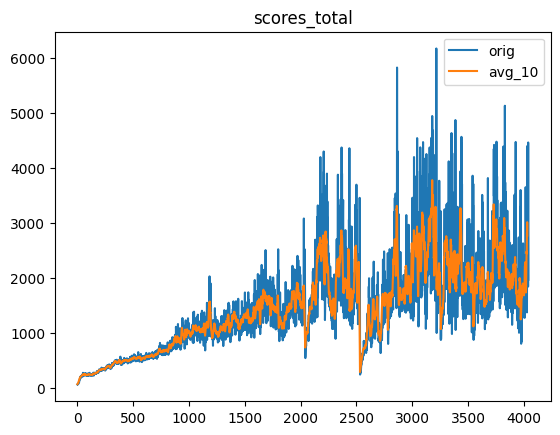

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(scores_total, label='orig')
sns.lineplot(np.convolve(scores_total, np.ones(10), "valid") / 10, label="avg_10")
plt.title("scores_total")

In [6]:
torch.save(ppo.actor_net.state_dict(), "actor_net.pth")
torch.save(ppo.critic_net.state_dict(), "critic_net.pth")